In [74]:
#This script "coregisters" different datasets.
#To adjust this to your needs, you will have to change the hard coded filenames.

#import the libraries we will need.
from Utils_coreg import gridRead, coregRaster, coregPoint, readTopologyPlatepolygonFile
import numpy
import pygplates
from matplotlib import pyplot as plt
import time
import pickle

In [75]:
#Define two big functions that coregister 
#data in two slightly different ways

In [76]:
def coregLoop(pointlist,ages,plateIDs):
    '''
    coregLoop

    This script reconstructs a shapefile of points to their birth time and 
    coregisters each point with another set of points, or a raster file.

    INPUTS:
    pointlist - list of lat/lon
    ages - list of ages corresponding to lat/lon point
    plateIDs - list of plateIDs corresponding to lat/lon point.

    Hardcoded filenames/variables must be changed below:
    input_rotation_filename - Rotation file 
    rasterfile - Time dependent raster files
    f - Time dependent kinemtic csv outputs from 'convergence.py'

    OUTPUTS:
    Coregistered array: List of lat/lons with properties.
    
    METHOD:
    Takes a set of points 
    Rotates the points back to their birth position
    Determines the point's birth position geophysical properties (coregisters)
    '''
    
    #Set up a list to store the data
    timeSteps=1 # +- Myrs around point to store. Default 1 which means just the measured point age.
    noVariables=18 #The number of variables you save
    Nshp=len(pointlist)

    coregData=numpy.zeros((Nshp,timeSteps,noVariables))

    #Create a rotation model to rotate the points back in time
    input_rotation_filename = "Muller_gplates/Global_EarthByte_230-0Ma_GK07_AREPS.rot"          
    
    file_registry = pygplates.FeatureCollectionFileFormatRegistry()
    rotation_feature_collection = file_registry.read(input_rotation_filename)
    rotation_model = pygplates.RotationModel([rotation_feature_collection])


    #Loop over all the samples, coregistering each one.
    for i, currentPoint in enumerate(pointlist):

        lat=currentPoint[1]
        lon=currentPoint[0]
        age=ages[i]
        plateID=int(plateIDs[i])
        
        print("Deposit:", i, "of", Nshp, "Lat:", lat, "Lon:", lon, "Age:", age,"PlateID:",plateID)

        #Loop through each time step in the plate model
        for time in xrange(0,230,1):
        
            #If the point was formed at the current time (or [timeStepsMyr ] prior/after) then we 
            #want to find the surrounding plate properties.
            #if  (time > (age-10)) and (time < (age+10)) or (time > (age+20)) and (time < (age+30)):
            if  (time > (age-timeSteps)) and (time < (age+timeSteps)):
                t=int(numpy.floor(time-age))
                #print(t,time,age)
                
                #A raster file, to coregister with, these points have already been rotated
                rasterfile="Muller_etal_2016_AREPS_Agegrids_v1.11/netCDF_0-230Ma/EarthByte_AREPS_v1.11_Muller_etal_2016_AgeGrid-"+str(time)+".nc"
                [x,y,z]=gridRead(rasterfile)
    
                #A vector file to coregister with, these points have already been rotated
                f=numpy.loadtxt("Muller_convergence/subStats_"+str(time)+".csv", delimiter=',')  
                lonlat=f[:,0:2]
                
    
                #-------------------#
                #Reconstruct a point to its birth position
                #-------------------#
                latlonPoint = pygplates.LatLonPoint(lat,lon)
                point_to_rotate = pygplates.convert_lat_lon_point_to_point_on_sphere(latlonPoint)
        
                finite_rotation = rotation_model.get_rotation(time, plateID)
                birthPosition = finite_rotation * point_to_rotate
        
                latlonBirth = pygplates.convert_point_on_sphere_to_lat_lon_point(birthPosition)
                #allPoints = finite_rotation * pointSet_to_rotate
        
                latBirth = latlonBirth.get_latitude()
                lonBirth = latlonBirth.get_longitude()
    
                #-------------------#
                #Set the points for coregistering
                region=5.0 #degrees
                
                #-------------------#
                #Coregisterring raster 1
                #-------------------#
                #Find the region in index units
                r=numpy.round(region/(x[1]-x[0]))
    
                #Find the index unit of lat and lon
                idxLon = (numpy.abs(x-lonBirth)).argmin()
                idxLat = (numpy.abs(y-latBirth)).argmin()
                
                #Raster 1
                c2=coregRaster([idxLon,idxLat],z,r)
                #Hack to search further around the age grid if it can't find a match, note index units (not degrees)
                if numpy.isnan(c2):
                    c2=coregRaster([idxLon,idxLat],z,r+150.0)
                    print("Trying raster region: ", r+150.0)

                #-------------------#
                #Coregisterring vector 1
                #-------------------#
                index=coregPoint([lonBirth,latBirth],lonlat,region)
                if index=='inf':
                    print("trying index region", region+15)
                    index=coregPoint([lonBirth,latBirth],lonlat,region+15.0)
    
                if numpy.isnan(c2) or index=='inf':
                    print("Skipping:", i, age, t, time, c2, index, lonBirth,latBirth)
    
                else:
                    #Vector 1
                    segmentLength=f[index,3]
                    slabLength=f[index,9]
                    distSlabEdge=f[index,15]
                    
                    SPcoregNor=f[index,4]
                    SPcoregPar=f[index,12]
                    OPcoregNor=f[index,5]
                    OPcoregPar=f[index,13]
                    CONVcoregNor=f[index,10]
                    CONVcoregPar=f[index,11]
                    
                    subPolCoreg=f[index,8]
                    subOblCoreg=f[index,7]
                    coregData[i,t,:]=[lon,lat,lonBirth,latBirth,age,t,c2,segmentLength,slabLength,distSlabEdge,SPcoregNor,SPcoregPar,OPcoregNor,OPcoregPar,CONVcoregNor,CONVcoregPar,subPolCoreg,subOblCoreg]
    
    #Return the filled coregistered array
    return(coregData)

In [77]:
def coregLoopHistory(pointlist,ts0=0,ts1=230,plateID=301):
    '''
    coregLoopHistory

    This script reconstructs a list of points throughout history and 
    coregisters each point with another set of points, or a raster file.

    INPUTS:
    pointlist - list of lat/lon
    ts0 - time step to rotate points from (probably 0Ma)
    ts1 - time step to rotate points to (probably 230Ma).

    Hardcoded filenames/variables must be changed below:
    input_rotation_filename - Rotation file 
    rasterfile - Time dependent raster files
    f - Time dependent kinemtic csv outputs from 'convergence.py'

    OUTPUTS:
    Coregistered array: List of lat/lons with properties.

    METHOD:
    Takes a set of points 
    Rotates the points back to their birth position
    Determines the point's birth position geophysical properties (coregisters)
    '''
    
    #Set up an array to store the data
    timeSteps=ts1-ts0 #The length of time before mineralisation you care about
    noVariables=18 #The number of variables you save
    Nshp = len(pointlist)
    coregData=numpy.zeros((Nshp,timeSteps,noVariables))
    
    #Create a rotation model to rotate the points back in time
    input_rotation_filename = "Muller_gplates/Global_EarthByte_230-0Ma_GK07_AREPS.rot"

    file_registry = pygplates.FeatureCollectionFileFormatRegistry()
    rotation_feature_collection = file_registry.read(input_rotation_filename)
    rotation_model = pygplates.RotationModel([rotation_feature_collection])


    #Loop through each time step in the plate model
    for time in xrange(ts0,ts1,1):

        #A raster file, to coregister with, these points have already been rotated
        rasterfile="Muller_etal_2016_AREPS_Agegrids_v1.11/netCDF_0-230Ma/EarthByte_AREPS_v1.11_Muller_etal_2016_AgeGrid-"+str(time)+".nc"
        [x,y,z]=gridRead(rasterfile)

        #A vector file to coregister with, these points have already been rotated
        f=numpy.loadtxt("Muller_convergence/subStats_"+str(time)+".csv", delimiter=',')   

        lonlat=f[:,0:2]

        for i, currentPoint in enumerate(pointlist):
                
                shapeArray=currentPoint
                age=ts0

                t=time-age
                print(i, age, time, t, plateID)

                #-------------------#
                #Reconstruct a point to its birth position
                #-------------------#
                latlonPoint = pygplates.LatLonPoint(shapeArray[1],shapeArray[0])
                
                
                point_to_rotate = pygplates.convert_lat_lon_point_to_point_on_sphere(latlonPoint)

                finite_rotation = rotation_model.get_rotation(time, plateID)
                birthPosition = finite_rotation * point_to_rotate

                latlonBirth = pygplates.convert_point_on_sphere_to_lat_lon_point(birthPosition)
                #allPoints = finite_rotation * pointSet_to_rotate

                latBirth = latlonBirth.get_latitude()
                lonBirth = latlonBirth.get_longitude()

                #-------------------#
                #Set the points for coregistering
                region=5.0 #degrees

                #-------------------#
                #Coregisterring raster 1
                #-------------------#
                #Find the region in index units
                r=numpy.round(region/(x[1]-x[0]))

                #Find the index unit of lat and lon
                idxLon = (numpy.abs(x-lonBirth)).argmin()
                idxLat = (numpy.abs(y-latBirth)).argmin()

                #Raster 1
                c2=coregRaster([idxLon,idxLat],z,r)
                #Hack to search further around the age grid if it can't find a match, \
                #note index units (not degrees)
                if numpy.isnan(c2):
                    c2=coregRaster([idxLon,idxLat],z,r+150.0)
                    print("Trying raster region: ", r+150.0)

                #-------------------#
                #Coregisterring vector 1
                #-------------------#
                index=coregPoint([lonBirth,latBirth],lonlat,region)
                if index=='inf':
                    print("trying index region", region+15)
                    index=coregPoint([lonBirth,latBirth],lonlat,region+15.0)

                if numpy.isnan(c2) or index=='inf':
                    #if we have some null data, let's save it anyway, see what happens
                    print("Skipping:", i, age, t, time, c2, index, lonBirth,latBirth)

                else:
                    #Vector 1
                    segmentLength=f[index,3]
                    slabLength=f[index,9]
                    distSlabEdge=f[index,15]

                    SPcoregNor=f[index,4]
                    SPcoregPar=f[index,12]
                    OPcoregNor=f[index,5]
                    OPcoregPar=f[index,13]
                    CONVcoregNor=f[index,10]
                    CONVcoregPar=f[index,11]

                    subPolCoreg=f[index,8]
                    subOblCoreg=f[index,7]


                    coregData[i,t,:]=[shapeArray[0],shapeArray[1],lonBirth,latBirth,\
                                    age,t,c2,\
                                    segmentLength,slabLength,distSlabEdge,\
                                    SPcoregNor,SPcoregPar,OPcoregNor,OPcoregPar,CONVcoregNor,CONVcoregPar,\
                                    subPolCoreg,subOblCoreg]
                    


    return(coregData)

In [78]:
#Create a list of points that we can track through history
#In this case, we will use, the latlon points of the SAM trench.
#We can pull out this list from a kinematic file
f = numpy.loadtxt("Muller_convergence/subStats_0.csv", delimiter=',')

In [79]:
#First, trench boundaries, west of phillipines ocean plate
import numpy as np
lonlat=f[(f[:,17])==678]
lonlat2=f[(f[:,17])==648]
lonlat3=f[(f[:,17])==662]
lonlat4=f[(f[:,17])==737]
lonlat5=f[(f[:,17])==679]
#print lonlat
#Then just pull out the trench points - done manually by plotting
pointlist1=np.array(lonlat[:,0:2])
pointlist2=np.array(lonlat2[:,0:2])
pointlist3=np.array(lonlat3[:,0:2])
pointlist4=np.array(lonlat4[:,0:2])
pointlist5=np.array(lonlat5[:,0:2])

#Removing duplicate entries
sorted_idx = np.lexsort(pointlist2.T)
sorted_data =  pointlist2[sorted_idx,:]

# Get unique row mask
row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))

# Get unique rows
pointlist2 = sorted_data[row_mask]
pointlist=np.concatenate((pointlist3, pointlist2,pointlist4, pointlist1, pointlist5))

pointlist=pointlist[np.argsort(pointlist[:, 1])]

print pointlist

[[ 1.2691512e+02 -9.2919000e-01]
 [ 1.2691512e+02 -9.2919000e-01]
 [ 1.2690657e+02 -7.2937000e-01]
 [ 1.2690657e+02 -7.2937000e-01]
 [ 1.2689802e+02 -5.2955000e-01]
 [ 1.2689802e+02 -5.2955000e-01]
 [ 1.2688946e+02 -3.2973000e-01]
 [ 1.2688946e+02 -3.2973000e-01]
 [ 1.2688091e+02 -1.2991000e-01]
 [ 1.2688091e+02 -1.2991000e-01]
 [ 1.2688381e+02  6.9250000e-02]
 [ 1.2688381e+02  6.9250000e-02]
 [ 1.2690663e+02  2.6728000e-01]
 [ 1.2690663e+02  2.6728000e-01]
 [ 1.2693791e+02  4.6482000e-01]
 [ 1.2693791e+02  4.6482000e-01]
 [ 1.2696919e+02  6.6236000e-01]
 [ 1.2696919e+02  6.6236000e-01]
 [ 1.2700047e+02  8.5990000e-01]
 [ 1.2700047e+02  8.5990000e-01]
 [ 1.2703221e+02  1.0573500e+00]
 [ 1.2703221e+02  1.0573500e+00]
 [ 1.2707407e+02  1.2526500e+00]
 [ 1.2707407e+02  1.2526500e+00]
 [ 1.2712560e+02  1.4459000e+00]
 [ 1.2712560e+02  1.4459000e+00]
 [ 1.2717713e+02  1.6391500e+00]
 [ 1.2717713e+02  1.6391500e+00]
 [ 1.2722866e+02  1.8324000e+00]
 [ 1.2722866e+02  1.8324000e+00]
 [ 1.27280

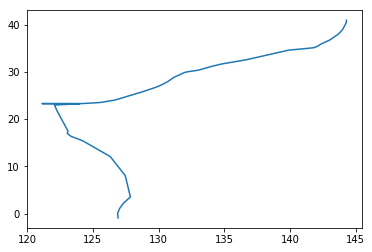

In [80]:
#check the points on a plot if you want
plt.plot(pointlist[:,0],pointlist[:,1])

In [81]:
#Now run the coregistration
tic=time.time()
a=coregLoopHistory(pointlist,ts0=0,ts1=230,plateID=301)
toc=time.time()
print("Time taken:", toc-tic, " seconds")

(0, 0, 0, 0, 301)
(1, 0, 0, 0, 301)
(2, 0, 0, 0, 301)
(3, 0, 0, 0, 301)
(4, 0, 0, 0, 301)
(5, 0, 0, 0, 301)
(6, 0, 0, 0, 301)
(7, 0, 0, 0, 301)
(8, 0, 0, 0, 301)
(9, 0, 0, 0, 301)
(10, 0, 0, 0, 301)
(11, 0, 0, 0, 301)
(12, 0, 0, 0, 301)
(13, 0, 0, 0, 301)
(14, 0, 0, 0, 301)
(15, 0, 0, 0, 301)
(16, 0, 0, 0, 301)
(17, 0, 0, 0, 301)
(18, 0, 0, 0, 301)
(19, 0, 0, 0, 301)
(20, 0, 0, 0, 301)
(21, 0, 0, 0, 301)
(22, 0, 0, 0, 301)
(23, 0, 0, 0, 301)
(24, 0, 0, 0, 301)
(25, 0, 0, 0, 301)
(26, 0, 0, 0, 301)
(27, 0, 0, 0, 301)
(28, 0, 0, 0, 301)
(29, 0, 0, 0, 301)
(30, 0, 0, 0, 301)
(31, 0, 0, 0, 301)
(32, 0, 0, 0, 301)
(33, 0, 0, 0, 301)
(34, 0, 0, 0, 301)
(35, 0, 0, 0, 301)
(36, 0, 0, 0, 301)
(37, 0, 0, 0, 301)
(38, 0, 0, 0, 301)
(39, 0, 0, 0, 301)
(40, 0, 0, 0, 301)
(41, 0, 0, 0, 301)
(42, 0, 0, 0, 301)
(43, 0, 0, 0, 301)
(44, 0, 0, 0, 301)
(45, 0, 0, 0, 301)
(46, 0, 0, 0, 301)
(47, 0, 0, 0, 301)
(48, 0, 0, 0, 301)
(49, 0, 0, 0, 301)
(50, 0, 0, 0, 301)
(51, 0, 0, 0, 301)
(52, 0, 0, 0, 301)
(53

(71, 0, 1, 1, 301)
(72, 0, 1, 1, 301)
(73, 0, 1, 1, 301)
(74, 0, 1, 1, 301)
(75, 0, 1, 1, 301)
(76, 0, 1, 1, 301)
(77, 0, 1, 1, 301)
(78, 0, 1, 1, 301)
(79, 0, 1, 1, 301)
(80, 0, 1, 1, 301)
(81, 0, 1, 1, 301)
(82, 0, 1, 1, 301)
(83, 0, 1, 1, 301)
(84, 0, 1, 1, 301)
(85, 0, 1, 1, 301)
(86, 0, 1, 1, 301)
(87, 0, 1, 1, 301)
(88, 0, 1, 1, 301)
(89, 0, 1, 1, 301)
(90, 0, 1, 1, 301)
(91, 0, 1, 1, 301)
(92, 0, 1, 1, 301)
(93, 0, 1, 1, 301)
(94, 0, 1, 1, 301)
(95, 0, 1, 1, 301)
(96, 0, 1, 1, 301)
(97, 0, 1, 1, 301)
(98, 0, 1, 1, 301)
(99, 0, 1, 1, 301)
(100, 0, 1, 1, 301)
(101, 0, 1, 1, 301)
(102, 0, 1, 1, 301)
(103, 0, 1, 1, 301)
(104, 0, 1, 1, 301)
(105, 0, 1, 1, 301)
(106, 0, 1, 1, 301)
(107, 0, 1, 1, 301)
(108, 0, 1, 1, 301)
(109, 0, 1, 1, 301)
(110, 0, 1, 1, 301)
(111, 0, 1, 1, 301)
(112, 0, 1, 1, 301)
(113, 0, 1, 1, 301)
(114, 0, 1, 1, 301)
(115, 0, 1, 1, 301)
(116, 0, 1, 1, 301)
(117, 0, 1, 1, 301)
(118, 0, 1, 1, 301)
(119, 0, 1, 1, 301)
(120, 0, 1, 1, 301)
(121, 0, 1, 1, 301)
(122, 0, 

(139, 0, 2, 2, 301)
(140, 0, 2, 2, 301)
(141, 0, 2, 2, 301)
(142, 0, 2, 2, 301)
(143, 0, 2, 2, 301)
(144, 0, 2, 2, 301)
(145, 0, 2, 2, 301)
(146, 0, 2, 2, 301)
(147, 0, 2, 2, 301)
(148, 0, 2, 2, 301)
(149, 0, 2, 2, 301)
(150, 0, 2, 2, 301)
(151, 0, 2, 2, 301)
(152, 0, 2, 2, 301)
(153, 0, 2, 2, 301)
(154, 0, 2, 2, 301)
(155, 0, 2, 2, 301)
(156, 0, 2, 2, 301)
(157, 0, 2, 2, 301)
(158, 0, 2, 2, 301)
(159, 0, 2, 2, 301)
(160, 0, 2, 2, 301)
(161, 0, 2, 2, 301)
(162, 0, 2, 2, 301)
(163, 0, 2, 2, 301)
(164, 0, 2, 2, 301)
(165, 0, 2, 2, 301)
(166, 0, 2, 2, 301)
(167, 0, 2, 2, 301)
(168, 0, 2, 2, 301)
(169, 0, 2, 2, 301)
(170, 0, 2, 2, 301)
(171, 0, 2, 2, 301)
(172, 0, 2, 2, 301)
(173, 0, 2, 2, 301)
(174, 0, 2, 2, 301)
(175, 0, 2, 2, 301)
(176, 0, 2, 2, 301)
(177, 0, 2, 2, 301)
(178, 0, 2, 2, 301)
(179, 0, 2, 2, 301)
(180, 0, 2, 2, 301)
(181, 0, 2, 2, 301)
(182, 0, 2, 2, 301)
(183, 0, 2, 2, 301)
(184, 0, 2, 2, 301)
(185, 0, 2, 2, 301)
(186, 0, 2, 2, 301)
(187, 0, 2, 2, 301)
(188, 0, 2, 2, 301)


(211, 0, 3, 3, 301)
(212, 0, 3, 3, 301)
(213, 0, 3, 3, 301)
(214, 0, 3, 3, 301)
(215, 0, 3, 3, 301)
(216, 0, 3, 3, 301)
(217, 0, 3, 3, 301)
(218, 0, 3, 3, 301)
(219, 0, 3, 3, 301)
(220, 0, 3, 3, 301)
(221, 0, 3, 3, 301)
(222, 0, 3, 3, 301)
(223, 0, 3, 3, 301)
(224, 0, 3, 3, 301)
(225, 0, 3, 3, 301)
(226, 0, 3, 3, 301)
(227, 0, 3, 3, 301)
(228, 0, 3, 3, 301)
(229, 0, 3, 3, 301)
(230, 0, 3, 3, 301)
(231, 0, 3, 3, 301)
(232, 0, 3, 3, 301)
(233, 0, 3, 3, 301)
(234, 0, 3, 3, 301)
(235, 0, 3, 3, 301)
(236, 0, 3, 3, 301)
(237, 0, 3, 3, 301)
(238, 0, 3, 3, 301)
(239, 0, 3, 3, 301)
(240, 0, 3, 3, 301)
(241, 0, 3, 3, 301)
(242, 0, 3, 3, 301)
(243, 0, 3, 3, 301)
(244, 0, 3, 3, 301)
(245, 0, 3, 3, 301)
(246, 0, 3, 3, 301)
(247, 0, 3, 3, 301)
(248, 0, 3, 3, 301)
(249, 0, 3, 3, 301)
(250, 0, 3, 3, 301)
(251, 0, 3, 3, 301)
(252, 0, 3, 3, 301)
(253, 0, 3, 3, 301)
(254, 0, 3, 3, 301)
(255, 0, 3, 3, 301)
(256, 0, 3, 3, 301)
(257, 0, 3, 3, 301)
(258, 0, 3, 3, 301)
(259, 0, 3, 3, 301)
(260, 0, 3, 3, 301)


(277, 0, 4, 4, 301)
(278, 0, 4, 4, 301)
(279, 0, 4, 4, 301)
(280, 0, 4, 4, 301)
(281, 0, 4, 4, 301)
(282, 0, 4, 4, 301)
(283, 0, 4, 4, 301)
(284, 0, 4, 4, 301)
(285, 0, 4, 4, 301)
(286, 0, 4, 4, 301)
(287, 0, 4, 4, 301)
(288, 0, 4, 4, 301)
(289, 0, 4, 4, 301)
(290, 0, 4, 4, 301)
(291, 0, 4, 4, 301)
(292, 0, 4, 4, 301)
(293, 0, 4, 4, 301)
(294, 0, 4, 4, 301)
(295, 0, 4, 4, 301)
(296, 0, 4, 4, 301)
(297, 0, 4, 4, 301)
(298, 0, 4, 4, 301)
(299, 0, 4, 4, 301)
(300, 0, 4, 4, 301)
(301, 0, 4, 4, 301)
(302, 0, 4, 4, 301)
(303, 0, 4, 4, 301)
(304, 0, 4, 4, 301)
(305, 0, 4, 4, 301)
(306, 0, 4, 4, 301)
(307, 0, 4, 4, 301)
(308, 0, 4, 4, 301)
(309, 0, 4, 4, 301)
(310, 0, 4, 4, 301)
(311, 0, 4, 4, 301)
(312, 0, 4, 4, 301)
(313, 0, 4, 4, 301)
(314, 0, 4, 4, 301)
(315, 0, 4, 4, 301)
(316, 0, 4, 4, 301)
(317, 0, 4, 4, 301)
(318, 0, 4, 4, 301)
(319, 0, 4, 4, 301)
(320, 0, 4, 4, 301)
(321, 0, 4, 4, 301)
(322, 0, 4, 4, 301)
(323, 0, 4, 4, 301)
(324, 0, 4, 4, 301)
(325, 0, 4, 4, 301)
(326, 0, 4, 4, 301)


(335, 0, 5, 5, 301)
(336, 0, 5, 5, 301)
(337, 0, 5, 5, 301)
(338, 0, 5, 5, 301)
(339, 0, 5, 5, 301)
(340, 0, 5, 5, 301)
(341, 0, 5, 5, 301)
(342, 0, 5, 5, 301)
(343, 0, 5, 5, 301)
(344, 0, 5, 5, 301)
(345, 0, 5, 5, 301)
(346, 0, 5, 5, 301)
(347, 0, 5, 5, 301)
(348, 0, 5, 5, 301)
(349, 0, 5, 5, 301)
(350, 0, 5, 5, 301)
(351, 0, 5, 5, 301)
(352, 0, 5, 5, 301)
(353, 0, 5, 5, 301)
(354, 0, 5, 5, 301)
(355, 0, 5, 5, 301)
(356, 0, 5, 5, 301)
(357, 0, 5, 5, 301)
(358, 0, 5, 5, 301)
(359, 0, 5, 5, 301)
(360, 0, 5, 5, 301)
(361, 0, 5, 5, 301)
(362, 0, 5, 5, 301)
(363, 0, 5, 5, 301)
(0, 0, 6, 6, 301)
(1, 0, 6, 6, 301)
(2, 0, 6, 6, 301)
(3, 0, 6, 6, 301)
(4, 0, 6, 6, 301)
(5, 0, 6, 6, 301)
(6, 0, 6, 6, 301)
(7, 0, 6, 6, 301)
(8, 0, 6, 6, 301)
(9, 0, 6, 6, 301)
(10, 0, 6, 6, 301)
(11, 0, 6, 6, 301)
(12, 0, 6, 6, 301)
(13, 0, 6, 6, 301)
(14, 0, 6, 6, 301)
(15, 0, 6, 6, 301)
(16, 0, 6, 6, 301)
(17, 0, 6, 6, 301)
(18, 0, 6, 6, 301)
(19, 0, 6, 6, 301)
(20, 0, 6, 6, 301)
(21, 0, 6, 6, 301)
(22, 0, 6, 6

(45, 0, 7, 7, 301)
(46, 0, 7, 7, 301)
(47, 0, 7, 7, 301)
(48, 0, 7, 7, 301)
(49, 0, 7, 7, 301)
(50, 0, 7, 7, 301)
(51, 0, 7, 7, 301)
(52, 0, 7, 7, 301)
(53, 0, 7, 7, 301)
(54, 0, 7, 7, 301)
(55, 0, 7, 7, 301)
(56, 0, 7, 7, 301)
(57, 0, 7, 7, 301)
(58, 0, 7, 7, 301)
(59, 0, 7, 7, 301)
(60, 0, 7, 7, 301)
(61, 0, 7, 7, 301)
(62, 0, 7, 7, 301)
(63, 0, 7, 7, 301)
(64, 0, 7, 7, 301)
(65, 0, 7, 7, 301)
(66, 0, 7, 7, 301)
(67, 0, 7, 7, 301)
(68, 0, 7, 7, 301)
(69, 0, 7, 7, 301)
(70, 0, 7, 7, 301)
(71, 0, 7, 7, 301)
(72, 0, 7, 7, 301)
(73, 0, 7, 7, 301)
(74, 0, 7, 7, 301)
(75, 0, 7, 7, 301)
(76, 0, 7, 7, 301)
(77, 0, 7, 7, 301)
(78, 0, 7, 7, 301)
(79, 0, 7, 7, 301)
(80, 0, 7, 7, 301)
(81, 0, 7, 7, 301)
(82, 0, 7, 7, 301)
(83, 0, 7, 7, 301)
(84, 0, 7, 7, 301)
(85, 0, 7, 7, 301)
(86, 0, 7, 7, 301)
(87, 0, 7, 7, 301)
(88, 0, 7, 7, 301)
(89, 0, 7, 7, 301)
(90, 0, 7, 7, 301)
(91, 0, 7, 7, 301)
(92, 0, 7, 7, 301)
(93, 0, 7, 7, 301)
(94, 0, 7, 7, 301)
(95, 0, 7, 7, 301)
(96, 0, 7, 7, 301)
(97, 0, 7, 7

(99, 0, 8, 8, 301)
(100, 0, 8, 8, 301)
(101, 0, 8, 8, 301)
(102, 0, 8, 8, 301)
(103, 0, 8, 8, 301)
(104, 0, 8, 8, 301)
(105, 0, 8, 8, 301)
(106, 0, 8, 8, 301)
(107, 0, 8, 8, 301)
(108, 0, 8, 8, 301)
(109, 0, 8, 8, 301)
(110, 0, 8, 8, 301)
(111, 0, 8, 8, 301)
(112, 0, 8, 8, 301)
(113, 0, 8, 8, 301)
(114, 0, 8, 8, 301)
(115, 0, 8, 8, 301)
(116, 0, 8, 8, 301)
(117, 0, 8, 8, 301)
(118, 0, 8, 8, 301)
(119, 0, 8, 8, 301)
(120, 0, 8, 8, 301)
(121, 0, 8, 8, 301)
(122, 0, 8, 8, 301)
(123, 0, 8, 8, 301)
(124, 0, 8, 8, 301)
(125, 0, 8, 8, 301)
(126, 0, 8, 8, 301)
(127, 0, 8, 8, 301)
(128, 0, 8, 8, 301)
(129, 0, 8, 8, 301)
(130, 0, 8, 8, 301)
(131, 0, 8, 8, 301)
(132, 0, 8, 8, 301)
(133, 0, 8, 8, 301)
(134, 0, 8, 8, 301)
(135, 0, 8, 8, 301)
(136, 0, 8, 8, 301)
(137, 0, 8, 8, 301)
(138, 0, 8, 8, 301)
(139, 0, 8, 8, 301)
(140, 0, 8, 8, 301)
(141, 0, 8, 8, 301)
(142, 0, 8, 8, 301)
(143, 0, 8, 8, 301)
(144, 0, 8, 8, 301)
(145, 0, 8, 8, 301)
(146, 0, 8, 8, 301)
(147, 0, 8, 8, 301)
(148, 0, 8, 8, 301)
(

(172, 0, 9, 9, 301)
(173, 0, 9, 9, 301)
(174, 0, 9, 9, 301)
(175, 0, 9, 9, 301)
(176, 0, 9, 9, 301)
(177, 0, 9, 9, 301)
(178, 0, 9, 9, 301)
(179, 0, 9, 9, 301)
(180, 0, 9, 9, 301)
(181, 0, 9, 9, 301)
(182, 0, 9, 9, 301)
(183, 0, 9, 9, 301)
(184, 0, 9, 9, 301)
(185, 0, 9, 9, 301)
(186, 0, 9, 9, 301)
(187, 0, 9, 9, 301)
(188, 0, 9, 9, 301)
(189, 0, 9, 9, 301)
(190, 0, 9, 9, 301)
(191, 0, 9, 9, 301)
(192, 0, 9, 9, 301)
(193, 0, 9, 9, 301)
(194, 0, 9, 9, 301)
(195, 0, 9, 9, 301)
(196, 0, 9, 9, 301)
(197, 0, 9, 9, 301)
(198, 0, 9, 9, 301)
(199, 0, 9, 9, 301)
(200, 0, 9, 9, 301)
(201, 0, 9, 9, 301)
(202, 0, 9, 9, 301)
(203, 0, 9, 9, 301)
(204, 0, 9, 9, 301)
(205, 0, 9, 9, 301)
(206, 0, 9, 9, 301)
(207, 0, 9, 9, 301)
(208, 0, 9, 9, 301)
(209, 0, 9, 9, 301)
(210, 0, 9, 9, 301)
(211, 0, 9, 9, 301)
(212, 0, 9, 9, 301)
(213, 0, 9, 9, 301)
(214, 0, 9, 9, 301)
(215, 0, 9, 9, 301)
(216, 0, 9, 9, 301)
(217, 0, 9, 9, 301)
(218, 0, 9, 9, 301)
(219, 0, 9, 9, 301)
(220, 0, 9, 9, 301)
(221, 0, 9, 9, 301)


(224, 0, 10, 10, 301)
(225, 0, 10, 10, 301)
(226, 0, 10, 10, 301)
(227, 0, 10, 10, 301)
(228, 0, 10, 10, 301)
(229, 0, 10, 10, 301)
(230, 0, 10, 10, 301)
(231, 0, 10, 10, 301)
(232, 0, 10, 10, 301)
(233, 0, 10, 10, 301)
(234, 0, 10, 10, 301)
(235, 0, 10, 10, 301)
(236, 0, 10, 10, 301)
(237, 0, 10, 10, 301)
(238, 0, 10, 10, 301)
(239, 0, 10, 10, 301)
(240, 0, 10, 10, 301)
(241, 0, 10, 10, 301)
(242, 0, 10, 10, 301)
(243, 0, 10, 10, 301)
(244, 0, 10, 10, 301)
(245, 0, 10, 10, 301)
(246, 0, 10, 10, 301)
(247, 0, 10, 10, 301)
(248, 0, 10, 10, 301)
(249, 0, 10, 10, 301)
(250, 0, 10, 10, 301)
(251, 0, 10, 10, 301)
(252, 0, 10, 10, 301)
(253, 0, 10, 10, 301)
(254, 0, 10, 10, 301)
(255, 0, 10, 10, 301)
(256, 0, 10, 10, 301)
(257, 0, 10, 10, 301)
(258, 0, 10, 10, 301)
(259, 0, 10, 10, 301)
(260, 0, 10, 10, 301)
(261, 0, 10, 10, 301)
(262, 0, 10, 10, 301)
(263, 0, 10, 10, 301)
(264, 0, 10, 10, 301)
(265, 0, 10, 10, 301)
(266, 0, 10, 10, 301)
(267, 0, 10, 10, 301)
(268, 0, 10, 10, 301)
(269, 0, 1

(238, 0, 11, 11, 301)
(239, 0, 11, 11, 301)
(240, 0, 11, 11, 301)
(241, 0, 11, 11, 301)
(242, 0, 11, 11, 301)
(243, 0, 11, 11, 301)
(244, 0, 11, 11, 301)
(245, 0, 11, 11, 301)
(246, 0, 11, 11, 301)
(247, 0, 11, 11, 301)
(248, 0, 11, 11, 301)
(249, 0, 11, 11, 301)
(250, 0, 11, 11, 301)
(251, 0, 11, 11, 301)
(252, 0, 11, 11, 301)
(253, 0, 11, 11, 301)
(254, 0, 11, 11, 301)
(255, 0, 11, 11, 301)
(256, 0, 11, 11, 301)
(257, 0, 11, 11, 301)
(258, 0, 11, 11, 301)
(259, 0, 11, 11, 301)
(260, 0, 11, 11, 301)
(261, 0, 11, 11, 301)
(262, 0, 11, 11, 301)
(263, 0, 11, 11, 301)
(264, 0, 11, 11, 301)
(265, 0, 11, 11, 301)
(266, 0, 11, 11, 301)
(267, 0, 11, 11, 301)
(268, 0, 11, 11, 301)
(269, 0, 11, 11, 301)
(270, 0, 11, 11, 301)
(271, 0, 11, 11, 301)
(272, 0, 11, 11, 301)
(273, 0, 11, 11, 301)
(274, 0, 11, 11, 301)
(275, 0, 11, 11, 301)
(276, 0, 11, 11, 301)
(277, 0, 11, 11, 301)
(278, 0, 11, 11, 301)
(279, 0, 11, 11, 301)
(280, 0, 11, 11, 301)
(281, 0, 11, 11, 301)
(282, 0, 11, 11, 301)
(283, 0, 1

(270, 0, 12, 12, 301)
(271, 0, 12, 12, 301)
(272, 0, 12, 12, 301)
(273, 0, 12, 12, 301)
(274, 0, 12, 12, 301)
(275, 0, 12, 12, 301)
(276, 0, 12, 12, 301)
(277, 0, 12, 12, 301)
(278, 0, 12, 12, 301)
(279, 0, 12, 12, 301)
(280, 0, 12, 12, 301)
(281, 0, 12, 12, 301)
(282, 0, 12, 12, 301)
(283, 0, 12, 12, 301)
(284, 0, 12, 12, 301)
(285, 0, 12, 12, 301)
(286, 0, 12, 12, 301)
(287, 0, 12, 12, 301)
(288, 0, 12, 12, 301)
(289, 0, 12, 12, 301)
(290, 0, 12, 12, 301)
(291, 0, 12, 12, 301)
(292, 0, 12, 12, 301)
(293, 0, 12, 12, 301)
(294, 0, 12, 12, 301)
(295, 0, 12, 12, 301)
(296, 0, 12, 12, 301)
(297, 0, 12, 12, 301)
(298, 0, 12, 12, 301)
(299, 0, 12, 12, 301)
(300, 0, 12, 12, 301)
(301, 0, 12, 12, 301)
(302, 0, 12, 12, 301)
(303, 0, 12, 12, 301)
(304, 0, 12, 12, 301)
(305, 0, 12, 12, 301)
(306, 0, 12, 12, 301)
(307, 0, 12, 12, 301)
(308, 0, 12, 12, 301)
(309, 0, 12, 12, 301)
(310, 0, 12, 12, 301)
(311, 0, 12, 12, 301)
(312, 0, 12, 12, 301)
(313, 0, 12, 12, 301)
(314, 0, 12, 12, 301)
(315, 0, 1

(291, 0, 13, 13, 301)
(292, 0, 13, 13, 301)
(293, 0, 13, 13, 301)
(294, 0, 13, 13, 301)
(295, 0, 13, 13, 301)
(296, 0, 13, 13, 301)
(297, 0, 13, 13, 301)
(298, 0, 13, 13, 301)
(299, 0, 13, 13, 301)
(300, 0, 13, 13, 301)
(301, 0, 13, 13, 301)
(302, 0, 13, 13, 301)
(303, 0, 13, 13, 301)
(304, 0, 13, 13, 301)
(305, 0, 13, 13, 301)
(306, 0, 13, 13, 301)
(307, 0, 13, 13, 301)
(308, 0, 13, 13, 301)
(309, 0, 13, 13, 301)
(310, 0, 13, 13, 301)
(311, 0, 13, 13, 301)
(312, 0, 13, 13, 301)
(313, 0, 13, 13, 301)
(314, 0, 13, 13, 301)
(315, 0, 13, 13, 301)
(316, 0, 13, 13, 301)
(317, 0, 13, 13, 301)
(318, 0, 13, 13, 301)
(319, 0, 13, 13, 301)
(320, 0, 13, 13, 301)
(321, 0, 13, 13, 301)
(322, 0, 13, 13, 301)
(323, 0, 13, 13, 301)
(324, 0, 13, 13, 301)
(325, 0, 13, 13, 301)
(326, 0, 13, 13, 301)
(327, 0, 13, 13, 301)
(328, 0, 13, 13, 301)
(329, 0, 13, 13, 301)
(330, 0, 13, 13, 301)
(331, 0, 13, 13, 301)
(332, 0, 13, 13, 301)
(333, 0, 13, 13, 301)
(334, 0, 13, 13, 301)
(335, 0, 13, 13, 301)
(336, 0, 1

(320, 0, 14, 14, 301)
(321, 0, 14, 14, 301)
(322, 0, 14, 14, 301)
(323, 0, 14, 14, 301)
(324, 0, 14, 14, 301)
(325, 0, 14, 14, 301)
(326, 0, 14, 14, 301)
(327, 0, 14, 14, 301)
(328, 0, 14, 14, 301)
(329, 0, 14, 14, 301)
(330, 0, 14, 14, 301)
(331, 0, 14, 14, 301)
(332, 0, 14, 14, 301)
(333, 0, 14, 14, 301)
(334, 0, 14, 14, 301)
(335, 0, 14, 14, 301)
(336, 0, 14, 14, 301)
(337, 0, 14, 14, 301)
(338, 0, 14, 14, 301)
(339, 0, 14, 14, 301)
(340, 0, 14, 14, 301)
(341, 0, 14, 14, 301)
(342, 0, 14, 14, 301)
(343, 0, 14, 14, 301)
(344, 0, 14, 14, 301)
(345, 0, 14, 14, 301)
(346, 0, 14, 14, 301)
(347, 0, 14, 14, 301)
(348, 0, 14, 14, 301)
(349, 0, 14, 14, 301)
(350, 0, 14, 14, 301)
(351, 0, 14, 14, 301)
(352, 0, 14, 14, 301)
(353, 0, 14, 14, 301)
(354, 0, 14, 14, 301)
(355, 0, 14, 14, 301)
(356, 0, 14, 14, 301)
(357, 0, 14, 14, 301)
(358, 0, 14, 14, 301)
(359, 0, 14, 14, 301)
(360, 0, 14, 14, 301)
(361, 0, 14, 14, 301)
(362, 0, 14, 14, 301)
(363, 0, 14, 14, 301)
(0, 0, 15, 15, 301)
(1, 0, 15, 1

(341, 0, 15, 15, 301)
(342, 0, 15, 15, 301)
(343, 0, 15, 15, 301)
(344, 0, 15, 15, 301)
(345, 0, 15, 15, 301)
(346, 0, 15, 15, 301)
(347, 0, 15, 15, 301)
(348, 0, 15, 15, 301)
(349, 0, 15, 15, 301)
(350, 0, 15, 15, 301)
(351, 0, 15, 15, 301)
(352, 0, 15, 15, 301)
(353, 0, 15, 15, 301)
(354, 0, 15, 15, 301)
(355, 0, 15, 15, 301)
(356, 0, 15, 15, 301)
(357, 0, 15, 15, 301)
(358, 0, 15, 15, 301)
(359, 0, 15, 15, 301)
(360, 0, 15, 15, 301)
(361, 0, 15, 15, 301)
(362, 0, 15, 15, 301)
(363, 0, 15, 15, 301)
(0, 0, 16, 16, 301)
(1, 0, 16, 16, 301)
(2, 0, 16, 16, 301)
(3, 0, 16, 16, 301)
(4, 0, 16, 16, 301)
(5, 0, 16, 16, 301)
(6, 0, 16, 16, 301)
(7, 0, 16, 16, 301)
(8, 0, 16, 16, 301)
(9, 0, 16, 16, 301)
(10, 0, 16, 16, 301)
(11, 0, 16, 16, 301)
(12, 0, 16, 16, 301)
(13, 0, 16, 16, 301)
(14, 0, 16, 16, 301)
(15, 0, 16, 16, 301)
(16, 0, 16, 16, 301)
(17, 0, 16, 16, 301)
(18, 0, 16, 16, 301)
(19, 0, 16, 16, 301)
(20, 0, 16, 16, 301)
(21, 0, 16, 16, 301)
(22, 0, 16, 16, 301)
(23, 0, 16, 16, 301)


(360, 0, 16, 16, 301)
(361, 0, 16, 16, 301)
(362, 0, 16, 16, 301)
(363, 0, 16, 16, 301)
(0, 0, 17, 17, 301)
(1, 0, 17, 17, 301)
(2, 0, 17, 17, 301)
(3, 0, 17, 17, 301)
(4, 0, 17, 17, 301)
(5, 0, 17, 17, 301)
(6, 0, 17, 17, 301)
(7, 0, 17, 17, 301)
(8, 0, 17, 17, 301)
(9, 0, 17, 17, 301)
(10, 0, 17, 17, 301)
(11, 0, 17, 17, 301)
(12, 0, 17, 17, 301)
(13, 0, 17, 17, 301)
(14, 0, 17, 17, 301)
(15, 0, 17, 17, 301)
(16, 0, 17, 17, 301)
(17, 0, 17, 17, 301)
(18, 0, 17, 17, 301)
(19, 0, 17, 17, 301)
(20, 0, 17, 17, 301)
(21, 0, 17, 17, 301)
(22, 0, 17, 17, 301)
(23, 0, 17, 17, 301)
(24, 0, 17, 17, 301)
(25, 0, 17, 17, 301)
(26, 0, 17, 17, 301)
(27, 0, 17, 17, 301)
(28, 0, 17, 17, 301)
(29, 0, 17, 17, 301)
(30, 0, 17, 17, 301)
(31, 0, 17, 17, 301)
(32, 0, 17, 17, 301)
(33, 0, 17, 17, 301)
(34, 0, 17, 17, 301)
(35, 0, 17, 17, 301)
(36, 0, 17, 17, 301)
(37, 0, 17, 17, 301)
(38, 0, 17, 17, 301)
(39, 0, 17, 17, 301)
(40, 0, 17, 17, 301)
(41, 0, 17, 17, 301)
(42, 0, 17, 17, 301)
(43, 0, 17, 17, 301

(21, 0, 18, 18, 301)
(22, 0, 18, 18, 301)
(23, 0, 18, 18, 301)
(24, 0, 18, 18, 301)
(25, 0, 18, 18, 301)
(26, 0, 18, 18, 301)
(27, 0, 18, 18, 301)
(28, 0, 18, 18, 301)
(29, 0, 18, 18, 301)
(30, 0, 18, 18, 301)
(31, 0, 18, 18, 301)
(32, 0, 18, 18, 301)
(33, 0, 18, 18, 301)
(34, 0, 18, 18, 301)
(35, 0, 18, 18, 301)
(36, 0, 18, 18, 301)
(37, 0, 18, 18, 301)
(38, 0, 18, 18, 301)
(39, 0, 18, 18, 301)
(40, 0, 18, 18, 301)
(41, 0, 18, 18, 301)
(42, 0, 18, 18, 301)
(43, 0, 18, 18, 301)
(44, 0, 18, 18, 301)
(45, 0, 18, 18, 301)
(46, 0, 18, 18, 301)
(47, 0, 18, 18, 301)
(48, 0, 18, 18, 301)
(49, 0, 18, 18, 301)
(50, 0, 18, 18, 301)
(51, 0, 18, 18, 301)
(52, 0, 18, 18, 301)
(53, 0, 18, 18, 301)
(54, 0, 18, 18, 301)
(55, 0, 18, 18, 301)
(56, 0, 18, 18, 301)
(57, 0, 18, 18, 301)
(58, 0, 18, 18, 301)
(59, 0, 18, 18, 301)
(60, 0, 18, 18, 301)
(61, 0, 18, 18, 301)
(62, 0, 18, 18, 301)
(63, 0, 18, 18, 301)
(64, 0, 18, 18, 301)
(65, 0, 18, 18, 301)
(66, 0, 18, 18, 301)
(67, 0, 18, 18, 301)
(68, 0, 18, 1

(41, 0, 19, 19, 301)
(42, 0, 19, 19, 301)
(43, 0, 19, 19, 301)
(44, 0, 19, 19, 301)
(45, 0, 19, 19, 301)
(46, 0, 19, 19, 301)
(47, 0, 19, 19, 301)
(48, 0, 19, 19, 301)
(49, 0, 19, 19, 301)
(50, 0, 19, 19, 301)
(51, 0, 19, 19, 301)
(52, 0, 19, 19, 301)
(53, 0, 19, 19, 301)
(54, 0, 19, 19, 301)
(55, 0, 19, 19, 301)
(56, 0, 19, 19, 301)
(57, 0, 19, 19, 301)
(58, 0, 19, 19, 301)
(59, 0, 19, 19, 301)
(60, 0, 19, 19, 301)
(61, 0, 19, 19, 301)
(62, 0, 19, 19, 301)
(63, 0, 19, 19, 301)
(64, 0, 19, 19, 301)
(65, 0, 19, 19, 301)
(66, 0, 19, 19, 301)
(67, 0, 19, 19, 301)
(68, 0, 19, 19, 301)
(69, 0, 19, 19, 301)
(70, 0, 19, 19, 301)
(71, 0, 19, 19, 301)
(72, 0, 19, 19, 301)
(73, 0, 19, 19, 301)
(74, 0, 19, 19, 301)
(75, 0, 19, 19, 301)
(76, 0, 19, 19, 301)
(77, 0, 19, 19, 301)
(78, 0, 19, 19, 301)
(79, 0, 19, 19, 301)
(80, 0, 19, 19, 301)
(81, 0, 19, 19, 301)
(82, 0, 19, 19, 301)
(83, 0, 19, 19, 301)
(84, 0, 19, 19, 301)
(85, 0, 19, 19, 301)
(86, 0, 19, 19, 301)
(87, 0, 19, 19, 301)
(88, 0, 19, 1

(63, 0, 20, 20, 301)
(64, 0, 20, 20, 301)
(65, 0, 20, 20, 301)
(66, 0, 20, 20, 301)
(67, 0, 20, 20, 301)
(68, 0, 20, 20, 301)
(69, 0, 20, 20, 301)
(70, 0, 20, 20, 301)
(71, 0, 20, 20, 301)
(72, 0, 20, 20, 301)
(73, 0, 20, 20, 301)
(74, 0, 20, 20, 301)
(75, 0, 20, 20, 301)
(76, 0, 20, 20, 301)
(77, 0, 20, 20, 301)
(78, 0, 20, 20, 301)
(79, 0, 20, 20, 301)
(80, 0, 20, 20, 301)
(81, 0, 20, 20, 301)
(82, 0, 20, 20, 301)
(83, 0, 20, 20, 301)
(84, 0, 20, 20, 301)
(85, 0, 20, 20, 301)
(86, 0, 20, 20, 301)
(87, 0, 20, 20, 301)
(88, 0, 20, 20, 301)
(89, 0, 20, 20, 301)
(90, 0, 20, 20, 301)
(91, 0, 20, 20, 301)
(92, 0, 20, 20, 301)
(93, 0, 20, 20, 301)
(94, 0, 20, 20, 301)
(95, 0, 20, 20, 301)
(96, 0, 20, 20, 301)
(97, 0, 20, 20, 301)
(98, 0, 20, 20, 301)
(99, 0, 20, 20, 301)
(100, 0, 20, 20, 301)
(101, 0, 20, 20, 301)
(102, 0, 20, 20, 301)
(103, 0, 20, 20, 301)
(104, 0, 20, 20, 301)
(105, 0, 20, 20, 301)
(106, 0, 20, 20, 301)
(107, 0, 20, 20, 301)
(108, 0, 20, 20, 301)
(109, 0, 20, 20, 301)
(11

('trying index region', 20.0)
(86, 0, 21, 21, 301)
('trying index region', 20.0)
(87, 0, 21, 21, 301)
('trying index region', 20.0)
(88, 0, 21, 21, 301)
('trying index region', 20.0)
(89, 0, 21, 21, 301)
('trying index region', 20.0)
(90, 0, 21, 21, 301)
('trying index region', 20.0)
(91, 0, 21, 21, 301)
('trying index region', 20.0)
(92, 0, 21, 21, 301)
('trying index region', 20.0)
(93, 0, 21, 21, 301)
('trying index region', 20.0)
(94, 0, 21, 21, 301)
('trying index region', 20.0)
(95, 0, 21, 21, 301)
('trying index region', 20.0)
(96, 0, 21, 21, 301)
('trying index region', 20.0)
(97, 0, 21, 21, 301)
('trying index region', 20.0)
(98, 0, 21, 21, 301)
('trying index region', 20.0)
(99, 0, 21, 21, 301)
('trying index region', 20.0)
(100, 0, 21, 21, 301)
('trying index region', 20.0)
(101, 0, 21, 21, 301)
('trying index region', 20.0)
(102, 0, 21, 21, 301)
('trying index region', 20.0)
(103, 0, 21, 21, 301)
('trying index region', 20.0)
(104, 0, 21, 21, 301)
('trying index region', 20

('trying index region', 20.0)
(71, 0, 22, 22, 301)
('trying index region', 20.0)
(72, 0, 22, 22, 301)
('trying index region', 20.0)
(73, 0, 22, 22, 301)
('trying index region', 20.0)
(74, 0, 22, 22, 301)
('trying index region', 20.0)
(75, 0, 22, 22, 301)
('trying index region', 20.0)
(76, 0, 22, 22, 301)
('trying index region', 20.0)
(77, 0, 22, 22, 301)
('trying index region', 20.0)
(78, 0, 22, 22, 301)
('trying index region', 20.0)
(79, 0, 22, 22, 301)
('trying index region', 20.0)
(80, 0, 22, 22, 301)
('trying index region', 20.0)
(81, 0, 22, 22, 301)
('trying index region', 20.0)
(82, 0, 22, 22, 301)
('trying index region', 20.0)
(83, 0, 22, 22, 301)
('trying index region', 20.0)
(84, 0, 22, 22, 301)
('trying index region', 20.0)
(85, 0, 22, 22, 301)
('trying index region', 20.0)
(86, 0, 22, 22, 301)
('trying index region', 20.0)
(87, 0, 22, 22, 301)
('trying index region', 20.0)
(88, 0, 22, 22, 301)
('trying index region', 20.0)
(89, 0, 22, 22, 301)
('trying index region', 20.0)
(

(23, 0, 23, 23, 301)
(24, 0, 23, 23, 301)
(25, 0, 23, 23, 301)
(26, 0, 23, 23, 301)
(27, 0, 23, 23, 301)
(28, 0, 23, 23, 301)
(29, 0, 23, 23, 301)
(30, 0, 23, 23, 301)
(31, 0, 23, 23, 301)
(32, 0, 23, 23, 301)
(33, 0, 23, 23, 301)
(34, 0, 23, 23, 301)
(35, 0, 23, 23, 301)
(36, 0, 23, 23, 301)
(37, 0, 23, 23, 301)
(38, 0, 23, 23, 301)
(39, 0, 23, 23, 301)
(40, 0, 23, 23, 301)
(41, 0, 23, 23, 301)
(42, 0, 23, 23, 301)
(43, 0, 23, 23, 301)
(44, 0, 23, 23, 301)
(45, 0, 23, 23, 301)
(46, 0, 23, 23, 301)
(47, 0, 23, 23, 301)
(48, 0, 23, 23, 301)
(49, 0, 23, 23, 301)
(50, 0, 23, 23, 301)
(51, 0, 23, 23, 301)
(52, 0, 23, 23, 301)
(53, 0, 23, 23, 301)
(54, 0, 23, 23, 301)
(55, 0, 23, 23, 301)
(56, 0, 23, 23, 301)
(57, 0, 23, 23, 301)
(58, 0, 23, 23, 301)
(59, 0, 23, 23, 301)
(60, 0, 23, 23, 301)
(61, 0, 23, 23, 301)
(62, 0, 23, 23, 301)
(63, 0, 23, 23, 301)
('trying index region', 20.0)
(64, 0, 23, 23, 301)
('trying index region', 20.0)
(65, 0, 23, 23, 301)
('trying index region', 20.0)
(66, 0,

(327, 0, 23, 23, 301)
(328, 0, 23, 23, 301)
(329, 0, 23, 23, 301)
(330, 0, 23, 23, 301)
(331, 0, 23, 23, 301)
(332, 0, 23, 23, 301)
(333, 0, 23, 23, 301)
(334, 0, 23, 23, 301)
(335, 0, 23, 23, 301)
(336, 0, 23, 23, 301)
(337, 0, 23, 23, 301)
(338, 0, 23, 23, 301)
(339, 0, 23, 23, 301)
(340, 0, 23, 23, 301)
(341, 0, 23, 23, 301)
(342, 0, 23, 23, 301)
(343, 0, 23, 23, 301)
(344, 0, 23, 23, 301)
(345, 0, 23, 23, 301)
(346, 0, 23, 23, 301)
(347, 0, 23, 23, 301)
(348, 0, 23, 23, 301)
(349, 0, 23, 23, 301)
(350, 0, 23, 23, 301)
(351, 0, 23, 23, 301)
(352, 0, 23, 23, 301)
(353, 0, 23, 23, 301)
(354, 0, 23, 23, 301)
(355, 0, 23, 23, 301)
(356, 0, 23, 23, 301)
(357, 0, 23, 23, 301)
(358, 0, 23, 23, 301)
(359, 0, 23, 23, 301)
(360, 0, 23, 23, 301)
(361, 0, 23, 23, 301)
(362, 0, 23, 23, 301)
(363, 0, 23, 23, 301)
(0, 0, 24, 24, 301)
(1, 0, 24, 24, 301)
(2, 0, 24, 24, 301)
(3, 0, 24, 24, 301)
(4, 0, 24, 24, 301)
(5, 0, 24, 24, 301)
(6, 0, 24, 24, 301)
(7, 0, 24, 24, 301)
(8, 0, 24, 24, 301)
(9, 0,

(275, 0, 24, 24, 301)
(276, 0, 24, 24, 301)
(277, 0, 24, 24, 301)
(278, 0, 24, 24, 301)
(279, 0, 24, 24, 301)
(280, 0, 24, 24, 301)
(281, 0, 24, 24, 301)
(282, 0, 24, 24, 301)
(283, 0, 24, 24, 301)
(284, 0, 24, 24, 301)
(285, 0, 24, 24, 301)
(286, 0, 24, 24, 301)
(287, 0, 24, 24, 301)
(288, 0, 24, 24, 301)
(289, 0, 24, 24, 301)
(290, 0, 24, 24, 301)
(291, 0, 24, 24, 301)
(292, 0, 24, 24, 301)
(293, 0, 24, 24, 301)
(294, 0, 24, 24, 301)
(295, 0, 24, 24, 301)
(296, 0, 24, 24, 301)
(297, 0, 24, 24, 301)
(298, 0, 24, 24, 301)
(299, 0, 24, 24, 301)
(300, 0, 24, 24, 301)
(301, 0, 24, 24, 301)
(302, 0, 24, 24, 301)
(303, 0, 24, 24, 301)
(304, 0, 24, 24, 301)
(305, 0, 24, 24, 301)
(306, 0, 24, 24, 301)
(307, 0, 24, 24, 301)
(308, 0, 24, 24, 301)
(309, 0, 24, 24, 301)
(310, 0, 24, 24, 301)
(311, 0, 24, 24, 301)
(312, 0, 24, 24, 301)
(313, 0, 24, 24, 301)
(314, 0, 24, 24, 301)
(315, 0, 24, 24, 301)
(316, 0, 24, 24, 301)
(317, 0, 24, 24, 301)
(318, 0, 24, 24, 301)
(319, 0, 24, 24, 301)
(320, 0, 2

(236, 0, 25, 25, 301)
(237, 0, 25, 25, 301)
(238, 0, 25, 25, 301)
(239, 0, 25, 25, 301)
(240, 0, 25, 25, 301)
(241, 0, 25, 25, 301)
(242, 0, 25, 25, 301)
(243, 0, 25, 25, 301)
(244, 0, 25, 25, 301)
(245, 0, 25, 25, 301)
(246, 0, 25, 25, 301)
(247, 0, 25, 25, 301)
(248, 0, 25, 25, 301)
(249, 0, 25, 25, 301)
(250, 0, 25, 25, 301)
(251, 0, 25, 25, 301)
(252, 0, 25, 25, 301)
(253, 0, 25, 25, 301)
(254, 0, 25, 25, 301)
(255, 0, 25, 25, 301)
(256, 0, 25, 25, 301)
(257, 0, 25, 25, 301)
(258, 0, 25, 25, 301)
(259, 0, 25, 25, 301)
(260, 0, 25, 25, 301)
(261, 0, 25, 25, 301)
(262, 0, 25, 25, 301)
(263, 0, 25, 25, 301)
(264, 0, 25, 25, 301)
(265, 0, 25, 25, 301)
(266, 0, 25, 25, 301)
(267, 0, 25, 25, 301)
(268, 0, 25, 25, 301)
(269, 0, 25, 25, 301)
(270, 0, 25, 25, 301)
(271, 0, 25, 25, 301)
(272, 0, 25, 25, 301)
(273, 0, 25, 25, 301)
(274, 0, 25, 25, 301)
(275, 0, 25, 25, 301)
(276, 0, 25, 25, 301)
(277, 0, 25, 25, 301)
(278, 0, 25, 25, 301)
(279, 0, 25, 25, 301)
(280, 0, 25, 25, 301)
(281, 0, 2

(211, 0, 26, 26, 301)
(212, 0, 26, 26, 301)
(213, 0, 26, 26, 301)
(214, 0, 26, 26, 301)
(215, 0, 26, 26, 301)
(216, 0, 26, 26, 301)
(217, 0, 26, 26, 301)
(218, 0, 26, 26, 301)
(219, 0, 26, 26, 301)
(220, 0, 26, 26, 301)
(221, 0, 26, 26, 301)
(222, 0, 26, 26, 301)
(223, 0, 26, 26, 301)
(224, 0, 26, 26, 301)
(225, 0, 26, 26, 301)
(226, 0, 26, 26, 301)
(227, 0, 26, 26, 301)
(228, 0, 26, 26, 301)
(229, 0, 26, 26, 301)
(230, 0, 26, 26, 301)
(231, 0, 26, 26, 301)
(232, 0, 26, 26, 301)
(233, 0, 26, 26, 301)
(234, 0, 26, 26, 301)
(235, 0, 26, 26, 301)
(236, 0, 26, 26, 301)
(237, 0, 26, 26, 301)
(238, 0, 26, 26, 301)
(239, 0, 26, 26, 301)
(240, 0, 26, 26, 301)
(241, 0, 26, 26, 301)
(242, 0, 26, 26, 301)
(243, 0, 26, 26, 301)
(244, 0, 26, 26, 301)
(245, 0, 26, 26, 301)
(246, 0, 26, 26, 301)
(247, 0, 26, 26, 301)
(248, 0, 26, 26, 301)
(249, 0, 26, 26, 301)
(250, 0, 26, 26, 301)
(251, 0, 26, 26, 301)
(252, 0, 26, 26, 301)
(253, 0, 26, 26, 301)
(254, 0, 26, 26, 301)
(255, 0, 26, 26, 301)
(256, 0, 2

(166, 0, 27, 27, 301)
(167, 0, 27, 27, 301)
(168, 0, 27, 27, 301)
(169, 0, 27, 27, 301)
(170, 0, 27, 27, 301)
(171, 0, 27, 27, 301)
(172, 0, 27, 27, 301)
(173, 0, 27, 27, 301)
(174, 0, 27, 27, 301)
(175, 0, 27, 27, 301)
(176, 0, 27, 27, 301)
(177, 0, 27, 27, 301)
(178, 0, 27, 27, 301)
(179, 0, 27, 27, 301)
(180, 0, 27, 27, 301)
(181, 0, 27, 27, 301)
(182, 0, 27, 27, 301)
(183, 0, 27, 27, 301)
(184, 0, 27, 27, 301)
(185, 0, 27, 27, 301)
(186, 0, 27, 27, 301)
(187, 0, 27, 27, 301)
(188, 0, 27, 27, 301)
(189, 0, 27, 27, 301)
(190, 0, 27, 27, 301)
(191, 0, 27, 27, 301)
(192, 0, 27, 27, 301)
(193, 0, 27, 27, 301)
(194, 0, 27, 27, 301)
(195, 0, 27, 27, 301)
(196, 0, 27, 27, 301)
(197, 0, 27, 27, 301)
(198, 0, 27, 27, 301)
(199, 0, 27, 27, 301)
(200, 0, 27, 27, 301)
(201, 0, 27, 27, 301)
(202, 0, 27, 27, 301)
(203, 0, 27, 27, 301)
(204, 0, 27, 27, 301)
(205, 0, 27, 27, 301)
(206, 0, 27, 27, 301)
(207, 0, 27, 27, 301)
(208, 0, 27, 27, 301)
(209, 0, 27, 27, 301)
(210, 0, 27, 27, 301)
(211, 0, 2

(128, 0, 28, 28, 301)
(129, 0, 28, 28, 301)
(130, 0, 28, 28, 301)
(131, 0, 28, 28, 301)
(132, 0, 28, 28, 301)
(133, 0, 28, 28, 301)
(134, 0, 28, 28, 301)
(135, 0, 28, 28, 301)
(136, 0, 28, 28, 301)
(137, 0, 28, 28, 301)
(138, 0, 28, 28, 301)
(139, 0, 28, 28, 301)
(140, 0, 28, 28, 301)
(141, 0, 28, 28, 301)
(142, 0, 28, 28, 301)
(143, 0, 28, 28, 301)
(144, 0, 28, 28, 301)
(145, 0, 28, 28, 301)
(146, 0, 28, 28, 301)
(147, 0, 28, 28, 301)
(148, 0, 28, 28, 301)
(149, 0, 28, 28, 301)
(150, 0, 28, 28, 301)
(151, 0, 28, 28, 301)
(152, 0, 28, 28, 301)
(153, 0, 28, 28, 301)
(154, 0, 28, 28, 301)
(155, 0, 28, 28, 301)
(156, 0, 28, 28, 301)
(157, 0, 28, 28, 301)
(158, 0, 28, 28, 301)
(159, 0, 28, 28, 301)
(160, 0, 28, 28, 301)
(161, 0, 28, 28, 301)
(162, 0, 28, 28, 301)
(163, 0, 28, 28, 301)
(164, 0, 28, 28, 301)
(165, 0, 28, 28, 301)
(166, 0, 28, 28, 301)
(167, 0, 28, 28, 301)
(168, 0, 28, 28, 301)
(169, 0, 28, 28, 301)
(170, 0, 28, 28, 301)
(171, 0, 28, 28, 301)
(172, 0, 28, 28, 301)
(173, 0, 2

('trying index region', 20.0)
(119, 0, 29, 29, 301)
('trying index region', 20.0)
(120, 0, 29, 29, 301)
(121, 0, 29, 29, 301)
(122, 0, 29, 29, 301)
(123, 0, 29, 29, 301)
(124, 0, 29, 29, 301)
(125, 0, 29, 29, 301)
(126, 0, 29, 29, 301)
(127, 0, 29, 29, 301)
(128, 0, 29, 29, 301)
(129, 0, 29, 29, 301)
(130, 0, 29, 29, 301)
(131, 0, 29, 29, 301)
(132, 0, 29, 29, 301)
(133, 0, 29, 29, 301)
(134, 0, 29, 29, 301)
(135, 0, 29, 29, 301)
(136, 0, 29, 29, 301)
(137, 0, 29, 29, 301)
(138, 0, 29, 29, 301)
(139, 0, 29, 29, 301)
(140, 0, 29, 29, 301)
(141, 0, 29, 29, 301)
(142, 0, 29, 29, 301)
(143, 0, 29, 29, 301)
(144, 0, 29, 29, 301)
(145, 0, 29, 29, 301)
(146, 0, 29, 29, 301)
(147, 0, 29, 29, 301)
(148, 0, 29, 29, 301)
(149, 0, 29, 29, 301)
(150, 0, 29, 29, 301)
(151, 0, 29, 29, 301)
(152, 0, 29, 29, 301)
(153, 0, 29, 29, 301)
(154, 0, 29, 29, 301)
(155, 0, 29, 29, 301)
(156, 0, 29, 29, 301)
(157, 0, 29, 29, 301)
(158, 0, 29, 29, 301)
(159, 0, 29, 29, 301)
(160, 0, 29, 29, 301)
(161, 0, 29, 29,

('trying index region', 20.0)
(118, 0, 30, 30, 301)
('trying index region', 20.0)
(119, 0, 30, 30, 301)
('trying index region', 20.0)
(120, 0, 30, 30, 301)
(121, 0, 30, 30, 301)
(122, 0, 30, 30, 301)
(123, 0, 30, 30, 301)
(124, 0, 30, 30, 301)
(125, 0, 30, 30, 301)
(126, 0, 30, 30, 301)
(127, 0, 30, 30, 301)
(128, 0, 30, 30, 301)
(129, 0, 30, 30, 301)
(130, 0, 30, 30, 301)
(131, 0, 30, 30, 301)
(132, 0, 30, 30, 301)
(133, 0, 30, 30, 301)
(134, 0, 30, 30, 301)
(135, 0, 30, 30, 301)
(136, 0, 30, 30, 301)
(137, 0, 30, 30, 301)
(138, 0, 30, 30, 301)
(139, 0, 30, 30, 301)
(140, 0, 30, 30, 301)
(141, 0, 30, 30, 301)
(142, 0, 30, 30, 301)
(143, 0, 30, 30, 301)
(144, 0, 30, 30, 301)
(145, 0, 30, 30, 301)
(146, 0, 30, 30, 301)
(147, 0, 30, 30, 301)
(148, 0, 30, 30, 301)
(149, 0, 30, 30, 301)
(150, 0, 30, 30, 301)
(151, 0, 30, 30, 301)
(152, 0, 30, 30, 301)
(153, 0, 30, 30, 301)
(154, 0, 30, 30, 301)
(155, 0, 30, 30, 301)
(156, 0, 30, 30, 301)
(157, 0, 30, 30, 301)
(158, 0, 30, 30, 301)
(159, 0,

('trying index region', 20.0)
(101, 0, 31, 31, 301)
('trying index region', 20.0)
(102, 0, 31, 31, 301)
('trying index region', 20.0)
(103, 0, 31, 31, 301)
('trying index region', 20.0)
(104, 0, 31, 31, 301)
('trying index region', 20.0)
(105, 0, 31, 31, 301)
('trying index region', 20.0)
(106, 0, 31, 31, 301)
('trying index region', 20.0)
(107, 0, 31, 31, 301)
('trying index region', 20.0)
(108, 0, 31, 31, 301)
('trying index region', 20.0)
(109, 0, 31, 31, 301)
('trying index region', 20.0)
(110, 0, 31, 31, 301)
('trying index region', 20.0)
(111, 0, 31, 31, 301)
('trying index region', 20.0)
(112, 0, 31, 31, 301)
('trying index region', 20.0)
(113, 0, 31, 31, 301)
('trying index region', 20.0)
(114, 0, 31, 31, 301)
('trying index region', 20.0)
(115, 0, 31, 31, 301)
('trying index region', 20.0)
(116, 0, 31, 31, 301)
('trying index region', 20.0)
(117, 0, 31, 31, 301)
('trying index region', 20.0)
(118, 0, 31, 31, 301)
('trying index region', 20.0)
(119, 0, 31, 31, 301)
('trying ind

('trying index region', 20.0)
(85, 0, 32, 32, 301)
('trying index region', 20.0)
(86, 0, 32, 32, 301)
('trying index region', 20.0)
(87, 0, 32, 32, 301)
('trying index region', 20.0)
(88, 0, 32, 32, 301)
('trying index region', 20.0)
(89, 0, 32, 32, 301)
('trying index region', 20.0)
(90, 0, 32, 32, 301)
('trying index region', 20.0)
(91, 0, 32, 32, 301)
('trying index region', 20.0)
(92, 0, 32, 32, 301)
('trying index region', 20.0)
(93, 0, 32, 32, 301)
('trying index region', 20.0)
(94, 0, 32, 32, 301)
('trying index region', 20.0)
(95, 0, 32, 32, 301)
('trying index region', 20.0)
(96, 0, 32, 32, 301)
('trying index region', 20.0)
(97, 0, 32, 32, 301)
('trying index region', 20.0)
(98, 0, 32, 32, 301)
('trying index region', 20.0)
(99, 0, 32, 32, 301)
('trying index region', 20.0)
(100, 0, 32, 32, 301)
('trying index region', 20.0)
(101, 0, 32, 32, 301)
('trying index region', 20.0)
(102, 0, 32, 32, 301)
('trying index region', 20.0)
(103, 0, 32, 32, 301)
('trying index region', 20.

(50, 0, 33, 33, 301)
(51, 0, 33, 33, 301)
(52, 0, 33, 33, 301)
(53, 0, 33, 33, 301)
(54, 0, 33, 33, 301)
(55, 0, 33, 33, 301)
(56, 0, 33, 33, 301)
(57, 0, 33, 33, 301)
(58, 0, 33, 33, 301)
(59, 0, 33, 33, 301)
(60, 0, 33, 33, 301)
(61, 0, 33, 33, 301)
(62, 0, 33, 33, 301)
(63, 0, 33, 33, 301)
(64, 0, 33, 33, 301)
(65, 0, 33, 33, 301)
(66, 0, 33, 33, 301)
(67, 0, 33, 33, 301)
(68, 0, 33, 33, 301)
(69, 0, 33, 33, 301)
(70, 0, 33, 33, 301)
(71, 0, 33, 33, 301)
(72, 0, 33, 33, 301)
(73, 0, 33, 33, 301)
(74, 0, 33, 33, 301)
(75, 0, 33, 33, 301)
('trying index region', 20.0)
(76, 0, 33, 33, 301)
('trying index region', 20.0)
(77, 0, 33, 33, 301)
('trying index region', 20.0)
(78, 0, 33, 33, 301)
('trying index region', 20.0)
(79, 0, 33, 33, 301)
('trying index region', 20.0)
(80, 0, 33, 33, 301)
('trying index region', 20.0)
(81, 0, 33, 33, 301)
('trying index region', 20.0)
(82, 0, 33, 33, 301)
('trying index region', 20.0)
(83, 0, 33, 33, 301)
('trying index region', 20.0)
(84, 0, 33, 33, 

(0, 0, 34, 34, 301)
(1, 0, 34, 34, 301)
(2, 0, 34, 34, 301)
(3, 0, 34, 34, 301)
(4, 0, 34, 34, 301)
(5, 0, 34, 34, 301)
(6, 0, 34, 34, 301)
(7, 0, 34, 34, 301)
(8, 0, 34, 34, 301)
(9, 0, 34, 34, 301)
(10, 0, 34, 34, 301)
(11, 0, 34, 34, 301)
(12, 0, 34, 34, 301)
(13, 0, 34, 34, 301)
(14, 0, 34, 34, 301)
(15, 0, 34, 34, 301)
(16, 0, 34, 34, 301)
(17, 0, 34, 34, 301)
(18, 0, 34, 34, 301)
(19, 0, 34, 34, 301)
(20, 0, 34, 34, 301)
(21, 0, 34, 34, 301)
(22, 0, 34, 34, 301)
(23, 0, 34, 34, 301)
(24, 0, 34, 34, 301)
(25, 0, 34, 34, 301)
(26, 0, 34, 34, 301)
(27, 0, 34, 34, 301)
(28, 0, 34, 34, 301)
(29, 0, 34, 34, 301)
(30, 0, 34, 34, 301)
(31, 0, 34, 34, 301)
(32, 0, 34, 34, 301)
(33, 0, 34, 34, 301)
(34, 0, 34, 34, 301)
(35, 0, 34, 34, 301)
(36, 0, 34, 34, 301)
(37, 0, 34, 34, 301)
(38, 0, 34, 34, 301)
(39, 0, 34, 34, 301)
(40, 0, 34, 34, 301)
(41, 0, 34, 34, 301)
(42, 0, 34, 34, 301)
(43, 0, 34, 34, 301)
(44, 0, 34, 34, 301)
(45, 0, 34, 34, 301)
(46, 0, 34, 34, 301)
(47, 0, 34, 34, 301)
(4

(320, 0, 34, 34, 301)
(321, 0, 34, 34, 301)
(322, 0, 34, 34, 301)
(323, 0, 34, 34, 301)
(324, 0, 34, 34, 301)
(325, 0, 34, 34, 301)
(326, 0, 34, 34, 301)
(327, 0, 34, 34, 301)
(328, 0, 34, 34, 301)
(329, 0, 34, 34, 301)
(330, 0, 34, 34, 301)
(331, 0, 34, 34, 301)
(332, 0, 34, 34, 301)
(333, 0, 34, 34, 301)
(334, 0, 34, 34, 301)
(335, 0, 34, 34, 301)
(336, 0, 34, 34, 301)
(337, 0, 34, 34, 301)
(338, 0, 34, 34, 301)
(339, 0, 34, 34, 301)
(340, 0, 34, 34, 301)
(341, 0, 34, 34, 301)
(342, 0, 34, 34, 301)
(343, 0, 34, 34, 301)
(344, 0, 34, 34, 301)
(345, 0, 34, 34, 301)
(346, 0, 34, 34, 301)
(347, 0, 34, 34, 301)
(348, 0, 34, 34, 301)
(349, 0, 34, 34, 301)
(350, 0, 34, 34, 301)
(351, 0, 34, 34, 301)
(352, 0, 34, 34, 301)
(353, 0, 34, 34, 301)
(354, 0, 34, 34, 301)
(355, 0, 34, 34, 301)
(356, 0, 34, 34, 301)
(357, 0, 34, 34, 301)
(358, 0, 34, 34, 301)
(359, 0, 34, 34, 301)
(360, 0, 34, 34, 301)
(361, 0, 34, 34, 301)
(362, 0, 34, 34, 301)
(363, 0, 34, 34, 301)
(0, 0, 35, 35, 301)
(1, 0, 35, 3

(279, 0, 35, 35, 301)
(280, 0, 35, 35, 301)
(281, 0, 35, 35, 301)
(282, 0, 35, 35, 301)
(283, 0, 35, 35, 301)
(284, 0, 35, 35, 301)
(285, 0, 35, 35, 301)
(286, 0, 35, 35, 301)
(287, 0, 35, 35, 301)
(288, 0, 35, 35, 301)
(289, 0, 35, 35, 301)
(290, 0, 35, 35, 301)
(291, 0, 35, 35, 301)
(292, 0, 35, 35, 301)
(293, 0, 35, 35, 301)
(294, 0, 35, 35, 301)
(295, 0, 35, 35, 301)
(296, 0, 35, 35, 301)
(297, 0, 35, 35, 301)
(298, 0, 35, 35, 301)
(299, 0, 35, 35, 301)
(300, 0, 35, 35, 301)
(301, 0, 35, 35, 301)
(302, 0, 35, 35, 301)
(303, 0, 35, 35, 301)
(304, 0, 35, 35, 301)
(305, 0, 35, 35, 301)
(306, 0, 35, 35, 301)
(307, 0, 35, 35, 301)
(308, 0, 35, 35, 301)
(309, 0, 35, 35, 301)
(310, 0, 35, 35, 301)
(311, 0, 35, 35, 301)
(312, 0, 35, 35, 301)
(313, 0, 35, 35, 301)
(314, 0, 35, 35, 301)
(315, 0, 35, 35, 301)
(316, 0, 35, 35, 301)
(317, 0, 35, 35, 301)
(318, 0, 35, 35, 301)
(319, 0, 35, 35, 301)
(320, 0, 35, 35, 301)
(321, 0, 35, 35, 301)
(322, 0, 35, 35, 301)
(323, 0, 35, 35, 301)
(324, 0, 3

(231, 0, 36, 36, 301)
(232, 0, 36, 36, 301)
(233, 0, 36, 36, 301)
(234, 0, 36, 36, 301)
(235, 0, 36, 36, 301)
(236, 0, 36, 36, 301)
(237, 0, 36, 36, 301)
(238, 0, 36, 36, 301)
(239, 0, 36, 36, 301)
(240, 0, 36, 36, 301)
(241, 0, 36, 36, 301)
(242, 0, 36, 36, 301)
(243, 0, 36, 36, 301)
(244, 0, 36, 36, 301)
(245, 0, 36, 36, 301)
(246, 0, 36, 36, 301)
(247, 0, 36, 36, 301)
(248, 0, 36, 36, 301)
(249, 0, 36, 36, 301)
(250, 0, 36, 36, 301)
(251, 0, 36, 36, 301)
(252, 0, 36, 36, 301)
(253, 0, 36, 36, 301)
(254, 0, 36, 36, 301)
(255, 0, 36, 36, 301)
(256, 0, 36, 36, 301)
(257, 0, 36, 36, 301)
(258, 0, 36, 36, 301)
(259, 0, 36, 36, 301)
(260, 0, 36, 36, 301)
(261, 0, 36, 36, 301)
(262, 0, 36, 36, 301)
(263, 0, 36, 36, 301)
(264, 0, 36, 36, 301)
(265, 0, 36, 36, 301)
(266, 0, 36, 36, 301)
(267, 0, 36, 36, 301)
(268, 0, 36, 36, 301)
(269, 0, 36, 36, 301)
(270, 0, 36, 36, 301)
(271, 0, 36, 36, 301)
(272, 0, 36, 36, 301)
(273, 0, 36, 36, 301)
(274, 0, 36, 36, 301)
(275, 0, 36, 36, 301)
(276, 0, 3

(169, 0, 37, 37, 301)
(170, 0, 37, 37, 301)
(171, 0, 37, 37, 301)
(172, 0, 37, 37, 301)
(173, 0, 37, 37, 301)
(174, 0, 37, 37, 301)
(175, 0, 37, 37, 301)
(176, 0, 37, 37, 301)
(177, 0, 37, 37, 301)
(178, 0, 37, 37, 301)
(179, 0, 37, 37, 301)
(180, 0, 37, 37, 301)
(181, 0, 37, 37, 301)
(182, 0, 37, 37, 301)
(183, 0, 37, 37, 301)
(184, 0, 37, 37, 301)
(185, 0, 37, 37, 301)
(186, 0, 37, 37, 301)
(187, 0, 37, 37, 301)
(188, 0, 37, 37, 301)
(189, 0, 37, 37, 301)
(190, 0, 37, 37, 301)
(191, 0, 37, 37, 301)
(192, 0, 37, 37, 301)
(193, 0, 37, 37, 301)
(194, 0, 37, 37, 301)
(195, 0, 37, 37, 301)
(196, 0, 37, 37, 301)
(197, 0, 37, 37, 301)
(198, 0, 37, 37, 301)
(199, 0, 37, 37, 301)
(200, 0, 37, 37, 301)
(201, 0, 37, 37, 301)
(202, 0, 37, 37, 301)
(203, 0, 37, 37, 301)
(204, 0, 37, 37, 301)
(205, 0, 37, 37, 301)
(206, 0, 37, 37, 301)
(207, 0, 37, 37, 301)
(208, 0, 37, 37, 301)
(209, 0, 37, 37, 301)
(210, 0, 37, 37, 301)
(211, 0, 37, 37, 301)
(212, 0, 37, 37, 301)
(213, 0, 37, 37, 301)
(214, 0, 3

('trying index region', 20.0)
(114, 0, 38, 38, 301)
('trying index region', 20.0)
(115, 0, 38, 38, 301)
('trying index region', 20.0)
(116, 0, 38, 38, 301)
('trying index region', 20.0)
(117, 0, 38, 38, 301)
('trying index region', 20.0)
(118, 0, 38, 38, 301)
('trying index region', 20.0)
(119, 0, 38, 38, 301)
('trying index region', 20.0)
(120, 0, 38, 38, 301)
(121, 0, 38, 38, 301)
(122, 0, 38, 38, 301)
(123, 0, 38, 38, 301)
(124, 0, 38, 38, 301)
(125, 0, 38, 38, 301)
(126, 0, 38, 38, 301)
(127, 0, 38, 38, 301)
(128, 0, 38, 38, 301)
(129, 0, 38, 38, 301)
(130, 0, 38, 38, 301)
(131, 0, 38, 38, 301)
(132, 0, 38, 38, 301)
(133, 0, 38, 38, 301)
(134, 0, 38, 38, 301)
(135, 0, 38, 38, 301)
(136, 0, 38, 38, 301)
(137, 0, 38, 38, 301)
(138, 0, 38, 38, 301)
(139, 0, 38, 38, 301)
(140, 0, 38, 38, 301)
(141, 0, 38, 38, 301)
(142, 0, 38, 38, 301)
(143, 0, 38, 38, 301)
(144, 0, 38, 38, 301)
(145, 0, 38, 38, 301)
(146, 0, 38, 38, 301)
(147, 0, 38, 38, 301)
(148, 0, 38, 38, 301)
(149, 0, 38, 38, 301

('trying index region', 20.0)
(100, 0, 39, 39, 301)
('trying index region', 20.0)
(101, 0, 39, 39, 301)
('trying index region', 20.0)
(102, 0, 39, 39, 301)
('trying index region', 20.0)
(103, 0, 39, 39, 301)
('trying index region', 20.0)
(104, 0, 39, 39, 301)
('trying index region', 20.0)
(105, 0, 39, 39, 301)
('trying index region', 20.0)
(106, 0, 39, 39, 301)
('trying index region', 20.0)
(107, 0, 39, 39, 301)
('trying index region', 20.0)
(108, 0, 39, 39, 301)
('trying index region', 20.0)
(109, 0, 39, 39, 301)
('trying index region', 20.0)
(110, 0, 39, 39, 301)
('trying index region', 20.0)
(111, 0, 39, 39, 301)
('trying index region', 20.0)
(112, 0, 39, 39, 301)
('trying index region', 20.0)
(113, 0, 39, 39, 301)
('trying index region', 20.0)
(114, 0, 39, 39, 301)
('trying index region', 20.0)
(115, 0, 39, 39, 301)
('trying index region', 20.0)
(116, 0, 39, 39, 301)
('trying index region', 20.0)
(117, 0, 39, 39, 301)
('trying index region', 20.0)
(118, 0, 39, 39, 301)
('trying ind

('trying index region', 20.0)
(86, 0, 40, 40, 301)
('trying index region', 20.0)
(87, 0, 40, 40, 301)
('trying index region', 20.0)
(88, 0, 40, 40, 301)
('trying index region', 20.0)
(89, 0, 40, 40, 301)
('trying index region', 20.0)
(90, 0, 40, 40, 301)
('trying index region', 20.0)
(91, 0, 40, 40, 301)
('trying index region', 20.0)
(92, 0, 40, 40, 301)
('trying index region', 20.0)
(93, 0, 40, 40, 301)
('trying index region', 20.0)
(94, 0, 40, 40, 301)
('trying index region', 20.0)
(95, 0, 40, 40, 301)
('trying index region', 20.0)
(96, 0, 40, 40, 301)
('trying index region', 20.0)
(97, 0, 40, 40, 301)
('trying index region', 20.0)
(98, 0, 40, 40, 301)
('trying index region', 20.0)
(99, 0, 40, 40, 301)
('trying index region', 20.0)
(100, 0, 40, 40, 301)
('trying index region', 20.0)
(101, 0, 40, 40, 301)
('trying index region', 20.0)
(102, 0, 40, 40, 301)
('trying index region', 20.0)
(103, 0, 40, 40, 301)
('trying index region', 20.0)
(104, 0, 40, 40, 301)
('trying index region', 20

(43, 0, 41, 41, 301)
(44, 0, 41, 41, 301)
(45, 0, 41, 41, 301)
(46, 0, 41, 41, 301)
(47, 0, 41, 41, 301)
(48, 0, 41, 41, 301)
(49, 0, 41, 41, 301)
(50, 0, 41, 41, 301)
(51, 0, 41, 41, 301)
(52, 0, 41, 41, 301)
(53, 0, 41, 41, 301)
(54, 0, 41, 41, 301)
(55, 0, 41, 41, 301)
(56, 0, 41, 41, 301)
(57, 0, 41, 41, 301)
(58, 0, 41, 41, 301)
(59, 0, 41, 41, 301)
(60, 0, 41, 41, 301)
(61, 0, 41, 41, 301)
(62, 0, 41, 41, 301)
(63, 0, 41, 41, 301)
(64, 0, 41, 41, 301)
(65, 0, 41, 41, 301)
(66, 0, 41, 41, 301)
(67, 0, 41, 41, 301)
(68, 0, 41, 41, 301)
(69, 0, 41, 41, 301)
(70, 0, 41, 41, 301)
(71, 0, 41, 41, 301)
(72, 0, 41, 41, 301)
(73, 0, 41, 41, 301)
(74, 0, 41, 41, 301)
('trying index region', 20.0)
(75, 0, 41, 41, 301)
('trying index region', 20.0)
(76, 0, 41, 41, 301)
('trying index region', 20.0)
(77, 0, 41, 41, 301)
('trying index region', 20.0)
(78, 0, 41, 41, 301)
('trying index region', 20.0)
(79, 0, 41, 41, 301)
('trying index region', 20.0)
(80, 0, 41, 41, 301)
('trying index region'

(0, 0, 42, 42, 301)
('trying index region', 20.0)
(1, 0, 42, 42, 301)
('trying index region', 20.0)
(2, 0, 42, 42, 301)
('trying index region', 20.0)
(3, 0, 42, 42, 301)
('trying index region', 20.0)
(4, 0, 42, 42, 301)
(5, 0, 42, 42, 301)
(6, 0, 42, 42, 301)
(7, 0, 42, 42, 301)
(8, 0, 42, 42, 301)
(9, 0, 42, 42, 301)
(10, 0, 42, 42, 301)
(11, 0, 42, 42, 301)
(12, 0, 42, 42, 301)
(13, 0, 42, 42, 301)
(14, 0, 42, 42, 301)
(15, 0, 42, 42, 301)
(16, 0, 42, 42, 301)
(17, 0, 42, 42, 301)
(18, 0, 42, 42, 301)
(19, 0, 42, 42, 301)
(20, 0, 42, 42, 301)
(21, 0, 42, 42, 301)
(22, 0, 42, 42, 301)
(23, 0, 42, 42, 301)
(24, 0, 42, 42, 301)
(25, 0, 42, 42, 301)
(26, 0, 42, 42, 301)
(27, 0, 42, 42, 301)
(28, 0, 42, 42, 301)
(29, 0, 42, 42, 301)
(30, 0, 42, 42, 301)
(31, 0, 42, 42, 301)
(32, 0, 42, 42, 301)
(33, 0, 42, 42, 301)
(34, 0, 42, 42, 301)
(35, 0, 42, 42, 301)
(36, 0, 42, 42, 301)
(37, 0, 42, 42, 301)
(38, 0, 42, 42, 301)
(39, 0, 42, 42, 301)
(40, 0, 42, 42, 301)
(41, 0, 42, 42, 301)
(42, 0, 

(307, 0, 42, 42, 301)
(308, 0, 42, 42, 301)
(309, 0, 42, 42, 301)
(310, 0, 42, 42, 301)
(311, 0, 42, 42, 301)
(312, 0, 42, 42, 301)
(313, 0, 42, 42, 301)
(314, 0, 42, 42, 301)
(315, 0, 42, 42, 301)
(316, 0, 42, 42, 301)
(317, 0, 42, 42, 301)
(318, 0, 42, 42, 301)
(319, 0, 42, 42, 301)
(320, 0, 42, 42, 301)
(321, 0, 42, 42, 301)
(322, 0, 42, 42, 301)
(323, 0, 42, 42, 301)
(324, 0, 42, 42, 301)
(325, 0, 42, 42, 301)
(326, 0, 42, 42, 301)
(327, 0, 42, 42, 301)
(328, 0, 42, 42, 301)
(329, 0, 42, 42, 301)
(330, 0, 42, 42, 301)
(331, 0, 42, 42, 301)
(332, 0, 42, 42, 301)
(333, 0, 42, 42, 301)
(334, 0, 42, 42, 301)
(335, 0, 42, 42, 301)
(336, 0, 42, 42, 301)
(337, 0, 42, 42, 301)
(338, 0, 42, 42, 301)
(339, 0, 42, 42, 301)
(340, 0, 42, 42, 301)
(341, 0, 42, 42, 301)
(342, 0, 42, 42, 301)
(343, 0, 42, 42, 301)
(344, 0, 42, 42, 301)
(345, 0, 42, 42, 301)
(346, 0, 42, 42, 301)
(347, 0, 42, 42, 301)
(348, 0, 42, 42, 301)
(349, 0, 42, 42, 301)
(350, 0, 42, 42, 301)
(351, 0, 42, 42, 301)
(352, 0, 4

(255, 0, 43, 43, 301)
(256, 0, 43, 43, 301)
(257, 0, 43, 43, 301)
(258, 0, 43, 43, 301)
(259, 0, 43, 43, 301)
(260, 0, 43, 43, 301)
(261, 0, 43, 43, 301)
(262, 0, 43, 43, 301)
(263, 0, 43, 43, 301)
(264, 0, 43, 43, 301)
(265, 0, 43, 43, 301)
(266, 0, 43, 43, 301)
(267, 0, 43, 43, 301)
(268, 0, 43, 43, 301)
(269, 0, 43, 43, 301)
(270, 0, 43, 43, 301)
(271, 0, 43, 43, 301)
(272, 0, 43, 43, 301)
(273, 0, 43, 43, 301)
(274, 0, 43, 43, 301)
(275, 0, 43, 43, 301)
(276, 0, 43, 43, 301)
(277, 0, 43, 43, 301)
(278, 0, 43, 43, 301)
(279, 0, 43, 43, 301)
(280, 0, 43, 43, 301)
(281, 0, 43, 43, 301)
(282, 0, 43, 43, 301)
(283, 0, 43, 43, 301)
(284, 0, 43, 43, 301)
(285, 0, 43, 43, 301)
(286, 0, 43, 43, 301)
(287, 0, 43, 43, 301)
(288, 0, 43, 43, 301)
(289, 0, 43, 43, 301)
(290, 0, 43, 43, 301)
(291, 0, 43, 43, 301)
(292, 0, 43, 43, 301)
(293, 0, 43, 43, 301)
(294, 0, 43, 43, 301)
(295, 0, 43, 43, 301)
(296, 0, 43, 43, 301)
(297, 0, 43, 43, 301)
(298, 0, 43, 43, 301)
(299, 0, 43, 43, 301)
(300, 0, 4

(215, 0, 44, 44, 301)
(216, 0, 44, 44, 301)
(217, 0, 44, 44, 301)
(218, 0, 44, 44, 301)
(219, 0, 44, 44, 301)
(220, 0, 44, 44, 301)
(221, 0, 44, 44, 301)
(222, 0, 44, 44, 301)
(223, 0, 44, 44, 301)
(224, 0, 44, 44, 301)
(225, 0, 44, 44, 301)
(226, 0, 44, 44, 301)
(227, 0, 44, 44, 301)
(228, 0, 44, 44, 301)
(229, 0, 44, 44, 301)
(230, 0, 44, 44, 301)
(231, 0, 44, 44, 301)
(232, 0, 44, 44, 301)
(233, 0, 44, 44, 301)
(234, 0, 44, 44, 301)
(235, 0, 44, 44, 301)
(236, 0, 44, 44, 301)
(237, 0, 44, 44, 301)
(238, 0, 44, 44, 301)
(239, 0, 44, 44, 301)
(240, 0, 44, 44, 301)
(241, 0, 44, 44, 301)
(242, 0, 44, 44, 301)
(243, 0, 44, 44, 301)
(244, 0, 44, 44, 301)
(245, 0, 44, 44, 301)
(246, 0, 44, 44, 301)
(247, 0, 44, 44, 301)
(248, 0, 44, 44, 301)
(249, 0, 44, 44, 301)
(250, 0, 44, 44, 301)
(251, 0, 44, 44, 301)
(252, 0, 44, 44, 301)
(253, 0, 44, 44, 301)
(254, 0, 44, 44, 301)
(255, 0, 44, 44, 301)
(256, 0, 44, 44, 301)
(257, 0, 44, 44, 301)
(258, 0, 44, 44, 301)
(259, 0, 44, 44, 301)
(260, 0, 4

(245, 0, 45, 45, 301)
(246, 0, 45, 45, 301)
(247, 0, 45, 45, 301)
(248, 0, 45, 45, 301)
(249, 0, 45, 45, 301)
(250, 0, 45, 45, 301)
(251, 0, 45, 45, 301)
(252, 0, 45, 45, 301)
(253, 0, 45, 45, 301)
(254, 0, 45, 45, 301)
(255, 0, 45, 45, 301)
(256, 0, 45, 45, 301)
(257, 0, 45, 45, 301)
(258, 0, 45, 45, 301)
(259, 0, 45, 45, 301)
(260, 0, 45, 45, 301)
(261, 0, 45, 45, 301)
(262, 0, 45, 45, 301)
(263, 0, 45, 45, 301)
(264, 0, 45, 45, 301)
(265, 0, 45, 45, 301)
(266, 0, 45, 45, 301)
(267, 0, 45, 45, 301)
(268, 0, 45, 45, 301)
(269, 0, 45, 45, 301)
(270, 0, 45, 45, 301)
(271, 0, 45, 45, 301)
(272, 0, 45, 45, 301)
(273, 0, 45, 45, 301)
(274, 0, 45, 45, 301)
(275, 0, 45, 45, 301)
(276, 0, 45, 45, 301)
(277, 0, 45, 45, 301)
(278, 0, 45, 45, 301)
(279, 0, 45, 45, 301)
(280, 0, 45, 45, 301)
(281, 0, 45, 45, 301)
(282, 0, 45, 45, 301)
(283, 0, 45, 45, 301)
(284, 0, 45, 45, 301)
(285, 0, 45, 45, 301)
(286, 0, 45, 45, 301)
(287, 0, 45, 45, 301)
(288, 0, 45, 45, 301)
(289, 0, 45, 45, 301)
(290, 0, 4

(182, 0, 46, 46, 301)
(183, 0, 46, 46, 301)
(184, 0, 46, 46, 301)
(185, 0, 46, 46, 301)
(186, 0, 46, 46, 301)
(187, 0, 46, 46, 301)
(188, 0, 46, 46, 301)
(189, 0, 46, 46, 301)
(190, 0, 46, 46, 301)
(191, 0, 46, 46, 301)
(192, 0, 46, 46, 301)
(193, 0, 46, 46, 301)
(194, 0, 46, 46, 301)
(195, 0, 46, 46, 301)
(196, 0, 46, 46, 301)
(197, 0, 46, 46, 301)
(198, 0, 46, 46, 301)
(199, 0, 46, 46, 301)
(200, 0, 46, 46, 301)
(201, 0, 46, 46, 301)
(202, 0, 46, 46, 301)
(203, 0, 46, 46, 301)
(204, 0, 46, 46, 301)
(205, 0, 46, 46, 301)
(206, 0, 46, 46, 301)
(207, 0, 46, 46, 301)
(208, 0, 46, 46, 301)
(209, 0, 46, 46, 301)
(210, 0, 46, 46, 301)
(211, 0, 46, 46, 301)
(212, 0, 46, 46, 301)
(213, 0, 46, 46, 301)
(214, 0, 46, 46, 301)
(215, 0, 46, 46, 301)
(216, 0, 46, 46, 301)
(217, 0, 46, 46, 301)
(218, 0, 46, 46, 301)
(219, 0, 46, 46, 301)
(220, 0, 46, 46, 301)
(221, 0, 46, 46, 301)
(222, 0, 46, 46, 301)
(223, 0, 46, 46, 301)
(224, 0, 46, 46, 301)
(225, 0, 46, 46, 301)
(226, 0, 46, 46, 301)
(227, 0, 4

(118, 0, 47, 47, 301)
(119, 0, 47, 47, 301)
(120, 0, 47, 47, 301)
(121, 0, 47, 47, 301)
(122, 0, 47, 47, 301)
(123, 0, 47, 47, 301)
(124, 0, 47, 47, 301)
(125, 0, 47, 47, 301)
(126, 0, 47, 47, 301)
(127, 0, 47, 47, 301)
(128, 0, 47, 47, 301)
(129, 0, 47, 47, 301)
(130, 0, 47, 47, 301)
(131, 0, 47, 47, 301)
(132, 0, 47, 47, 301)
(133, 0, 47, 47, 301)
(134, 0, 47, 47, 301)
(135, 0, 47, 47, 301)
(136, 0, 47, 47, 301)
(137, 0, 47, 47, 301)
(138, 0, 47, 47, 301)
(139, 0, 47, 47, 301)
(140, 0, 47, 47, 301)
(141, 0, 47, 47, 301)
(142, 0, 47, 47, 301)
(143, 0, 47, 47, 301)
(144, 0, 47, 47, 301)
(145, 0, 47, 47, 301)
(146, 0, 47, 47, 301)
(147, 0, 47, 47, 301)
(148, 0, 47, 47, 301)
(149, 0, 47, 47, 301)
(150, 0, 47, 47, 301)
(151, 0, 47, 47, 301)
(152, 0, 47, 47, 301)
(153, 0, 47, 47, 301)
(154, 0, 47, 47, 301)
(155, 0, 47, 47, 301)
(156, 0, 47, 47, 301)
(157, 0, 47, 47, 301)
(158, 0, 47, 47, 301)
(159, 0, 47, 47, 301)
(160, 0, 47, 47, 301)
(161, 0, 47, 47, 301)
(162, 0, 47, 47, 301)
(163, 0, 4

(128, 0, 48, 48, 301)
(129, 0, 48, 48, 301)
(130, 0, 48, 48, 301)
(131, 0, 48, 48, 301)
(132, 0, 48, 48, 301)
(133, 0, 48, 48, 301)
(134, 0, 48, 48, 301)
(135, 0, 48, 48, 301)
(136, 0, 48, 48, 301)
(137, 0, 48, 48, 301)
(138, 0, 48, 48, 301)
(139, 0, 48, 48, 301)
(140, 0, 48, 48, 301)
(141, 0, 48, 48, 301)
(142, 0, 48, 48, 301)
(143, 0, 48, 48, 301)
(144, 0, 48, 48, 301)
(145, 0, 48, 48, 301)
(146, 0, 48, 48, 301)
(147, 0, 48, 48, 301)
(148, 0, 48, 48, 301)
(149, 0, 48, 48, 301)
(150, 0, 48, 48, 301)
(151, 0, 48, 48, 301)
(152, 0, 48, 48, 301)
(153, 0, 48, 48, 301)
(154, 0, 48, 48, 301)
(155, 0, 48, 48, 301)
(156, 0, 48, 48, 301)
(157, 0, 48, 48, 301)
(158, 0, 48, 48, 301)
(159, 0, 48, 48, 301)
(160, 0, 48, 48, 301)
(161, 0, 48, 48, 301)
(162, 0, 48, 48, 301)
(163, 0, 48, 48, 301)
(164, 0, 48, 48, 301)
(165, 0, 48, 48, 301)
(166, 0, 48, 48, 301)
(167, 0, 48, 48, 301)
(168, 0, 48, 48, 301)
(169, 0, 48, 48, 301)
(170, 0, 48, 48, 301)
(171, 0, 48, 48, 301)
(172, 0, 48, 48, 301)
(173, 0, 4

(147, 0, 49, 49, 301)
(148, 0, 49, 49, 301)
(149, 0, 49, 49, 301)
(150, 0, 49, 49, 301)
(151, 0, 49, 49, 301)
(152, 0, 49, 49, 301)
(153, 0, 49, 49, 301)
(154, 0, 49, 49, 301)
(155, 0, 49, 49, 301)
(156, 0, 49, 49, 301)
(157, 0, 49, 49, 301)
(158, 0, 49, 49, 301)
(159, 0, 49, 49, 301)
(160, 0, 49, 49, 301)
(161, 0, 49, 49, 301)
(162, 0, 49, 49, 301)
(163, 0, 49, 49, 301)
(164, 0, 49, 49, 301)
(165, 0, 49, 49, 301)
(166, 0, 49, 49, 301)
(167, 0, 49, 49, 301)
(168, 0, 49, 49, 301)
(169, 0, 49, 49, 301)
(170, 0, 49, 49, 301)
(171, 0, 49, 49, 301)
(172, 0, 49, 49, 301)
(173, 0, 49, 49, 301)
(174, 0, 49, 49, 301)
(175, 0, 49, 49, 301)
(176, 0, 49, 49, 301)
(177, 0, 49, 49, 301)
(178, 0, 49, 49, 301)
(179, 0, 49, 49, 301)
(180, 0, 49, 49, 301)
(181, 0, 49, 49, 301)
(182, 0, 49, 49, 301)
(183, 0, 49, 49, 301)
(184, 0, 49, 49, 301)
(185, 0, 49, 49, 301)
(186, 0, 49, 49, 301)
(187, 0, 49, 49, 301)
(188, 0, 49, 49, 301)
(189, 0, 49, 49, 301)
(190, 0, 49, 49, 301)
(191, 0, 49, 49, 301)
(192, 0, 4

(161, 0, 50, 50, 301)
(162, 0, 50, 50, 301)
(163, 0, 50, 50, 301)
(164, 0, 50, 50, 301)
(165, 0, 50, 50, 301)
(166, 0, 50, 50, 301)
(167, 0, 50, 50, 301)
(168, 0, 50, 50, 301)
(169, 0, 50, 50, 301)
(170, 0, 50, 50, 301)
(171, 0, 50, 50, 301)
(172, 0, 50, 50, 301)
(173, 0, 50, 50, 301)
(174, 0, 50, 50, 301)
(175, 0, 50, 50, 301)
(176, 0, 50, 50, 301)
(177, 0, 50, 50, 301)
(178, 0, 50, 50, 301)
(179, 0, 50, 50, 301)
(180, 0, 50, 50, 301)
(181, 0, 50, 50, 301)
(182, 0, 50, 50, 301)
(183, 0, 50, 50, 301)
(184, 0, 50, 50, 301)
(185, 0, 50, 50, 301)
(186, 0, 50, 50, 301)
(187, 0, 50, 50, 301)
(188, 0, 50, 50, 301)
(189, 0, 50, 50, 301)
(190, 0, 50, 50, 301)
(191, 0, 50, 50, 301)
(192, 0, 50, 50, 301)
(193, 0, 50, 50, 301)
(194, 0, 50, 50, 301)
(195, 0, 50, 50, 301)
(196, 0, 50, 50, 301)
(197, 0, 50, 50, 301)
(198, 0, 50, 50, 301)
(199, 0, 50, 50, 301)
(200, 0, 50, 50, 301)
(201, 0, 50, 50, 301)
(202, 0, 50, 50, 301)
(203, 0, 50, 50, 301)
(204, 0, 50, 50, 301)
(205, 0, 50, 50, 301)
(206, 0, 5

(175, 0, 51, 51, 301)
(176, 0, 51, 51, 301)
(177, 0, 51, 51, 301)
(178, 0, 51, 51, 301)
(179, 0, 51, 51, 301)
(180, 0, 51, 51, 301)
(181, 0, 51, 51, 301)
(182, 0, 51, 51, 301)
(183, 0, 51, 51, 301)
(184, 0, 51, 51, 301)
(185, 0, 51, 51, 301)
(186, 0, 51, 51, 301)
(187, 0, 51, 51, 301)
(188, 0, 51, 51, 301)
(189, 0, 51, 51, 301)
(190, 0, 51, 51, 301)
(191, 0, 51, 51, 301)
(192, 0, 51, 51, 301)
(193, 0, 51, 51, 301)
(194, 0, 51, 51, 301)
(195, 0, 51, 51, 301)
(196, 0, 51, 51, 301)
(197, 0, 51, 51, 301)
(198, 0, 51, 51, 301)
(199, 0, 51, 51, 301)
(200, 0, 51, 51, 301)
(201, 0, 51, 51, 301)
(202, 0, 51, 51, 301)
(203, 0, 51, 51, 301)
(204, 0, 51, 51, 301)
(205, 0, 51, 51, 301)
(206, 0, 51, 51, 301)
(207, 0, 51, 51, 301)
(208, 0, 51, 51, 301)
(209, 0, 51, 51, 301)
(210, 0, 51, 51, 301)
(211, 0, 51, 51, 301)
(212, 0, 51, 51, 301)
(213, 0, 51, 51, 301)
(214, 0, 51, 51, 301)
(215, 0, 51, 51, 301)
(216, 0, 51, 51, 301)
(217, 0, 51, 51, 301)
(218, 0, 51, 51, 301)
(219, 0, 51, 51, 301)
(220, 0, 5

(198, 0, 52, 52, 301)
(199, 0, 52, 52, 301)
(200, 0, 52, 52, 301)
(201, 0, 52, 52, 301)
(202, 0, 52, 52, 301)
(203, 0, 52, 52, 301)
(204, 0, 52, 52, 301)
(205, 0, 52, 52, 301)
(206, 0, 52, 52, 301)
(207, 0, 52, 52, 301)
(208, 0, 52, 52, 301)
(209, 0, 52, 52, 301)
(210, 0, 52, 52, 301)
(211, 0, 52, 52, 301)
(212, 0, 52, 52, 301)
(213, 0, 52, 52, 301)
(214, 0, 52, 52, 301)
(215, 0, 52, 52, 301)
(216, 0, 52, 52, 301)
(217, 0, 52, 52, 301)
(218, 0, 52, 52, 301)
(219, 0, 52, 52, 301)
(220, 0, 52, 52, 301)
(221, 0, 52, 52, 301)
(222, 0, 52, 52, 301)
(223, 0, 52, 52, 301)
(224, 0, 52, 52, 301)
(225, 0, 52, 52, 301)
(226, 0, 52, 52, 301)
(227, 0, 52, 52, 301)
(228, 0, 52, 52, 301)
(229, 0, 52, 52, 301)
(230, 0, 52, 52, 301)
(231, 0, 52, 52, 301)
(232, 0, 52, 52, 301)
(233, 0, 52, 52, 301)
(234, 0, 52, 52, 301)
(235, 0, 52, 52, 301)
(236, 0, 52, 52, 301)
(237, 0, 52, 52, 301)
(238, 0, 52, 52, 301)
(239, 0, 52, 52, 301)
(240, 0, 52, 52, 301)
(241, 0, 52, 52, 301)
(242, 0, 52, 52, 301)
(243, 0, 5

(202, 0, 53, 53, 301)
(203, 0, 53, 53, 301)
(204, 0, 53, 53, 301)
(205, 0, 53, 53, 301)
(206, 0, 53, 53, 301)
(207, 0, 53, 53, 301)
(208, 0, 53, 53, 301)
(209, 0, 53, 53, 301)
(210, 0, 53, 53, 301)
(211, 0, 53, 53, 301)
(212, 0, 53, 53, 301)
(213, 0, 53, 53, 301)
(214, 0, 53, 53, 301)
(215, 0, 53, 53, 301)
(216, 0, 53, 53, 301)
(217, 0, 53, 53, 301)
(218, 0, 53, 53, 301)
(219, 0, 53, 53, 301)
(220, 0, 53, 53, 301)
(221, 0, 53, 53, 301)
(222, 0, 53, 53, 301)
(223, 0, 53, 53, 301)
(224, 0, 53, 53, 301)
(225, 0, 53, 53, 301)
(226, 0, 53, 53, 301)
(227, 0, 53, 53, 301)
(228, 0, 53, 53, 301)
(229, 0, 53, 53, 301)
(230, 0, 53, 53, 301)
(231, 0, 53, 53, 301)
(232, 0, 53, 53, 301)
(233, 0, 53, 53, 301)
(234, 0, 53, 53, 301)
(235, 0, 53, 53, 301)
(236, 0, 53, 53, 301)
(237, 0, 53, 53, 301)
(238, 0, 53, 53, 301)
(239, 0, 53, 53, 301)
(240, 0, 53, 53, 301)
(241, 0, 53, 53, 301)
(242, 0, 53, 53, 301)
(243, 0, 53, 53, 301)
(244, 0, 53, 53, 301)
(245, 0, 53, 53, 301)
(246, 0, 53, 53, 301)
(247, 0, 5

(207, 0, 54, 54, 301)
(208, 0, 54, 54, 301)
(209, 0, 54, 54, 301)
(210, 0, 54, 54, 301)
(211, 0, 54, 54, 301)
(212, 0, 54, 54, 301)
(213, 0, 54, 54, 301)
(214, 0, 54, 54, 301)
(215, 0, 54, 54, 301)
(216, 0, 54, 54, 301)
(217, 0, 54, 54, 301)
(218, 0, 54, 54, 301)
(219, 0, 54, 54, 301)
(220, 0, 54, 54, 301)
(221, 0, 54, 54, 301)
(222, 0, 54, 54, 301)
(223, 0, 54, 54, 301)
(224, 0, 54, 54, 301)
(225, 0, 54, 54, 301)
(226, 0, 54, 54, 301)
(227, 0, 54, 54, 301)
(228, 0, 54, 54, 301)
(229, 0, 54, 54, 301)
(230, 0, 54, 54, 301)
(231, 0, 54, 54, 301)
(232, 0, 54, 54, 301)
(233, 0, 54, 54, 301)
(234, 0, 54, 54, 301)
(235, 0, 54, 54, 301)
(236, 0, 54, 54, 301)
(237, 0, 54, 54, 301)
(238, 0, 54, 54, 301)
(239, 0, 54, 54, 301)
(240, 0, 54, 54, 301)
(241, 0, 54, 54, 301)
(242, 0, 54, 54, 301)
(243, 0, 54, 54, 301)
(244, 0, 54, 54, 301)
(245, 0, 54, 54, 301)
(246, 0, 54, 54, 301)
(247, 0, 54, 54, 301)
(248, 0, 54, 54, 301)
(249, 0, 54, 54, 301)
(250, 0, 54, 54, 301)
(251, 0, 54, 54, 301)
(252, 0, 5

(184, 0, 55, 55, 301)
(185, 0, 55, 55, 301)
(186, 0, 55, 55, 301)
(187, 0, 55, 55, 301)
(188, 0, 55, 55, 301)
(189, 0, 55, 55, 301)
(190, 0, 55, 55, 301)
(191, 0, 55, 55, 301)
(192, 0, 55, 55, 301)
(193, 0, 55, 55, 301)
(194, 0, 55, 55, 301)
(195, 0, 55, 55, 301)
(196, 0, 55, 55, 301)
(197, 0, 55, 55, 301)
(198, 0, 55, 55, 301)
(199, 0, 55, 55, 301)
(200, 0, 55, 55, 301)
(201, 0, 55, 55, 301)
(202, 0, 55, 55, 301)
(203, 0, 55, 55, 301)
(204, 0, 55, 55, 301)
(205, 0, 55, 55, 301)
(206, 0, 55, 55, 301)
(207, 0, 55, 55, 301)
(208, 0, 55, 55, 301)
(209, 0, 55, 55, 301)
(210, 0, 55, 55, 301)
(211, 0, 55, 55, 301)
(212, 0, 55, 55, 301)
(213, 0, 55, 55, 301)
(214, 0, 55, 55, 301)
(215, 0, 55, 55, 301)
(216, 0, 55, 55, 301)
(217, 0, 55, 55, 301)
(218, 0, 55, 55, 301)
(219, 0, 55, 55, 301)
(220, 0, 55, 55, 301)
(221, 0, 55, 55, 301)
(222, 0, 55, 55, 301)
(223, 0, 55, 55, 301)
(224, 0, 55, 55, 301)
(225, 0, 55, 55, 301)
(226, 0, 55, 55, 301)
(227, 0, 55, 55, 301)
(228, 0, 55, 55, 301)
(229, 0, 5

(160, 0, 56, 56, 301)
(161, 0, 56, 56, 301)
(162, 0, 56, 56, 301)
(163, 0, 56, 56, 301)
(164, 0, 56, 56, 301)
(165, 0, 56, 56, 301)
(166, 0, 56, 56, 301)
(167, 0, 56, 56, 301)
(168, 0, 56, 56, 301)
(169, 0, 56, 56, 301)
(170, 0, 56, 56, 301)
('trying index region', 20.0)
(171, 0, 56, 56, 301)
(172, 0, 56, 56, 301)
(173, 0, 56, 56, 301)
(174, 0, 56, 56, 301)
(175, 0, 56, 56, 301)
(176, 0, 56, 56, 301)
(177, 0, 56, 56, 301)
(178, 0, 56, 56, 301)
(179, 0, 56, 56, 301)
(180, 0, 56, 56, 301)
(181, 0, 56, 56, 301)
(182, 0, 56, 56, 301)
(183, 0, 56, 56, 301)
(184, 0, 56, 56, 301)
(185, 0, 56, 56, 301)
(186, 0, 56, 56, 301)
(187, 0, 56, 56, 301)
(188, 0, 56, 56, 301)
(189, 0, 56, 56, 301)
(190, 0, 56, 56, 301)
(191, 0, 56, 56, 301)
(192, 0, 56, 56, 301)
(193, 0, 56, 56, 301)
(194, 0, 56, 56, 301)
(195, 0, 56, 56, 301)
(196, 0, 56, 56, 301)
(197, 0, 56, 56, 301)
(198, 0, 56, 56, 301)
(199, 0, 56, 56, 301)
(200, 0, 56, 56, 301)
(201, 0, 56, 56, 301)
(202, 0, 56, 56, 301)
(203, 0, 56, 56, 301)
(2

(130, 0, 57, 57, 301)
('trying index region', 20.0)
(131, 0, 57, 57, 301)
('trying index region', 20.0)
(132, 0, 57, 57, 301)
('trying index region', 20.0)
(133, 0, 57, 57, 301)
('trying index region', 20.0)
(134, 0, 57, 57, 301)
('trying index region', 20.0)
(135, 0, 57, 57, 301)
('trying index region', 20.0)
(136, 0, 57, 57, 301)
('trying index region', 20.0)
(137, 0, 57, 57, 301)
('trying index region', 20.0)
(138, 0, 57, 57, 301)
(139, 0, 57, 57, 301)
(140, 0, 57, 57, 301)
(141, 0, 57, 57, 301)
(142, 0, 57, 57, 301)
(143, 0, 57, 57, 301)
(144, 0, 57, 57, 301)
(145, 0, 57, 57, 301)
(146, 0, 57, 57, 301)
(147, 0, 57, 57, 301)
(148, 0, 57, 57, 301)
(149, 0, 57, 57, 301)
(150, 0, 57, 57, 301)
(151, 0, 57, 57, 301)
(152, 0, 57, 57, 301)
(153, 0, 57, 57, 301)
(154, 0, 57, 57, 301)
(155, 0, 57, 57, 301)
(156, 0, 57, 57, 301)
(157, 0, 57, 57, 301)
(158, 0, 57, 57, 301)
(159, 0, 57, 57, 301)
(160, 0, 57, 57, 301)
(161, 0, 57, 57, 301)
(162, 0, 57, 57, 301)
(163, 0, 57, 57, 301)
(164, 0, 57,

(144, 0, 58, 58, 301)
(145, 0, 58, 58, 301)
(146, 0, 58, 58, 301)
(147, 0, 58, 58, 301)
(148, 0, 58, 58, 301)
(149, 0, 58, 58, 301)
(150, 0, 58, 58, 301)
(151, 0, 58, 58, 301)
(152, 0, 58, 58, 301)
(153, 0, 58, 58, 301)
(154, 0, 58, 58, 301)
(155, 0, 58, 58, 301)
(156, 0, 58, 58, 301)
(157, 0, 58, 58, 301)
(158, 0, 58, 58, 301)
(159, 0, 58, 58, 301)
(160, 0, 58, 58, 301)
(161, 0, 58, 58, 301)
(162, 0, 58, 58, 301)
(163, 0, 58, 58, 301)
(164, 0, 58, 58, 301)
(165, 0, 58, 58, 301)
(166, 0, 58, 58, 301)
(167, 0, 58, 58, 301)
(168, 0, 58, 58, 301)
(169, 0, 58, 58, 301)
(170, 0, 58, 58, 301)
('trying index region', 20.0)
(171, 0, 58, 58, 301)
(172, 0, 58, 58, 301)
(173, 0, 58, 58, 301)
(174, 0, 58, 58, 301)
(175, 0, 58, 58, 301)
(176, 0, 58, 58, 301)
(177, 0, 58, 58, 301)
(178, 0, 58, 58, 301)
(179, 0, 58, 58, 301)
(180, 0, 58, 58, 301)
(181, 0, 58, 58, 301)
(182, 0, 58, 58, 301)
(183, 0, 58, 58, 301)
(184, 0, 58, 58, 301)
(185, 0, 58, 58, 301)
(186, 0, 58, 58, 301)
(187, 0, 58, 58, 301)
(1

(151, 0, 59, 59, 301)
(152, 0, 59, 59, 301)
(153, 0, 59, 59, 301)
(154, 0, 59, 59, 301)
(155, 0, 59, 59, 301)
(156, 0, 59, 59, 301)
(157, 0, 59, 59, 301)
(158, 0, 59, 59, 301)
(159, 0, 59, 59, 301)
(160, 0, 59, 59, 301)
(161, 0, 59, 59, 301)
(162, 0, 59, 59, 301)
(163, 0, 59, 59, 301)
(164, 0, 59, 59, 301)
(165, 0, 59, 59, 301)
(166, 0, 59, 59, 301)
(167, 0, 59, 59, 301)
(168, 0, 59, 59, 301)
(169, 0, 59, 59, 301)
(170, 0, 59, 59, 301)
('trying index region', 20.0)
(171, 0, 59, 59, 301)
(172, 0, 59, 59, 301)
(173, 0, 59, 59, 301)
(174, 0, 59, 59, 301)
(175, 0, 59, 59, 301)
(176, 0, 59, 59, 301)
(177, 0, 59, 59, 301)
(178, 0, 59, 59, 301)
(179, 0, 59, 59, 301)
(180, 0, 59, 59, 301)
(181, 0, 59, 59, 301)
(182, 0, 59, 59, 301)
(183, 0, 59, 59, 301)
(184, 0, 59, 59, 301)
(185, 0, 59, 59, 301)
(186, 0, 59, 59, 301)
(187, 0, 59, 59, 301)
(188, 0, 59, 59, 301)
(189, 0, 59, 59, 301)
(190, 0, 59, 59, 301)
(191, 0, 59, 59, 301)
(192, 0, 59, 59, 301)
(193, 0, 59, 59, 301)
(194, 0, 59, 59, 301)
(1

(156, 0, 60, 60, 301)
(157, 0, 60, 60, 301)
(158, 0, 60, 60, 301)
(159, 0, 60, 60, 301)
(160, 0, 60, 60, 301)
(161, 0, 60, 60, 301)
(162, 0, 60, 60, 301)
(163, 0, 60, 60, 301)
(164, 0, 60, 60, 301)
(165, 0, 60, 60, 301)
(166, 0, 60, 60, 301)
(167, 0, 60, 60, 301)
(168, 0, 60, 60, 301)
(169, 0, 60, 60, 301)
(170, 0, 60, 60, 301)
('trying index region', 20.0)
(171, 0, 60, 60, 301)
(172, 0, 60, 60, 301)
(173, 0, 60, 60, 301)
(174, 0, 60, 60, 301)
(175, 0, 60, 60, 301)
(176, 0, 60, 60, 301)
(177, 0, 60, 60, 301)
(178, 0, 60, 60, 301)
(179, 0, 60, 60, 301)
(180, 0, 60, 60, 301)
(181, 0, 60, 60, 301)
(182, 0, 60, 60, 301)
(183, 0, 60, 60, 301)
(184, 0, 60, 60, 301)
(185, 0, 60, 60, 301)
(186, 0, 60, 60, 301)
(187, 0, 60, 60, 301)
(188, 0, 60, 60, 301)
(189, 0, 60, 60, 301)
(190, 0, 60, 60, 301)
(191, 0, 60, 60, 301)
(192, 0, 60, 60, 301)
(193, 0, 60, 60, 301)
(194, 0, 60, 60, 301)
(195, 0, 60, 60, 301)
(196, 0, 60, 60, 301)
(197, 0, 60, 60, 301)
(198, 0, 60, 60, 301)
(199, 0, 60, 60, 301)
(2

(155, 0, 61, 61, 301)
(156, 0, 61, 61, 301)
(157, 0, 61, 61, 301)
(158, 0, 61, 61, 301)
(159, 0, 61, 61, 301)
(160, 0, 61, 61, 301)
(161, 0, 61, 61, 301)
(162, 0, 61, 61, 301)
(163, 0, 61, 61, 301)
(164, 0, 61, 61, 301)
(165, 0, 61, 61, 301)
(166, 0, 61, 61, 301)
(167, 0, 61, 61, 301)
(168, 0, 61, 61, 301)
(169, 0, 61, 61, 301)
(170, 0, 61, 61, 301)
('trying index region', 20.0)
(171, 0, 61, 61, 301)
(172, 0, 61, 61, 301)
(173, 0, 61, 61, 301)
(174, 0, 61, 61, 301)
(175, 0, 61, 61, 301)
(176, 0, 61, 61, 301)
(177, 0, 61, 61, 301)
(178, 0, 61, 61, 301)
(179, 0, 61, 61, 301)
(180, 0, 61, 61, 301)
(181, 0, 61, 61, 301)
(182, 0, 61, 61, 301)
(183, 0, 61, 61, 301)
(184, 0, 61, 61, 301)
(185, 0, 61, 61, 301)
(186, 0, 61, 61, 301)
(187, 0, 61, 61, 301)
(188, 0, 61, 61, 301)
(189, 0, 61, 61, 301)
(190, 0, 61, 61, 301)
(191, 0, 61, 61, 301)
(192, 0, 61, 61, 301)
(193, 0, 61, 61, 301)
(194, 0, 61, 61, 301)
(195, 0, 61, 61, 301)
(196, 0, 61, 61, 301)
(197, 0, 61, 61, 301)
(198, 0, 61, 61, 301)
(1

(166, 0, 62, 62, 301)
(167, 0, 62, 62, 301)
(168, 0, 62, 62, 301)
(169, 0, 62, 62, 301)
(170, 0, 62, 62, 301)
('trying index region', 20.0)
(171, 0, 62, 62, 301)
(172, 0, 62, 62, 301)
(173, 0, 62, 62, 301)
(174, 0, 62, 62, 301)
(175, 0, 62, 62, 301)
(176, 0, 62, 62, 301)
(177, 0, 62, 62, 301)
(178, 0, 62, 62, 301)
(179, 0, 62, 62, 301)
(180, 0, 62, 62, 301)
(181, 0, 62, 62, 301)
(182, 0, 62, 62, 301)
(183, 0, 62, 62, 301)
(184, 0, 62, 62, 301)
(185, 0, 62, 62, 301)
(186, 0, 62, 62, 301)
(187, 0, 62, 62, 301)
(188, 0, 62, 62, 301)
(189, 0, 62, 62, 301)
(190, 0, 62, 62, 301)
(191, 0, 62, 62, 301)
(192, 0, 62, 62, 301)
(193, 0, 62, 62, 301)
(194, 0, 62, 62, 301)
(195, 0, 62, 62, 301)
(196, 0, 62, 62, 301)
(197, 0, 62, 62, 301)
(198, 0, 62, 62, 301)
(199, 0, 62, 62, 301)
(200, 0, 62, 62, 301)
(201, 0, 62, 62, 301)
(202, 0, 62, 62, 301)
(203, 0, 62, 62, 301)
(204, 0, 62, 62, 301)
(205, 0, 62, 62, 301)
(206, 0, 62, 62, 301)
(207, 0, 62, 62, 301)
(208, 0, 62, 62, 301)
(209, 0, 62, 62, 301)
(2

(168, 0, 63, 63, 301)
(169, 0, 63, 63, 301)
(170, 0, 63, 63, 301)
('trying index region', 20.0)
(171, 0, 63, 63, 301)
(172, 0, 63, 63, 301)
(173, 0, 63, 63, 301)
(174, 0, 63, 63, 301)
(175, 0, 63, 63, 301)
(176, 0, 63, 63, 301)
(177, 0, 63, 63, 301)
(178, 0, 63, 63, 301)
(179, 0, 63, 63, 301)
(180, 0, 63, 63, 301)
(181, 0, 63, 63, 301)
(182, 0, 63, 63, 301)
(183, 0, 63, 63, 301)
(184, 0, 63, 63, 301)
(185, 0, 63, 63, 301)
(186, 0, 63, 63, 301)
(187, 0, 63, 63, 301)
(188, 0, 63, 63, 301)
(189, 0, 63, 63, 301)
(190, 0, 63, 63, 301)
(191, 0, 63, 63, 301)
(192, 0, 63, 63, 301)
(193, 0, 63, 63, 301)
(194, 0, 63, 63, 301)
(195, 0, 63, 63, 301)
(196, 0, 63, 63, 301)
(197, 0, 63, 63, 301)
(198, 0, 63, 63, 301)
(199, 0, 63, 63, 301)
(200, 0, 63, 63, 301)
(201, 0, 63, 63, 301)
(202, 0, 63, 63, 301)
(203, 0, 63, 63, 301)
(204, 0, 63, 63, 301)
(205, 0, 63, 63, 301)
(206, 0, 63, 63, 301)
(207, 0, 63, 63, 301)
(208, 0, 63, 63, 301)
(209, 0, 63, 63, 301)
(210, 0, 63, 63, 301)
(211, 0, 63, 63, 301)
(2

(155, 0, 64, 64, 301)
(156, 0, 64, 64, 301)
(157, 0, 64, 64, 301)
(158, 0, 64, 64, 301)
(159, 0, 64, 64, 301)
(160, 0, 64, 64, 301)
(161, 0, 64, 64, 301)
(162, 0, 64, 64, 301)
(163, 0, 64, 64, 301)
(164, 0, 64, 64, 301)
(165, 0, 64, 64, 301)
(166, 0, 64, 64, 301)
(167, 0, 64, 64, 301)
(168, 0, 64, 64, 301)
(169, 0, 64, 64, 301)
(170, 0, 64, 64, 301)
(171, 0, 64, 64, 301)
(172, 0, 64, 64, 301)
(173, 0, 64, 64, 301)
(174, 0, 64, 64, 301)
(175, 0, 64, 64, 301)
(176, 0, 64, 64, 301)
(177, 0, 64, 64, 301)
(178, 0, 64, 64, 301)
(179, 0, 64, 64, 301)
(180, 0, 64, 64, 301)
(181, 0, 64, 64, 301)
(182, 0, 64, 64, 301)
(183, 0, 64, 64, 301)
(184, 0, 64, 64, 301)
(185, 0, 64, 64, 301)
(186, 0, 64, 64, 301)
(187, 0, 64, 64, 301)
(188, 0, 64, 64, 301)
(189, 0, 64, 64, 301)
(190, 0, 64, 64, 301)
(191, 0, 64, 64, 301)
(192, 0, 64, 64, 301)
(193, 0, 64, 64, 301)
(194, 0, 64, 64, 301)
(195, 0, 64, 64, 301)
(196, 0, 64, 64, 301)
(197, 0, 64, 64, 301)
(198, 0, 64, 64, 301)
(199, 0, 64, 64, 301)
(200, 0, 6

(123, 0, 65, 65, 301)
(124, 0, 65, 65, 301)
(125, 0, 65, 65, 301)
(126, 0, 65, 65, 301)
(127, 0, 65, 65, 301)
(128, 0, 65, 65, 301)
(129, 0, 65, 65, 301)
(130, 0, 65, 65, 301)
(131, 0, 65, 65, 301)
(132, 0, 65, 65, 301)
(133, 0, 65, 65, 301)
(134, 0, 65, 65, 301)
(135, 0, 65, 65, 301)
(136, 0, 65, 65, 301)
(137, 0, 65, 65, 301)
(138, 0, 65, 65, 301)
(139, 0, 65, 65, 301)
(140, 0, 65, 65, 301)
(141, 0, 65, 65, 301)
(142, 0, 65, 65, 301)
(143, 0, 65, 65, 301)
(144, 0, 65, 65, 301)
(145, 0, 65, 65, 301)
(146, 0, 65, 65, 301)
(147, 0, 65, 65, 301)
(148, 0, 65, 65, 301)
(149, 0, 65, 65, 301)
(150, 0, 65, 65, 301)
(151, 0, 65, 65, 301)
(152, 0, 65, 65, 301)
(153, 0, 65, 65, 301)
(154, 0, 65, 65, 301)
(155, 0, 65, 65, 301)
(156, 0, 65, 65, 301)
(157, 0, 65, 65, 301)
(158, 0, 65, 65, 301)
(159, 0, 65, 65, 301)
(160, 0, 65, 65, 301)
(161, 0, 65, 65, 301)
(162, 0, 65, 65, 301)
(163, 0, 65, 65, 301)
(164, 0, 65, 65, 301)
(165, 0, 65, 65, 301)
(166, 0, 65, 65, 301)
(167, 0, 65, 65, 301)
(168, 0, 6

('trying index region', 20.0)
(70, 0, 66, 66, 301)
('trying index region', 20.0)
(71, 0, 66, 66, 301)
('trying index region', 20.0)
(72, 0, 66, 66, 301)
('trying index region', 20.0)
(73, 0, 66, 66, 301)
('trying index region', 20.0)
(74, 0, 66, 66, 301)
('trying index region', 20.0)
(75, 0, 66, 66, 301)
('trying index region', 20.0)
(76, 0, 66, 66, 301)
('trying index region', 20.0)
(77, 0, 66, 66, 301)
('trying index region', 20.0)
(78, 0, 66, 66, 301)
('trying index region', 20.0)
(79, 0, 66, 66, 301)
('trying index region', 20.0)
(80, 0, 66, 66, 301)
('trying index region', 20.0)
(81, 0, 66, 66, 301)
('trying index region', 20.0)
(82, 0, 66, 66, 301)
('trying index region', 20.0)
(83, 0, 66, 66, 301)
('trying index region', 20.0)
(84, 0, 66, 66, 301)
('trying index region', 20.0)
(85, 0, 66, 66, 301)
('trying index region', 20.0)
(86, 0, 66, 66, 301)
('trying index region', 20.0)
(87, 0, 66, 66, 301)
('trying index region', 20.0)
(88, 0, 66, 66, 301)
('trying index region', 20.0)
(

('trying index region', 20.0)
(35, 0, 67, 67, 301)
('trying index region', 20.0)
(36, 0, 67, 67, 301)
('trying index region', 20.0)
(37, 0, 67, 67, 301)
('trying index region', 20.0)
(38, 0, 67, 67, 301)
('trying index region', 20.0)
(39, 0, 67, 67, 301)
('trying index region', 20.0)
(40, 0, 67, 67, 301)
('trying index region', 20.0)
(41, 0, 67, 67, 301)
('trying index region', 20.0)
(42, 0, 67, 67, 301)
('trying index region', 20.0)
(43, 0, 67, 67, 301)
('trying index region', 20.0)
(44, 0, 67, 67, 301)
('trying index region', 20.0)
(45, 0, 67, 67, 301)
('trying index region', 20.0)
(46, 0, 67, 67, 301)
('trying index region', 20.0)
(47, 0, 67, 67, 301)
('trying index region', 20.0)
(48, 0, 67, 67, 301)
('trying index region', 20.0)
(49, 0, 67, 67, 301)
('trying index region', 20.0)
(50, 0, 67, 67, 301)
('trying index region', 20.0)
(51, 0, 67, 67, 301)
('trying index region', 20.0)
(52, 0, 67, 67, 301)
('trying index region', 20.0)
(53, 0, 67, 67, 301)
('trying index region', 20.0)
(

(341, 0, 67, 67, 301)
(342, 0, 67, 67, 301)
(343, 0, 67, 67, 301)
(344, 0, 67, 67, 301)
(345, 0, 67, 67, 301)
(346, 0, 67, 67, 301)
(347, 0, 67, 67, 301)
(348, 0, 67, 67, 301)
(349, 0, 67, 67, 301)
(350, 0, 67, 67, 301)
(351, 0, 67, 67, 301)
(352, 0, 67, 67, 301)
(353, 0, 67, 67, 301)
(354, 0, 67, 67, 301)
(355, 0, 67, 67, 301)
(356, 0, 67, 67, 301)
(357, 0, 67, 67, 301)
(358, 0, 67, 67, 301)
(359, 0, 67, 67, 301)
(360, 0, 67, 67, 301)
(361, 0, 67, 67, 301)
(362, 0, 67, 67, 301)
(363, 0, 67, 67, 301)
(0, 0, 68, 68, 301)
('trying index region', 20.0)
(1, 0, 68, 68, 301)
('trying index region', 20.0)
(2, 0, 68, 68, 301)
('trying index region', 20.0)
(3, 0, 68, 68, 301)
('trying index region', 20.0)
(4, 0, 68, 68, 301)
('trying index region', 20.0)
(5, 0, 68, 68, 301)
('trying index region', 20.0)
(6, 0, 68, 68, 301)
('trying index region', 20.0)
(7, 0, 68, 68, 301)
('trying index region', 20.0)
(8, 0, 68, 68, 301)
('trying index region', 20.0)
(9, 0, 68, 68, 301)
('trying index region', 

(234, 0, 68, 68, 301)
(235, 0, 68, 68, 301)
(236, 0, 68, 68, 301)
(237, 0, 68, 68, 301)
(238, 0, 68, 68, 301)
(239, 0, 68, 68, 301)
(240, 0, 68, 68, 301)
(241, 0, 68, 68, 301)
(242, 0, 68, 68, 301)
(243, 0, 68, 68, 301)
(244, 0, 68, 68, 301)
(245, 0, 68, 68, 301)
(246, 0, 68, 68, 301)
(247, 0, 68, 68, 301)
(248, 0, 68, 68, 301)
(249, 0, 68, 68, 301)
(250, 0, 68, 68, 301)
(251, 0, 68, 68, 301)
(252, 0, 68, 68, 301)
(253, 0, 68, 68, 301)
(254, 0, 68, 68, 301)
(255, 0, 68, 68, 301)
(256, 0, 68, 68, 301)
(257, 0, 68, 68, 301)
(258, 0, 68, 68, 301)
(259, 0, 68, 68, 301)
(260, 0, 68, 68, 301)
(261, 0, 68, 68, 301)
(262, 0, 68, 68, 301)
(263, 0, 68, 68, 301)
(264, 0, 68, 68, 301)
(265, 0, 68, 68, 301)
(266, 0, 68, 68, 301)
(267, 0, 68, 68, 301)
(268, 0, 68, 68, 301)
(269, 0, 68, 68, 301)
(270, 0, 68, 68, 301)
(271, 0, 68, 68, 301)
(272, 0, 68, 68, 301)
(273, 0, 68, 68, 301)
(274, 0, 68, 68, 301)
(275, 0, 68, 68, 301)
(276, 0, 68, 68, 301)
(277, 0, 68, 68, 301)
(278, 0, 68, 68, 301)
(279, 0, 6

(120, 0, 69, 69, 301)
(121, 0, 69, 69, 301)
(122, 0, 69, 69, 301)
(123, 0, 69, 69, 301)
(124, 0, 69, 69, 301)
(125, 0, 69, 69, 301)
(126, 0, 69, 69, 301)
(127, 0, 69, 69, 301)
(128, 0, 69, 69, 301)
(129, 0, 69, 69, 301)
(130, 0, 69, 69, 301)
(131, 0, 69, 69, 301)
(132, 0, 69, 69, 301)
(133, 0, 69, 69, 301)
(134, 0, 69, 69, 301)
(135, 0, 69, 69, 301)
(136, 0, 69, 69, 301)
(137, 0, 69, 69, 301)
(138, 0, 69, 69, 301)
(139, 0, 69, 69, 301)
(140, 0, 69, 69, 301)
(141, 0, 69, 69, 301)
(142, 0, 69, 69, 301)
(143, 0, 69, 69, 301)
(144, 0, 69, 69, 301)
(145, 0, 69, 69, 301)
(146, 0, 69, 69, 301)
(147, 0, 69, 69, 301)
(148, 0, 69, 69, 301)
(149, 0, 69, 69, 301)
(150, 0, 69, 69, 301)
(151, 0, 69, 69, 301)
(152, 0, 69, 69, 301)
(153, 0, 69, 69, 301)
(154, 0, 69, 69, 301)
(155, 0, 69, 69, 301)
(156, 0, 69, 69, 301)
(157, 0, 69, 69, 301)
(158, 0, 69, 69, 301)
(159, 0, 69, 69, 301)
(160, 0, 69, 69, 301)
(161, 0, 69, 69, 301)
(162, 0, 69, 69, 301)
(163, 0, 69, 69, 301)
(164, 0, 69, 69, 301)
(165, 0, 6

('trying index region', 20.0)
(68, 0, 70, 70, 301)
('trying index region', 20.0)
(69, 0, 70, 70, 301)
('trying index region', 20.0)
(70, 0, 70, 70, 301)
('trying index region', 20.0)
(71, 0, 70, 70, 301)
('trying index region', 20.0)
(72, 0, 70, 70, 301)
('trying index region', 20.0)
(73, 0, 70, 70, 301)
('trying index region', 20.0)
(74, 0, 70, 70, 301)
('trying index region', 20.0)
(75, 0, 70, 70, 301)
('trying index region', 20.0)
(76, 0, 70, 70, 301)
('trying index region', 20.0)
(77, 0, 70, 70, 301)
('trying index region', 20.0)
(78, 0, 70, 70, 301)
('trying index region', 20.0)
(79, 0, 70, 70, 301)
('trying index region', 20.0)
(80, 0, 70, 70, 301)
('trying index region', 20.0)
(81, 0, 70, 70, 301)
('trying index region', 20.0)
(82, 0, 70, 70, 301)
('trying index region', 20.0)
(83, 0, 70, 70, 301)
('trying index region', 20.0)
(84, 0, 70, 70, 301)
('trying index region', 20.0)
(85, 0, 70, 70, 301)
('trying index region', 20.0)
(86, 0, 70, 70, 301)
('trying index region', 20.0)
(

('trying index region', 20.0)
(18, 0, 71, 71, 301)
('trying index region', 20.0)
(19, 0, 71, 71, 301)
('trying index region', 20.0)
(20, 0, 71, 71, 301)
('trying index region', 20.0)
(21, 0, 71, 71, 301)
('trying index region', 20.0)
(22, 0, 71, 71, 301)
('trying index region', 20.0)
(23, 0, 71, 71, 301)
('trying index region', 20.0)
(24, 0, 71, 71, 301)
('trying index region', 20.0)
(25, 0, 71, 71, 301)
('trying index region', 20.0)
(26, 0, 71, 71, 301)
('trying index region', 20.0)
(27, 0, 71, 71, 301)
('trying index region', 20.0)
(28, 0, 71, 71, 301)
('trying index region', 20.0)
(29, 0, 71, 71, 301)
('trying index region', 20.0)
(30, 0, 71, 71, 301)
('trying index region', 20.0)
(31, 0, 71, 71, 301)
('trying index region', 20.0)
(32, 0, 71, 71, 301)
('trying index region', 20.0)
(33, 0, 71, 71, 301)
('trying index region', 20.0)
(34, 0, 71, 71, 301)
('trying index region', 20.0)
(35, 0, 71, 71, 301)
('trying index region', 20.0)
(36, 0, 71, 71, 301)
('trying index region', 20.0)
(

(306, 0, 71, 71, 301)
(307, 0, 71, 71, 301)
(308, 0, 71, 71, 301)
(309, 0, 71, 71, 301)
(310, 0, 71, 71, 301)
(311, 0, 71, 71, 301)
(312, 0, 71, 71, 301)
(313, 0, 71, 71, 301)
(314, 0, 71, 71, 301)
(315, 0, 71, 71, 301)
(316, 0, 71, 71, 301)
(317, 0, 71, 71, 301)
(318, 0, 71, 71, 301)
(319, 0, 71, 71, 301)
(320, 0, 71, 71, 301)
(321, 0, 71, 71, 301)
(322, 0, 71, 71, 301)
(323, 0, 71, 71, 301)
(324, 0, 71, 71, 301)
(325, 0, 71, 71, 301)
(326, 0, 71, 71, 301)
(327, 0, 71, 71, 301)
(328, 0, 71, 71, 301)
(329, 0, 71, 71, 301)
(330, 0, 71, 71, 301)
(331, 0, 71, 71, 301)
(332, 0, 71, 71, 301)
(333, 0, 71, 71, 301)
(334, 0, 71, 71, 301)
(335, 0, 71, 71, 301)
(336, 0, 71, 71, 301)
(337, 0, 71, 71, 301)
(338, 0, 71, 71, 301)
(339, 0, 71, 71, 301)
(340, 0, 71, 71, 301)
(341, 0, 71, 71, 301)
(342, 0, 71, 71, 301)
(343, 0, 71, 71, 301)
(344, 0, 71, 71, 301)
(345, 0, 71, 71, 301)
(346, 0, 71, 71, 301)
(347, 0, 71, 71, 301)
(348, 0, 71, 71, 301)
(349, 0, 71, 71, 301)
(350, 0, 71, 71, 301)
(351, 0, 7

(192, 0, 72, 72, 301)
(193, 0, 72, 72, 301)
(194, 0, 72, 72, 301)
(195, 0, 72, 72, 301)
(196, 0, 72, 72, 301)
(197, 0, 72, 72, 301)
(198, 0, 72, 72, 301)
(199, 0, 72, 72, 301)
(200, 0, 72, 72, 301)
(201, 0, 72, 72, 301)
(202, 0, 72, 72, 301)
(203, 0, 72, 72, 301)
(204, 0, 72, 72, 301)
(205, 0, 72, 72, 301)
(206, 0, 72, 72, 301)
(207, 0, 72, 72, 301)
(208, 0, 72, 72, 301)
(209, 0, 72, 72, 301)
(210, 0, 72, 72, 301)
(211, 0, 72, 72, 301)
(212, 0, 72, 72, 301)
(213, 0, 72, 72, 301)
(214, 0, 72, 72, 301)
(215, 0, 72, 72, 301)
(216, 0, 72, 72, 301)
(217, 0, 72, 72, 301)
(218, 0, 72, 72, 301)
(219, 0, 72, 72, 301)
(220, 0, 72, 72, 301)
(221, 0, 72, 72, 301)
(222, 0, 72, 72, 301)
(223, 0, 72, 72, 301)
(224, 0, 72, 72, 301)
(225, 0, 72, 72, 301)
(226, 0, 72, 72, 301)
(227, 0, 72, 72, 301)
(228, 0, 72, 72, 301)
(229, 0, 72, 72, 301)
(230, 0, 72, 72, 301)
(231, 0, 72, 72, 301)
(232, 0, 72, 72, 301)
(233, 0, 72, 72, 301)
(234, 0, 72, 72, 301)
(235, 0, 72, 72, 301)
(236, 0, 72, 72, 301)
(237, 0, 7

(97, 0, 73, 73, 301)
(98, 0, 73, 73, 301)
(99, 0, 73, 73, 301)
(100, 0, 73, 73, 301)
(101, 0, 73, 73, 301)
(102, 0, 73, 73, 301)
(103, 0, 73, 73, 301)
(104, 0, 73, 73, 301)
(105, 0, 73, 73, 301)
(106, 0, 73, 73, 301)
(107, 0, 73, 73, 301)
(108, 0, 73, 73, 301)
(109, 0, 73, 73, 301)
(110, 0, 73, 73, 301)
(111, 0, 73, 73, 301)
(112, 0, 73, 73, 301)
(113, 0, 73, 73, 301)
(114, 0, 73, 73, 301)
(115, 0, 73, 73, 301)
(116, 0, 73, 73, 301)
(117, 0, 73, 73, 301)
(118, 0, 73, 73, 301)
(119, 0, 73, 73, 301)
(120, 0, 73, 73, 301)
(121, 0, 73, 73, 301)
(122, 0, 73, 73, 301)
(123, 0, 73, 73, 301)
(124, 0, 73, 73, 301)
(125, 0, 73, 73, 301)
(126, 0, 73, 73, 301)
(127, 0, 73, 73, 301)
(128, 0, 73, 73, 301)
(129, 0, 73, 73, 301)
(130, 0, 73, 73, 301)
(131, 0, 73, 73, 301)
(132, 0, 73, 73, 301)
(133, 0, 73, 73, 301)
(134, 0, 73, 73, 301)
(135, 0, 73, 73, 301)
(136, 0, 73, 73, 301)
(137, 0, 73, 73, 301)
(138, 0, 73, 73, 301)
(139, 0, 73, 73, 301)
(140, 0, 73, 73, 301)
(141, 0, 73, 73, 301)
(142, 0, 73, 

('trying index region', 20.0)
(54, 0, 74, 74, 301)
('trying index region', 20.0)
(55, 0, 74, 74, 301)
('trying index region', 20.0)
(56, 0, 74, 74, 301)
('trying index region', 20.0)
(57, 0, 74, 74, 301)
('trying index region', 20.0)
(58, 0, 74, 74, 301)
('trying index region', 20.0)
(59, 0, 74, 74, 301)
('trying index region', 20.0)
(60, 0, 74, 74, 301)
('trying index region', 20.0)
(61, 0, 74, 74, 301)
('trying index region', 20.0)
(62, 0, 74, 74, 301)
('trying index region', 20.0)
(63, 0, 74, 74, 301)
('trying index region', 20.0)
(64, 0, 74, 74, 301)
('trying index region', 20.0)
(65, 0, 74, 74, 301)
('trying index region', 20.0)
(66, 0, 74, 74, 301)
('trying index region', 20.0)
(67, 0, 74, 74, 301)
('trying index region', 20.0)
(68, 0, 74, 74, 301)
('trying index region', 20.0)
(69, 0, 74, 74, 301)
('trying index region', 20.0)
(70, 0, 74, 74, 301)
('trying index region', 20.0)
(71, 0, 74, 74, 301)
('trying index region', 20.0)
(72, 0, 74, 74, 301)
('trying index region', 20.0)
(

('trying index region', 20.0)
(18, 0, 75, 75, 301)
('trying index region', 20.0)
(19, 0, 75, 75, 301)
('trying index region', 20.0)
(20, 0, 75, 75, 301)
('trying index region', 20.0)
(21, 0, 75, 75, 301)
('trying index region', 20.0)
(22, 0, 75, 75, 301)
('trying index region', 20.0)
(23, 0, 75, 75, 301)
('trying index region', 20.0)
(24, 0, 75, 75, 301)
('trying index region', 20.0)
(25, 0, 75, 75, 301)
('trying index region', 20.0)
(26, 0, 75, 75, 301)
('trying index region', 20.0)
(27, 0, 75, 75, 301)
('trying index region', 20.0)
(28, 0, 75, 75, 301)
('trying index region', 20.0)
(29, 0, 75, 75, 301)
('trying index region', 20.0)
(30, 0, 75, 75, 301)
('trying index region', 20.0)
(31, 0, 75, 75, 301)
('trying index region', 20.0)
(32, 0, 75, 75, 301)
('trying index region', 20.0)
(33, 0, 75, 75, 301)
('trying index region', 20.0)
(34, 0, 75, 75, 301)
('trying index region', 20.0)
(35, 0, 75, 75, 301)
('trying index region', 20.0)
(36, 0, 75, 75, 301)
('trying index region', 20.0)
(

(305, 0, 75, 75, 301)
(306, 0, 75, 75, 301)
(307, 0, 75, 75, 301)
(308, 0, 75, 75, 301)
(309, 0, 75, 75, 301)
(310, 0, 75, 75, 301)
(311, 0, 75, 75, 301)
(312, 0, 75, 75, 301)
(313, 0, 75, 75, 301)
(314, 0, 75, 75, 301)
(315, 0, 75, 75, 301)
(316, 0, 75, 75, 301)
(317, 0, 75, 75, 301)
(318, 0, 75, 75, 301)
(319, 0, 75, 75, 301)
(320, 0, 75, 75, 301)
(321, 0, 75, 75, 301)
(322, 0, 75, 75, 301)
(323, 0, 75, 75, 301)
(324, 0, 75, 75, 301)
(325, 0, 75, 75, 301)
(326, 0, 75, 75, 301)
(327, 0, 75, 75, 301)
(328, 0, 75, 75, 301)
(329, 0, 75, 75, 301)
(330, 0, 75, 75, 301)
(331, 0, 75, 75, 301)
(332, 0, 75, 75, 301)
(333, 0, 75, 75, 301)
(334, 0, 75, 75, 301)
(335, 0, 75, 75, 301)
(336, 0, 75, 75, 301)
(337, 0, 75, 75, 301)
(338, 0, 75, 75, 301)
(339, 0, 75, 75, 301)
(340, 0, 75, 75, 301)
(341, 0, 75, 75, 301)
(342, 0, 75, 75, 301)
(343, 0, 75, 75, 301)
(344, 0, 75, 75, 301)
(345, 0, 75, 75, 301)
(346, 0, 75, 75, 301)
(347, 0, 75, 75, 301)
(348, 0, 75, 75, 301)
(349, 0, 75, 75, 301)
(350, 0, 7

(202, 0, 76, 76, 301)
(203, 0, 76, 76, 301)
(204, 0, 76, 76, 301)
(205, 0, 76, 76, 301)
(206, 0, 76, 76, 301)
(207, 0, 76, 76, 301)
(208, 0, 76, 76, 301)
(209, 0, 76, 76, 301)
(210, 0, 76, 76, 301)
(211, 0, 76, 76, 301)
(212, 0, 76, 76, 301)
(213, 0, 76, 76, 301)
(214, 0, 76, 76, 301)
(215, 0, 76, 76, 301)
(216, 0, 76, 76, 301)
(217, 0, 76, 76, 301)
(218, 0, 76, 76, 301)
(219, 0, 76, 76, 301)
(220, 0, 76, 76, 301)
(221, 0, 76, 76, 301)
(222, 0, 76, 76, 301)
(223, 0, 76, 76, 301)
(224, 0, 76, 76, 301)
(225, 0, 76, 76, 301)
(226, 0, 76, 76, 301)
(227, 0, 76, 76, 301)
(228, 0, 76, 76, 301)
(229, 0, 76, 76, 301)
(230, 0, 76, 76, 301)
(231, 0, 76, 76, 301)
(232, 0, 76, 76, 301)
(233, 0, 76, 76, 301)
(234, 0, 76, 76, 301)
(235, 0, 76, 76, 301)
(236, 0, 76, 76, 301)
(237, 0, 76, 76, 301)
(238, 0, 76, 76, 301)
(239, 0, 76, 76, 301)
(240, 0, 76, 76, 301)
(241, 0, 76, 76, 301)
(242, 0, 76, 76, 301)
(243, 0, 76, 76, 301)
(244, 0, 76, 76, 301)
(245, 0, 76, 76, 301)
(246, 0, 76, 76, 301)
(247, 0, 7

(97, 0, 77, 77, 301)
(98, 0, 77, 77, 301)
(99, 0, 77, 77, 301)
(100, 0, 77, 77, 301)
(101, 0, 77, 77, 301)
(102, 0, 77, 77, 301)
(103, 0, 77, 77, 301)
(104, 0, 77, 77, 301)
(105, 0, 77, 77, 301)
(106, 0, 77, 77, 301)
(107, 0, 77, 77, 301)
(108, 0, 77, 77, 301)
(109, 0, 77, 77, 301)
(110, 0, 77, 77, 301)
(111, 0, 77, 77, 301)
(112, 0, 77, 77, 301)
(113, 0, 77, 77, 301)
(114, 0, 77, 77, 301)
(115, 0, 77, 77, 301)
(116, 0, 77, 77, 301)
(117, 0, 77, 77, 301)
(118, 0, 77, 77, 301)
(119, 0, 77, 77, 301)
(120, 0, 77, 77, 301)
(121, 0, 77, 77, 301)
(122, 0, 77, 77, 301)
(123, 0, 77, 77, 301)
(124, 0, 77, 77, 301)
(125, 0, 77, 77, 301)
(126, 0, 77, 77, 301)
(127, 0, 77, 77, 301)
(128, 0, 77, 77, 301)
(129, 0, 77, 77, 301)
(130, 0, 77, 77, 301)
(131, 0, 77, 77, 301)
(132, 0, 77, 77, 301)
(133, 0, 77, 77, 301)
(134, 0, 77, 77, 301)
(135, 0, 77, 77, 301)
(136, 0, 77, 77, 301)
(137, 0, 77, 77, 301)
(138, 0, 77, 77, 301)
(139, 0, 77, 77, 301)
(140, 0, 77, 77, 301)
(141, 0, 77, 77, 301)
(142, 0, 77, 

('trying index region', 20.0)
(55, 0, 78, 78, 301)
('trying index region', 20.0)
(56, 0, 78, 78, 301)
('trying index region', 20.0)
(57, 0, 78, 78, 301)
('trying index region', 20.0)
(58, 0, 78, 78, 301)
('trying index region', 20.0)
(59, 0, 78, 78, 301)
('trying index region', 20.0)
(60, 0, 78, 78, 301)
('trying index region', 20.0)
(61, 0, 78, 78, 301)
('trying index region', 20.0)
(62, 0, 78, 78, 301)
('trying index region', 20.0)
(63, 0, 78, 78, 301)
('trying index region', 20.0)
(64, 0, 78, 78, 301)
('trying index region', 20.0)
(65, 0, 78, 78, 301)
('trying index region', 20.0)
(66, 0, 78, 78, 301)
('trying index region', 20.0)
(67, 0, 78, 78, 301)
('trying index region', 20.0)
(68, 0, 78, 78, 301)
('trying index region', 20.0)
(69, 0, 78, 78, 301)
('trying index region', 20.0)
(70, 0, 78, 78, 301)
('trying index region', 20.0)
(71, 0, 78, 78, 301)
('trying index region', 20.0)
(72, 0, 78, 78, 301)
('trying index region', 20.0)
(73, 0, 78, 78, 301)
('trying index region', 20.0)
(

('trying index region', 20.0)
(14, 0, 79, 79, 301)
('trying index region', 20.0)
(15, 0, 79, 79, 301)
('trying index region', 20.0)
(16, 0, 79, 79, 301)
('trying index region', 20.0)
(17, 0, 79, 79, 301)
('trying index region', 20.0)
(18, 0, 79, 79, 301)
('trying index region', 20.0)
(19, 0, 79, 79, 301)
('trying index region', 20.0)
(20, 0, 79, 79, 301)
('trying index region', 20.0)
(21, 0, 79, 79, 301)
('trying index region', 20.0)
(22, 0, 79, 79, 301)
('trying index region', 20.0)
(23, 0, 79, 79, 301)
('trying index region', 20.0)
(24, 0, 79, 79, 301)
('trying index region', 20.0)
(25, 0, 79, 79, 301)
('trying index region', 20.0)
(26, 0, 79, 79, 301)
('trying index region', 20.0)
(27, 0, 79, 79, 301)
('trying index region', 20.0)
(28, 0, 79, 79, 301)
('trying index region', 20.0)
(29, 0, 79, 79, 301)
('trying index region', 20.0)
(30, 0, 79, 79, 301)
('trying index region', 20.0)
(31, 0, 79, 79, 301)
('trying index region', 20.0)
(32, 0, 79, 79, 301)
('trying index region', 20.0)
(

(281, 0, 79, 79, 301)
(282, 0, 79, 79, 301)
(283, 0, 79, 79, 301)
(284, 0, 79, 79, 301)
(285, 0, 79, 79, 301)
(286, 0, 79, 79, 301)
(287, 0, 79, 79, 301)
(288, 0, 79, 79, 301)
(289, 0, 79, 79, 301)
(290, 0, 79, 79, 301)
(291, 0, 79, 79, 301)
(292, 0, 79, 79, 301)
(293, 0, 79, 79, 301)
(294, 0, 79, 79, 301)
(295, 0, 79, 79, 301)
(296, 0, 79, 79, 301)
(297, 0, 79, 79, 301)
(298, 0, 79, 79, 301)
(299, 0, 79, 79, 301)
(300, 0, 79, 79, 301)
(301, 0, 79, 79, 301)
(302, 0, 79, 79, 301)
(303, 0, 79, 79, 301)
(304, 0, 79, 79, 301)
(305, 0, 79, 79, 301)
(306, 0, 79, 79, 301)
(307, 0, 79, 79, 301)
(308, 0, 79, 79, 301)
(309, 0, 79, 79, 301)
(310, 0, 79, 79, 301)
(311, 0, 79, 79, 301)
(312, 0, 79, 79, 301)
(313, 0, 79, 79, 301)
(314, 0, 79, 79, 301)
(315, 0, 79, 79, 301)
(316, 0, 79, 79, 301)
(317, 0, 79, 79, 301)
(318, 0, 79, 79, 301)
(319, 0, 79, 79, 301)
(320, 0, 79, 79, 301)
(321, 0, 79, 79, 301)
(322, 0, 79, 79, 301)
(323, 0, 79, 79, 301)
(324, 0, 79, 79, 301)
(325, 0, 79, 79, 301)
(326, 0, 7

(164, 0, 80, 80, 301)
(165, 0, 80, 80, 301)
(166, 0, 80, 80, 301)
(167, 0, 80, 80, 301)
(168, 0, 80, 80, 301)
(169, 0, 80, 80, 301)
(170, 0, 80, 80, 301)
(171, 0, 80, 80, 301)
(172, 0, 80, 80, 301)
(173, 0, 80, 80, 301)
(174, 0, 80, 80, 301)
(175, 0, 80, 80, 301)
(176, 0, 80, 80, 301)
(177, 0, 80, 80, 301)
(178, 0, 80, 80, 301)
(179, 0, 80, 80, 301)
(180, 0, 80, 80, 301)
(181, 0, 80, 80, 301)
(182, 0, 80, 80, 301)
(183, 0, 80, 80, 301)
(184, 0, 80, 80, 301)
(185, 0, 80, 80, 301)
(186, 0, 80, 80, 301)
(187, 0, 80, 80, 301)
(188, 0, 80, 80, 301)
(189, 0, 80, 80, 301)
(190, 0, 80, 80, 301)
(191, 0, 80, 80, 301)
(192, 0, 80, 80, 301)
(193, 0, 80, 80, 301)
(194, 0, 80, 80, 301)
(195, 0, 80, 80, 301)
(196, 0, 80, 80, 301)
(197, 0, 80, 80, 301)
(198, 0, 80, 80, 301)
(199, 0, 80, 80, 301)
(200, 0, 80, 80, 301)
(201, 0, 80, 80, 301)
(202, 0, 80, 80, 301)
(203, 0, 80, 80, 301)
(204, 0, 80, 80, 301)
(205, 0, 80, 80, 301)
(206, 0, 80, 80, 301)
(207, 0, 80, 80, 301)
(208, 0, 80, 80, 301)
(209, 0, 8

(81, 0, 81, 81, 301)
('trying index region', 20.0)
(82, 0, 81, 81, 301)
('trying index region', 20.0)
(83, 0, 81, 81, 301)
('trying index region', 20.0)
(84, 0, 81, 81, 301)
('trying index region', 20.0)
(85, 0, 81, 81, 301)
('trying index region', 20.0)
(86, 0, 81, 81, 301)
('trying index region', 20.0)
(87, 0, 81, 81, 301)
('trying index region', 20.0)
(88, 0, 81, 81, 301)
('trying index region', 20.0)
(89, 0, 81, 81, 301)
('trying index region', 20.0)
(90, 0, 81, 81, 301)
('trying index region', 20.0)
(91, 0, 81, 81, 301)
('trying index region', 20.0)
(92, 0, 81, 81, 301)
('trying index region', 20.0)
(93, 0, 81, 81, 301)
('trying index region', 20.0)
(94, 0, 81, 81, 301)
('trying index region', 20.0)
(95, 0, 81, 81, 301)
('trying index region', 20.0)
(96, 0, 81, 81, 301)
(97, 0, 81, 81, 301)
(98, 0, 81, 81, 301)
(99, 0, 81, 81, 301)
(100, 0, 81, 81, 301)
(101, 0, 81, 81, 301)
(102, 0, 81, 81, 301)
(103, 0, 81, 81, 301)
(104, 0, 81, 81, 301)
(105, 0, 81, 81, 301)
(106, 0, 81, 81, 30

('trying index region', 20.0)
(33, 0, 82, 82, 301)
('trying index region', 20.0)
(34, 0, 82, 82, 301)
('trying index region', 20.0)
(35, 0, 82, 82, 301)
('trying index region', 20.0)
(36, 0, 82, 82, 301)
('trying index region', 20.0)
(37, 0, 82, 82, 301)
('trying index region', 20.0)
(38, 0, 82, 82, 301)
('trying index region', 20.0)
(39, 0, 82, 82, 301)
('trying index region', 20.0)
(40, 0, 82, 82, 301)
('trying index region', 20.0)
(41, 0, 82, 82, 301)
('trying index region', 20.0)
(42, 0, 82, 82, 301)
('trying index region', 20.0)
(43, 0, 82, 82, 301)
('trying index region', 20.0)
(44, 0, 82, 82, 301)
('trying index region', 20.0)
(45, 0, 82, 82, 301)
('trying index region', 20.0)
(46, 0, 82, 82, 301)
('trying index region', 20.0)
(47, 0, 82, 82, 301)
('trying index region', 20.0)
(48, 0, 82, 82, 301)
('trying index region', 20.0)
(49, 0, 82, 82, 301)
('trying index region', 20.0)
(50, 0, 82, 82, 301)
('trying index region', 20.0)
(51, 0, 82, 82, 301)
('trying index region', 20.0)
(

(332, 0, 82, 82, 301)
(333, 0, 82, 82, 301)
(334, 0, 82, 82, 301)
(335, 0, 82, 82, 301)
(336, 0, 82, 82, 301)
(337, 0, 82, 82, 301)
(338, 0, 82, 82, 301)
(339, 0, 82, 82, 301)
(340, 0, 82, 82, 301)
(341, 0, 82, 82, 301)
(342, 0, 82, 82, 301)
(343, 0, 82, 82, 301)
(344, 0, 82, 82, 301)
(345, 0, 82, 82, 301)
(346, 0, 82, 82, 301)
(347, 0, 82, 82, 301)
(348, 0, 82, 82, 301)
(349, 0, 82, 82, 301)
(350, 0, 82, 82, 301)
(351, 0, 82, 82, 301)
(352, 0, 82, 82, 301)
(353, 0, 82, 82, 301)
(354, 0, 82, 82, 301)
(355, 0, 82, 82, 301)
(356, 0, 82, 82, 301)
(357, 0, 82, 82, 301)
(358, 0, 82, 82, 301)
(359, 0, 82, 82, 301)
(360, 0, 82, 82, 301)
(361, 0, 82, 82, 301)
(362, 0, 82, 82, 301)
(363, 0, 82, 82, 301)
(0, 0, 83, 83, 301)
('trying index region', 20.0)
(1, 0, 83, 83, 301)
('trying index region', 20.0)
(2, 0, 83, 83, 301)
('trying index region', 20.0)
(3, 0, 83, 83, 301)
('trying index region', 20.0)
(4, 0, 83, 83, 301)
('trying index region', 20.0)
(5, 0, 83, 83, 301)
('trying index region', 20

(231, 0, 83, 83, 301)
(232, 0, 83, 83, 301)
(233, 0, 83, 83, 301)
(234, 0, 83, 83, 301)
(235, 0, 83, 83, 301)
(236, 0, 83, 83, 301)
(237, 0, 83, 83, 301)
(238, 0, 83, 83, 301)
(239, 0, 83, 83, 301)
(240, 0, 83, 83, 301)
(241, 0, 83, 83, 301)
(242, 0, 83, 83, 301)
(243, 0, 83, 83, 301)
(244, 0, 83, 83, 301)
(245, 0, 83, 83, 301)
(246, 0, 83, 83, 301)
(247, 0, 83, 83, 301)
(248, 0, 83, 83, 301)
(249, 0, 83, 83, 301)
(250, 0, 83, 83, 301)
(251, 0, 83, 83, 301)
(252, 0, 83, 83, 301)
(253, 0, 83, 83, 301)
(254, 0, 83, 83, 301)
(255, 0, 83, 83, 301)
(256, 0, 83, 83, 301)
(257, 0, 83, 83, 301)
(258, 0, 83, 83, 301)
(259, 0, 83, 83, 301)
(260, 0, 83, 83, 301)
(261, 0, 83, 83, 301)
(262, 0, 83, 83, 301)
(263, 0, 83, 83, 301)
(264, 0, 83, 83, 301)
(265, 0, 83, 83, 301)
(266, 0, 83, 83, 301)
(267, 0, 83, 83, 301)
(268, 0, 83, 83, 301)
(269, 0, 83, 83, 301)
(270, 0, 83, 83, 301)
(271, 0, 83, 83, 301)
(272, 0, 83, 83, 301)
(273, 0, 83, 83, 301)
(274, 0, 83, 83, 301)
(275, 0, 83, 83, 301)
(276, 0, 8

(119, 0, 84, 84, 301)
(120, 0, 84, 84, 301)
(121, 0, 84, 84, 301)
(122, 0, 84, 84, 301)
(123, 0, 84, 84, 301)
(124, 0, 84, 84, 301)
(125, 0, 84, 84, 301)
(126, 0, 84, 84, 301)
(127, 0, 84, 84, 301)
(128, 0, 84, 84, 301)
(129, 0, 84, 84, 301)
(130, 0, 84, 84, 301)
(131, 0, 84, 84, 301)
(132, 0, 84, 84, 301)
(133, 0, 84, 84, 301)
(134, 0, 84, 84, 301)
(135, 0, 84, 84, 301)
(136, 0, 84, 84, 301)
(137, 0, 84, 84, 301)
(138, 0, 84, 84, 301)
(139, 0, 84, 84, 301)
(140, 0, 84, 84, 301)
(141, 0, 84, 84, 301)
(142, 0, 84, 84, 301)
(143, 0, 84, 84, 301)
(144, 0, 84, 84, 301)
(145, 0, 84, 84, 301)
(146, 0, 84, 84, 301)
(147, 0, 84, 84, 301)
(148, 0, 84, 84, 301)
(149, 0, 84, 84, 301)
(150, 0, 84, 84, 301)
(151, 0, 84, 84, 301)
(152, 0, 84, 84, 301)
(153, 0, 84, 84, 301)
(154, 0, 84, 84, 301)
(155, 0, 84, 84, 301)
(156, 0, 84, 84, 301)
(157, 0, 84, 84, 301)
(158, 0, 84, 84, 301)
(159, 0, 84, 84, 301)
(160, 0, 84, 84, 301)
(161, 0, 84, 84, 301)
(162, 0, 84, 84, 301)
(163, 0, 84, 84, 301)
(164, 0, 8

('trying index region', 20.0)
(61, 0, 85, 85, 301)
('trying index region', 20.0)
(62, 0, 85, 85, 301)
('trying index region', 20.0)
(63, 0, 85, 85, 301)
('trying index region', 20.0)
(64, 0, 85, 85, 301)
('trying index region', 20.0)
(65, 0, 85, 85, 301)
('trying index region', 20.0)
(66, 0, 85, 85, 301)
('trying index region', 20.0)
(67, 0, 85, 85, 301)
('trying index region', 20.0)
(68, 0, 85, 85, 301)
('trying index region', 20.0)
(69, 0, 85, 85, 301)
('trying index region', 20.0)
(70, 0, 85, 85, 301)
('trying index region', 20.0)
(71, 0, 85, 85, 301)
('trying index region', 20.0)
(72, 0, 85, 85, 301)
('trying index region', 20.0)
(73, 0, 85, 85, 301)
('trying index region', 20.0)
(74, 0, 85, 85, 301)
('trying index region', 20.0)
(75, 0, 85, 85, 301)
('trying index region', 20.0)
(76, 0, 85, 85, 301)
('trying index region', 20.0)
(77, 0, 85, 85, 301)
('trying index region', 20.0)
(78, 0, 85, 85, 301)
('trying index region', 20.0)
(79, 0, 85, 85, 301)
('trying index region', 20.0)
(

('trying index region', 20.0)
(19, 0, 86, 86, 301)
('trying index region', 20.0)
(20, 0, 86, 86, 301)
('trying index region', 20.0)
(21, 0, 86, 86, 301)
('trying index region', 20.0)
(22, 0, 86, 86, 301)
('trying index region', 20.0)
(23, 0, 86, 86, 301)
('trying index region', 20.0)
(24, 0, 86, 86, 301)
('trying index region', 20.0)
(25, 0, 86, 86, 301)
('trying index region', 20.0)
(26, 0, 86, 86, 301)
('trying index region', 20.0)
(27, 0, 86, 86, 301)
('trying index region', 20.0)
(28, 0, 86, 86, 301)
('trying index region', 20.0)
(29, 0, 86, 86, 301)
('trying index region', 20.0)
(30, 0, 86, 86, 301)
('trying index region', 20.0)
(31, 0, 86, 86, 301)
('trying index region', 20.0)
(32, 0, 86, 86, 301)
('trying index region', 20.0)
(33, 0, 86, 86, 301)
('trying index region', 20.0)
(34, 0, 86, 86, 301)
('trying index region', 20.0)
(35, 0, 86, 86, 301)
('trying index region', 20.0)
(36, 0, 86, 86, 301)
('trying index region', 20.0)
(37, 0, 86, 86, 301)
('trying index region', 20.0)
(

(302, 0, 86, 86, 301)
(303, 0, 86, 86, 301)
(304, 0, 86, 86, 301)
(305, 0, 86, 86, 301)
(306, 0, 86, 86, 301)
(307, 0, 86, 86, 301)
(308, 0, 86, 86, 301)
(309, 0, 86, 86, 301)
(310, 0, 86, 86, 301)
(311, 0, 86, 86, 301)
(312, 0, 86, 86, 301)
(313, 0, 86, 86, 301)
(314, 0, 86, 86, 301)
(315, 0, 86, 86, 301)
(316, 0, 86, 86, 301)
(317, 0, 86, 86, 301)
(318, 0, 86, 86, 301)
(319, 0, 86, 86, 301)
(320, 0, 86, 86, 301)
(321, 0, 86, 86, 301)
(322, 0, 86, 86, 301)
(323, 0, 86, 86, 301)
(324, 0, 86, 86, 301)
(325, 0, 86, 86, 301)
(326, 0, 86, 86, 301)
(327, 0, 86, 86, 301)
(328, 0, 86, 86, 301)
(329, 0, 86, 86, 301)
(330, 0, 86, 86, 301)
(331, 0, 86, 86, 301)
(332, 0, 86, 86, 301)
(333, 0, 86, 86, 301)
(334, 0, 86, 86, 301)
(335, 0, 86, 86, 301)
(336, 0, 86, 86, 301)
(337, 0, 86, 86, 301)
(338, 0, 86, 86, 301)
(339, 0, 86, 86, 301)
(340, 0, 86, 86, 301)
(341, 0, 86, 86, 301)
(342, 0, 86, 86, 301)
(343, 0, 86, 86, 301)
(344, 0, 86, 86, 301)
(345, 0, 86, 86, 301)
(346, 0, 86, 86, 301)
(347, 0, 8

(202, 0, 87, 87, 301)
(203, 0, 87, 87, 301)
(204, 0, 87, 87, 301)
(205, 0, 87, 87, 301)
(206, 0, 87, 87, 301)
(207, 0, 87, 87, 301)
(208, 0, 87, 87, 301)
(209, 0, 87, 87, 301)
(210, 0, 87, 87, 301)
(211, 0, 87, 87, 301)
(212, 0, 87, 87, 301)
(213, 0, 87, 87, 301)
(214, 0, 87, 87, 301)
(215, 0, 87, 87, 301)
(216, 0, 87, 87, 301)
(217, 0, 87, 87, 301)
(218, 0, 87, 87, 301)
(219, 0, 87, 87, 301)
(220, 0, 87, 87, 301)
(221, 0, 87, 87, 301)
(222, 0, 87, 87, 301)
(223, 0, 87, 87, 301)
(224, 0, 87, 87, 301)
(225, 0, 87, 87, 301)
(226, 0, 87, 87, 301)
(227, 0, 87, 87, 301)
(228, 0, 87, 87, 301)
(229, 0, 87, 87, 301)
(230, 0, 87, 87, 301)
(231, 0, 87, 87, 301)
(232, 0, 87, 87, 301)
(233, 0, 87, 87, 301)
(234, 0, 87, 87, 301)
(235, 0, 87, 87, 301)
(236, 0, 87, 87, 301)
(237, 0, 87, 87, 301)
(238, 0, 87, 87, 301)
(239, 0, 87, 87, 301)
(240, 0, 87, 87, 301)
(241, 0, 87, 87, 301)
(242, 0, 87, 87, 301)
(243, 0, 87, 87, 301)
(244, 0, 87, 87, 301)
(245, 0, 87, 87, 301)
(246, 0, 87, 87, 301)
(247, 0, 8

(107, 0, 88, 88, 301)
(108, 0, 88, 88, 301)
(109, 0, 88, 88, 301)
(110, 0, 88, 88, 301)
(111, 0, 88, 88, 301)
(112, 0, 88, 88, 301)
(113, 0, 88, 88, 301)
(114, 0, 88, 88, 301)
(115, 0, 88, 88, 301)
(116, 0, 88, 88, 301)
(117, 0, 88, 88, 301)
(118, 0, 88, 88, 301)
(119, 0, 88, 88, 301)
(120, 0, 88, 88, 301)
(121, 0, 88, 88, 301)
(122, 0, 88, 88, 301)
(123, 0, 88, 88, 301)
(124, 0, 88, 88, 301)
(125, 0, 88, 88, 301)
(126, 0, 88, 88, 301)
(127, 0, 88, 88, 301)
(128, 0, 88, 88, 301)
(129, 0, 88, 88, 301)
(130, 0, 88, 88, 301)
(131, 0, 88, 88, 301)
(132, 0, 88, 88, 301)
(133, 0, 88, 88, 301)
(134, 0, 88, 88, 301)
(135, 0, 88, 88, 301)
(136, 0, 88, 88, 301)
(137, 0, 88, 88, 301)
(138, 0, 88, 88, 301)
(139, 0, 88, 88, 301)
(140, 0, 88, 88, 301)
(141, 0, 88, 88, 301)
(142, 0, 88, 88, 301)
(143, 0, 88, 88, 301)
(144, 0, 88, 88, 301)
(145, 0, 88, 88, 301)
(146, 0, 88, 88, 301)
(147, 0, 88, 88, 301)
(148, 0, 88, 88, 301)
(149, 0, 88, 88, 301)
(150, 0, 88, 88, 301)
(151, 0, 88, 88, 301)
(152, 0, 8

(52, 0, 89, 89, 301)
('trying index region', 20.0)
(53, 0, 89, 89, 301)
('trying index region', 20.0)
(54, 0, 89, 89, 301)
('trying index region', 20.0)
(55, 0, 89, 89, 301)
('trying index region', 20.0)
(56, 0, 89, 89, 301)
('trying index region', 20.0)
(57, 0, 89, 89, 301)
('trying index region', 20.0)
(58, 0, 89, 89, 301)
('trying index region', 20.0)
(59, 0, 89, 89, 301)
('trying index region', 20.0)
(60, 0, 89, 89, 301)
('trying index region', 20.0)
(61, 0, 89, 89, 301)
('trying index region', 20.0)
(62, 0, 89, 89, 301)
('trying index region', 20.0)
(63, 0, 89, 89, 301)
('trying index region', 20.0)
(64, 0, 89, 89, 301)
('trying index region', 20.0)
(65, 0, 89, 89, 301)
('trying index region', 20.0)
(66, 0, 89, 89, 301)
('trying index region', 20.0)
(67, 0, 89, 89, 301)
('trying index region', 20.0)
(68, 0, 89, 89, 301)
('trying index region', 20.0)
(69, 0, 89, 89, 301)
('trying index region', 20.0)
(70, 0, 89, 89, 301)
('trying index region', 20.0)
(71, 0, 89, 89, 301)
('trying i

('trying index region', 20.0)
(18, 0, 90, 90, 301)
('trying index region', 20.0)
(19, 0, 90, 90, 301)
('trying index region', 20.0)
(20, 0, 90, 90, 301)
('trying index region', 20.0)
(21, 0, 90, 90, 301)
('trying index region', 20.0)
(22, 0, 90, 90, 301)
('trying index region', 20.0)
(23, 0, 90, 90, 301)
('trying index region', 20.0)
(24, 0, 90, 90, 301)
('trying index region', 20.0)
(25, 0, 90, 90, 301)
('trying index region', 20.0)
(26, 0, 90, 90, 301)
('trying index region', 20.0)
(27, 0, 90, 90, 301)
('trying index region', 20.0)
(28, 0, 90, 90, 301)
('trying index region', 20.0)
(29, 0, 90, 90, 301)
('trying index region', 20.0)
(30, 0, 90, 90, 301)
('trying index region', 20.0)
(31, 0, 90, 90, 301)
('trying index region', 20.0)
(32, 0, 90, 90, 301)
('trying index region', 20.0)
(33, 0, 90, 90, 301)
('trying index region', 20.0)
(34, 0, 90, 90, 301)
('trying index region', 20.0)
(35, 0, 90, 90, 301)
('trying index region', 20.0)
(36, 0, 90, 90, 301)
('trying index region', 20.0)
(

(288, 0, 90, 90, 301)
(289, 0, 90, 90, 301)
(290, 0, 90, 90, 301)
(291, 0, 90, 90, 301)
(292, 0, 90, 90, 301)
(293, 0, 90, 90, 301)
(294, 0, 90, 90, 301)
(295, 0, 90, 90, 301)
(296, 0, 90, 90, 301)
(297, 0, 90, 90, 301)
(298, 0, 90, 90, 301)
(299, 0, 90, 90, 301)
(300, 0, 90, 90, 301)
(301, 0, 90, 90, 301)
(302, 0, 90, 90, 301)
(303, 0, 90, 90, 301)
(304, 0, 90, 90, 301)
(305, 0, 90, 90, 301)
(306, 0, 90, 90, 301)
(307, 0, 90, 90, 301)
(308, 0, 90, 90, 301)
(309, 0, 90, 90, 301)
(310, 0, 90, 90, 301)
(311, 0, 90, 90, 301)
(312, 0, 90, 90, 301)
(313, 0, 90, 90, 301)
(314, 0, 90, 90, 301)
(315, 0, 90, 90, 301)
(316, 0, 90, 90, 301)
(317, 0, 90, 90, 301)
(318, 0, 90, 90, 301)
(319, 0, 90, 90, 301)
(320, 0, 90, 90, 301)
(321, 0, 90, 90, 301)
(322, 0, 90, 90, 301)
(323, 0, 90, 90, 301)
(324, 0, 90, 90, 301)
(325, 0, 90, 90, 301)
(326, 0, 90, 90, 301)
(327, 0, 90, 90, 301)
(328, 0, 90, 90, 301)
(329, 0, 90, 90, 301)
(330, 0, 90, 90, 301)
(331, 0, 90, 90, 301)
(332, 0, 90, 90, 301)
(333, 0, 9

(186, 0, 91, 91, 301)
(187, 0, 91, 91, 301)
(188, 0, 91, 91, 301)
(189, 0, 91, 91, 301)
(190, 0, 91, 91, 301)
(191, 0, 91, 91, 301)
(192, 0, 91, 91, 301)
(193, 0, 91, 91, 301)
(194, 0, 91, 91, 301)
(195, 0, 91, 91, 301)
(196, 0, 91, 91, 301)
(197, 0, 91, 91, 301)
(198, 0, 91, 91, 301)
(199, 0, 91, 91, 301)
(200, 0, 91, 91, 301)
(201, 0, 91, 91, 301)
(202, 0, 91, 91, 301)
(203, 0, 91, 91, 301)
(204, 0, 91, 91, 301)
(205, 0, 91, 91, 301)
(206, 0, 91, 91, 301)
(207, 0, 91, 91, 301)
(208, 0, 91, 91, 301)
(209, 0, 91, 91, 301)
(210, 0, 91, 91, 301)
(211, 0, 91, 91, 301)
(212, 0, 91, 91, 301)
(213, 0, 91, 91, 301)
(214, 0, 91, 91, 301)
(215, 0, 91, 91, 301)
(216, 0, 91, 91, 301)
(217, 0, 91, 91, 301)
(218, 0, 91, 91, 301)
(219, 0, 91, 91, 301)
(220, 0, 91, 91, 301)
(221, 0, 91, 91, 301)
(222, 0, 91, 91, 301)
(223, 0, 91, 91, 301)
(224, 0, 91, 91, 301)
(225, 0, 91, 91, 301)
(226, 0, 91, 91, 301)
(227, 0, 91, 91, 301)
(228, 0, 91, 91, 301)
(229, 0, 91, 91, 301)
(230, 0, 91, 91, 301)
(231, 0, 9

('trying index region', 20.0)
(87, 0, 92, 92, 301)
('trying index region', 20.0)
(88, 0, 92, 92, 301)
('trying index region', 20.0)
(89, 0, 92, 92, 301)
('trying index region', 20.0)
(90, 0, 92, 92, 301)
('trying index region', 20.0)
(91, 0, 92, 92, 301)
('trying index region', 20.0)
(92, 0, 92, 92, 301)
('trying index region', 20.0)
(93, 0, 92, 92, 301)
('trying index region', 20.0)
(94, 0, 92, 92, 301)
('trying index region', 20.0)
(95, 0, 92, 92, 301)
('trying index region', 20.0)
(96, 0, 92, 92, 301)
(97, 0, 92, 92, 301)
(98, 0, 92, 92, 301)
(99, 0, 92, 92, 301)
(100, 0, 92, 92, 301)
(101, 0, 92, 92, 301)
(102, 0, 92, 92, 301)
(103, 0, 92, 92, 301)
(104, 0, 92, 92, 301)
(105, 0, 92, 92, 301)
(106, 0, 92, 92, 301)
(107, 0, 92, 92, 301)
(108, 0, 92, 92, 301)
(109, 0, 92, 92, 301)
(110, 0, 92, 92, 301)
(111, 0, 92, 92, 301)
(112, 0, 92, 92, 301)
(113, 0, 92, 92, 301)
(114, 0, 92, 92, 301)
(115, 0, 92, 92, 301)
(116, 0, 92, 92, 301)
(117, 0, 92, 92, 301)
(118, 0, 92, 92, 301)
(119, 0, 

(36, 0, 93, 93, 301)
('trying index region', 20.0)
(37, 0, 93, 93, 301)
('trying index region', 20.0)
(38, 0, 93, 93, 301)
('trying index region', 20.0)
(39, 0, 93, 93, 301)
('trying index region', 20.0)
(40, 0, 93, 93, 301)
('trying index region', 20.0)
(41, 0, 93, 93, 301)
('trying index region', 20.0)
(42, 0, 93, 93, 301)
('trying index region', 20.0)
(43, 0, 93, 93, 301)
('trying index region', 20.0)
(44, 0, 93, 93, 301)
('trying index region', 20.0)
(45, 0, 93, 93, 301)
('trying index region', 20.0)
(46, 0, 93, 93, 301)
('trying index region', 20.0)
(47, 0, 93, 93, 301)
('trying index region', 20.0)
(48, 0, 93, 93, 301)
('trying index region', 20.0)
(49, 0, 93, 93, 301)
('trying index region', 20.0)
(50, 0, 93, 93, 301)
('trying index region', 20.0)
(51, 0, 93, 93, 301)
('trying index region', 20.0)
(52, 0, 93, 93, 301)
('trying index region', 20.0)
(53, 0, 93, 93, 301)
('trying index region', 20.0)
(54, 0, 93, 93, 301)
('trying index region', 20.0)
(55, 0, 93, 93, 301)
('trying i

(345, 0, 93, 93, 301)
(346, 0, 93, 93, 301)
(347, 0, 93, 93, 301)
(348, 0, 93, 93, 301)
(349, 0, 93, 93, 301)
(350, 0, 93, 93, 301)
(351, 0, 93, 93, 301)
(352, 0, 93, 93, 301)
(353, 0, 93, 93, 301)
(354, 0, 93, 93, 301)
(355, 0, 93, 93, 301)
(356, 0, 93, 93, 301)
(357, 0, 93, 93, 301)
(358, 0, 93, 93, 301)
(359, 0, 93, 93, 301)
(360, 0, 93, 93, 301)
(361, 0, 93, 93, 301)
(362, 0, 93, 93, 301)
(363, 0, 93, 93, 301)
(0, 0, 94, 94, 301)
('trying index region', 20.0)
(1, 0, 94, 94, 301)
('trying index region', 20.0)
(2, 0, 94, 94, 301)
('trying index region', 20.0)
(3, 0, 94, 94, 301)
('trying index region', 20.0)
(4, 0, 94, 94, 301)
('trying index region', 20.0)
(5, 0, 94, 94, 301)
('trying index region', 20.0)
(6, 0, 94, 94, 301)
('trying index region', 20.0)
(7, 0, 94, 94, 301)
('trying index region', 20.0)
(8, 0, 94, 94, 301)
('trying index region', 20.0)
(9, 0, 94, 94, 301)
('trying index region', 20.0)
(10, 0, 94, 94, 301)
('trying index region', 20.0)
(11, 0, 94, 94, 301)
('trying i

(229, 0, 94, 94, 301)
(230, 0, 94, 94, 301)
(231, 0, 94, 94, 301)
(232, 0, 94, 94, 301)
(233, 0, 94, 94, 301)
(234, 0, 94, 94, 301)
(235, 0, 94, 94, 301)
(236, 0, 94, 94, 301)
(237, 0, 94, 94, 301)
(238, 0, 94, 94, 301)
(239, 0, 94, 94, 301)
(240, 0, 94, 94, 301)
(241, 0, 94, 94, 301)
(242, 0, 94, 94, 301)
(243, 0, 94, 94, 301)
(244, 0, 94, 94, 301)
(245, 0, 94, 94, 301)
(246, 0, 94, 94, 301)
(247, 0, 94, 94, 301)
(248, 0, 94, 94, 301)
(249, 0, 94, 94, 301)
(250, 0, 94, 94, 301)
(251, 0, 94, 94, 301)
(252, 0, 94, 94, 301)
(253, 0, 94, 94, 301)
(254, 0, 94, 94, 301)
(255, 0, 94, 94, 301)
(256, 0, 94, 94, 301)
(257, 0, 94, 94, 301)
(258, 0, 94, 94, 301)
(259, 0, 94, 94, 301)
(260, 0, 94, 94, 301)
(261, 0, 94, 94, 301)
(262, 0, 94, 94, 301)
(263, 0, 94, 94, 301)
(264, 0, 94, 94, 301)
(265, 0, 94, 94, 301)
(266, 0, 94, 94, 301)
(267, 0, 94, 94, 301)
(268, 0, 94, 94, 301)
(269, 0, 94, 94, 301)
(270, 0, 94, 94, 301)
(271, 0, 94, 94, 301)
(272, 0, 94, 94, 301)
(273, 0, 94, 94, 301)
(274, 0, 9

(131, 0, 95, 95, 301)
(132, 0, 95, 95, 301)
(133, 0, 95, 95, 301)
(134, 0, 95, 95, 301)
(135, 0, 95, 95, 301)
(136, 0, 95, 95, 301)
(137, 0, 95, 95, 301)
(138, 0, 95, 95, 301)
(139, 0, 95, 95, 301)
(140, 0, 95, 95, 301)
(141, 0, 95, 95, 301)
(142, 0, 95, 95, 301)
(143, 0, 95, 95, 301)
(144, 0, 95, 95, 301)
(145, 0, 95, 95, 301)
(146, 0, 95, 95, 301)
(147, 0, 95, 95, 301)
(148, 0, 95, 95, 301)
(149, 0, 95, 95, 301)
(150, 0, 95, 95, 301)
(151, 0, 95, 95, 301)
(152, 0, 95, 95, 301)
(153, 0, 95, 95, 301)
(154, 0, 95, 95, 301)
(155, 0, 95, 95, 301)
(156, 0, 95, 95, 301)
(157, 0, 95, 95, 301)
(158, 0, 95, 95, 301)
(159, 0, 95, 95, 301)
(160, 0, 95, 95, 301)
(161, 0, 95, 95, 301)
(162, 0, 95, 95, 301)
(163, 0, 95, 95, 301)
(164, 0, 95, 95, 301)
(165, 0, 95, 95, 301)
(166, 0, 95, 95, 301)
(167, 0, 95, 95, 301)
(168, 0, 95, 95, 301)
(169, 0, 95, 95, 301)
(170, 0, 95, 95, 301)
(171, 0, 95, 95, 301)
(172, 0, 95, 95, 301)
(173, 0, 95, 95, 301)
(174, 0, 95, 95, 301)
(175, 0, 95, 95, 301)
(176, 0, 9

('trying index region', 20.0)
(68, 0, 96, 96, 301)
('trying index region', 20.0)
(69, 0, 96, 96, 301)
('trying index region', 20.0)
(70, 0, 96, 96, 301)
('trying index region', 20.0)
(71, 0, 96, 96, 301)
('trying index region', 20.0)
(72, 0, 96, 96, 301)
('trying index region', 20.0)
(73, 0, 96, 96, 301)
('trying index region', 20.0)
(74, 0, 96, 96, 301)
('trying index region', 20.0)
(75, 0, 96, 96, 301)
('trying index region', 20.0)
(76, 0, 96, 96, 301)
('trying index region', 20.0)
(77, 0, 96, 96, 301)
('trying index region', 20.0)
(78, 0, 96, 96, 301)
('trying index region', 20.0)
(79, 0, 96, 96, 301)
('trying index region', 20.0)
(80, 0, 96, 96, 301)
('trying index region', 20.0)
(81, 0, 96, 96, 301)
('trying index region', 20.0)
(82, 0, 96, 96, 301)
('trying index region', 20.0)
(83, 0, 96, 96, 301)
('trying index region', 20.0)
(84, 0, 96, 96, 301)
('trying index region', 20.0)
(85, 0, 96, 96, 301)
('trying index region', 20.0)
(86, 0, 96, 96, 301)
('trying index region', 20.0)
(

('trying index region', 20.0)
(33, 0, 97, 97, 301)
('trying index region', 20.0)
(34, 0, 97, 97, 301)
('trying index region', 20.0)
(35, 0, 97, 97, 301)
('trying index region', 20.0)
(36, 0, 97, 97, 301)
('trying index region', 20.0)
(37, 0, 97, 97, 301)
('trying index region', 20.0)
(38, 0, 97, 97, 301)
('trying index region', 20.0)
(39, 0, 97, 97, 301)
('trying index region', 20.0)
(40, 0, 97, 97, 301)
('trying index region', 20.0)
(41, 0, 97, 97, 301)
('trying index region', 20.0)
(42, 0, 97, 97, 301)
('trying index region', 20.0)
(43, 0, 97, 97, 301)
('trying index region', 20.0)
(44, 0, 97, 97, 301)
('trying index region', 20.0)
(45, 0, 97, 97, 301)
('trying index region', 20.0)
(46, 0, 97, 97, 301)
('trying index region', 20.0)
(47, 0, 97, 97, 301)
('trying index region', 20.0)
(48, 0, 97, 97, 301)
('trying index region', 20.0)
(49, 0, 97, 97, 301)
('trying index region', 20.0)
(50, 0, 97, 97, 301)
('trying index region', 20.0)
(51, 0, 97, 97, 301)
('trying index region', 20.0)
(

(333, 0, 97, 97, 301)
(334, 0, 97, 97, 301)
(335, 0, 97, 97, 301)
(336, 0, 97, 97, 301)
(337, 0, 97, 97, 301)
(338, 0, 97, 97, 301)
(339, 0, 97, 97, 301)
(340, 0, 97, 97, 301)
(341, 0, 97, 97, 301)
(342, 0, 97, 97, 301)
(343, 0, 97, 97, 301)
(344, 0, 97, 97, 301)
(345, 0, 97, 97, 301)
(346, 0, 97, 97, 301)
(347, 0, 97, 97, 301)
(348, 0, 97, 97, 301)
(349, 0, 97, 97, 301)
(350, 0, 97, 97, 301)
(351, 0, 97, 97, 301)
(352, 0, 97, 97, 301)
(353, 0, 97, 97, 301)
(354, 0, 97, 97, 301)
(355, 0, 97, 97, 301)
(356, 0, 97, 97, 301)
(357, 0, 97, 97, 301)
(358, 0, 97, 97, 301)
(359, 0, 97, 97, 301)
(360, 0, 97, 97, 301)
(361, 0, 97, 97, 301)
(362, 0, 97, 97, 301)
(363, 0, 97, 97, 301)
(0, 0, 98, 98, 301)
('trying index region', 20.0)
(1, 0, 98, 98, 301)
('trying index region', 20.0)
(2, 0, 98, 98, 301)
('trying index region', 20.0)
(3, 0, 98, 98, 301)
('trying index region', 20.0)
(4, 0, 98, 98, 301)
('trying index region', 20.0)
(5, 0, 98, 98, 301)
('trying index region', 20.0)
(6, 0, 98, 98, 301

(234, 0, 98, 98, 301)
(235, 0, 98, 98, 301)
(236, 0, 98, 98, 301)
(237, 0, 98, 98, 301)
(238, 0, 98, 98, 301)
(239, 0, 98, 98, 301)
(240, 0, 98, 98, 301)
(241, 0, 98, 98, 301)
(242, 0, 98, 98, 301)
(243, 0, 98, 98, 301)
(244, 0, 98, 98, 301)
(245, 0, 98, 98, 301)
(246, 0, 98, 98, 301)
(247, 0, 98, 98, 301)
(248, 0, 98, 98, 301)
(249, 0, 98, 98, 301)
(250, 0, 98, 98, 301)
(251, 0, 98, 98, 301)
(252, 0, 98, 98, 301)
(253, 0, 98, 98, 301)
(254, 0, 98, 98, 301)
(255, 0, 98, 98, 301)
(256, 0, 98, 98, 301)
(257, 0, 98, 98, 301)
(258, 0, 98, 98, 301)
(259, 0, 98, 98, 301)
(260, 0, 98, 98, 301)
(261, 0, 98, 98, 301)
(262, 0, 98, 98, 301)
(263, 0, 98, 98, 301)
(264, 0, 98, 98, 301)
(265, 0, 98, 98, 301)
(266, 0, 98, 98, 301)
(267, 0, 98, 98, 301)
(268, 0, 98, 98, 301)
(269, 0, 98, 98, 301)
(270, 0, 98, 98, 301)
(271, 0, 98, 98, 301)
(272, 0, 98, 98, 301)
(273, 0, 98, 98, 301)
(274, 0, 98, 98, 301)
(275, 0, 98, 98, 301)
(276, 0, 98, 98, 301)
(277, 0, 98, 98, 301)
(278, 0, 98, 98, 301)
(279, 0, 9

(126, 0, 99, 99, 301)
(127, 0, 99, 99, 301)
(128, 0, 99, 99, 301)
(129, 0, 99, 99, 301)
(130, 0, 99, 99, 301)
(131, 0, 99, 99, 301)
(132, 0, 99, 99, 301)
(133, 0, 99, 99, 301)
(134, 0, 99, 99, 301)
(135, 0, 99, 99, 301)
(136, 0, 99, 99, 301)
(137, 0, 99, 99, 301)
(138, 0, 99, 99, 301)
(139, 0, 99, 99, 301)
(140, 0, 99, 99, 301)
(141, 0, 99, 99, 301)
(142, 0, 99, 99, 301)
(143, 0, 99, 99, 301)
(144, 0, 99, 99, 301)
(145, 0, 99, 99, 301)
(146, 0, 99, 99, 301)
(147, 0, 99, 99, 301)
(148, 0, 99, 99, 301)
(149, 0, 99, 99, 301)
(150, 0, 99, 99, 301)
(151, 0, 99, 99, 301)
(152, 0, 99, 99, 301)
(153, 0, 99, 99, 301)
(154, 0, 99, 99, 301)
(155, 0, 99, 99, 301)
(156, 0, 99, 99, 301)
(157, 0, 99, 99, 301)
(158, 0, 99, 99, 301)
(159, 0, 99, 99, 301)
(160, 0, 99, 99, 301)
(161, 0, 99, 99, 301)
(162, 0, 99, 99, 301)
(163, 0, 99, 99, 301)
(164, 0, 99, 99, 301)
(165, 0, 99, 99, 301)
(166, 0, 99, 99, 301)
(167, 0, 99, 99, 301)
(168, 0, 99, 99, 301)
(169, 0, 99, 99, 301)
(170, 0, 99, 99, 301)
(171, 0, 9

('trying index region', 20.0)
(68, 0, 100, 100, 301)
('trying index region', 20.0)
(69, 0, 100, 100, 301)
('trying index region', 20.0)
(70, 0, 100, 100, 301)
('trying index region', 20.0)
(71, 0, 100, 100, 301)
('trying index region', 20.0)
(72, 0, 100, 100, 301)
('trying index region', 20.0)
(73, 0, 100, 100, 301)
('trying index region', 20.0)
(74, 0, 100, 100, 301)
('trying index region', 20.0)
(75, 0, 100, 100, 301)
('trying index region', 20.0)
(76, 0, 100, 100, 301)
('trying index region', 20.0)
(77, 0, 100, 100, 301)
('trying index region', 20.0)
(78, 0, 100, 100, 301)
('trying index region', 20.0)
(79, 0, 100, 100, 301)
('trying index region', 20.0)
(80, 0, 100, 100, 301)
('trying index region', 20.0)
(81, 0, 100, 100, 301)
('trying index region', 20.0)
(82, 0, 100, 100, 301)
('trying index region', 20.0)
(83, 0, 100, 100, 301)
('trying index region', 20.0)
(84, 0, 100, 100, 301)
('trying index region', 20.0)
(85, 0, 100, 100, 301)
('trying index region', 20.0)
(86, 0, 100, 100

('trying index region', 20.0)
(18, 0, 101, 101, 301)
('trying index region', 20.0)
(19, 0, 101, 101, 301)
('trying index region', 20.0)
(20, 0, 101, 101, 301)
('trying index region', 20.0)
(21, 0, 101, 101, 301)
('trying index region', 20.0)
(22, 0, 101, 101, 301)
('trying index region', 20.0)
(23, 0, 101, 101, 301)
('trying index region', 20.0)
(24, 0, 101, 101, 301)
('trying index region', 20.0)
(25, 0, 101, 101, 301)
('trying index region', 20.0)
(26, 0, 101, 101, 301)
('trying index region', 20.0)
(27, 0, 101, 101, 301)
('trying index region', 20.0)
(28, 0, 101, 101, 301)
('trying index region', 20.0)
(29, 0, 101, 101, 301)
('trying index region', 20.0)
(30, 0, 101, 101, 301)
('trying index region', 20.0)
(31, 0, 101, 101, 301)
('trying index region', 20.0)
(32, 0, 101, 101, 301)
('trying index region', 20.0)
(33, 0, 101, 101, 301)
('trying index region', 20.0)
(34, 0, 101, 101, 301)
('trying index region', 20.0)
(35, 0, 101, 101, 301)
('trying index region', 20.0)
(36, 0, 101, 101

(280, 0, 101, 101, 301)
(281, 0, 101, 101, 301)
(282, 0, 101, 101, 301)
(283, 0, 101, 101, 301)
(284, 0, 101, 101, 301)
(285, 0, 101, 101, 301)
(286, 0, 101, 101, 301)
(287, 0, 101, 101, 301)
(288, 0, 101, 101, 301)
(289, 0, 101, 101, 301)
(290, 0, 101, 101, 301)
(291, 0, 101, 101, 301)
(292, 0, 101, 101, 301)
(293, 0, 101, 101, 301)
(294, 0, 101, 101, 301)
(295, 0, 101, 101, 301)
(296, 0, 101, 101, 301)
(297, 0, 101, 101, 301)
(298, 0, 101, 101, 301)
(299, 0, 101, 101, 301)
(300, 0, 101, 101, 301)
(301, 0, 101, 101, 301)
(302, 0, 101, 101, 301)
(303, 0, 101, 101, 301)
(304, 0, 101, 101, 301)
(305, 0, 101, 101, 301)
(306, 0, 101, 101, 301)
(307, 0, 101, 101, 301)
(308, 0, 101, 101, 301)
(309, 0, 101, 101, 301)
(310, 0, 101, 101, 301)
(311, 0, 101, 101, 301)
(312, 0, 101, 101, 301)
(313, 0, 101, 101, 301)
(314, 0, 101, 101, 301)
(315, 0, 101, 101, 301)
(316, 0, 101, 101, 301)
(317, 0, 101, 101, 301)
(318, 0, 101, 101, 301)
(319, 0, 101, 101, 301)
(320, 0, 101, 101, 301)
(321, 0, 101, 10

(158, 0, 102, 102, 301)
(159, 0, 102, 102, 301)
(160, 0, 102, 102, 301)
(161, 0, 102, 102, 301)
(162, 0, 102, 102, 301)
(163, 0, 102, 102, 301)
(164, 0, 102, 102, 301)
(165, 0, 102, 102, 301)
(166, 0, 102, 102, 301)
(167, 0, 102, 102, 301)
(168, 0, 102, 102, 301)
(169, 0, 102, 102, 301)
(170, 0, 102, 102, 301)
(171, 0, 102, 102, 301)
(172, 0, 102, 102, 301)
(173, 0, 102, 102, 301)
(174, 0, 102, 102, 301)
(175, 0, 102, 102, 301)
(176, 0, 102, 102, 301)
(177, 0, 102, 102, 301)
(178, 0, 102, 102, 301)
(179, 0, 102, 102, 301)
(180, 0, 102, 102, 301)
(181, 0, 102, 102, 301)
(182, 0, 102, 102, 301)
(183, 0, 102, 102, 301)
(184, 0, 102, 102, 301)
(185, 0, 102, 102, 301)
(186, 0, 102, 102, 301)
(187, 0, 102, 102, 301)
(188, 0, 102, 102, 301)
(189, 0, 102, 102, 301)
(190, 0, 102, 102, 301)
(191, 0, 102, 102, 301)
(192, 0, 102, 102, 301)
(193, 0, 102, 102, 301)
(194, 0, 102, 102, 301)
(195, 0, 102, 102, 301)
(196, 0, 102, 102, 301)
(197, 0, 102, 102, 301)
(198, 0, 102, 102, 301)
(199, 0, 102, 10

('trying index region', 20.0)
(77, 0, 103, 103, 301)
('trying index region', 20.0)
(78, 0, 103, 103, 301)
('trying index region', 20.0)
(79, 0, 103, 103, 301)
('trying index region', 20.0)
(80, 0, 103, 103, 301)
('trying index region', 20.0)
(81, 0, 103, 103, 301)
('trying index region', 20.0)
(82, 0, 103, 103, 301)
('trying index region', 20.0)
(83, 0, 103, 103, 301)
('trying index region', 20.0)
(84, 0, 103, 103, 301)
('trying index region', 20.0)
(85, 0, 103, 103, 301)
('trying index region', 20.0)
(86, 0, 103, 103, 301)
('trying index region', 20.0)
(87, 0, 103, 103, 301)
('trying index region', 20.0)
(88, 0, 103, 103, 301)
('trying index region', 20.0)
(89, 0, 103, 103, 301)
('trying index region', 20.0)
(90, 0, 103, 103, 301)
('trying index region', 20.0)
(91, 0, 103, 103, 301)
('trying index region', 20.0)
(92, 0, 103, 103, 301)
('trying index region', 20.0)
(93, 0, 103, 103, 301)
('trying index region', 20.0)
(94, 0, 103, 103, 301)
('trying index region', 20.0)
(95, 0, 103, 103

(19, 0, 104, 104, 301)
('trying index region', 20.0)
(20, 0, 104, 104, 301)
('trying index region', 20.0)
(21, 0, 104, 104, 301)
('trying index region', 20.0)
(22, 0, 104, 104, 301)
('trying index region', 20.0)
(23, 0, 104, 104, 301)
('trying index region', 20.0)
(24, 0, 104, 104, 301)
('trying index region', 20.0)
(25, 0, 104, 104, 301)
('trying index region', 20.0)
(26, 0, 104, 104, 301)
('trying index region', 20.0)
(27, 0, 104, 104, 301)
('trying index region', 20.0)
(28, 0, 104, 104, 301)
('trying index region', 20.0)
(29, 0, 104, 104, 301)
('trying index region', 20.0)
(30, 0, 104, 104, 301)
('trying index region', 20.0)
(31, 0, 104, 104, 301)
('trying index region', 20.0)
(32, 0, 104, 104, 301)
('trying index region', 20.0)
(33, 0, 104, 104, 301)
('trying index region', 20.0)
(34, 0, 104, 104, 301)
('trying index region', 20.0)
(35, 0, 104, 104, 301)
('trying index region', 20.0)
(36, 0, 104, 104, 301)
('trying index region', 20.0)
(37, 0, 104, 104, 301)
('trying index region',

(274, 0, 104, 104, 301)
(275, 0, 104, 104, 301)
(276, 0, 104, 104, 301)
(277, 0, 104, 104, 301)
(278, 0, 104, 104, 301)
(279, 0, 104, 104, 301)
(280, 0, 104, 104, 301)
(281, 0, 104, 104, 301)
(282, 0, 104, 104, 301)
(283, 0, 104, 104, 301)
(284, 0, 104, 104, 301)
(285, 0, 104, 104, 301)
(286, 0, 104, 104, 301)
(287, 0, 104, 104, 301)
(288, 0, 104, 104, 301)
(289, 0, 104, 104, 301)
(290, 0, 104, 104, 301)
(291, 0, 104, 104, 301)
(292, 0, 104, 104, 301)
(293, 0, 104, 104, 301)
(294, 0, 104, 104, 301)
(295, 0, 104, 104, 301)
(296, 0, 104, 104, 301)
(297, 0, 104, 104, 301)
(298, 0, 104, 104, 301)
(299, 0, 104, 104, 301)
(300, 0, 104, 104, 301)
(301, 0, 104, 104, 301)
(302, 0, 104, 104, 301)
(303, 0, 104, 104, 301)
(304, 0, 104, 104, 301)
(305, 0, 104, 104, 301)
(306, 0, 104, 104, 301)
(307, 0, 104, 104, 301)
(308, 0, 104, 104, 301)
(309, 0, 104, 104, 301)
(310, 0, 104, 104, 301)
(311, 0, 104, 104, 301)
(312, 0, 104, 104, 301)
(313, 0, 104, 104, 301)
(314, 0, 104, 104, 301)
(315, 0, 104, 10

(149, 0, 105, 105, 301)
(150, 0, 105, 105, 301)
(151, 0, 105, 105, 301)
(152, 0, 105, 105, 301)
(153, 0, 105, 105, 301)
(154, 0, 105, 105, 301)
(155, 0, 105, 105, 301)
(156, 0, 105, 105, 301)
(157, 0, 105, 105, 301)
(158, 0, 105, 105, 301)
(159, 0, 105, 105, 301)
(160, 0, 105, 105, 301)
(161, 0, 105, 105, 301)
(162, 0, 105, 105, 301)
(163, 0, 105, 105, 301)
(164, 0, 105, 105, 301)
(165, 0, 105, 105, 301)
(166, 0, 105, 105, 301)
(167, 0, 105, 105, 301)
(168, 0, 105, 105, 301)
(169, 0, 105, 105, 301)
(170, 0, 105, 105, 301)
(171, 0, 105, 105, 301)
(172, 0, 105, 105, 301)
(173, 0, 105, 105, 301)
(174, 0, 105, 105, 301)
(175, 0, 105, 105, 301)
(176, 0, 105, 105, 301)
(177, 0, 105, 105, 301)
(178, 0, 105, 105, 301)
(179, 0, 105, 105, 301)
(180, 0, 105, 105, 301)
(181, 0, 105, 105, 301)
(182, 0, 105, 105, 301)
(183, 0, 105, 105, 301)
(184, 0, 105, 105, 301)
(185, 0, 105, 105, 301)
(186, 0, 105, 105, 301)
(187, 0, 105, 105, 301)
(188, 0, 105, 105, 301)
(189, 0, 105, 105, 301)
(190, 0, 105, 10

('trying index region', 20.0)
(76, 0, 106, 106, 301)
('trying index region', 20.0)
(77, 0, 106, 106, 301)
('trying index region', 20.0)
(78, 0, 106, 106, 301)
('trying index region', 20.0)
(79, 0, 106, 106, 301)
('trying index region', 20.0)
(80, 0, 106, 106, 301)
('trying index region', 20.0)
(81, 0, 106, 106, 301)
('trying index region', 20.0)
(82, 0, 106, 106, 301)
('trying index region', 20.0)
(83, 0, 106, 106, 301)
('trying index region', 20.0)
(84, 0, 106, 106, 301)
('trying index region', 20.0)
(85, 0, 106, 106, 301)
('trying index region', 20.0)
(86, 0, 106, 106, 301)
('trying index region', 20.0)
(87, 0, 106, 106, 301)
('trying index region', 20.0)
(88, 0, 106, 106, 301)
('trying index region', 20.0)
(89, 0, 106, 106, 301)
('trying index region', 20.0)
(90, 0, 106, 106, 301)
('trying index region', 20.0)
(91, 0, 106, 106, 301)
('trying index region', 20.0)
(92, 0, 106, 106, 301)
('trying index region', 20.0)
(93, 0, 106, 106, 301)
('trying index region', 20.0)
(94, 0, 106, 106

('trying index region', 20.0)
(18, 0, 107, 107, 301)
('trying index region', 20.0)
(19, 0, 107, 107, 301)
('trying index region', 20.0)
(20, 0, 107, 107, 301)
('trying index region', 20.0)
(21, 0, 107, 107, 301)
('trying index region', 20.0)
(22, 0, 107, 107, 301)
('trying index region', 20.0)
(23, 0, 107, 107, 301)
('trying index region', 20.0)
(24, 0, 107, 107, 301)
('trying index region', 20.0)
(25, 0, 107, 107, 301)
('trying index region', 20.0)
(26, 0, 107, 107, 301)
('trying index region', 20.0)
(27, 0, 107, 107, 301)
('trying index region', 20.0)
(28, 0, 107, 107, 301)
('trying index region', 20.0)
(29, 0, 107, 107, 301)
('trying index region', 20.0)
(30, 0, 107, 107, 301)
('trying index region', 20.0)
(31, 0, 107, 107, 301)
('trying index region', 20.0)
(32, 0, 107, 107, 301)
('trying index region', 20.0)
(33, 0, 107, 107, 301)
('trying index region', 20.0)
(34, 0, 107, 107, 301)
('trying index region', 20.0)
(35, 0, 107, 107, 301)
('trying index region', 20.0)
(36, 0, 107, 107

(266, 0, 107, 107, 301)
(267, 0, 107, 107, 301)
(268, 0, 107, 107, 301)
(269, 0, 107, 107, 301)
(270, 0, 107, 107, 301)
(271, 0, 107, 107, 301)
(272, 0, 107, 107, 301)
(273, 0, 107, 107, 301)
(274, 0, 107, 107, 301)
(275, 0, 107, 107, 301)
(276, 0, 107, 107, 301)
(277, 0, 107, 107, 301)
(278, 0, 107, 107, 301)
(279, 0, 107, 107, 301)
(280, 0, 107, 107, 301)
(281, 0, 107, 107, 301)
(282, 0, 107, 107, 301)
(283, 0, 107, 107, 301)
(284, 0, 107, 107, 301)
(285, 0, 107, 107, 301)
(286, 0, 107, 107, 301)
(287, 0, 107, 107, 301)
(288, 0, 107, 107, 301)
(289, 0, 107, 107, 301)
(290, 0, 107, 107, 301)
(291, 0, 107, 107, 301)
(292, 0, 107, 107, 301)
(293, 0, 107, 107, 301)
(294, 0, 107, 107, 301)
(295, 0, 107, 107, 301)
(296, 0, 107, 107, 301)
(297, 0, 107, 107, 301)
(298, 0, 107, 107, 301)
(299, 0, 107, 107, 301)
(300, 0, 107, 107, 301)
(301, 0, 107, 107, 301)
(302, 0, 107, 107, 301)
(303, 0, 107, 107, 301)
(304, 0, 107, 107, 301)
(305, 0, 107, 107, 301)
(306, 0, 107, 107, 301)
(307, 0, 107, 10

(145, 0, 108, 108, 301)
(146, 0, 108, 108, 301)
(147, 0, 108, 108, 301)
(148, 0, 108, 108, 301)
(149, 0, 108, 108, 301)
(150, 0, 108, 108, 301)
(151, 0, 108, 108, 301)
(152, 0, 108, 108, 301)
(153, 0, 108, 108, 301)
(154, 0, 108, 108, 301)
(155, 0, 108, 108, 301)
(156, 0, 108, 108, 301)
(157, 0, 108, 108, 301)
(158, 0, 108, 108, 301)
(159, 0, 108, 108, 301)
(160, 0, 108, 108, 301)
(161, 0, 108, 108, 301)
(162, 0, 108, 108, 301)
(163, 0, 108, 108, 301)
(164, 0, 108, 108, 301)
(165, 0, 108, 108, 301)
(166, 0, 108, 108, 301)
(167, 0, 108, 108, 301)
(168, 0, 108, 108, 301)
(169, 0, 108, 108, 301)
(170, 0, 108, 108, 301)
(171, 0, 108, 108, 301)
(172, 0, 108, 108, 301)
(173, 0, 108, 108, 301)
(174, 0, 108, 108, 301)
(175, 0, 108, 108, 301)
(176, 0, 108, 108, 301)
(177, 0, 108, 108, 301)
(178, 0, 108, 108, 301)
(179, 0, 108, 108, 301)
(180, 0, 108, 108, 301)
(181, 0, 108, 108, 301)
(182, 0, 108, 108, 301)
(183, 0, 108, 108, 301)
(184, 0, 108, 108, 301)
(185, 0, 108, 108, 301)
(186, 0, 108, 10

('trying index region', 20.0)
(58, 0, 109, 109, 301)
('trying index region', 20.0)
(59, 0, 109, 109, 301)
('trying index region', 20.0)
(60, 0, 109, 109, 301)
('trying index region', 20.0)
(61, 0, 109, 109, 301)
('trying index region', 20.0)
(62, 0, 109, 109, 301)
('trying index region', 20.0)
(63, 0, 109, 109, 301)
('trying index region', 20.0)
(64, 0, 109, 109, 301)
('trying index region', 20.0)
(65, 0, 109, 109, 301)
('trying index region', 20.0)
(66, 0, 109, 109, 301)
('trying index region', 20.0)
(67, 0, 109, 109, 301)
('trying index region', 20.0)
(68, 0, 109, 109, 301)
('trying index region', 20.0)
(69, 0, 109, 109, 301)
('trying index region', 20.0)
(70, 0, 109, 109, 301)
('trying index region', 20.0)
(71, 0, 109, 109, 301)
('trying index region', 20.0)
(72, 0, 109, 109, 301)
('trying index region', 20.0)
(73, 0, 109, 109, 301)
('trying index region', 20.0)
(74, 0, 109, 109, 301)
('trying index region', 20.0)
(75, 0, 109, 109, 301)
('trying index region', 20.0)
(76, 0, 109, 109

(0, 0, 110, 110, 301)
('trying index region', 20.0)
(1, 0, 110, 110, 301)
('trying index region', 20.0)
(2, 0, 110, 110, 301)
('trying index region', 20.0)
(3, 0, 110, 110, 301)
('trying index region', 20.0)
(4, 0, 110, 110, 301)
('trying index region', 20.0)
(5, 0, 110, 110, 301)
('trying index region', 20.0)
(6, 0, 110, 110, 301)
('trying index region', 20.0)
(7, 0, 110, 110, 301)
('trying index region', 20.0)
(8, 0, 110, 110, 301)
('trying index region', 20.0)
(9, 0, 110, 110, 301)
('trying index region', 20.0)
(10, 0, 110, 110, 301)
('trying index region', 20.0)
(11, 0, 110, 110, 301)
('trying index region', 20.0)
(12, 0, 110, 110, 301)
('trying index region', 20.0)
(13, 0, 110, 110, 301)
('trying index region', 20.0)
(14, 0, 110, 110, 301)
('trying index region', 20.0)
(15, 0, 110, 110, 301)
('trying index region', 20.0)
(16, 0, 110, 110, 301)
('trying index region', 20.0)
(17, 0, 110, 110, 301)
('trying index region', 20.0)
(18, 0, 110, 110, 301)
('trying index region', 20.0)
(19

(240, 0, 110, 110, 301)
(241, 0, 110, 110, 301)
(242, 0, 110, 110, 301)
(243, 0, 110, 110, 301)
(244, 0, 110, 110, 301)
(245, 0, 110, 110, 301)
(246, 0, 110, 110, 301)
(247, 0, 110, 110, 301)
(248, 0, 110, 110, 301)
(249, 0, 110, 110, 301)
(250, 0, 110, 110, 301)
(251, 0, 110, 110, 301)
(252, 0, 110, 110, 301)
(253, 0, 110, 110, 301)
(254, 0, 110, 110, 301)
(255, 0, 110, 110, 301)
(256, 0, 110, 110, 301)
(257, 0, 110, 110, 301)
(258, 0, 110, 110, 301)
(259, 0, 110, 110, 301)
(260, 0, 110, 110, 301)
(261, 0, 110, 110, 301)
(262, 0, 110, 110, 301)
(263, 0, 110, 110, 301)
(264, 0, 110, 110, 301)
(265, 0, 110, 110, 301)
(266, 0, 110, 110, 301)
(267, 0, 110, 110, 301)
(268, 0, 110, 110, 301)
(269, 0, 110, 110, 301)
(270, 0, 110, 110, 301)
(271, 0, 110, 110, 301)
(272, 0, 110, 110, 301)
(273, 0, 110, 110, 301)
(274, 0, 110, 110, 301)
(275, 0, 110, 110, 301)
(276, 0, 110, 110, 301)
(277, 0, 110, 110, 301)
(278, 0, 110, 110, 301)
(279, 0, 110, 110, 301)
(280, 0, 110, 110, 301)
(281, 0, 110, 11

(114, 0, 111, 111, 301)
(115, 0, 111, 111, 301)
(116, 0, 111, 111, 301)
(117, 0, 111, 111, 301)
(118, 0, 111, 111, 301)
(119, 0, 111, 111, 301)
(120, 0, 111, 111, 301)
(121, 0, 111, 111, 301)
(122, 0, 111, 111, 301)
(123, 0, 111, 111, 301)
(124, 0, 111, 111, 301)
(125, 0, 111, 111, 301)
(126, 0, 111, 111, 301)
(127, 0, 111, 111, 301)
(128, 0, 111, 111, 301)
(129, 0, 111, 111, 301)
(130, 0, 111, 111, 301)
(131, 0, 111, 111, 301)
(132, 0, 111, 111, 301)
(133, 0, 111, 111, 301)
(134, 0, 111, 111, 301)
(135, 0, 111, 111, 301)
(136, 0, 111, 111, 301)
(137, 0, 111, 111, 301)
(138, 0, 111, 111, 301)
(139, 0, 111, 111, 301)
(140, 0, 111, 111, 301)
(141, 0, 111, 111, 301)
(142, 0, 111, 111, 301)
(143, 0, 111, 111, 301)
(144, 0, 111, 111, 301)
(145, 0, 111, 111, 301)
(146, 0, 111, 111, 301)
(147, 0, 111, 111, 301)
(148, 0, 111, 111, 301)
(149, 0, 111, 111, 301)
(150, 0, 111, 111, 301)
(151, 0, 111, 111, 301)
(152, 0, 111, 111, 301)
(153, 0, 111, 111, 301)
(154, 0, 111, 111, 301)
(155, 0, 111, 11

('trying index region', 20.0)
(53, 0, 112, 112, 301)
('trying index region', 20.0)
(54, 0, 112, 112, 301)
('trying index region', 20.0)
(55, 0, 112, 112, 301)
('trying index region', 20.0)
(56, 0, 112, 112, 301)
('trying index region', 20.0)
(57, 0, 112, 112, 301)
('trying index region', 20.0)
(58, 0, 112, 112, 301)
('trying index region', 20.0)
(59, 0, 112, 112, 301)
('trying index region', 20.0)
(60, 0, 112, 112, 301)
('trying index region', 20.0)
(61, 0, 112, 112, 301)
('trying index region', 20.0)
(62, 0, 112, 112, 301)
('trying index region', 20.0)
(63, 0, 112, 112, 301)
('trying index region', 20.0)
(64, 0, 112, 112, 301)
('trying index region', 20.0)
(65, 0, 112, 112, 301)
('trying index region', 20.0)
(66, 0, 112, 112, 301)
('trying index region', 20.0)
(67, 0, 112, 112, 301)
('trying index region', 20.0)
(68, 0, 112, 112, 301)
('trying index region', 20.0)
(69, 0, 112, 112, 301)
('trying index region', 20.0)
(70, 0, 112, 112, 301)
('trying index region', 20.0)
(71, 0, 112, 112

(352, 0, 112, 112, 301)
(353, 0, 112, 112, 301)
(354, 0, 112, 112, 301)
(355, 0, 112, 112, 301)
(356, 0, 112, 112, 301)
(357, 0, 112, 112, 301)
(358, 0, 112, 112, 301)
(359, 0, 112, 112, 301)
(360, 0, 112, 112, 301)
(361, 0, 112, 112, 301)
(362, 0, 112, 112, 301)
(363, 0, 112, 112, 301)
(0, 0, 113, 113, 301)
('trying index region', 20.0)
(1, 0, 113, 113, 301)
('trying index region', 20.0)
(2, 0, 113, 113, 301)
('trying index region', 20.0)
(3, 0, 113, 113, 301)
('trying index region', 20.0)
(4, 0, 113, 113, 301)
('trying index region', 20.0)
(5, 0, 113, 113, 301)
('trying index region', 20.0)
(6, 0, 113, 113, 301)
('trying index region', 20.0)
(7, 0, 113, 113, 301)
('trying index region', 20.0)
(8, 0, 113, 113, 301)
('trying index region', 20.0)
(9, 0, 113, 113, 301)
('trying index region', 20.0)
(10, 0, 113, 113, 301)
('trying index region', 20.0)
(11, 0, 113, 113, 301)
('trying index region', 20.0)
(12, 0, 113, 113, 301)
('trying index region', 20.0)
(13, 0, 113, 113, 301)
('trying i

(228, 0, 113, 113, 301)
(229, 0, 113, 113, 301)
(230, 0, 113, 113, 301)
(231, 0, 113, 113, 301)
(232, 0, 113, 113, 301)
(233, 0, 113, 113, 301)
(234, 0, 113, 113, 301)
(235, 0, 113, 113, 301)
(236, 0, 113, 113, 301)
(237, 0, 113, 113, 301)
(238, 0, 113, 113, 301)
(239, 0, 113, 113, 301)
(240, 0, 113, 113, 301)
(241, 0, 113, 113, 301)
(242, 0, 113, 113, 301)
(243, 0, 113, 113, 301)
(244, 0, 113, 113, 301)
(245, 0, 113, 113, 301)
(246, 0, 113, 113, 301)
(247, 0, 113, 113, 301)
(248, 0, 113, 113, 301)
(249, 0, 113, 113, 301)
(250, 0, 113, 113, 301)
(251, 0, 113, 113, 301)
(252, 0, 113, 113, 301)
(253, 0, 113, 113, 301)
(254, 0, 113, 113, 301)
(255, 0, 113, 113, 301)
(256, 0, 113, 113, 301)
(257, 0, 113, 113, 301)
(258, 0, 113, 113, 301)
(259, 0, 113, 113, 301)
(260, 0, 113, 113, 301)
(261, 0, 113, 113, 301)
(262, 0, 113, 113, 301)
(263, 0, 113, 113, 301)
(264, 0, 113, 113, 301)
(265, 0, 113, 113, 301)
(266, 0, 113, 113, 301)
(267, 0, 113, 113, 301)
(268, 0, 113, 113, 301)
(269, 0, 113, 11

(102, 0, 114, 114, 301)
(103, 0, 114, 114, 301)
(104, 0, 114, 114, 301)
(105, 0, 114, 114, 301)
(106, 0, 114, 114, 301)
(107, 0, 114, 114, 301)
(108, 0, 114, 114, 301)
(109, 0, 114, 114, 301)
(110, 0, 114, 114, 301)
(111, 0, 114, 114, 301)
(112, 0, 114, 114, 301)
(113, 0, 114, 114, 301)
(114, 0, 114, 114, 301)
(115, 0, 114, 114, 301)
(116, 0, 114, 114, 301)
(117, 0, 114, 114, 301)
(118, 0, 114, 114, 301)
(119, 0, 114, 114, 301)
(120, 0, 114, 114, 301)
(121, 0, 114, 114, 301)
(122, 0, 114, 114, 301)
(123, 0, 114, 114, 301)
(124, 0, 114, 114, 301)
(125, 0, 114, 114, 301)
(126, 0, 114, 114, 301)
(127, 0, 114, 114, 301)
(128, 0, 114, 114, 301)
(129, 0, 114, 114, 301)
(130, 0, 114, 114, 301)
(131, 0, 114, 114, 301)
(132, 0, 114, 114, 301)
(133, 0, 114, 114, 301)
(134, 0, 114, 114, 301)
(135, 0, 114, 114, 301)
(136, 0, 114, 114, 301)
(137, 0, 114, 114, 301)
(138, 0, 114, 114, 301)
(139, 0, 114, 114, 301)
(140, 0, 114, 114, 301)
(141, 0, 114, 114, 301)
(142, 0, 114, 114, 301)
(143, 0, 114, 11

('trying index region', 20.0)
(37, 0, 115, 115, 301)
('trying index region', 20.0)
(38, 0, 115, 115, 301)
('trying index region', 20.0)
(39, 0, 115, 115, 301)
('trying index region', 20.0)
(40, 0, 115, 115, 301)
('trying index region', 20.0)
(41, 0, 115, 115, 301)
('trying index region', 20.0)
(42, 0, 115, 115, 301)
('trying index region', 20.0)
(43, 0, 115, 115, 301)
('trying index region', 20.0)
(44, 0, 115, 115, 301)
('trying index region', 20.0)
(45, 0, 115, 115, 301)
('trying index region', 20.0)
(46, 0, 115, 115, 301)
('trying index region', 20.0)
(47, 0, 115, 115, 301)
('trying index region', 20.0)
(48, 0, 115, 115, 301)
('trying index region', 20.0)
(49, 0, 115, 115, 301)
('trying index region', 20.0)
(50, 0, 115, 115, 301)
('trying index region', 20.0)
(51, 0, 115, 115, 301)
('trying index region', 20.0)
(52, 0, 115, 115, 301)
('trying index region', 20.0)
(53, 0, 115, 115, 301)
('trying index region', 20.0)
(54, 0, 115, 115, 301)
('trying index region', 20.0)
(55, 0, 115, 115

(324, 0, 115, 115, 301)
(325, 0, 115, 115, 301)
(326, 0, 115, 115, 301)
(327, 0, 115, 115, 301)
(328, 0, 115, 115, 301)
(329, 0, 115, 115, 301)
(330, 0, 115, 115, 301)
(331, 0, 115, 115, 301)
(332, 0, 115, 115, 301)
(333, 0, 115, 115, 301)
(334, 0, 115, 115, 301)
(335, 0, 115, 115, 301)
(336, 0, 115, 115, 301)
(337, 0, 115, 115, 301)
(338, 0, 115, 115, 301)
(339, 0, 115, 115, 301)
(340, 0, 115, 115, 301)
(341, 0, 115, 115, 301)
(342, 0, 115, 115, 301)
(343, 0, 115, 115, 301)
(344, 0, 115, 115, 301)
(345, 0, 115, 115, 301)
(346, 0, 115, 115, 301)
(347, 0, 115, 115, 301)
(348, 0, 115, 115, 301)
(349, 0, 115, 115, 301)
(350, 0, 115, 115, 301)
(351, 0, 115, 115, 301)
(352, 0, 115, 115, 301)
(353, 0, 115, 115, 301)
(354, 0, 115, 115, 301)
(355, 0, 115, 115, 301)
(356, 0, 115, 115, 301)
(357, 0, 115, 115, 301)
(358, 0, 115, 115, 301)
(359, 0, 115, 115, 301)
(360, 0, 115, 115, 301)
(361, 0, 115, 115, 301)
(362, 0, 115, 115, 301)
(363, 0, 115, 115, 301)
(0, 0, 116, 116, 301)
('trying index reg

(193, 0, 116, 116, 301)
(194, 0, 116, 116, 301)
(195, 0, 116, 116, 301)
(196, 0, 116, 116, 301)
(197, 0, 116, 116, 301)
(198, 0, 116, 116, 301)
(199, 0, 116, 116, 301)
(200, 0, 116, 116, 301)
(201, 0, 116, 116, 301)
(202, 0, 116, 116, 301)
(203, 0, 116, 116, 301)
(204, 0, 116, 116, 301)
(205, 0, 116, 116, 301)
(206, 0, 116, 116, 301)
(207, 0, 116, 116, 301)
(208, 0, 116, 116, 301)
(209, 0, 116, 116, 301)
(210, 0, 116, 116, 301)
(211, 0, 116, 116, 301)
(212, 0, 116, 116, 301)
(213, 0, 116, 116, 301)
(214, 0, 116, 116, 301)
(215, 0, 116, 116, 301)
(216, 0, 116, 116, 301)
(217, 0, 116, 116, 301)
(218, 0, 116, 116, 301)
(219, 0, 116, 116, 301)
(220, 0, 116, 116, 301)
(221, 0, 116, 116, 301)
(222, 0, 116, 116, 301)
(223, 0, 116, 116, 301)
(224, 0, 116, 116, 301)
(225, 0, 116, 116, 301)
(226, 0, 116, 116, 301)
(227, 0, 116, 116, 301)
(228, 0, 116, 116, 301)
(229, 0, 116, 116, 301)
(230, 0, 116, 116, 301)
(231, 0, 116, 116, 301)
(232, 0, 116, 116, 301)
(233, 0, 116, 116, 301)
(234, 0, 116, 11

(91, 0, 117, 117, 301)
('trying index region', 20.0)
(92, 0, 117, 117, 301)
('trying index region', 20.0)
(93, 0, 117, 117, 301)
('trying index region', 20.0)
(94, 0, 117, 117, 301)
('trying index region', 20.0)
(95, 0, 117, 117, 301)
('trying index region', 20.0)
(96, 0, 117, 117, 301)
('trying index region', 20.0)
(97, 0, 117, 117, 301)
('trying index region', 20.0)
(98, 0, 117, 117, 301)
(99, 0, 117, 117, 301)
(100, 0, 117, 117, 301)
(101, 0, 117, 117, 301)
(102, 0, 117, 117, 301)
(103, 0, 117, 117, 301)
(104, 0, 117, 117, 301)
(105, 0, 117, 117, 301)
(106, 0, 117, 117, 301)
(107, 0, 117, 117, 301)
(108, 0, 117, 117, 301)
(109, 0, 117, 117, 301)
(110, 0, 117, 117, 301)
(111, 0, 117, 117, 301)
(112, 0, 117, 117, 301)
(113, 0, 117, 117, 301)
(114, 0, 117, 117, 301)
(115, 0, 117, 117, 301)
(116, 0, 117, 117, 301)
(117, 0, 117, 117, 301)
(118, 0, 117, 117, 301)
(119, 0, 117, 117, 301)
(120, 0, 117, 117, 301)
(121, 0, 117, 117, 301)
(122, 0, 117, 117, 301)
(123, 0, 117, 117, 301)
(124, 0

('trying index region', 20.0)
(36, 0, 118, 118, 301)
('trying index region', 20.0)
(37, 0, 118, 118, 301)
('trying index region', 20.0)
(38, 0, 118, 118, 301)
('trying index region', 20.0)
(39, 0, 118, 118, 301)
('trying index region', 20.0)
(40, 0, 118, 118, 301)
('trying index region', 20.0)
(41, 0, 118, 118, 301)
('trying index region', 20.0)
(42, 0, 118, 118, 301)
('trying index region', 20.0)
(43, 0, 118, 118, 301)
('trying index region', 20.0)
(44, 0, 118, 118, 301)
('trying index region', 20.0)
(45, 0, 118, 118, 301)
('trying index region', 20.0)
(46, 0, 118, 118, 301)
('trying index region', 20.0)
(47, 0, 118, 118, 301)
('trying index region', 20.0)
(48, 0, 118, 118, 301)
('trying index region', 20.0)
(49, 0, 118, 118, 301)
('trying index region', 20.0)
(50, 0, 118, 118, 301)
('trying index region', 20.0)
(51, 0, 118, 118, 301)
('trying index region', 20.0)
(52, 0, 118, 118, 301)
('trying index region', 20.0)
(53, 0, 118, 118, 301)
('trying index region', 20.0)
(54, 0, 118, 118

(309, 0, 118, 118, 301)
(310, 0, 118, 118, 301)
(311, 0, 118, 118, 301)
(312, 0, 118, 118, 301)
(313, 0, 118, 118, 301)
(314, 0, 118, 118, 301)
(315, 0, 118, 118, 301)
(316, 0, 118, 118, 301)
(317, 0, 118, 118, 301)
(318, 0, 118, 118, 301)
(319, 0, 118, 118, 301)
(320, 0, 118, 118, 301)
(321, 0, 118, 118, 301)
(322, 0, 118, 118, 301)
(323, 0, 118, 118, 301)
(324, 0, 118, 118, 301)
(325, 0, 118, 118, 301)
(326, 0, 118, 118, 301)
(327, 0, 118, 118, 301)
(328, 0, 118, 118, 301)
(329, 0, 118, 118, 301)
(330, 0, 118, 118, 301)
(331, 0, 118, 118, 301)
(332, 0, 118, 118, 301)
(333, 0, 118, 118, 301)
(334, 0, 118, 118, 301)
(335, 0, 118, 118, 301)
(336, 0, 118, 118, 301)
(337, 0, 118, 118, 301)
(338, 0, 118, 118, 301)
(339, 0, 118, 118, 301)
(340, 0, 118, 118, 301)
(341, 0, 118, 118, 301)
(342, 0, 118, 118, 301)
(343, 0, 118, 118, 301)
(344, 0, 118, 118, 301)
(345, 0, 118, 118, 301)
(346, 0, 118, 118, 301)
(347, 0, 118, 118, 301)
(348, 0, 118, 118, 301)
(349, 0, 118, 118, 301)
(350, 0, 118, 11

(177, 0, 119, 119, 301)
(178, 0, 119, 119, 301)
(179, 0, 119, 119, 301)
(180, 0, 119, 119, 301)
(181, 0, 119, 119, 301)
(182, 0, 119, 119, 301)
(183, 0, 119, 119, 301)
(184, 0, 119, 119, 301)
(185, 0, 119, 119, 301)
(186, 0, 119, 119, 301)
(187, 0, 119, 119, 301)
(188, 0, 119, 119, 301)
(189, 0, 119, 119, 301)
(190, 0, 119, 119, 301)
(191, 0, 119, 119, 301)
(192, 0, 119, 119, 301)
(193, 0, 119, 119, 301)
(194, 0, 119, 119, 301)
(195, 0, 119, 119, 301)
(196, 0, 119, 119, 301)
(197, 0, 119, 119, 301)
(198, 0, 119, 119, 301)
(199, 0, 119, 119, 301)
(200, 0, 119, 119, 301)
(201, 0, 119, 119, 301)
(202, 0, 119, 119, 301)
(203, 0, 119, 119, 301)
(204, 0, 119, 119, 301)
(205, 0, 119, 119, 301)
(206, 0, 119, 119, 301)
(207, 0, 119, 119, 301)
(208, 0, 119, 119, 301)
(209, 0, 119, 119, 301)
(210, 0, 119, 119, 301)
(211, 0, 119, 119, 301)
(212, 0, 119, 119, 301)
(213, 0, 119, 119, 301)
(214, 0, 119, 119, 301)
(215, 0, 119, 119, 301)
(216, 0, 119, 119, 301)
(217, 0, 119, 119, 301)
(218, 0, 119, 11

('trying index region', 20.0)
(75, 0, 120, 120, 301)
('trying index region', 20.0)
(76, 0, 120, 120, 301)
('trying index region', 20.0)
(77, 0, 120, 120, 301)
('trying index region', 20.0)
(78, 0, 120, 120, 301)
('trying index region', 20.0)
(79, 0, 120, 120, 301)
('trying index region', 20.0)
(80, 0, 120, 120, 301)
('trying index region', 20.0)
(81, 0, 120, 120, 301)
('trying index region', 20.0)
(82, 0, 120, 120, 301)
('trying index region', 20.0)
(83, 0, 120, 120, 301)
('trying index region', 20.0)
(84, 0, 120, 120, 301)
('trying index region', 20.0)
(85, 0, 120, 120, 301)
('trying index region', 20.0)
(86, 0, 120, 120, 301)
('trying index region', 20.0)
(87, 0, 120, 120, 301)
('trying index region', 20.0)
(88, 0, 120, 120, 301)
('trying index region', 20.0)
(89, 0, 120, 120, 301)
('trying index region', 20.0)
(90, 0, 120, 120, 301)
('trying index region', 20.0)
(91, 0, 120, 120, 301)
('trying index region', 20.0)
(92, 0, 120, 120, 301)
('trying index region', 20.0)
(93, 0, 120, 120

('trying index region', 20.0)
(19, 0, 121, 121, 301)
('trying index region', 20.0)
(20, 0, 121, 121, 301)
('trying index region', 20.0)
(21, 0, 121, 121, 301)
('trying index region', 20.0)
(22, 0, 121, 121, 301)
('trying index region', 20.0)
(23, 0, 121, 121, 301)
('trying index region', 20.0)
(24, 0, 121, 121, 301)
('trying index region', 20.0)
(25, 0, 121, 121, 301)
('trying index region', 20.0)
(26, 0, 121, 121, 301)
('trying index region', 20.0)
(27, 0, 121, 121, 301)
('trying index region', 20.0)
(28, 0, 121, 121, 301)
('trying index region', 20.0)
(29, 0, 121, 121, 301)
('trying index region', 20.0)
(30, 0, 121, 121, 301)
('trying index region', 20.0)
(31, 0, 121, 121, 301)
('trying index region', 20.0)
(32, 0, 121, 121, 301)
('trying index region', 20.0)
(33, 0, 121, 121, 301)
('trying index region', 20.0)
(34, 0, 121, 121, 301)
('trying index region', 20.0)
(35, 0, 121, 121, 301)
('trying index region', 20.0)
(36, 0, 121, 121, 301)
('trying index region', 20.0)
(37, 0, 121, 121

(274, 0, 121, 121, 301)
(275, 0, 121, 121, 301)
(276, 0, 121, 121, 301)
(277, 0, 121, 121, 301)
(278, 0, 121, 121, 301)
(279, 0, 121, 121, 301)
(280, 0, 121, 121, 301)
(281, 0, 121, 121, 301)
(282, 0, 121, 121, 301)
(283, 0, 121, 121, 301)
(284, 0, 121, 121, 301)
(285, 0, 121, 121, 301)
(286, 0, 121, 121, 301)
(287, 0, 121, 121, 301)
(288, 0, 121, 121, 301)
(289, 0, 121, 121, 301)
(290, 0, 121, 121, 301)
(291, 0, 121, 121, 301)
(292, 0, 121, 121, 301)
(293, 0, 121, 121, 301)
(294, 0, 121, 121, 301)
(295, 0, 121, 121, 301)
(296, 0, 121, 121, 301)
(297, 0, 121, 121, 301)
(298, 0, 121, 121, 301)
(299, 0, 121, 121, 301)
(300, 0, 121, 121, 301)
(301, 0, 121, 121, 301)
(302, 0, 121, 121, 301)
(303, 0, 121, 121, 301)
(304, 0, 121, 121, 301)
(305, 0, 121, 121, 301)
(306, 0, 121, 121, 301)
(307, 0, 121, 121, 301)
(308, 0, 121, 121, 301)
(309, 0, 121, 121, 301)
(310, 0, 121, 121, 301)
(311, 0, 121, 121, 301)
(312, 0, 121, 121, 301)
(313, 0, 121, 121, 301)
(314, 0, 121, 121, 301)
(315, 0, 121, 12

(143, 0, 122, 122, 301)
(144, 0, 122, 122, 301)
(145, 0, 122, 122, 301)
(146, 0, 122, 122, 301)
(147, 0, 122, 122, 301)
(148, 0, 122, 122, 301)
(149, 0, 122, 122, 301)
(150, 0, 122, 122, 301)
(151, 0, 122, 122, 301)
(152, 0, 122, 122, 301)
(153, 0, 122, 122, 301)
(154, 0, 122, 122, 301)
(155, 0, 122, 122, 301)
(156, 0, 122, 122, 301)
(157, 0, 122, 122, 301)
(158, 0, 122, 122, 301)
(159, 0, 122, 122, 301)
(160, 0, 122, 122, 301)
(161, 0, 122, 122, 301)
(162, 0, 122, 122, 301)
(163, 0, 122, 122, 301)
(164, 0, 122, 122, 301)
(165, 0, 122, 122, 301)
(166, 0, 122, 122, 301)
(167, 0, 122, 122, 301)
(168, 0, 122, 122, 301)
(169, 0, 122, 122, 301)
(170, 0, 122, 122, 301)
(171, 0, 122, 122, 301)
(172, 0, 122, 122, 301)
(173, 0, 122, 122, 301)
(174, 0, 122, 122, 301)
(175, 0, 122, 122, 301)
(176, 0, 122, 122, 301)
(177, 0, 122, 122, 301)
(178, 0, 122, 122, 301)
(179, 0, 122, 122, 301)
(180, 0, 122, 122, 301)
(181, 0, 122, 122, 301)
(182, 0, 122, 122, 301)
(183, 0, 122, 122, 301)
(184, 0, 122, 12

('trying index region', 20.0)
(74, 0, 123, 123, 301)
('trying index region', 20.0)
(75, 0, 123, 123, 301)
('trying index region', 20.0)
(76, 0, 123, 123, 301)
('trying index region', 20.0)
(77, 0, 123, 123, 301)
('trying index region', 20.0)
(78, 0, 123, 123, 301)
('trying index region', 20.0)
(79, 0, 123, 123, 301)
('trying index region', 20.0)
(80, 0, 123, 123, 301)
('trying index region', 20.0)
(81, 0, 123, 123, 301)
('trying index region', 20.0)
(82, 0, 123, 123, 301)
('trying index region', 20.0)
(83, 0, 123, 123, 301)
('trying index region', 20.0)
(84, 0, 123, 123, 301)
('trying index region', 20.0)
(85, 0, 123, 123, 301)
('trying index region', 20.0)
(86, 0, 123, 123, 301)
('trying index region', 20.0)
(87, 0, 123, 123, 301)
('trying index region', 20.0)
(88, 0, 123, 123, 301)
('trying index region', 20.0)
(89, 0, 123, 123, 301)
('trying index region', 20.0)
(90, 0, 123, 123, 301)
('trying index region', 20.0)
(91, 0, 123, 123, 301)
('trying index region', 20.0)
(92, 0, 123, 123

('trying index region', 20.0)
(19, 0, 124, 124, 301)
('trying index region', 20.0)
(20, 0, 124, 124, 301)
('trying index region', 20.0)
(21, 0, 124, 124, 301)
('trying index region', 20.0)
(22, 0, 124, 124, 301)
('trying index region', 20.0)
(23, 0, 124, 124, 301)
('trying index region', 20.0)
(24, 0, 124, 124, 301)
('trying index region', 20.0)
(25, 0, 124, 124, 301)
('trying index region', 20.0)
(26, 0, 124, 124, 301)
('trying index region', 20.0)
(27, 0, 124, 124, 301)
('trying index region', 20.0)
(28, 0, 124, 124, 301)
('trying index region', 20.0)
(29, 0, 124, 124, 301)
('trying index region', 20.0)
(30, 0, 124, 124, 301)
('trying index region', 20.0)
(31, 0, 124, 124, 301)
('trying index region', 20.0)
(32, 0, 124, 124, 301)
('trying index region', 20.0)
(33, 0, 124, 124, 301)
('trying index region', 20.0)
(34, 0, 124, 124, 301)
('trying index region', 20.0)
(35, 0, 124, 124, 301)
('trying index region', 20.0)
(36, 0, 124, 124, 301)
('trying index region', 20.0)
(37, 0, 124, 124

(268, 0, 124, 124, 301)
(269, 0, 124, 124, 301)
(270, 0, 124, 124, 301)
(271, 0, 124, 124, 301)
(272, 0, 124, 124, 301)
(273, 0, 124, 124, 301)
(274, 0, 124, 124, 301)
(275, 0, 124, 124, 301)
(276, 0, 124, 124, 301)
(277, 0, 124, 124, 301)
(278, 0, 124, 124, 301)
(279, 0, 124, 124, 301)
(280, 0, 124, 124, 301)
(281, 0, 124, 124, 301)
(282, 0, 124, 124, 301)
(283, 0, 124, 124, 301)
(284, 0, 124, 124, 301)
(285, 0, 124, 124, 301)
(286, 0, 124, 124, 301)
(287, 0, 124, 124, 301)
(288, 0, 124, 124, 301)
(289, 0, 124, 124, 301)
(290, 0, 124, 124, 301)
(291, 0, 124, 124, 301)
(292, 0, 124, 124, 301)
(293, 0, 124, 124, 301)
(294, 0, 124, 124, 301)
(295, 0, 124, 124, 301)
(296, 0, 124, 124, 301)
(297, 0, 124, 124, 301)
(298, 0, 124, 124, 301)
(299, 0, 124, 124, 301)
(300, 0, 124, 124, 301)
(301, 0, 124, 124, 301)
(302, 0, 124, 124, 301)
(303, 0, 124, 124, 301)
(304, 0, 124, 124, 301)
(305, 0, 124, 124, 301)
(306, 0, 124, 124, 301)
(307, 0, 124, 124, 301)
(308, 0, 124, 124, 301)
(309, 0, 124, 12

(129, 0, 125, 125, 301)
(130, 0, 125, 125, 301)
(131, 0, 125, 125, 301)
(132, 0, 125, 125, 301)
(133, 0, 125, 125, 301)
(134, 0, 125, 125, 301)
(135, 0, 125, 125, 301)
(136, 0, 125, 125, 301)
(137, 0, 125, 125, 301)
(138, 0, 125, 125, 301)
(139, 0, 125, 125, 301)
(140, 0, 125, 125, 301)
(141, 0, 125, 125, 301)
(142, 0, 125, 125, 301)
(143, 0, 125, 125, 301)
(144, 0, 125, 125, 301)
(145, 0, 125, 125, 301)
(146, 0, 125, 125, 301)
(147, 0, 125, 125, 301)
(148, 0, 125, 125, 301)
(149, 0, 125, 125, 301)
(150, 0, 125, 125, 301)
(151, 0, 125, 125, 301)
(152, 0, 125, 125, 301)
(153, 0, 125, 125, 301)
(154, 0, 125, 125, 301)
(155, 0, 125, 125, 301)
(156, 0, 125, 125, 301)
(157, 0, 125, 125, 301)
(158, 0, 125, 125, 301)
(159, 0, 125, 125, 301)
(160, 0, 125, 125, 301)
(161, 0, 125, 125, 301)
(162, 0, 125, 125, 301)
(163, 0, 125, 125, 301)
(164, 0, 125, 125, 301)
(165, 0, 125, 125, 301)
(166, 0, 125, 125, 301)
(167, 0, 125, 125, 301)
(168, 0, 125, 125, 301)
(169, 0, 125, 125, 301)
(170, 0, 125, 12

('trying index region', 20.0)
(59, 0, 126, 126, 301)
('trying index region', 20.0)
(60, 0, 126, 126, 301)
('trying index region', 20.0)
(61, 0, 126, 126, 301)
('trying index region', 20.0)
(62, 0, 126, 126, 301)
('trying index region', 20.0)
(63, 0, 126, 126, 301)
('trying index region', 20.0)
(64, 0, 126, 126, 301)
('trying index region', 20.0)
(65, 0, 126, 126, 301)
('trying index region', 20.0)
(66, 0, 126, 126, 301)
('trying index region', 20.0)
(67, 0, 126, 126, 301)
('trying index region', 20.0)
(68, 0, 126, 126, 301)
('trying index region', 20.0)
(69, 0, 126, 126, 301)
('trying index region', 20.0)
(70, 0, 126, 126, 301)
('trying index region', 20.0)
(71, 0, 126, 126, 301)
('trying index region', 20.0)
(72, 0, 126, 126, 301)
('trying index region', 20.0)
(73, 0, 126, 126, 301)
('trying index region', 20.0)
(74, 0, 126, 126, 301)
('trying index region', 20.0)
(75, 0, 126, 126, 301)
('trying index region', 20.0)
(76, 0, 126, 126, 301)
('trying index region', 20.0)
(77, 0, 126, 126

(0, 0, 127, 127, 301)
('trying index region', 20.0)
(1, 0, 127, 127, 301)
('trying index region', 20.0)
(2, 0, 127, 127, 301)
('trying index region', 20.0)
(3, 0, 127, 127, 301)
('trying index region', 20.0)
(4, 0, 127, 127, 301)
('trying index region', 20.0)
(5, 0, 127, 127, 301)
('trying index region', 20.0)
(6, 0, 127, 127, 301)
('trying index region', 20.0)
(7, 0, 127, 127, 301)
('trying index region', 20.0)
(8, 0, 127, 127, 301)
('trying index region', 20.0)
(9, 0, 127, 127, 301)
('trying index region', 20.0)
(10, 0, 127, 127, 301)
('trying index region', 20.0)
(11, 0, 127, 127, 301)
('trying index region', 20.0)
(12, 0, 127, 127, 301)
('trying index region', 20.0)
(13, 0, 127, 127, 301)
('trying index region', 20.0)
(14, 0, 127, 127, 301)
('trying index region', 20.0)
(15, 0, 127, 127, 301)
('trying index region', 20.0)
(16, 0, 127, 127, 301)
('trying index region', 20.0)
(17, 0, 127, 127, 301)
('trying index region', 20.0)
(18, 0, 127, 127, 301)
('trying index region', 20.0)
(19

(236, 0, 127, 127, 301)
(237, 0, 127, 127, 301)
(238, 0, 127, 127, 301)
(239, 0, 127, 127, 301)
(240, 0, 127, 127, 301)
(241, 0, 127, 127, 301)
(242, 0, 127, 127, 301)
(243, 0, 127, 127, 301)
(244, 0, 127, 127, 301)
(245, 0, 127, 127, 301)
(246, 0, 127, 127, 301)
(247, 0, 127, 127, 301)
(248, 0, 127, 127, 301)
(249, 0, 127, 127, 301)
(250, 0, 127, 127, 301)
(251, 0, 127, 127, 301)
(252, 0, 127, 127, 301)
(253, 0, 127, 127, 301)
(254, 0, 127, 127, 301)
(255, 0, 127, 127, 301)
(256, 0, 127, 127, 301)
(257, 0, 127, 127, 301)
(258, 0, 127, 127, 301)
(259, 0, 127, 127, 301)
(260, 0, 127, 127, 301)
(261, 0, 127, 127, 301)
(262, 0, 127, 127, 301)
(263, 0, 127, 127, 301)
(264, 0, 127, 127, 301)
(265, 0, 127, 127, 301)
(266, 0, 127, 127, 301)
(267, 0, 127, 127, 301)
(268, 0, 127, 127, 301)
(269, 0, 127, 127, 301)
(270, 0, 127, 127, 301)
(271, 0, 127, 127, 301)
(272, 0, 127, 127, 301)
(273, 0, 127, 127, 301)
(274, 0, 127, 127, 301)
(275, 0, 127, 127, 301)
(276, 0, 127, 127, 301)
(277, 0, 127, 12

(112, 0, 128, 128, 301)
(113, 0, 128, 128, 301)
(114, 0, 128, 128, 301)
(115, 0, 128, 128, 301)
(116, 0, 128, 128, 301)
(117, 0, 128, 128, 301)
(118, 0, 128, 128, 301)
(119, 0, 128, 128, 301)
(120, 0, 128, 128, 301)
(121, 0, 128, 128, 301)
(122, 0, 128, 128, 301)
(123, 0, 128, 128, 301)
(124, 0, 128, 128, 301)
(125, 0, 128, 128, 301)
(126, 0, 128, 128, 301)
(127, 0, 128, 128, 301)
(128, 0, 128, 128, 301)
(129, 0, 128, 128, 301)
(130, 0, 128, 128, 301)
(131, 0, 128, 128, 301)
(132, 0, 128, 128, 301)
(133, 0, 128, 128, 301)
(134, 0, 128, 128, 301)
(135, 0, 128, 128, 301)
(136, 0, 128, 128, 301)
(137, 0, 128, 128, 301)
(138, 0, 128, 128, 301)
(139, 0, 128, 128, 301)
(140, 0, 128, 128, 301)
(141, 0, 128, 128, 301)
(142, 0, 128, 128, 301)
(143, 0, 128, 128, 301)
(144, 0, 128, 128, 301)
(145, 0, 128, 128, 301)
(146, 0, 128, 128, 301)
(147, 0, 128, 128, 301)
(148, 0, 128, 128, 301)
(149, 0, 128, 128, 301)
(150, 0, 128, 128, 301)
(151, 0, 128, 128, 301)
(152, 0, 128, 128, 301)
(153, 0, 128, 12

('trying index region', 20.0)
(56, 0, 129, 129, 301)
('trying index region', 20.0)
(57, 0, 129, 129, 301)
('trying index region', 20.0)
(58, 0, 129, 129, 301)
('trying index region', 20.0)
(59, 0, 129, 129, 301)
('trying index region', 20.0)
(60, 0, 129, 129, 301)
('trying index region', 20.0)
(61, 0, 129, 129, 301)
('trying index region', 20.0)
(62, 0, 129, 129, 301)
('trying index region', 20.0)
(63, 0, 129, 129, 301)
('trying index region', 20.0)
(64, 0, 129, 129, 301)
('trying index region', 20.0)
(65, 0, 129, 129, 301)
('trying index region', 20.0)
(66, 0, 129, 129, 301)
('trying index region', 20.0)
(67, 0, 129, 129, 301)
('trying index region', 20.0)
(68, 0, 129, 129, 301)
('trying index region', 20.0)
(69, 0, 129, 129, 301)
('trying index region', 20.0)
(70, 0, 129, 129, 301)
('trying index region', 20.0)
(71, 0, 129, 129, 301)
('trying index region', 20.0)
(72, 0, 129, 129, 301)
('trying index region', 20.0)
(73, 0, 129, 129, 301)
('trying index region', 20.0)
(74, 0, 129, 129

(347, 0, 129, 129, 301)
(348, 0, 129, 129, 301)
(349, 0, 129, 129, 301)
(350, 0, 129, 129, 301)
(351, 0, 129, 129, 301)
(352, 0, 129, 129, 301)
(353, 0, 129, 129, 301)
(354, 0, 129, 129, 301)
(355, 0, 129, 129, 301)
(356, 0, 129, 129, 301)
(357, 0, 129, 129, 301)
(358, 0, 129, 129, 301)
(359, 0, 129, 129, 301)
(360, 0, 129, 129, 301)
(361, 0, 129, 129, 301)
(362, 0, 129, 129, 301)
(363, 0, 129, 129, 301)
(0, 0, 130, 130, 301)
('trying index region', 20.0)
(1, 0, 130, 130, 301)
('trying index region', 20.0)
(2, 0, 130, 130, 301)
('trying index region', 20.0)
(3, 0, 130, 130, 301)
('trying index region', 20.0)
(4, 0, 130, 130, 301)
('trying index region', 20.0)
(5, 0, 130, 130, 301)
('trying index region', 20.0)
(6, 0, 130, 130, 301)
('trying index region', 20.0)
(7, 0, 130, 130, 301)
('trying index region', 20.0)
(8, 0, 130, 130, 301)
('trying index region', 20.0)
(9, 0, 130, 130, 301)
('trying index region', 20.0)
(10, 0, 130, 130, 301)
('trying index region', 20.0)
(11, 0, 130, 130, 3

(223, 0, 130, 130, 301)
(224, 0, 130, 130, 301)
(225, 0, 130, 130, 301)
(226, 0, 130, 130, 301)
(227, 0, 130, 130, 301)
(228, 0, 130, 130, 301)
(229, 0, 130, 130, 301)
(230, 0, 130, 130, 301)
(231, 0, 130, 130, 301)
(232, 0, 130, 130, 301)
(233, 0, 130, 130, 301)
(234, 0, 130, 130, 301)
(235, 0, 130, 130, 301)
(236, 0, 130, 130, 301)
(237, 0, 130, 130, 301)
(238, 0, 130, 130, 301)
(239, 0, 130, 130, 301)
(240, 0, 130, 130, 301)
(241, 0, 130, 130, 301)
(242, 0, 130, 130, 301)
(243, 0, 130, 130, 301)
(244, 0, 130, 130, 301)
(245, 0, 130, 130, 301)
(246, 0, 130, 130, 301)
(247, 0, 130, 130, 301)
(248, 0, 130, 130, 301)
(249, 0, 130, 130, 301)
(250, 0, 130, 130, 301)
(251, 0, 130, 130, 301)
(252, 0, 130, 130, 301)
(253, 0, 130, 130, 301)
(254, 0, 130, 130, 301)
(255, 0, 130, 130, 301)
(256, 0, 130, 130, 301)
(257, 0, 130, 130, 301)
(258, 0, 130, 130, 301)
(259, 0, 130, 130, 301)
(260, 0, 130, 130, 301)
(261, 0, 130, 130, 301)
(262, 0, 130, 130, 301)
(263, 0, 130, 130, 301)
(264, 0, 130, 13

('trying index region', 20.0)
(98, 0, 131, 131, 301)
('trying index region', 20.0)
(99, 0, 131, 131, 301)
(100, 0, 131, 131, 301)
(101, 0, 131, 131, 301)
(102, 0, 131, 131, 301)
(103, 0, 131, 131, 301)
(104, 0, 131, 131, 301)
(105, 0, 131, 131, 301)
(106, 0, 131, 131, 301)
(107, 0, 131, 131, 301)
(108, 0, 131, 131, 301)
(109, 0, 131, 131, 301)
(110, 0, 131, 131, 301)
(111, 0, 131, 131, 301)
(112, 0, 131, 131, 301)
(113, 0, 131, 131, 301)
(114, 0, 131, 131, 301)
(115, 0, 131, 131, 301)
(116, 0, 131, 131, 301)
(117, 0, 131, 131, 301)
(118, 0, 131, 131, 301)
(119, 0, 131, 131, 301)
(120, 0, 131, 131, 301)
(121, 0, 131, 131, 301)
(122, 0, 131, 131, 301)
(123, 0, 131, 131, 301)
(124, 0, 131, 131, 301)
(125, 0, 131, 131, 301)
(126, 0, 131, 131, 301)
(127, 0, 131, 131, 301)
(128, 0, 131, 131, 301)
(129, 0, 131, 131, 301)
(130, 0, 131, 131, 301)
(131, 0, 131, 131, 301)
(132, 0, 131, 131, 301)
(133, 0, 131, 131, 301)
(134, 0, 131, 131, 301)
(135, 0, 131, 131, 301)
(136, 0, 131, 131, 301)
(137, 

('trying index region', 20.0)
(40, 0, 132, 132, 301)
('trying index region', 20.0)
(41, 0, 132, 132, 301)
('trying index region', 20.0)
(42, 0, 132, 132, 301)
('trying index region', 20.0)
(43, 0, 132, 132, 301)
('trying index region', 20.0)
(44, 0, 132, 132, 301)
('trying index region', 20.0)
(45, 0, 132, 132, 301)
('trying index region', 20.0)
(46, 0, 132, 132, 301)
('trying index region', 20.0)
(47, 0, 132, 132, 301)
('trying index region', 20.0)
(48, 0, 132, 132, 301)
('trying index region', 20.0)
(49, 0, 132, 132, 301)
('trying index region', 20.0)
(50, 0, 132, 132, 301)
('trying index region', 20.0)
(51, 0, 132, 132, 301)
('trying index region', 20.0)
(52, 0, 132, 132, 301)
('trying index region', 20.0)
(53, 0, 132, 132, 301)
('trying index region', 20.0)
(54, 0, 132, 132, 301)
('trying index region', 20.0)
(55, 0, 132, 132, 301)
('trying index region', 20.0)
(56, 0, 132, 132, 301)
('trying index region', 20.0)
(57, 0, 132, 132, 301)
('trying index region', 20.0)
(58, 0, 132, 132

('trying index region', 20.0)
(273, 0, 132, 132, 301)
('trying index region', 20.0)
(274, 0, 132, 132, 301)
('trying index region', 20.0)
(275, 0, 132, 132, 301)
('trying index region', 20.0)
(276, 0, 132, 132, 301)
('trying index region', 20.0)
(277, 0, 132, 132, 301)
('trying index region', 20.0)
(278, 0, 132, 132, 301)
('trying index region', 20.0)
(279, 0, 132, 132, 301)
('trying index region', 20.0)
(280, 0, 132, 132, 301)
('trying index region', 20.0)
(281, 0, 132, 132, 301)
('trying index region', 20.0)
(282, 0, 132, 132, 301)
('trying index region', 20.0)
(283, 0, 132, 132, 301)
('trying index region', 20.0)
(284, 0, 132, 132, 301)
('trying index region', 20.0)
(285, 0, 132, 132, 301)
('trying index region', 20.0)
(286, 0, 132, 132, 301)
('trying index region', 20.0)
(287, 0, 132, 132, 301)
('trying index region', 20.0)
(288, 0, 132, 132, 301)
('trying index region', 20.0)
(289, 0, 132, 132, 301)
('trying index region', 20.0)
(290, 0, 132, 132, 301)
('trying index region', 20.0

('trying index region', 20.0)
(19, 0, 133, 133, 301)
('trying index region', 20.0)
(20, 0, 133, 133, 301)
('trying index region', 20.0)
(21, 0, 133, 133, 301)
('trying index region', 20.0)
(22, 0, 133, 133, 301)
('trying index region', 20.0)
(23, 0, 133, 133, 301)
('trying index region', 20.0)
(24, 0, 133, 133, 301)
('trying index region', 20.0)
(25, 0, 133, 133, 301)
('trying index region', 20.0)
(26, 0, 133, 133, 301)
('trying index region', 20.0)
(27, 0, 133, 133, 301)
('trying index region', 20.0)
(28, 0, 133, 133, 301)
('trying index region', 20.0)
(29, 0, 133, 133, 301)
('trying index region', 20.0)
(30, 0, 133, 133, 301)
('trying index region', 20.0)
(31, 0, 133, 133, 301)
('trying index region', 20.0)
(32, 0, 133, 133, 301)
('trying index region', 20.0)
(33, 0, 133, 133, 301)
('trying index region', 20.0)
(34, 0, 133, 133, 301)
('trying index region', 20.0)
(35, 0, 133, 133, 301)
('trying index region', 20.0)
(36, 0, 133, 133, 301)
('trying index region', 20.0)
(37, 0, 133, 133

(273, 0, 133, 133, 301)
(274, 0, 133, 133, 301)
(275, 0, 133, 133, 301)
(276, 0, 133, 133, 301)
(277, 0, 133, 133, 301)
(278, 0, 133, 133, 301)
(279, 0, 133, 133, 301)
(280, 0, 133, 133, 301)
(281, 0, 133, 133, 301)
(282, 0, 133, 133, 301)
(283, 0, 133, 133, 301)
(284, 0, 133, 133, 301)
(285, 0, 133, 133, 301)
(286, 0, 133, 133, 301)
(287, 0, 133, 133, 301)
(288, 0, 133, 133, 301)
(289, 0, 133, 133, 301)
(290, 0, 133, 133, 301)
(291, 0, 133, 133, 301)
(292, 0, 133, 133, 301)
(293, 0, 133, 133, 301)
(294, 0, 133, 133, 301)
(295, 0, 133, 133, 301)
(296, 0, 133, 133, 301)
(297, 0, 133, 133, 301)
(298, 0, 133, 133, 301)
(299, 0, 133, 133, 301)
(300, 0, 133, 133, 301)
(301, 0, 133, 133, 301)
(302, 0, 133, 133, 301)
(303, 0, 133, 133, 301)
(304, 0, 133, 133, 301)
(305, 0, 133, 133, 301)
(306, 0, 133, 133, 301)
(307, 0, 133, 133, 301)
(308, 0, 133, 133, 301)
(309, 0, 133, 133, 301)
(310, 0, 133, 133, 301)
(311, 0, 133, 133, 301)
(312, 0, 133, 133, 301)
(313, 0, 133, 133, 301)
(314, 0, 133, 13

(143, 0, 134, 134, 301)
(144, 0, 134, 134, 301)
(145, 0, 134, 134, 301)
(146, 0, 134, 134, 301)
(147, 0, 134, 134, 301)
(148, 0, 134, 134, 301)
(149, 0, 134, 134, 301)
(150, 0, 134, 134, 301)
(151, 0, 134, 134, 301)
(152, 0, 134, 134, 301)
(153, 0, 134, 134, 301)
(154, 0, 134, 134, 301)
(155, 0, 134, 134, 301)
(156, 0, 134, 134, 301)
(157, 0, 134, 134, 301)
(158, 0, 134, 134, 301)
(159, 0, 134, 134, 301)
(160, 0, 134, 134, 301)
(161, 0, 134, 134, 301)
(162, 0, 134, 134, 301)
(163, 0, 134, 134, 301)
(164, 0, 134, 134, 301)
(165, 0, 134, 134, 301)
(166, 0, 134, 134, 301)
(167, 0, 134, 134, 301)
(168, 0, 134, 134, 301)
(169, 0, 134, 134, 301)
(170, 0, 134, 134, 301)
(171, 0, 134, 134, 301)
(172, 0, 134, 134, 301)
(173, 0, 134, 134, 301)
(174, 0, 134, 134, 301)
(175, 0, 134, 134, 301)
(176, 0, 134, 134, 301)
(177, 0, 134, 134, 301)
(178, 0, 134, 134, 301)
(179, 0, 134, 134, 301)
(180, 0, 134, 134, 301)
(181, 0, 134, 134, 301)
(182, 0, 134, 134, 301)
(183, 0, 134, 134, 301)
(184, 0, 134, 13

('trying index region', 20.0)
(56, 0, 135, 135, 301)
('trying index region', 20.0)
(57, 0, 135, 135, 301)
('trying index region', 20.0)
(58, 0, 135, 135, 301)
('trying index region', 20.0)
(59, 0, 135, 135, 301)
('trying index region', 20.0)
(60, 0, 135, 135, 301)
('trying index region', 20.0)
(61, 0, 135, 135, 301)
('trying index region', 20.0)
(62, 0, 135, 135, 301)
('trying index region', 20.0)
(63, 0, 135, 135, 301)
('trying index region', 20.0)
(64, 0, 135, 135, 301)
('trying index region', 20.0)
(65, 0, 135, 135, 301)
('trying index region', 20.0)
(66, 0, 135, 135, 301)
('trying index region', 20.0)
(67, 0, 135, 135, 301)
('trying index region', 20.0)
(68, 0, 135, 135, 301)
('trying index region', 20.0)
(69, 0, 135, 135, 301)
('trying index region', 20.0)
(70, 0, 135, 135, 301)
('trying index region', 20.0)
(71, 0, 135, 135, 301)
('trying index region', 20.0)
(72, 0, 135, 135, 301)
('trying index region', 20.0)
(73, 0, 135, 135, 301)
('trying index region', 20.0)
(74, 0, 135, 135

(345, 0, 135, 135, 301)
(346, 0, 135, 135, 301)
(347, 0, 135, 135, 301)
(348, 0, 135, 135, 301)
(349, 0, 135, 135, 301)
(350, 0, 135, 135, 301)
(351, 0, 135, 135, 301)
(352, 0, 135, 135, 301)
(353, 0, 135, 135, 301)
(354, 0, 135, 135, 301)
(355, 0, 135, 135, 301)
(356, 0, 135, 135, 301)
(357, 0, 135, 135, 301)
(358, 0, 135, 135, 301)
(359, 0, 135, 135, 301)
(360, 0, 135, 135, 301)
(361, 0, 135, 135, 301)
(362, 0, 135, 135, 301)
(363, 0, 135, 135, 301)
(0, 0, 136, 136, 301)
('trying index region', 20.0)
(1, 0, 136, 136, 301)
('trying index region', 20.0)
(2, 0, 136, 136, 301)
('trying index region', 20.0)
(3, 0, 136, 136, 301)
('trying index region', 20.0)
(4, 0, 136, 136, 301)
('trying index region', 20.0)
(5, 0, 136, 136, 301)
('trying index region', 20.0)
(6, 0, 136, 136, 301)
('trying index region', 20.0)
(7, 0, 136, 136, 301)
('trying index region', 20.0)
(8, 0, 136, 136, 301)
('trying index region', 20.0)
(9, 0, 136, 136, 301)
('trying index region', 20.0)
(10, 0, 136, 136, 301)
(

(222, 0, 136, 136, 301)
(223, 0, 136, 136, 301)
(224, 0, 136, 136, 301)
(225, 0, 136, 136, 301)
(226, 0, 136, 136, 301)
(227, 0, 136, 136, 301)
(228, 0, 136, 136, 301)
(229, 0, 136, 136, 301)
(230, 0, 136, 136, 301)
(231, 0, 136, 136, 301)
(232, 0, 136, 136, 301)
(233, 0, 136, 136, 301)
(234, 0, 136, 136, 301)
(235, 0, 136, 136, 301)
(236, 0, 136, 136, 301)
(237, 0, 136, 136, 301)
(238, 0, 136, 136, 301)
(239, 0, 136, 136, 301)
(240, 0, 136, 136, 301)
(241, 0, 136, 136, 301)
(242, 0, 136, 136, 301)
(243, 0, 136, 136, 301)
(244, 0, 136, 136, 301)
(245, 0, 136, 136, 301)
(246, 0, 136, 136, 301)
(247, 0, 136, 136, 301)
(248, 0, 136, 136, 301)
(249, 0, 136, 136, 301)
(250, 0, 136, 136, 301)
(251, 0, 136, 136, 301)
(252, 0, 136, 136, 301)
(253, 0, 136, 136, 301)
(254, 0, 136, 136, 301)
(255, 0, 136, 136, 301)
(256, 0, 136, 136, 301)
(257, 0, 136, 136, 301)
(258, 0, 136, 136, 301)
(259, 0, 136, 136, 301)
(260, 0, 136, 136, 301)
(261, 0, 136, 136, 301)
(262, 0, 136, 136, 301)
(263, 0, 136, 13

(107, 0, 137, 137, 301)
(108, 0, 137, 137, 301)
(109, 0, 137, 137, 301)
(110, 0, 137, 137, 301)
(111, 0, 137, 137, 301)
(112, 0, 137, 137, 301)
(113, 0, 137, 137, 301)
(114, 0, 137, 137, 301)
(115, 0, 137, 137, 301)
(116, 0, 137, 137, 301)
(117, 0, 137, 137, 301)
(118, 0, 137, 137, 301)
(119, 0, 137, 137, 301)
(120, 0, 137, 137, 301)
(121, 0, 137, 137, 301)
(122, 0, 137, 137, 301)
(123, 0, 137, 137, 301)
(124, 0, 137, 137, 301)
(125, 0, 137, 137, 301)
(126, 0, 137, 137, 301)
(127, 0, 137, 137, 301)
(128, 0, 137, 137, 301)
(129, 0, 137, 137, 301)
(130, 0, 137, 137, 301)
(131, 0, 137, 137, 301)
(132, 0, 137, 137, 301)
(133, 0, 137, 137, 301)
(134, 0, 137, 137, 301)
(135, 0, 137, 137, 301)
(136, 0, 137, 137, 301)
(137, 0, 137, 137, 301)
(138, 0, 137, 137, 301)
(139, 0, 137, 137, 301)
(140, 0, 137, 137, 301)
(141, 0, 137, 137, 301)
(142, 0, 137, 137, 301)
(143, 0, 137, 137, 301)
(144, 0, 137, 137, 301)
(145, 0, 137, 137, 301)
(146, 0, 137, 137, 301)
(147, 0, 137, 137, 301)
(148, 0, 137, 13

('trying index region', 20.0)
(56, 0, 138, 138, 301)
('trying index region', 20.0)
(57, 0, 138, 138, 301)
('trying index region', 20.0)
(58, 0, 138, 138, 301)
('trying index region', 20.0)
(59, 0, 138, 138, 301)
('trying index region', 20.0)
(60, 0, 138, 138, 301)
('trying index region', 20.0)
(61, 0, 138, 138, 301)
('trying index region', 20.0)
(62, 0, 138, 138, 301)
('trying index region', 20.0)
(63, 0, 138, 138, 301)
('trying index region', 20.0)
(64, 0, 138, 138, 301)
('trying index region', 20.0)
(65, 0, 138, 138, 301)
('trying index region', 20.0)
(66, 0, 138, 138, 301)
('trying index region', 20.0)
(67, 0, 138, 138, 301)
('trying index region', 20.0)
(68, 0, 138, 138, 301)
('trying index region', 20.0)
(69, 0, 138, 138, 301)
('trying index region', 20.0)
(70, 0, 138, 138, 301)
('trying index region', 20.0)
(71, 0, 138, 138, 301)
('trying index region', 20.0)
(72, 0, 138, 138, 301)
('trying index region', 20.0)
(73, 0, 138, 138, 301)
('trying index region', 20.0)
(74, 0, 138, 138

(360, 0, 138, 138, 301)
(361, 0, 138, 138, 301)
(362, 0, 138, 138, 301)
(363, 0, 138, 138, 301)
(0, 0, 139, 139, 301)
('trying index region', 20.0)
(1, 0, 139, 139, 301)
('trying index region', 20.0)
(2, 0, 139, 139, 301)
('trying index region', 20.0)
(3, 0, 139, 139, 301)
('trying index region', 20.0)
(4, 0, 139, 139, 301)
('trying index region', 20.0)
(5, 0, 139, 139, 301)
('trying index region', 20.0)
(6, 0, 139, 139, 301)
('trying index region', 20.0)
(7, 0, 139, 139, 301)
('trying index region', 20.0)
(8, 0, 139, 139, 301)
('trying index region', 20.0)
(9, 0, 139, 139, 301)
('trying index region', 20.0)
(10, 0, 139, 139, 301)
('trying index region', 20.0)
(11, 0, 139, 139, 301)
('trying index region', 20.0)
(12, 0, 139, 139, 301)
('trying index region', 20.0)
(13, 0, 139, 139, 301)
('trying index region', 20.0)
(14, 0, 139, 139, 301)
('trying index region', 20.0)
(15, 0, 139, 139, 301)
('trying index region', 20.0)
(16, 0, 139, 139, 301)
('trying index region', 20.0)
(17, 0, 139, 

(225, 0, 139, 139, 301)
(226, 0, 139, 139, 301)
(227, 0, 139, 139, 301)
(228, 0, 139, 139, 301)
(229, 0, 139, 139, 301)
(230, 0, 139, 139, 301)
(231, 0, 139, 139, 301)
(232, 0, 139, 139, 301)
(233, 0, 139, 139, 301)
(234, 0, 139, 139, 301)
(235, 0, 139, 139, 301)
(236, 0, 139, 139, 301)
(237, 0, 139, 139, 301)
(238, 0, 139, 139, 301)
(239, 0, 139, 139, 301)
(240, 0, 139, 139, 301)
(241, 0, 139, 139, 301)
(242, 0, 139, 139, 301)
(243, 0, 139, 139, 301)
(244, 0, 139, 139, 301)
(245, 0, 139, 139, 301)
(246, 0, 139, 139, 301)
(247, 0, 139, 139, 301)
(248, 0, 139, 139, 301)
(249, 0, 139, 139, 301)
(250, 0, 139, 139, 301)
(251, 0, 139, 139, 301)
(252, 0, 139, 139, 301)
(253, 0, 139, 139, 301)
(254, 0, 139, 139, 301)
(255, 0, 139, 139, 301)
(256, 0, 139, 139, 301)
(257, 0, 139, 139, 301)
(258, 0, 139, 139, 301)
(259, 0, 139, 139, 301)
(260, 0, 139, 139, 301)
(261, 0, 139, 139, 301)
(262, 0, 139, 139, 301)
(263, 0, 139, 139, 301)
(264, 0, 139, 139, 301)
(265, 0, 139, 139, 301)
(266, 0, 139, 13

(106, 0, 140, 140, 301)
(107, 0, 140, 140, 301)
(108, 0, 140, 140, 301)
(109, 0, 140, 140, 301)
(110, 0, 140, 140, 301)
(111, 0, 140, 140, 301)
(112, 0, 140, 140, 301)
(113, 0, 140, 140, 301)
(114, 0, 140, 140, 301)
(115, 0, 140, 140, 301)
(116, 0, 140, 140, 301)
(117, 0, 140, 140, 301)
(118, 0, 140, 140, 301)
(119, 0, 140, 140, 301)
(120, 0, 140, 140, 301)
(121, 0, 140, 140, 301)
(122, 0, 140, 140, 301)
(123, 0, 140, 140, 301)
(124, 0, 140, 140, 301)
(125, 0, 140, 140, 301)
(126, 0, 140, 140, 301)
(127, 0, 140, 140, 301)
(128, 0, 140, 140, 301)
(129, 0, 140, 140, 301)
(130, 0, 140, 140, 301)
(131, 0, 140, 140, 301)
(132, 0, 140, 140, 301)
(133, 0, 140, 140, 301)
(134, 0, 140, 140, 301)
(135, 0, 140, 140, 301)
(136, 0, 140, 140, 301)
(137, 0, 140, 140, 301)
(138, 0, 140, 140, 301)
(139, 0, 140, 140, 301)
(140, 0, 140, 140, 301)
(141, 0, 140, 140, 301)
(142, 0, 140, 140, 301)
(143, 0, 140, 140, 301)
(144, 0, 140, 140, 301)
(145, 0, 140, 140, 301)
(146, 0, 140, 140, 301)
(147, 0, 140, 14

('trying index region', 20.0)
(42, 0, 141, 141, 301)
('trying index region', 20.0)
(43, 0, 141, 141, 301)
('trying index region', 20.0)
(44, 0, 141, 141, 301)
('trying index region', 20.0)
(45, 0, 141, 141, 301)
('trying index region', 20.0)
(46, 0, 141, 141, 301)
('trying index region', 20.0)
(47, 0, 141, 141, 301)
('trying index region', 20.0)
(48, 0, 141, 141, 301)
('trying index region', 20.0)
(49, 0, 141, 141, 301)
('trying index region', 20.0)
(50, 0, 141, 141, 301)
('trying index region', 20.0)
(51, 0, 141, 141, 301)
('trying index region', 20.0)
(52, 0, 141, 141, 301)
('trying index region', 20.0)
(53, 0, 141, 141, 301)
('trying index region', 20.0)
(54, 0, 141, 141, 301)
('trying index region', 20.0)
(55, 0, 141, 141, 301)
('trying index region', 20.0)
(56, 0, 141, 141, 301)
('trying index region', 20.0)
(57, 0, 141, 141, 301)
('trying index region', 20.0)
(58, 0, 141, 141, 301)
('trying index region', 20.0)
(59, 0, 141, 141, 301)
('trying index region', 20.0)
(60, 0, 141, 141

(335, 0, 141, 141, 301)
(336, 0, 141, 141, 301)
(337, 0, 141, 141, 301)
(338, 0, 141, 141, 301)
(339, 0, 141, 141, 301)
(340, 0, 141, 141, 301)
(341, 0, 141, 141, 301)
(342, 0, 141, 141, 301)
(343, 0, 141, 141, 301)
(344, 0, 141, 141, 301)
(345, 0, 141, 141, 301)
(346, 0, 141, 141, 301)
(347, 0, 141, 141, 301)
(348, 0, 141, 141, 301)
(349, 0, 141, 141, 301)
(350, 0, 141, 141, 301)
(351, 0, 141, 141, 301)
(352, 0, 141, 141, 301)
(353, 0, 141, 141, 301)
(354, 0, 141, 141, 301)
(355, 0, 141, 141, 301)
(356, 0, 141, 141, 301)
(357, 0, 141, 141, 301)
(358, 0, 141, 141, 301)
(359, 0, 141, 141, 301)
(360, 0, 141, 141, 301)
(361, 0, 141, 141, 301)
(362, 0, 141, 141, 301)
(363, 0, 141, 141, 301)
(0, 0, 142, 142, 301)
('trying index region', 20.0)
(1, 0, 142, 142, 301)
('trying index region', 20.0)
(2, 0, 142, 142, 301)
('trying index region', 20.0)
(3, 0, 142, 142, 301)
('trying index region', 20.0)
(4, 0, 142, 142, 301)
('trying index region', 20.0)
(5, 0, 142, 142, 301)
('trying index region'

(204, 0, 142, 142, 301)
(205, 0, 142, 142, 301)
(206, 0, 142, 142, 301)
(207, 0, 142, 142, 301)
(208, 0, 142, 142, 301)
(209, 0, 142, 142, 301)
(210, 0, 142, 142, 301)
(211, 0, 142, 142, 301)
(212, 0, 142, 142, 301)
(213, 0, 142, 142, 301)
(214, 0, 142, 142, 301)
(215, 0, 142, 142, 301)
(216, 0, 142, 142, 301)
(217, 0, 142, 142, 301)
(218, 0, 142, 142, 301)
(219, 0, 142, 142, 301)
(220, 0, 142, 142, 301)
(221, 0, 142, 142, 301)
(222, 0, 142, 142, 301)
(223, 0, 142, 142, 301)
(224, 0, 142, 142, 301)
(225, 0, 142, 142, 301)
(226, 0, 142, 142, 301)
(227, 0, 142, 142, 301)
(228, 0, 142, 142, 301)
(229, 0, 142, 142, 301)
(230, 0, 142, 142, 301)
(231, 0, 142, 142, 301)
(232, 0, 142, 142, 301)
(233, 0, 142, 142, 301)
(234, 0, 142, 142, 301)
(235, 0, 142, 142, 301)
(236, 0, 142, 142, 301)
(237, 0, 142, 142, 301)
(238, 0, 142, 142, 301)
(239, 0, 142, 142, 301)
(240, 0, 142, 142, 301)
(241, 0, 142, 142, 301)
(242, 0, 142, 142, 301)
(243, 0, 142, 142, 301)
(244, 0, 142, 142, 301)
(245, 0, 142, 14

('trying index region', 20.0)
(88, 0, 143, 143, 301)
('trying index region', 20.0)
(89, 0, 143, 143, 301)
('trying index region', 20.0)
(90, 0, 143, 143, 301)
('trying index region', 20.0)
(91, 0, 143, 143, 301)
('trying index region', 20.0)
(92, 0, 143, 143, 301)
('trying index region', 20.0)
(93, 0, 143, 143, 301)
('trying index region', 20.0)
(94, 0, 143, 143, 301)
('trying index region', 20.0)
(95, 0, 143, 143, 301)
('trying index region', 20.0)
(96, 0, 143, 143, 301)
('trying index region', 20.0)
(97, 0, 143, 143, 301)
('trying index region', 20.0)
(98, 0, 143, 143, 301)
('trying index region', 20.0)
(99, 0, 143, 143, 301)
(100, 0, 143, 143, 301)
(101, 0, 143, 143, 301)
(102, 0, 143, 143, 301)
(103, 0, 143, 143, 301)
(104, 0, 143, 143, 301)
(105, 0, 143, 143, 301)
(106, 0, 143, 143, 301)
(107, 0, 143, 143, 301)
(108, 0, 143, 143, 301)
(109, 0, 143, 143, 301)
(110, 0, 143, 143, 301)
(111, 0, 143, 143, 301)
(112, 0, 143, 143, 301)
(113, 0, 143, 143, 301)
(114, 0, 143, 143, 301)
(115

('trying index region', 20.0)
(38, 0, 144, 144, 301)
('trying index region', 20.0)
(39, 0, 144, 144, 301)
('trying index region', 20.0)
(40, 0, 144, 144, 301)
('trying index region', 20.0)
(41, 0, 144, 144, 301)
('trying index region', 20.0)
(42, 0, 144, 144, 301)
('trying index region', 20.0)
(43, 0, 144, 144, 301)
('trying index region', 20.0)
(44, 0, 144, 144, 301)
('trying index region', 20.0)
(45, 0, 144, 144, 301)
('trying index region', 20.0)
(46, 0, 144, 144, 301)
('trying index region', 20.0)
(47, 0, 144, 144, 301)
('trying index region', 20.0)
(48, 0, 144, 144, 301)
('trying index region', 20.0)
(49, 0, 144, 144, 301)
('trying index region', 20.0)
(50, 0, 144, 144, 301)
('trying index region', 20.0)
(51, 0, 144, 144, 301)
('trying index region', 20.0)
(52, 0, 144, 144, 301)
('trying index region', 20.0)
(53, 0, 144, 144, 301)
('trying index region', 20.0)
(54, 0, 144, 144, 301)
('trying index region', 20.0)
(55, 0, 144, 144, 301)
('trying index region', 20.0)
(56, 0, 144, 144

(322, 0, 144, 144, 301)
(323, 0, 144, 144, 301)
(324, 0, 144, 144, 301)
(325, 0, 144, 144, 301)
(326, 0, 144, 144, 301)
(327, 0, 144, 144, 301)
(328, 0, 144, 144, 301)
(329, 0, 144, 144, 301)
(330, 0, 144, 144, 301)
(331, 0, 144, 144, 301)
(332, 0, 144, 144, 301)
(333, 0, 144, 144, 301)
(334, 0, 144, 144, 301)
(335, 0, 144, 144, 301)
(336, 0, 144, 144, 301)
(337, 0, 144, 144, 301)
(338, 0, 144, 144, 301)
(339, 0, 144, 144, 301)
(340, 0, 144, 144, 301)
(341, 0, 144, 144, 301)
(342, 0, 144, 144, 301)
(343, 0, 144, 144, 301)
(344, 0, 144, 144, 301)
(345, 0, 144, 144, 301)
(346, 0, 144, 144, 301)
(347, 0, 144, 144, 301)
(348, 0, 144, 144, 301)
(349, 0, 144, 144, 301)
(350, 0, 144, 144, 301)
(351, 0, 144, 144, 301)
(352, 0, 144, 144, 301)
(353, 0, 144, 144, 301)
(354, 0, 144, 144, 301)
(355, 0, 144, 144, 301)
(356, 0, 144, 144, 301)
(357, 0, 144, 144, 301)
(358, 0, 144, 144, 301)
(359, 0, 144, 144, 301)
(360, 0, 144, 144, 301)
(361, 0, 144, 144, 301)
(362, 0, 144, 144, 301)
(363, 0, 144, 14

(189, 0, 145, 145, 301)
(190, 0, 145, 145, 301)
(191, 0, 145, 145, 301)
(192, 0, 145, 145, 301)
(193, 0, 145, 145, 301)
(194, 0, 145, 145, 301)
(195, 0, 145, 145, 301)
(196, 0, 145, 145, 301)
(197, 0, 145, 145, 301)
(198, 0, 145, 145, 301)
(199, 0, 145, 145, 301)
(200, 0, 145, 145, 301)
(201, 0, 145, 145, 301)
(202, 0, 145, 145, 301)
(203, 0, 145, 145, 301)
(204, 0, 145, 145, 301)
(205, 0, 145, 145, 301)
(206, 0, 145, 145, 301)
(207, 0, 145, 145, 301)
(208, 0, 145, 145, 301)
(209, 0, 145, 145, 301)
(210, 0, 145, 145, 301)
(211, 0, 145, 145, 301)
(212, 0, 145, 145, 301)
(213, 0, 145, 145, 301)
(214, 0, 145, 145, 301)
(215, 0, 145, 145, 301)
(216, 0, 145, 145, 301)
(217, 0, 145, 145, 301)
(218, 0, 145, 145, 301)
(219, 0, 145, 145, 301)
(220, 0, 145, 145, 301)
(221, 0, 145, 145, 301)
(222, 0, 145, 145, 301)
(223, 0, 145, 145, 301)
(224, 0, 145, 145, 301)
(225, 0, 145, 145, 301)
(226, 0, 145, 145, 301)
(227, 0, 145, 145, 301)
(228, 0, 145, 145, 301)
(229, 0, 145, 145, 301)
(230, 0, 145, 14

('trying index region', 20.0)
(77, 0, 146, 146, 301)
('trying index region', 20.0)
(78, 0, 146, 146, 301)
('trying index region', 20.0)
(79, 0, 146, 146, 301)
('trying index region', 20.0)
(80, 0, 146, 146, 301)
('trying index region', 20.0)
(81, 0, 146, 146, 301)
('trying index region', 20.0)
(82, 0, 146, 146, 301)
('trying index region', 20.0)
(83, 0, 146, 146, 301)
('trying index region', 20.0)
(84, 0, 146, 146, 301)
('trying index region', 20.0)
(85, 0, 146, 146, 301)
('trying index region', 20.0)
(86, 0, 146, 146, 301)
('trying index region', 20.0)
(87, 0, 146, 146, 301)
('trying index region', 20.0)
(88, 0, 146, 146, 301)
('trying index region', 20.0)
(89, 0, 146, 146, 301)
('trying index region', 20.0)
(90, 0, 146, 146, 301)
('trying index region', 20.0)
(91, 0, 146, 146, 301)
('trying index region', 20.0)
(92, 0, 146, 146, 301)
('trying index region', 20.0)
(93, 0, 146, 146, 301)
('trying index region', 20.0)
(94, 0, 146, 146, 301)
('trying index region', 20.0)
(95, 0, 146, 146

(19, 0, 147, 147, 301)
('trying index region', 20.0)
(20, 0, 147, 147, 301)
('trying index region', 20.0)
(21, 0, 147, 147, 301)
('trying index region', 20.0)
(22, 0, 147, 147, 301)
('trying index region', 20.0)
(23, 0, 147, 147, 301)
('trying index region', 20.0)
(24, 0, 147, 147, 301)
('trying index region', 20.0)
(25, 0, 147, 147, 301)
('trying index region', 20.0)
(26, 0, 147, 147, 301)
('trying index region', 20.0)
(27, 0, 147, 147, 301)
('trying index region', 20.0)
(28, 0, 147, 147, 301)
('trying index region', 20.0)
(29, 0, 147, 147, 301)
('trying index region', 20.0)
(30, 0, 147, 147, 301)
('trying index region', 20.0)
(31, 0, 147, 147, 301)
('trying index region', 20.0)
(32, 0, 147, 147, 301)
('trying index region', 20.0)
(33, 0, 147, 147, 301)
('trying index region', 20.0)
(34, 0, 147, 147, 301)
('trying index region', 20.0)
(35, 0, 147, 147, 301)
('trying index region', 20.0)
(36, 0, 147, 147, 301)
('trying index region', 20.0)
(37, 0, 147, 147, 301)
('trying index region',

(282, 0, 147, 147, 301)
(283, 0, 147, 147, 301)
(284, 0, 147, 147, 301)
(285, 0, 147, 147, 301)
(286, 0, 147, 147, 301)
(287, 0, 147, 147, 301)
(288, 0, 147, 147, 301)
(289, 0, 147, 147, 301)
(290, 0, 147, 147, 301)
(291, 0, 147, 147, 301)
(292, 0, 147, 147, 301)
(293, 0, 147, 147, 301)
(294, 0, 147, 147, 301)
(295, 0, 147, 147, 301)
(296, 0, 147, 147, 301)
(297, 0, 147, 147, 301)
(298, 0, 147, 147, 301)
(299, 0, 147, 147, 301)
(300, 0, 147, 147, 301)
(301, 0, 147, 147, 301)
(302, 0, 147, 147, 301)
(303, 0, 147, 147, 301)
(304, 0, 147, 147, 301)
(305, 0, 147, 147, 301)
(306, 0, 147, 147, 301)
(307, 0, 147, 147, 301)
(308, 0, 147, 147, 301)
(309, 0, 147, 147, 301)
(310, 0, 147, 147, 301)
(311, 0, 147, 147, 301)
(312, 0, 147, 147, 301)
(313, 0, 147, 147, 301)
(314, 0, 147, 147, 301)
(315, 0, 147, 147, 301)
(316, 0, 147, 147, 301)
(317, 0, 147, 147, 301)
(318, 0, 147, 147, 301)
(319, 0, 147, 147, 301)
(320, 0, 147, 147, 301)
(321, 0, 147, 147, 301)
(322, 0, 147, 147, 301)
(323, 0, 147, 14

(157, 0, 148, 148, 301)
(158, 0, 148, 148, 301)
(159, 0, 148, 148, 301)
(160, 0, 148, 148, 301)
(161, 0, 148, 148, 301)
(162, 0, 148, 148, 301)
(163, 0, 148, 148, 301)
(164, 0, 148, 148, 301)
(165, 0, 148, 148, 301)
(166, 0, 148, 148, 301)
(167, 0, 148, 148, 301)
(168, 0, 148, 148, 301)
(169, 0, 148, 148, 301)
(170, 0, 148, 148, 301)
(171, 0, 148, 148, 301)
(172, 0, 148, 148, 301)
(173, 0, 148, 148, 301)
(174, 0, 148, 148, 301)
(175, 0, 148, 148, 301)
(176, 0, 148, 148, 301)
(177, 0, 148, 148, 301)
(178, 0, 148, 148, 301)
(179, 0, 148, 148, 301)
(180, 0, 148, 148, 301)
(181, 0, 148, 148, 301)
(182, 0, 148, 148, 301)
(183, 0, 148, 148, 301)
(184, 0, 148, 148, 301)
(185, 0, 148, 148, 301)
(186, 0, 148, 148, 301)
(187, 0, 148, 148, 301)
(188, 0, 148, 148, 301)
(189, 0, 148, 148, 301)
(190, 0, 148, 148, 301)
(191, 0, 148, 148, 301)
(192, 0, 148, 148, 301)
(193, 0, 148, 148, 301)
(194, 0, 148, 148, 301)
(195, 0, 148, 148, 301)
(196, 0, 148, 148, 301)
(197, 0, 148, 148, 301)
(198, 0, 148, 14

(76, 0, 149, 149, 301)
('trying index region', 20.0)
(77, 0, 149, 149, 301)
('trying index region', 20.0)
(78, 0, 149, 149, 301)
('trying index region', 20.0)
(79, 0, 149, 149, 301)
('trying index region', 20.0)
(80, 0, 149, 149, 301)
('trying index region', 20.0)
(81, 0, 149, 149, 301)
('trying index region', 20.0)
(82, 0, 149, 149, 301)
('trying index region', 20.0)
(83, 0, 149, 149, 301)
('trying index region', 20.0)
(84, 0, 149, 149, 301)
('trying index region', 20.0)
(85, 0, 149, 149, 301)
('trying index region', 20.0)
(86, 0, 149, 149, 301)
('trying index region', 20.0)
(87, 0, 149, 149, 301)
('trying index region', 20.0)
(88, 0, 149, 149, 301)
('trying index region', 20.0)
(89, 0, 149, 149, 301)
('trying index region', 20.0)
(90, 0, 149, 149, 301)
('trying index region', 20.0)
(91, 0, 149, 149, 301)
('trying index region', 20.0)
(92, 0, 149, 149, 301)
('trying index region', 20.0)
(93, 0, 149, 149, 301)
('trying index region', 20.0)
(94, 0, 149, 149, 301)
('trying index region',

('trying index region', 20.0)
(19, 0, 150, 150, 301)
('trying index region', 20.0)
(20, 0, 150, 150, 301)
('trying index region', 20.0)
(21, 0, 150, 150, 301)
('trying index region', 20.0)
(22, 0, 150, 150, 301)
('trying index region', 20.0)
(23, 0, 150, 150, 301)
('trying index region', 20.0)
(24, 0, 150, 150, 301)
('trying index region', 20.0)
(25, 0, 150, 150, 301)
('trying index region', 20.0)
(26, 0, 150, 150, 301)
('trying index region', 20.0)
(27, 0, 150, 150, 301)
('trying index region', 20.0)
(28, 0, 150, 150, 301)
('trying index region', 20.0)
(29, 0, 150, 150, 301)
('trying index region', 20.0)
(30, 0, 150, 150, 301)
('trying index region', 20.0)
(31, 0, 150, 150, 301)
('trying index region', 20.0)
(32, 0, 150, 150, 301)
('trying index region', 20.0)
(33, 0, 150, 150, 301)
('trying index region', 20.0)
(34, 0, 150, 150, 301)
('trying index region', 20.0)
(35, 0, 150, 150, 301)
('trying index region', 20.0)
(36, 0, 150, 150, 301)
('trying index region', 20.0)
(37, 0, 150, 150

(280, 0, 150, 150, 301)
(281, 0, 150, 150, 301)
(282, 0, 150, 150, 301)
(283, 0, 150, 150, 301)
(284, 0, 150, 150, 301)
(285, 0, 150, 150, 301)
(286, 0, 150, 150, 301)
(287, 0, 150, 150, 301)
(288, 0, 150, 150, 301)
(289, 0, 150, 150, 301)
(290, 0, 150, 150, 301)
(291, 0, 150, 150, 301)
(292, 0, 150, 150, 301)
(293, 0, 150, 150, 301)
(294, 0, 150, 150, 301)
(295, 0, 150, 150, 301)
(296, 0, 150, 150, 301)
(297, 0, 150, 150, 301)
(298, 0, 150, 150, 301)
(299, 0, 150, 150, 301)
(300, 0, 150, 150, 301)
(301, 0, 150, 150, 301)
(302, 0, 150, 150, 301)
(303, 0, 150, 150, 301)
(304, 0, 150, 150, 301)
(305, 0, 150, 150, 301)
(306, 0, 150, 150, 301)
(307, 0, 150, 150, 301)
(308, 0, 150, 150, 301)
(309, 0, 150, 150, 301)
(310, 0, 150, 150, 301)
(311, 0, 150, 150, 301)
(312, 0, 150, 150, 301)
(313, 0, 150, 150, 301)
(314, 0, 150, 150, 301)
(315, 0, 150, 150, 301)
(316, 0, 150, 150, 301)
(317, 0, 150, 150, 301)
(318, 0, 150, 150, 301)
(319, 0, 150, 150, 301)
(320, 0, 150, 150, 301)
(321, 0, 150, 15

(167, 0, 151, 151, 301)
(168, 0, 151, 151, 301)
(169, 0, 151, 151, 301)
(170, 0, 151, 151, 301)
(171, 0, 151, 151, 301)
(172, 0, 151, 151, 301)
(173, 0, 151, 151, 301)
(174, 0, 151, 151, 301)
(175, 0, 151, 151, 301)
(176, 0, 151, 151, 301)
(177, 0, 151, 151, 301)
(178, 0, 151, 151, 301)
(179, 0, 151, 151, 301)
(180, 0, 151, 151, 301)
(181, 0, 151, 151, 301)
(182, 0, 151, 151, 301)
(183, 0, 151, 151, 301)
(184, 0, 151, 151, 301)
(185, 0, 151, 151, 301)
(186, 0, 151, 151, 301)
(187, 0, 151, 151, 301)
(188, 0, 151, 151, 301)
(189, 0, 151, 151, 301)
(190, 0, 151, 151, 301)
(191, 0, 151, 151, 301)
(192, 0, 151, 151, 301)
(193, 0, 151, 151, 301)
(194, 0, 151, 151, 301)
(195, 0, 151, 151, 301)
(196, 0, 151, 151, 301)
(197, 0, 151, 151, 301)
(198, 0, 151, 151, 301)
(199, 0, 151, 151, 301)
(200, 0, 151, 151, 301)
(201, 0, 151, 151, 301)
(202, 0, 151, 151, 301)
(203, 0, 151, 151, 301)
(204, 0, 151, 151, 301)
(205, 0, 151, 151, 301)
(206, 0, 151, 151, 301)
(207, 0, 151, 151, 301)
(208, 0, 151, 15

('trying index region', 20.0)
(77, 0, 152, 152, 301)
('trying index region', 20.0)
(78, 0, 152, 152, 301)
('trying index region', 20.0)
(79, 0, 152, 152, 301)
('trying index region', 20.0)
(80, 0, 152, 152, 301)
('trying index region', 20.0)
(81, 0, 152, 152, 301)
('trying index region', 20.0)
(82, 0, 152, 152, 301)
('trying index region', 20.0)
(83, 0, 152, 152, 301)
('trying index region', 20.0)
(84, 0, 152, 152, 301)
('trying index region', 20.0)
(85, 0, 152, 152, 301)
('trying index region', 20.0)
(86, 0, 152, 152, 301)
('trying index region', 20.0)
(87, 0, 152, 152, 301)
('trying index region', 20.0)
(88, 0, 152, 152, 301)
('trying index region', 20.0)
(89, 0, 152, 152, 301)
('trying index region', 20.0)
(90, 0, 152, 152, 301)
('trying index region', 20.0)
(91, 0, 152, 152, 301)
('trying index region', 20.0)
(92, 0, 152, 152, 301)
('trying index region', 20.0)
(93, 0, 152, 152, 301)
(94, 0, 152, 152, 301)
(95, 0, 152, 152, 301)
(96, 0, 152, 152, 301)
(97, 0, 152, 152, 301)
(98, 0,

(20, 0, 153, 153, 301)
('trying index region', 20.0)
(21, 0, 153, 153, 301)
('trying index region', 20.0)
(22, 0, 153, 153, 301)
('trying index region', 20.0)
(23, 0, 153, 153, 301)
('trying index region', 20.0)
(24, 0, 153, 153, 301)
('trying index region', 20.0)
(25, 0, 153, 153, 301)
('trying index region', 20.0)
(26, 0, 153, 153, 301)
('trying index region', 20.0)
(27, 0, 153, 153, 301)
('trying index region', 20.0)
(28, 0, 153, 153, 301)
('trying index region', 20.0)
(29, 0, 153, 153, 301)
('trying index region', 20.0)
(30, 0, 153, 153, 301)
('trying index region', 20.0)
(31, 0, 153, 153, 301)
('trying index region', 20.0)
(32, 0, 153, 153, 301)
('trying index region', 20.0)
(33, 0, 153, 153, 301)
('trying index region', 20.0)
(34, 0, 153, 153, 301)
('trying index region', 20.0)
(35, 0, 153, 153, 301)
('trying index region', 20.0)
(36, 0, 153, 153, 301)
('trying index region', 20.0)
(37, 0, 153, 153, 301)
('trying index region', 20.0)
(38, 0, 153, 153, 301)
('trying index region',

(281, 0, 153, 153, 301)
(282, 0, 153, 153, 301)
(283, 0, 153, 153, 301)
(284, 0, 153, 153, 301)
(285, 0, 153, 153, 301)
(286, 0, 153, 153, 301)
(287, 0, 153, 153, 301)
(288, 0, 153, 153, 301)
(289, 0, 153, 153, 301)
(290, 0, 153, 153, 301)
(291, 0, 153, 153, 301)
(292, 0, 153, 153, 301)
(293, 0, 153, 153, 301)
(294, 0, 153, 153, 301)
(295, 0, 153, 153, 301)
(296, 0, 153, 153, 301)
(297, 0, 153, 153, 301)
(298, 0, 153, 153, 301)
(299, 0, 153, 153, 301)
(300, 0, 153, 153, 301)
(301, 0, 153, 153, 301)
(302, 0, 153, 153, 301)
(303, 0, 153, 153, 301)
(304, 0, 153, 153, 301)
(305, 0, 153, 153, 301)
(306, 0, 153, 153, 301)
(307, 0, 153, 153, 301)
(308, 0, 153, 153, 301)
(309, 0, 153, 153, 301)
(310, 0, 153, 153, 301)
(311, 0, 153, 153, 301)
(312, 0, 153, 153, 301)
(313, 0, 153, 153, 301)
(314, 0, 153, 153, 301)
(315, 0, 153, 153, 301)
(316, 0, 153, 153, 301)
(317, 0, 153, 153, 301)
(318, 0, 153, 153, 301)
(319, 0, 153, 153, 301)
(320, 0, 153, 153, 301)
(321, 0, 153, 153, 301)
(322, 0, 153, 15

(155, 0, 154, 154, 301)
(156, 0, 154, 154, 301)
(157, 0, 154, 154, 301)
(158, 0, 154, 154, 301)
(159, 0, 154, 154, 301)
(160, 0, 154, 154, 301)
(161, 0, 154, 154, 301)
(162, 0, 154, 154, 301)
(163, 0, 154, 154, 301)
(164, 0, 154, 154, 301)
(165, 0, 154, 154, 301)
(166, 0, 154, 154, 301)
(167, 0, 154, 154, 301)
(168, 0, 154, 154, 301)
(169, 0, 154, 154, 301)
(170, 0, 154, 154, 301)
(171, 0, 154, 154, 301)
(172, 0, 154, 154, 301)
(173, 0, 154, 154, 301)
(174, 0, 154, 154, 301)
(175, 0, 154, 154, 301)
(176, 0, 154, 154, 301)
(177, 0, 154, 154, 301)
(178, 0, 154, 154, 301)
(179, 0, 154, 154, 301)
(180, 0, 154, 154, 301)
(181, 0, 154, 154, 301)
(182, 0, 154, 154, 301)
(183, 0, 154, 154, 301)
(184, 0, 154, 154, 301)
(185, 0, 154, 154, 301)
(186, 0, 154, 154, 301)
(187, 0, 154, 154, 301)
(188, 0, 154, 154, 301)
(189, 0, 154, 154, 301)
(190, 0, 154, 154, 301)
(191, 0, 154, 154, 301)
(192, 0, 154, 154, 301)
(193, 0, 154, 154, 301)
(194, 0, 154, 154, 301)
(195, 0, 154, 154, 301)
(196, 0, 154, 15

('trying index region', 20.0)
(76, 0, 155, 155, 301)
('trying index region', 20.0)
(77, 0, 155, 155, 301)
('trying index region', 20.0)
(78, 0, 155, 155, 301)
('trying index region', 20.0)
(79, 0, 155, 155, 301)
('trying index region', 20.0)
(80, 0, 155, 155, 301)
('trying index region', 20.0)
(81, 0, 155, 155, 301)
('trying index region', 20.0)
(82, 0, 155, 155, 301)
('trying index region', 20.0)
(83, 0, 155, 155, 301)
('trying index region', 20.0)
(84, 0, 155, 155, 301)
('trying index region', 20.0)
(85, 0, 155, 155, 301)
('trying index region', 20.0)
(86, 0, 155, 155, 301)
('trying index region', 20.0)
(87, 0, 155, 155, 301)
('trying index region', 20.0)
(88, 0, 155, 155, 301)
('trying index region', 20.0)
(89, 0, 155, 155, 301)
('trying index region', 20.0)
(90, 0, 155, 155, 301)
('trying index region', 20.0)
(91, 0, 155, 155, 301)
('trying index region', 20.0)
(92, 0, 155, 155, 301)
('trying index region', 20.0)
(93, 0, 155, 155, 301)
(94, 0, 155, 155, 301)
(95, 0, 155, 155, 301)


('trying index region', 20.0)
(20, 0, 156, 156, 301)
('trying index region', 20.0)
(21, 0, 156, 156, 301)
('trying index region', 20.0)
(22, 0, 156, 156, 301)
('trying index region', 20.0)
(23, 0, 156, 156, 301)
('trying index region', 20.0)
(24, 0, 156, 156, 301)
('trying index region', 20.0)
(25, 0, 156, 156, 301)
('trying index region', 20.0)
(26, 0, 156, 156, 301)
('trying index region', 20.0)
(27, 0, 156, 156, 301)
('trying index region', 20.0)
(28, 0, 156, 156, 301)
('trying index region', 20.0)
(29, 0, 156, 156, 301)
('trying index region', 20.0)
(30, 0, 156, 156, 301)
('trying index region', 20.0)
(31, 0, 156, 156, 301)
('trying index region', 20.0)
(32, 0, 156, 156, 301)
('trying index region', 20.0)
(33, 0, 156, 156, 301)
('trying index region', 20.0)
(34, 0, 156, 156, 301)
('trying index region', 20.0)
(35, 0, 156, 156, 301)
('trying index region', 20.0)
(36, 0, 156, 156, 301)
('trying index region', 20.0)
(37, 0, 156, 156, 301)
('trying index region', 20.0)
(38, 0, 156, 156

(276, 0, 156, 156, 301)
(277, 0, 156, 156, 301)
(278, 0, 156, 156, 301)
(279, 0, 156, 156, 301)
(280, 0, 156, 156, 301)
(281, 0, 156, 156, 301)
(282, 0, 156, 156, 301)
(283, 0, 156, 156, 301)
(284, 0, 156, 156, 301)
(285, 0, 156, 156, 301)
(286, 0, 156, 156, 301)
(287, 0, 156, 156, 301)
(288, 0, 156, 156, 301)
(289, 0, 156, 156, 301)
(290, 0, 156, 156, 301)
(291, 0, 156, 156, 301)
(292, 0, 156, 156, 301)
(293, 0, 156, 156, 301)
(294, 0, 156, 156, 301)
(295, 0, 156, 156, 301)
(296, 0, 156, 156, 301)
(297, 0, 156, 156, 301)
(298, 0, 156, 156, 301)
(299, 0, 156, 156, 301)
(300, 0, 156, 156, 301)
(301, 0, 156, 156, 301)
(302, 0, 156, 156, 301)
(303, 0, 156, 156, 301)
(304, 0, 156, 156, 301)
(305, 0, 156, 156, 301)
(306, 0, 156, 156, 301)
(307, 0, 156, 156, 301)
(308, 0, 156, 156, 301)
(309, 0, 156, 156, 301)
(310, 0, 156, 156, 301)
(311, 0, 156, 156, 301)
(312, 0, 156, 156, 301)
(313, 0, 156, 156, 301)
(314, 0, 156, 156, 301)
(315, 0, 156, 156, 301)
(316, 0, 156, 156, 301)
(317, 0, 156, 15

(162, 0, 157, 157, 301)
(163, 0, 157, 157, 301)
(164, 0, 157, 157, 301)
(165, 0, 157, 157, 301)
(166, 0, 157, 157, 301)
(167, 0, 157, 157, 301)
(168, 0, 157, 157, 301)
(169, 0, 157, 157, 301)
(170, 0, 157, 157, 301)
(171, 0, 157, 157, 301)
(172, 0, 157, 157, 301)
(173, 0, 157, 157, 301)
(174, 0, 157, 157, 301)
(175, 0, 157, 157, 301)
(176, 0, 157, 157, 301)
(177, 0, 157, 157, 301)
(178, 0, 157, 157, 301)
(179, 0, 157, 157, 301)
(180, 0, 157, 157, 301)
(181, 0, 157, 157, 301)
(182, 0, 157, 157, 301)
(183, 0, 157, 157, 301)
(184, 0, 157, 157, 301)
(185, 0, 157, 157, 301)
(186, 0, 157, 157, 301)
(187, 0, 157, 157, 301)
(188, 0, 157, 157, 301)
(189, 0, 157, 157, 301)
(190, 0, 157, 157, 301)
(191, 0, 157, 157, 301)
(192, 0, 157, 157, 301)
(193, 0, 157, 157, 301)
(194, 0, 157, 157, 301)
(195, 0, 157, 157, 301)
(196, 0, 157, 157, 301)
(197, 0, 157, 157, 301)
(198, 0, 157, 157, 301)
(199, 0, 157, 157, 301)
(200, 0, 157, 157, 301)
(201, 0, 157, 157, 301)
(202, 0, 157, 157, 301)
(203, 0, 157, 15

('trying index region', 20.0)
(75, 0, 158, 158, 301)
('trying index region', 20.0)
(76, 0, 158, 158, 301)
('trying index region', 20.0)
(77, 0, 158, 158, 301)
('trying index region', 20.0)
(78, 0, 158, 158, 301)
('trying index region', 20.0)
(79, 0, 158, 158, 301)
('trying index region', 20.0)
(80, 0, 158, 158, 301)
('trying index region', 20.0)
(81, 0, 158, 158, 301)
('trying index region', 20.0)
(82, 0, 158, 158, 301)
('trying index region', 20.0)
(83, 0, 158, 158, 301)
('trying index region', 20.0)
(84, 0, 158, 158, 301)
('trying index region', 20.0)
(85, 0, 158, 158, 301)
('trying index region', 20.0)
(86, 0, 158, 158, 301)
('trying index region', 20.0)
(87, 0, 158, 158, 301)
('trying index region', 20.0)
(88, 0, 158, 158, 301)
('trying index region', 20.0)
(89, 0, 158, 158, 301)
('trying index region', 20.0)
(90, 0, 158, 158, 301)
('trying index region', 20.0)
(91, 0, 158, 158, 301)
('trying index region', 20.0)
(92, 0, 158, 158, 301)
('trying index region', 20.0)
(93, 0, 158, 158

('trying index region', 20.0)
(19, 0, 159, 159, 301)
('trying index region', 20.0)
(20, 0, 159, 159, 301)
('trying index region', 20.0)
(21, 0, 159, 159, 301)
('trying index region', 20.0)
(22, 0, 159, 159, 301)
('trying index region', 20.0)
(23, 0, 159, 159, 301)
('trying index region', 20.0)
(24, 0, 159, 159, 301)
('trying index region', 20.0)
(25, 0, 159, 159, 301)
('trying index region', 20.0)
(26, 0, 159, 159, 301)
('trying index region', 20.0)
(27, 0, 159, 159, 301)
('trying index region', 20.0)
(28, 0, 159, 159, 301)
('trying index region', 20.0)
(29, 0, 159, 159, 301)
('trying index region', 20.0)
(30, 0, 159, 159, 301)
('trying index region', 20.0)
(31, 0, 159, 159, 301)
('trying index region', 20.0)
(32, 0, 159, 159, 301)
('trying index region', 20.0)
(33, 0, 159, 159, 301)
('trying index region', 20.0)
(34, 0, 159, 159, 301)
('trying index region', 20.0)
(35, 0, 159, 159, 301)
('trying index region', 20.0)
(36, 0, 159, 159, 301)
('trying index region', 20.0)
(37, 0, 159, 159

(275, 0, 159, 159, 301)
(276, 0, 159, 159, 301)
(277, 0, 159, 159, 301)
(278, 0, 159, 159, 301)
(279, 0, 159, 159, 301)
(280, 0, 159, 159, 301)
(281, 0, 159, 159, 301)
(282, 0, 159, 159, 301)
(283, 0, 159, 159, 301)
(284, 0, 159, 159, 301)
(285, 0, 159, 159, 301)
(286, 0, 159, 159, 301)
(287, 0, 159, 159, 301)
(288, 0, 159, 159, 301)
(289, 0, 159, 159, 301)
(290, 0, 159, 159, 301)
(291, 0, 159, 159, 301)
(292, 0, 159, 159, 301)
(293, 0, 159, 159, 301)
(294, 0, 159, 159, 301)
(295, 0, 159, 159, 301)
(296, 0, 159, 159, 301)
(297, 0, 159, 159, 301)
(298, 0, 159, 159, 301)
(299, 0, 159, 159, 301)
(300, 0, 159, 159, 301)
(301, 0, 159, 159, 301)
(302, 0, 159, 159, 301)
(303, 0, 159, 159, 301)
(304, 0, 159, 159, 301)
(305, 0, 159, 159, 301)
(306, 0, 159, 159, 301)
(307, 0, 159, 159, 301)
(308, 0, 159, 159, 301)
(309, 0, 159, 159, 301)
(310, 0, 159, 159, 301)
(311, 0, 159, 159, 301)
(312, 0, 159, 159, 301)
(313, 0, 159, 159, 301)
(314, 0, 159, 159, 301)
(315, 0, 159, 159, 301)
(316, 0, 159, 15

(160, 0, 160, 160, 301)
(161, 0, 160, 160, 301)
(162, 0, 160, 160, 301)
(163, 0, 160, 160, 301)
(164, 0, 160, 160, 301)
(165, 0, 160, 160, 301)
(166, 0, 160, 160, 301)
(167, 0, 160, 160, 301)
(168, 0, 160, 160, 301)
(169, 0, 160, 160, 301)
(170, 0, 160, 160, 301)
(171, 0, 160, 160, 301)
(172, 0, 160, 160, 301)
(173, 0, 160, 160, 301)
(174, 0, 160, 160, 301)
(175, 0, 160, 160, 301)
(176, 0, 160, 160, 301)
(177, 0, 160, 160, 301)
(178, 0, 160, 160, 301)
(179, 0, 160, 160, 301)
(180, 0, 160, 160, 301)
(181, 0, 160, 160, 301)
(182, 0, 160, 160, 301)
(183, 0, 160, 160, 301)
(184, 0, 160, 160, 301)
(185, 0, 160, 160, 301)
(186, 0, 160, 160, 301)
(187, 0, 160, 160, 301)
(188, 0, 160, 160, 301)
(189, 0, 160, 160, 301)
(190, 0, 160, 160, 301)
(191, 0, 160, 160, 301)
(192, 0, 160, 160, 301)
(193, 0, 160, 160, 301)
(194, 0, 160, 160, 301)
(195, 0, 160, 160, 301)
(196, 0, 160, 160, 301)
(197, 0, 160, 160, 301)
(198, 0, 160, 160, 301)
(199, 0, 160, 160, 301)
(200, 0, 160, 160, 301)
(201, 0, 160, 16

('trying index region', 20.0)
(77, 0, 161, 161, 301)
('trying index region', 20.0)
(78, 0, 161, 161, 301)
('trying index region', 20.0)
(79, 0, 161, 161, 301)
('trying index region', 20.0)
(80, 0, 161, 161, 301)
('trying index region', 20.0)
(81, 0, 161, 161, 301)
('trying index region', 20.0)
(82, 0, 161, 161, 301)
('trying index region', 20.0)
(83, 0, 161, 161, 301)
('trying index region', 20.0)
(84, 0, 161, 161, 301)
('trying index region', 20.0)
(85, 0, 161, 161, 301)
('trying index region', 20.0)
(86, 0, 161, 161, 301)
('trying index region', 20.0)
(87, 0, 161, 161, 301)
('trying index region', 20.0)
(88, 0, 161, 161, 301)
('trying index region', 20.0)
(89, 0, 161, 161, 301)
('trying index region', 20.0)
(90, 0, 161, 161, 301)
('trying index region', 20.0)
(91, 0, 161, 161, 301)
('trying index region', 20.0)
(92, 0, 161, 161, 301)
('trying index region', 20.0)
(93, 0, 161, 161, 301)
(94, 0, 161, 161, 301)
(95, 0, 161, 161, 301)
(96, 0, 161, 161, 301)
(97, 0, 161, 161, 301)
(98, 0,

('trying index region', 20.0)
(20, 0, 162, 162, 301)
('trying index region', 20.0)
(21, 0, 162, 162, 301)
('trying index region', 20.0)
(22, 0, 162, 162, 301)
('trying index region', 20.0)
(23, 0, 162, 162, 301)
('trying index region', 20.0)
(24, 0, 162, 162, 301)
('trying index region', 20.0)
(25, 0, 162, 162, 301)
('trying index region', 20.0)
(26, 0, 162, 162, 301)
('trying index region', 20.0)
(27, 0, 162, 162, 301)
('trying index region', 20.0)
(28, 0, 162, 162, 301)
('trying index region', 20.0)
(29, 0, 162, 162, 301)
('trying index region', 20.0)
(30, 0, 162, 162, 301)
('trying index region', 20.0)
(31, 0, 162, 162, 301)
('trying index region', 20.0)
(32, 0, 162, 162, 301)
('trying index region', 20.0)
(33, 0, 162, 162, 301)
('trying index region', 20.0)
(34, 0, 162, 162, 301)
('trying index region', 20.0)
(35, 0, 162, 162, 301)
('trying index region', 20.0)
(36, 0, 162, 162, 301)
('trying index region', 20.0)
(37, 0, 162, 162, 301)
('trying index region', 20.0)
(38, 0, 162, 162

(285, 0, 162, 162, 301)
(286, 0, 162, 162, 301)
(287, 0, 162, 162, 301)
(288, 0, 162, 162, 301)
(289, 0, 162, 162, 301)
(290, 0, 162, 162, 301)
(291, 0, 162, 162, 301)
(292, 0, 162, 162, 301)
(293, 0, 162, 162, 301)
(294, 0, 162, 162, 301)
(295, 0, 162, 162, 301)
(296, 0, 162, 162, 301)
(297, 0, 162, 162, 301)
(298, 0, 162, 162, 301)
(299, 0, 162, 162, 301)
(300, 0, 162, 162, 301)
(301, 0, 162, 162, 301)
(302, 0, 162, 162, 301)
(303, 0, 162, 162, 301)
(304, 0, 162, 162, 301)
(305, 0, 162, 162, 301)
(306, 0, 162, 162, 301)
(307, 0, 162, 162, 301)
(308, 0, 162, 162, 301)
(309, 0, 162, 162, 301)
(310, 0, 162, 162, 301)
(311, 0, 162, 162, 301)
(312, 0, 162, 162, 301)
(313, 0, 162, 162, 301)
(314, 0, 162, 162, 301)
(315, 0, 162, 162, 301)
(316, 0, 162, 162, 301)
(317, 0, 162, 162, 301)
(318, 0, 162, 162, 301)
(319, 0, 162, 162, 301)
(320, 0, 162, 162, 301)
(321, 0, 162, 162, 301)
(322, 0, 162, 162, 301)
(323, 0, 162, 162, 301)
(324, 0, 162, 162, 301)
(325, 0, 162, 162, 301)
(326, 0, 162, 16

(165, 0, 163, 163, 301)
(166, 0, 163, 163, 301)
(167, 0, 163, 163, 301)
(168, 0, 163, 163, 301)
(169, 0, 163, 163, 301)
(170, 0, 163, 163, 301)
(171, 0, 163, 163, 301)
(172, 0, 163, 163, 301)
(173, 0, 163, 163, 301)
(174, 0, 163, 163, 301)
(175, 0, 163, 163, 301)
(176, 0, 163, 163, 301)
(177, 0, 163, 163, 301)
(178, 0, 163, 163, 301)
(179, 0, 163, 163, 301)
(180, 0, 163, 163, 301)
(181, 0, 163, 163, 301)
(182, 0, 163, 163, 301)
(183, 0, 163, 163, 301)
(184, 0, 163, 163, 301)
(185, 0, 163, 163, 301)
(186, 0, 163, 163, 301)
(187, 0, 163, 163, 301)
(188, 0, 163, 163, 301)
(189, 0, 163, 163, 301)
(190, 0, 163, 163, 301)
(191, 0, 163, 163, 301)
(192, 0, 163, 163, 301)
(193, 0, 163, 163, 301)
(194, 0, 163, 163, 301)
(195, 0, 163, 163, 301)
(196, 0, 163, 163, 301)
(197, 0, 163, 163, 301)
(198, 0, 163, 163, 301)
(199, 0, 163, 163, 301)
(200, 0, 163, 163, 301)
(201, 0, 163, 163, 301)
(202, 0, 163, 163, 301)
(203, 0, 163, 163, 301)
(204, 0, 163, 163, 301)
(205, 0, 163, 163, 301)
(206, 0, 163, 16

('trying index region', 20.0)
(81, 0, 164, 164, 301)
('trying index region', 20.0)
(82, 0, 164, 164, 301)
('trying index region', 20.0)
(83, 0, 164, 164, 301)
('trying index region', 20.0)
(84, 0, 164, 164, 301)
('trying index region', 20.0)
(85, 0, 164, 164, 301)
('trying index region', 20.0)
(86, 0, 164, 164, 301)
('trying index region', 20.0)
(87, 0, 164, 164, 301)
('trying index region', 20.0)
(88, 0, 164, 164, 301)
('trying index region', 20.0)
(89, 0, 164, 164, 301)
('trying index region', 20.0)
(90, 0, 164, 164, 301)
('trying index region', 20.0)
(91, 0, 164, 164, 301)
('trying index region', 20.0)
(92, 0, 164, 164, 301)
('trying index region', 20.0)
(93, 0, 164, 164, 301)
('trying index region', 20.0)
(94, 0, 164, 164, 301)
(95, 0, 164, 164, 301)
(96, 0, 164, 164, 301)
(97, 0, 164, 164, 301)
(98, 0, 164, 164, 301)
(99, 0, 164, 164, 301)
(100, 0, 164, 164, 301)
(101, 0, 164, 164, 301)
(102, 0, 164, 164, 301)
(103, 0, 164, 164, 301)
(104, 0, 164, 164, 301)
(105, 0, 164, 164, 301)

('trying index region', 20.0)
(39, 0, 165, 165, 301)
('trying index region', 20.0)
(40, 0, 165, 165, 301)
('trying index region', 20.0)
(41, 0, 165, 165, 301)
('trying index region', 20.0)
(42, 0, 165, 165, 301)
('trying index region', 20.0)
(43, 0, 165, 165, 301)
('trying index region', 20.0)
(44, 0, 165, 165, 301)
('trying index region', 20.0)
(45, 0, 165, 165, 301)
('trying index region', 20.0)
(46, 0, 165, 165, 301)
('trying index region', 20.0)
(47, 0, 165, 165, 301)
('trying index region', 20.0)
(48, 0, 165, 165, 301)
('trying index region', 20.0)
(49, 0, 165, 165, 301)
('trying index region', 20.0)
(50, 0, 165, 165, 301)
('trying index region', 20.0)
(51, 0, 165, 165, 301)
('trying index region', 20.0)
(52, 0, 165, 165, 301)
('trying index region', 20.0)
(53, 0, 165, 165, 301)
('trying index region', 20.0)
(54, 0, 165, 165, 301)
('trying index region', 20.0)
(55, 0, 165, 165, 301)
('trying index region', 20.0)
(56, 0, 165, 165, 301)
('trying index region', 20.0)
(57, 0, 165, 165

(322, 0, 165, 165, 301)
(323, 0, 165, 165, 301)
(324, 0, 165, 165, 301)
(325, 0, 165, 165, 301)
(326, 0, 165, 165, 301)
(327, 0, 165, 165, 301)
(328, 0, 165, 165, 301)
(329, 0, 165, 165, 301)
(330, 0, 165, 165, 301)
(331, 0, 165, 165, 301)
(332, 0, 165, 165, 301)
(333, 0, 165, 165, 301)
(334, 0, 165, 165, 301)
(335, 0, 165, 165, 301)
(336, 0, 165, 165, 301)
(337, 0, 165, 165, 301)
(338, 0, 165, 165, 301)
(339, 0, 165, 165, 301)
(340, 0, 165, 165, 301)
(341, 0, 165, 165, 301)
(342, 0, 165, 165, 301)
(343, 0, 165, 165, 301)
(344, 0, 165, 165, 301)
(345, 0, 165, 165, 301)
(346, 0, 165, 165, 301)
(347, 0, 165, 165, 301)
(348, 0, 165, 165, 301)
(349, 0, 165, 165, 301)
(350, 0, 165, 165, 301)
(351, 0, 165, 165, 301)
(352, 0, 165, 165, 301)
(353, 0, 165, 165, 301)
(354, 0, 165, 165, 301)
(355, 0, 165, 165, 301)
(356, 0, 165, 165, 301)
(357, 0, 165, 165, 301)
(358, 0, 165, 165, 301)
(359, 0, 165, 165, 301)
(360, 0, 165, 165, 301)
(361, 0, 165, 165, 301)
(362, 0, 165, 165, 301)
(363, 0, 165, 16

(191, 0, 166, 166, 301)
(192, 0, 166, 166, 301)
(193, 0, 166, 166, 301)
(194, 0, 166, 166, 301)
(195, 0, 166, 166, 301)
(196, 0, 166, 166, 301)
(197, 0, 166, 166, 301)
(198, 0, 166, 166, 301)
(199, 0, 166, 166, 301)
(200, 0, 166, 166, 301)
(201, 0, 166, 166, 301)
(202, 0, 166, 166, 301)
(203, 0, 166, 166, 301)
(204, 0, 166, 166, 301)
(205, 0, 166, 166, 301)
(206, 0, 166, 166, 301)
(207, 0, 166, 166, 301)
(208, 0, 166, 166, 301)
(209, 0, 166, 166, 301)
(210, 0, 166, 166, 301)
(211, 0, 166, 166, 301)
(212, 0, 166, 166, 301)
(213, 0, 166, 166, 301)
(214, 0, 166, 166, 301)
(215, 0, 166, 166, 301)
(216, 0, 166, 166, 301)
(217, 0, 166, 166, 301)
(218, 0, 166, 166, 301)
(219, 0, 166, 166, 301)
(220, 0, 166, 166, 301)
(221, 0, 166, 166, 301)
(222, 0, 166, 166, 301)
(223, 0, 166, 166, 301)
(224, 0, 166, 166, 301)
(225, 0, 166, 166, 301)
(226, 0, 166, 166, 301)
(227, 0, 166, 166, 301)
(228, 0, 166, 166, 301)
(229, 0, 166, 166, 301)
(230, 0, 166, 166, 301)
(231, 0, 166, 166, 301)
(232, 0, 166, 16

('trying index region', 20.0)
(77, 0, 167, 167, 301)
('trying index region', 20.0)
(78, 0, 167, 167, 301)
('trying index region', 20.0)
(79, 0, 167, 167, 301)
('trying index region', 20.0)
(80, 0, 167, 167, 301)
('trying index region', 20.0)
(81, 0, 167, 167, 301)
('trying index region', 20.0)
(82, 0, 167, 167, 301)
('trying index region', 20.0)
(83, 0, 167, 167, 301)
('trying index region', 20.0)
(84, 0, 167, 167, 301)
('trying index region', 20.0)
(85, 0, 167, 167, 301)
('trying index region', 20.0)
(86, 0, 167, 167, 301)
('trying index region', 20.0)
(87, 0, 167, 167, 301)
('trying index region', 20.0)
(88, 0, 167, 167, 301)
('trying index region', 20.0)
(89, 0, 167, 167, 301)
('trying index region', 20.0)
(90, 0, 167, 167, 301)
('trying index region', 20.0)
(91, 0, 167, 167, 301)
('trying index region', 20.0)
(92, 0, 167, 167, 301)
('trying index region', 20.0)
(93, 0, 167, 167, 301)
('trying index region', 20.0)
(94, 0, 167, 167, 301)
(95, 0, 167, 167, 301)
(96, 0, 167, 167, 301)


('trying index region', 20.0)
(18, 0, 168, 168, 301)
('trying index region', 20.0)
(19, 0, 168, 168, 301)
('trying index region', 20.0)
(20, 0, 168, 168, 301)
('trying index region', 20.0)
(21, 0, 168, 168, 301)
('trying index region', 20.0)
(22, 0, 168, 168, 301)
('trying index region', 20.0)
(23, 0, 168, 168, 301)
('trying index region', 20.0)
(24, 0, 168, 168, 301)
('trying index region', 20.0)
(25, 0, 168, 168, 301)
('trying index region', 20.0)
(26, 0, 168, 168, 301)
('trying index region', 20.0)
(27, 0, 168, 168, 301)
('trying index region', 20.0)
(28, 0, 168, 168, 301)
('trying index region', 20.0)
(29, 0, 168, 168, 301)
('trying index region', 20.0)
(30, 0, 168, 168, 301)
('trying index region', 20.0)
(31, 0, 168, 168, 301)
('trying index region', 20.0)
(32, 0, 168, 168, 301)
('trying index region', 20.0)
(33, 0, 168, 168, 301)
('trying index region', 20.0)
(34, 0, 168, 168, 301)
('trying index region', 20.0)
(35, 0, 168, 168, 301)
('trying index region', 20.0)
(36, 0, 168, 168

(283, 0, 168, 168, 301)
(284, 0, 168, 168, 301)
(285, 0, 168, 168, 301)
(286, 0, 168, 168, 301)
(287, 0, 168, 168, 301)
(288, 0, 168, 168, 301)
(289, 0, 168, 168, 301)
(290, 0, 168, 168, 301)
(291, 0, 168, 168, 301)
(292, 0, 168, 168, 301)
(293, 0, 168, 168, 301)
(294, 0, 168, 168, 301)
(295, 0, 168, 168, 301)
(296, 0, 168, 168, 301)
(297, 0, 168, 168, 301)
(298, 0, 168, 168, 301)
(299, 0, 168, 168, 301)
(300, 0, 168, 168, 301)
(301, 0, 168, 168, 301)
(302, 0, 168, 168, 301)
(303, 0, 168, 168, 301)
(304, 0, 168, 168, 301)
(305, 0, 168, 168, 301)
(306, 0, 168, 168, 301)
(307, 0, 168, 168, 301)
(308, 0, 168, 168, 301)
(309, 0, 168, 168, 301)
(310, 0, 168, 168, 301)
(311, 0, 168, 168, 301)
(312, 0, 168, 168, 301)
(313, 0, 168, 168, 301)
(314, 0, 168, 168, 301)
(315, 0, 168, 168, 301)
(316, 0, 168, 168, 301)
(317, 0, 168, 168, 301)
(318, 0, 168, 168, 301)
(319, 0, 168, 168, 301)
(320, 0, 168, 168, 301)
(321, 0, 168, 168, 301)
(322, 0, 168, 168, 301)
(323, 0, 168, 168, 301)
(324, 0, 168, 16

(169, 0, 169, 169, 301)
(170, 0, 169, 169, 301)
(171, 0, 169, 169, 301)
(172, 0, 169, 169, 301)
(173, 0, 169, 169, 301)
(174, 0, 169, 169, 301)
(175, 0, 169, 169, 301)
(176, 0, 169, 169, 301)
(177, 0, 169, 169, 301)
(178, 0, 169, 169, 301)
(179, 0, 169, 169, 301)
(180, 0, 169, 169, 301)
(181, 0, 169, 169, 301)
(182, 0, 169, 169, 301)
(183, 0, 169, 169, 301)
(184, 0, 169, 169, 301)
(185, 0, 169, 169, 301)
(186, 0, 169, 169, 301)
(187, 0, 169, 169, 301)
(188, 0, 169, 169, 301)
(189, 0, 169, 169, 301)
(190, 0, 169, 169, 301)
(191, 0, 169, 169, 301)
(192, 0, 169, 169, 301)
(193, 0, 169, 169, 301)
(194, 0, 169, 169, 301)
(195, 0, 169, 169, 301)
(196, 0, 169, 169, 301)
(197, 0, 169, 169, 301)
(198, 0, 169, 169, 301)
(199, 0, 169, 169, 301)
(200, 0, 169, 169, 301)
(201, 0, 169, 169, 301)
(202, 0, 169, 169, 301)
(203, 0, 169, 169, 301)
(204, 0, 169, 169, 301)
(205, 0, 169, 169, 301)
(206, 0, 169, 169, 301)
(207, 0, 169, 169, 301)
(208, 0, 169, 169, 301)
(209, 0, 169, 169, 301)
(210, 0, 169, 16

(69, 0, 170, 170, 301)
('trying index region', 20.0)
(70, 0, 170, 170, 301)
('trying index region', 20.0)
(71, 0, 170, 170, 301)
('trying index region', 20.0)
(72, 0, 170, 170, 301)
('trying index region', 20.0)
(73, 0, 170, 170, 301)
('trying index region', 20.0)
(74, 0, 170, 170, 301)
('trying index region', 20.0)
(75, 0, 170, 170, 301)
('trying index region', 20.0)
(76, 0, 170, 170, 301)
('trying index region', 20.0)
(77, 0, 170, 170, 301)
('trying index region', 20.0)
(78, 0, 170, 170, 301)
('trying index region', 20.0)
(79, 0, 170, 170, 301)
('trying index region', 20.0)
(80, 0, 170, 170, 301)
('trying index region', 20.0)
(81, 0, 170, 170, 301)
('trying index region', 20.0)
(82, 0, 170, 170, 301)
('trying index region', 20.0)
(83, 0, 170, 170, 301)
('trying index region', 20.0)
(84, 0, 170, 170, 301)
('trying index region', 20.0)
(85, 0, 170, 170, 301)
('trying index region', 20.0)
(86, 0, 170, 170, 301)
('trying index region', 20.0)
(87, 0, 170, 170, 301)
('trying index region',

('trying index region', 20.0)
(16, 0, 171, 171, 301)
('trying index region', 20.0)
(17, 0, 171, 171, 301)
('trying index region', 20.0)
(18, 0, 171, 171, 301)
('trying index region', 20.0)
(19, 0, 171, 171, 301)
('trying index region', 20.0)
(20, 0, 171, 171, 301)
('trying index region', 20.0)
(21, 0, 171, 171, 301)
('trying index region', 20.0)
(22, 0, 171, 171, 301)
('trying index region', 20.0)
(23, 0, 171, 171, 301)
('trying index region', 20.0)
(24, 0, 171, 171, 301)
('trying index region', 20.0)
(25, 0, 171, 171, 301)
('trying index region', 20.0)
(26, 0, 171, 171, 301)
('trying index region', 20.0)
(27, 0, 171, 171, 301)
('trying index region', 20.0)
(28, 0, 171, 171, 301)
('trying index region', 20.0)
(29, 0, 171, 171, 301)
('trying index region', 20.0)
(30, 0, 171, 171, 301)
('trying index region', 20.0)
(31, 0, 171, 171, 301)
('trying index region', 20.0)
(32, 0, 171, 171, 301)
('trying index region', 20.0)
(33, 0, 171, 171, 301)
('trying index region', 20.0)
(34, 0, 171, 171

(276, 0, 171, 171, 301)
(277, 0, 171, 171, 301)
(278, 0, 171, 171, 301)
(279, 0, 171, 171, 301)
(280, 0, 171, 171, 301)
(281, 0, 171, 171, 301)
(282, 0, 171, 171, 301)
(283, 0, 171, 171, 301)
(284, 0, 171, 171, 301)
(285, 0, 171, 171, 301)
(286, 0, 171, 171, 301)
(287, 0, 171, 171, 301)
(288, 0, 171, 171, 301)
(289, 0, 171, 171, 301)
(290, 0, 171, 171, 301)
(291, 0, 171, 171, 301)
(292, 0, 171, 171, 301)
(293, 0, 171, 171, 301)
(294, 0, 171, 171, 301)
(295, 0, 171, 171, 301)
(296, 0, 171, 171, 301)
(297, 0, 171, 171, 301)
(298, 0, 171, 171, 301)
(299, 0, 171, 171, 301)
(300, 0, 171, 171, 301)
(301, 0, 171, 171, 301)
(302, 0, 171, 171, 301)
(303, 0, 171, 171, 301)
(304, 0, 171, 171, 301)
(305, 0, 171, 171, 301)
(306, 0, 171, 171, 301)
(307, 0, 171, 171, 301)
(308, 0, 171, 171, 301)
(309, 0, 171, 171, 301)
(310, 0, 171, 171, 301)
(311, 0, 171, 171, 301)
(312, 0, 171, 171, 301)
(313, 0, 171, 171, 301)
(314, 0, 171, 171, 301)
(315, 0, 171, 171, 301)
(316, 0, 171, 171, 301)
(317, 0, 171, 17

(156, 0, 172, 172, 301)
(157, 0, 172, 172, 301)
(158, 0, 172, 172, 301)
(159, 0, 172, 172, 301)
(160, 0, 172, 172, 301)
(161, 0, 172, 172, 301)
(162, 0, 172, 172, 301)
(163, 0, 172, 172, 301)
(164, 0, 172, 172, 301)
(165, 0, 172, 172, 301)
(166, 0, 172, 172, 301)
(167, 0, 172, 172, 301)
(168, 0, 172, 172, 301)
(169, 0, 172, 172, 301)
(170, 0, 172, 172, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(171, 0, 172, 172, 301)
(172, 0, 172, 172, 301)
(173, 0, 172, 172, 301)
(174, 0, 172, 172, 301)
(175, 0, 172, 172, 301)
(176, 0, 172, 172, 301)
(177, 0, 172, 172, 301)
(178, 0, 172, 172, 301)
(179, 0, 172, 172, 301)
(180, 0, 172, 172, 301)
(181, 0, 172, 172, 301)
(182, 0, 172, 172, 301)
(183, 0, 172, 172, 301)
(184, 0, 172, 172, 301)
(185, 0, 172, 172, 301)
(186, 0, 172, 172, 301)
(187, 0, 172, 172, 301)
(188, 0, 172, 172, 301)
(189, 0, 172, 172, 301)
(190, 0, 172, 172, 301)
(191, 0, 172, 172, 301)
(192, 0, 172, 172, 301)
(193, 0, 172, 172, 301)
(194, 0, 172, 172, 301)


('trying index region', 20.0)
(78, 0, 173, 173, 301)
('trying index region', 20.0)
(79, 0, 173, 173, 301)
('trying index region', 20.0)
(80, 0, 173, 173, 301)
('trying index region', 20.0)
(81, 0, 173, 173, 301)
('trying index region', 20.0)
(82, 0, 173, 173, 301)
('trying index region', 20.0)
(83, 0, 173, 173, 301)
('trying index region', 20.0)
(84, 0, 173, 173, 301)
('trying index region', 20.0)
(85, 0, 173, 173, 301)
('trying index region', 20.0)
(86, 0, 173, 173, 301)
('trying index region', 20.0)
(87, 0, 173, 173, 301)
('trying index region', 20.0)
(88, 0, 173, 173, 301)
('trying index region', 20.0)
(89, 0, 173, 173, 301)
('trying index region', 20.0)
(90, 0, 173, 173, 301)
('trying index region', 20.0)
(91, 0, 173, 173, 301)
('trying index region', 20.0)
(92, 0, 173, 173, 301)
(93, 0, 173, 173, 301)
(94, 0, 173, 173, 301)
(95, 0, 173, 173, 301)
(96, 0, 173, 173, 301)
(97, 0, 173, 173, 301)
(98, 0, 173, 173, 301)
(99, 0, 173, 173, 301)
(100, 0, 173, 173, 301)
(101, 0, 173, 173, 3

('trying index region', 20.0)
(20, 0, 174, 174, 301)
('trying index region', 20.0)
(21, 0, 174, 174, 301)
('trying index region', 20.0)
(22, 0, 174, 174, 301)
('trying index region', 20.0)
(23, 0, 174, 174, 301)
('trying index region', 20.0)
(24, 0, 174, 174, 301)
('trying index region', 20.0)
(25, 0, 174, 174, 301)
('trying index region', 20.0)
(26, 0, 174, 174, 301)
('trying index region', 20.0)
(27, 0, 174, 174, 301)
('trying index region', 20.0)
(28, 0, 174, 174, 301)
('trying index region', 20.0)
(29, 0, 174, 174, 301)
('trying index region', 20.0)
(30, 0, 174, 174, 301)
('trying index region', 20.0)
(31, 0, 174, 174, 301)
('trying index region', 20.0)
(32, 0, 174, 174, 301)
('trying index region', 20.0)
(33, 0, 174, 174, 301)
('trying index region', 20.0)
(34, 0, 174, 174, 301)
('trying index region', 20.0)
(35, 0, 174, 174, 301)
('trying index region', 20.0)
(36, 0, 174, 174, 301)
('trying index region', 20.0)
(37, 0, 174, 174, 301)
('trying index region', 20.0)
(38, 0, 174, 174

(292, 0, 174, 174, 301)
(293, 0, 174, 174, 301)
(294, 0, 174, 174, 301)
(295, 0, 174, 174, 301)
(296, 0, 174, 174, 301)
(297, 0, 174, 174, 301)
(298, 0, 174, 174, 301)
(299, 0, 174, 174, 301)
(300, 0, 174, 174, 301)
(301, 0, 174, 174, 301)
(302, 0, 174, 174, 301)
(303, 0, 174, 174, 301)
(304, 0, 174, 174, 301)
(305, 0, 174, 174, 301)
(306, 0, 174, 174, 301)
(307, 0, 174, 174, 301)
(308, 0, 174, 174, 301)
(309, 0, 174, 174, 301)
(310, 0, 174, 174, 301)
(311, 0, 174, 174, 301)
(312, 0, 174, 174, 301)
(313, 0, 174, 174, 301)
(314, 0, 174, 174, 301)
(315, 0, 174, 174, 301)
(316, 0, 174, 174, 301)
(317, 0, 174, 174, 301)
(318, 0, 174, 174, 301)
(319, 0, 174, 174, 301)
(320, 0, 174, 174, 301)
(321, 0, 174, 174, 301)
(322, 0, 174, 174, 301)
(323, 0, 174, 174, 301)
(324, 0, 174, 174, 301)
(325, 0, 174, 174, 301)
(326, 0, 174, 174, 301)
(327, 0, 174, 174, 301)
(328, 0, 174, 174, 301)
(329, 0, 174, 174, 301)
(330, 0, 174, 174, 301)
(331, 0, 174, 174, 301)
(332, 0, 174, 174, 301)
(333, 0, 174, 17

(163, 0, 175, 175, 301)
(164, 0, 175, 175, 301)
(165, 0, 175, 175, 301)
(166, 0, 175, 175, 301)
(167, 0, 175, 175, 301)
(168, 0, 175, 175, 301)
(169, 0, 175, 175, 301)
(170, 0, 175, 175, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(171, 0, 175, 175, 301)
(172, 0, 175, 175, 301)
(173, 0, 175, 175, 301)
(174, 0, 175, 175, 301)
(175, 0, 175, 175, 301)
(176, 0, 175, 175, 301)
(177, 0, 175, 175, 301)
(178, 0, 175, 175, 301)
(179, 0, 175, 175, 301)
(180, 0, 175, 175, 301)
(181, 0, 175, 175, 301)
(182, 0, 175, 175, 301)
(183, 0, 175, 175, 301)
(184, 0, 175, 175, 301)
(185, 0, 175, 175, 301)
(186, 0, 175, 175, 301)
(187, 0, 175, 175, 301)
(188, 0, 175, 175, 301)
(189, 0, 175, 175, 301)
(190, 0, 175, 175, 301)
(191, 0, 175, 175, 301)
(192, 0, 175, 175, 301)
(193, 0, 175, 175, 301)
(194, 0, 175, 175, 301)
(195, 0, 175, 175, 301)
(196, 0, 175, 175, 301)
(197, 0, 175, 175, 301)
(198, 0, 175, 175, 301)
(199, 0, 175, 175, 301)
(200, 0, 175, 175, 301)
(201, 0, 175, 175, 301)


('trying index region', 20.0)
(76, 0, 176, 176, 301)
('trying index region', 20.0)
(77, 0, 176, 176, 301)
('trying index region', 20.0)
(78, 0, 176, 176, 301)
('trying index region', 20.0)
(79, 0, 176, 176, 301)
('trying index region', 20.0)
(80, 0, 176, 176, 301)
('trying index region', 20.0)
(81, 0, 176, 176, 301)
('trying index region', 20.0)
(82, 0, 176, 176, 301)
('trying index region', 20.0)
(83, 0, 176, 176, 301)
('trying index region', 20.0)
(84, 0, 176, 176, 301)
('trying index region', 20.0)
(85, 0, 176, 176, 301)
('trying index region', 20.0)
(86, 0, 176, 176, 301)
('trying index region', 20.0)
(87, 0, 176, 176, 301)
('trying index region', 20.0)
(88, 0, 176, 176, 301)
('trying index region', 20.0)
(89, 0, 176, 176, 301)
('trying index region', 20.0)
(90, 0, 176, 176, 301)
(91, 0, 176, 176, 301)
(92, 0, 176, 176, 301)
(93, 0, 176, 176, 301)
(94, 0, 176, 176, 301)
(95, 0, 176, 176, 301)
(96, 0, 176, 176, 301)
(97, 0, 176, 176, 301)
(98, 0, 176, 176, 301)
(99, 0, 176, 176, 301

('trying index region', 20.0)
(17, 0, 177, 177, 301)
('trying index region', 20.0)
(18, 0, 177, 177, 301)
('trying index region', 20.0)
(19, 0, 177, 177, 301)
('trying index region', 20.0)
(20, 0, 177, 177, 301)
('trying index region', 20.0)
(21, 0, 177, 177, 301)
('trying index region', 20.0)
(22, 0, 177, 177, 301)
('trying index region', 20.0)
(23, 0, 177, 177, 301)
('trying index region', 20.0)
(24, 0, 177, 177, 301)
('trying index region', 20.0)
(25, 0, 177, 177, 301)
('trying index region', 20.0)
(26, 0, 177, 177, 301)
('trying index region', 20.0)
(27, 0, 177, 177, 301)
('trying index region', 20.0)
(28, 0, 177, 177, 301)
('trying index region', 20.0)
(29, 0, 177, 177, 301)
('trying index region', 20.0)
(30, 0, 177, 177, 301)
('trying index region', 20.0)
(31, 0, 177, 177, 301)
('trying index region', 20.0)
(32, 0, 177, 177, 301)
('trying index region', 20.0)
(33, 0, 177, 177, 301)
('trying index region', 20.0)
(34, 0, 177, 177, 301)
('trying index region', 20.0)
(35, 0, 177, 177

(289, 0, 177, 177, 301)
(290, 0, 177, 177, 301)
(291, 0, 177, 177, 301)
(292, 0, 177, 177, 301)
(293, 0, 177, 177, 301)
(294, 0, 177, 177, 301)
(295, 0, 177, 177, 301)
(296, 0, 177, 177, 301)
(297, 0, 177, 177, 301)
(298, 0, 177, 177, 301)
(299, 0, 177, 177, 301)
(300, 0, 177, 177, 301)
(301, 0, 177, 177, 301)
(302, 0, 177, 177, 301)
(303, 0, 177, 177, 301)
(304, 0, 177, 177, 301)
(305, 0, 177, 177, 301)
(306, 0, 177, 177, 301)
(307, 0, 177, 177, 301)
(308, 0, 177, 177, 301)
(309, 0, 177, 177, 301)
(310, 0, 177, 177, 301)
(311, 0, 177, 177, 301)
(312, 0, 177, 177, 301)
(313, 0, 177, 177, 301)
(314, 0, 177, 177, 301)
(315, 0, 177, 177, 301)
(316, 0, 177, 177, 301)
(317, 0, 177, 177, 301)
(318, 0, 177, 177, 301)
(319, 0, 177, 177, 301)
(320, 0, 177, 177, 301)
(321, 0, 177, 177, 301)
(322, 0, 177, 177, 301)
(323, 0, 177, 177, 301)
(324, 0, 177, 177, 301)
(325, 0, 177, 177, 301)
(326, 0, 177, 177, 301)
(327, 0, 177, 177, 301)
(328, 0, 177, 177, 301)
(329, 0, 177, 177, 301)
(330, 0, 177, 17

(152, 0, 178, 178, 301)
(153, 0, 178, 178, 301)
(154, 0, 178, 178, 301)
(155, 0, 178, 178, 301)
(156, 0, 178, 178, 301)
(157, 0, 178, 178, 301)
(158, 0, 178, 178, 301)
(159, 0, 178, 178, 301)
(160, 0, 178, 178, 301)
(161, 0, 178, 178, 301)
(162, 0, 178, 178, 301)
(163, 0, 178, 178, 301)
(164, 0, 178, 178, 301)
(165, 0, 178, 178, 301)
(166, 0, 178, 178, 301)
(167, 0, 178, 178, 301)
(168, 0, 178, 178, 301)
(169, 0, 178, 178, 301)
(170, 0, 178, 178, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(171, 0, 178, 178, 301)
(172, 0, 178, 178, 301)
(173, 0, 178, 178, 301)
(174, 0, 178, 178, 301)
(175, 0, 178, 178, 301)
(176, 0, 178, 178, 301)
(177, 0, 178, 178, 301)
(178, 0, 178, 178, 301)
(179, 0, 178, 178, 301)
(180, 0, 178, 178, 301)
(181, 0, 178, 178, 301)
(182, 0, 178, 178, 301)
(183, 0, 178, 178, 301)
(184, 0, 178, 178, 301)
(185, 0, 178, 178, 301)
(186, 0, 178, 178, 301)
(187, 0, 178, 178, 301)
(188, 0, 178, 178, 301)
(189, 0, 178, 178, 301)
(190, 0, 178, 178, 301)


('trying index region', 20.0)
(53, 0, 179, 179, 301)
('trying index region', 20.0)
(54, 0, 179, 179, 301)
('trying index region', 20.0)
(55, 0, 179, 179, 301)
('trying index region', 20.0)
(56, 0, 179, 179, 301)
('trying index region', 20.0)
(57, 0, 179, 179, 301)
('trying index region', 20.0)
(58, 0, 179, 179, 301)
('trying index region', 20.0)
(59, 0, 179, 179, 301)
('trying index region', 20.0)
(60, 0, 179, 179, 301)
('trying index region', 20.0)
(61, 0, 179, 179, 301)
('trying index region', 20.0)
(62, 0, 179, 179, 301)
('trying index region', 20.0)
(63, 0, 179, 179, 301)
('trying index region', 20.0)
(64, 0, 179, 179, 301)
('trying index region', 20.0)
(65, 0, 179, 179, 301)
('trying index region', 20.0)
(66, 0, 179, 179, 301)
('trying index region', 20.0)
(67, 0, 179, 179, 301)
('trying index region', 20.0)
(68, 0, 179, 179, 301)
('trying index region', 20.0)
(69, 0, 179, 179, 301)
('trying index region', 20.0)
(70, 0, 179, 179, 301)
('trying index region', 20.0)
(71, 0, 179, 179

('trying index region', 20.0)
(343, 0, 179, 179, 301)
('trying index region', 20.0)
(344, 0, 179, 179, 301)
('trying index region', 20.0)
(345, 0, 179, 179, 301)
('trying index region', 20.0)
(346, 0, 179, 179, 301)
('trying index region', 20.0)
(347, 0, 179, 179, 301)
('trying index region', 20.0)
(348, 0, 179, 179, 301)
('trying index region', 20.0)
(349, 0, 179, 179, 301)
('trying index region', 20.0)
(350, 0, 179, 179, 301)
('trying index region', 20.0)
(351, 0, 179, 179, 301)
('trying index region', 20.0)
(352, 0, 179, 179, 301)
('trying index region', 20.0)
(353, 0, 179, 179, 301)
('trying index region', 20.0)
(354, 0, 179, 179, 301)
('trying index region', 20.0)
(355, 0, 179, 179, 301)
('trying index region', 20.0)
(356, 0, 179, 179, 301)
('trying index region', 20.0)
(357, 0, 179, 179, 301)
('trying index region', 20.0)
(358, 0, 179, 179, 301)
('trying index region', 20.0)
(359, 0, 179, 179, 301)
('trying index region', 20.0)
(360, 0, 179, 179, 301)
('trying index region', 20.0

(192, 0, 180, 180, 301)
(193, 0, 180, 180, 301)
(194, 0, 180, 180, 301)
(195, 0, 180, 180, 301)
(196, 0, 180, 180, 301)
(197, 0, 180, 180, 301)
(198, 0, 180, 180, 301)
(199, 0, 180, 180, 301)
(200, 0, 180, 180, 301)
(201, 0, 180, 180, 301)
(202, 0, 180, 180, 301)
(203, 0, 180, 180, 301)
(204, 0, 180, 180, 301)
(205, 0, 180, 180, 301)
(206, 0, 180, 180, 301)
(207, 0, 180, 180, 301)
(208, 0, 180, 180, 301)
(209, 0, 180, 180, 301)
(210, 0, 180, 180, 301)
(211, 0, 180, 180, 301)
(212, 0, 180, 180, 301)
(213, 0, 180, 180, 301)
(214, 0, 180, 180, 301)
(215, 0, 180, 180, 301)
(216, 0, 180, 180, 301)
(217, 0, 180, 180, 301)
(218, 0, 180, 180, 301)
(219, 0, 180, 180, 301)
(220, 0, 180, 180, 301)
(221, 0, 180, 180, 301)
(222, 0, 180, 180, 301)
(223, 0, 180, 180, 301)
(224, 0, 180, 180, 301)
(225, 0, 180, 180, 301)
(226, 0, 180, 180, 301)
(227, 0, 180, 180, 301)
(228, 0, 180, 180, 301)
(229, 0, 180, 180, 301)
(230, 0, 180, 180, 301)
(231, 0, 180, 180, 301)
(232, 0, 180, 180, 301)
(233, 0, 180, 18

(61, 0, 181, 181, 301)
('trying index region', 20.0)
(62, 0, 181, 181, 301)
('trying index region', 20.0)
(63, 0, 181, 181, 301)
('trying index region', 20.0)
(64, 0, 181, 181, 301)
('trying index region', 20.0)
(65, 0, 181, 181, 301)
('trying index region', 20.0)
(66, 0, 181, 181, 301)
('trying index region', 20.0)
(67, 0, 181, 181, 301)
('trying index region', 20.0)
(68, 0, 181, 181, 301)
('trying index region', 20.0)
(69, 0, 181, 181, 301)
('trying index region', 20.0)
(70, 0, 181, 181, 301)
('trying index region', 20.0)
(71, 0, 181, 181, 301)
('trying index region', 20.0)
(72, 0, 181, 181, 301)
('trying index region', 20.0)
(73, 0, 181, 181, 301)
('trying index region', 20.0)
(74, 0, 181, 181, 301)
('trying index region', 20.0)
(75, 0, 181, 181, 301)
('trying index region', 20.0)
(76, 0, 181, 181, 301)
('trying index region', 20.0)
(77, 0, 181, 181, 301)
('trying index region', 20.0)
(78, 0, 181, 181, 301)
('trying index region', 20.0)
(79, 0, 181, 181, 301)
('trying index region',

('trying index region', 20.0)
(358, 0, 181, 181, 301)
('trying index region', 20.0)
(359, 0, 181, 181, 301)
('trying index region', 20.0)
(360, 0, 181, 181, 301)
('trying index region', 20.0)
(361, 0, 181, 181, 301)
('trying index region', 20.0)
(362, 0, 181, 181, 301)
('trying index region', 20.0)
(363, 0, 181, 181, 301)
('trying index region', 20.0)
(0, 0, 182, 182, 301)
('trying index region', 20.0)
(1, 0, 182, 182, 301)
('trying index region', 20.0)
(2, 0, 182, 182, 301)
('trying index region', 20.0)
(3, 0, 182, 182, 301)
('trying index region', 20.0)
(4, 0, 182, 182, 301)
('trying index region', 20.0)
(5, 0, 182, 182, 301)
('trying index region', 20.0)
(6, 0, 182, 182, 301)
('trying index region', 20.0)
(7, 0, 182, 182, 301)
('trying index region', 20.0)
(8, 0, 182, 182, 301)
('trying index region', 20.0)
(9, 0, 182, 182, 301)
('trying index region', 20.0)
(10, 0, 182, 182, 301)
('trying index region', 20.0)
(11, 0, 182, 182, 301)
('trying index region', 20.0)
(12, 0, 182, 182, 30

(241, 0, 182, 182, 301)
(242, 0, 182, 182, 301)
(243, 0, 182, 182, 301)
(244, 0, 182, 182, 301)
(245, 0, 182, 182, 301)
(246, 0, 182, 182, 301)
(247, 0, 182, 182, 301)
(248, 0, 182, 182, 301)
(249, 0, 182, 182, 301)
(250, 0, 182, 182, 301)
(251, 0, 182, 182, 301)
(252, 0, 182, 182, 301)
(253, 0, 182, 182, 301)
(254, 0, 182, 182, 301)
(255, 0, 182, 182, 301)
(256, 0, 182, 182, 301)
(257, 0, 182, 182, 301)
(258, 0, 182, 182, 301)
(259, 0, 182, 182, 301)
(260, 0, 182, 182, 301)
(261, 0, 182, 182, 301)
(262, 0, 182, 182, 301)
(263, 0, 182, 182, 301)
(264, 0, 182, 182, 301)
(265, 0, 182, 182, 301)
(266, 0, 182, 182, 301)
(267, 0, 182, 182, 301)
(268, 0, 182, 182, 301)
(269, 0, 182, 182, 301)
(270, 0, 182, 182, 301)
(271, 0, 182, 182, 301)
(272, 0, 182, 182, 301)
(273, 0, 182, 182, 301)
(274, 0, 182, 182, 301)
(275, 0, 182, 182, 301)
(276, 0, 182, 182, 301)
(277, 0, 182, 182, 301)
(278, 0, 182, 182, 301)
(279, 0, 182, 182, 301)
(280, 0, 182, 182, 301)
(281, 0, 182, 182, 301)
(282, 0, 182, 18

(99, 0, 183, 183, 301)
(100, 0, 183, 183, 301)
(101, 0, 183, 183, 301)
(102, 0, 183, 183, 301)
(103, 0, 183, 183, 301)
(104, 0, 183, 183, 301)
(105, 0, 183, 183, 301)
(106, 0, 183, 183, 301)
(107, 0, 183, 183, 301)
(108, 0, 183, 183, 301)
(109, 0, 183, 183, 301)
(110, 0, 183, 183, 301)
(111, 0, 183, 183, 301)
(112, 0, 183, 183, 301)
(113, 0, 183, 183, 301)
(114, 0, 183, 183, 301)
(115, 0, 183, 183, 301)
(116, 0, 183, 183, 301)
(117, 0, 183, 183, 301)
(118, 0, 183, 183, 301)
(119, 0, 183, 183, 301)
(120, 0, 183, 183, 301)
(121, 0, 183, 183, 301)
(122, 0, 183, 183, 301)
(123, 0, 183, 183, 301)
(124, 0, 183, 183, 301)
(125, 0, 183, 183, 301)
(126, 0, 183, 183, 301)
(127, 0, 183, 183, 301)
(128, 0, 183, 183, 301)
(129, 0, 183, 183, 301)
(130, 0, 183, 183, 301)
(131, 0, 183, 183, 301)
(132, 0, 183, 183, 301)
(133, 0, 183, 183, 301)
(134, 0, 183, 183, 301)
(135, 0, 183, 183, 301)
(136, 0, 183, 183, 301)
(137, 0, 183, 183, 301)
(138, 0, 183, 183, 301)
(139, 0, 183, 183, 301)
(140, 0, 183, 183

('trying index region', 20.0)
(19, 0, 184, 184, 301)
('trying index region', 20.0)
(20, 0, 184, 184, 301)
('trying index region', 20.0)
(21, 0, 184, 184, 301)
('trying index region', 20.0)
(22, 0, 184, 184, 301)
('trying index region', 20.0)
(23, 0, 184, 184, 301)
('trying index region', 20.0)
(24, 0, 184, 184, 301)
('trying index region', 20.0)
(25, 0, 184, 184, 301)
('trying index region', 20.0)
(26, 0, 184, 184, 301)
('trying index region', 20.0)
(27, 0, 184, 184, 301)
('trying index region', 20.0)
(28, 0, 184, 184, 301)
('trying index region', 20.0)
(29, 0, 184, 184, 301)
('trying index region', 20.0)
(30, 0, 184, 184, 301)
('trying index region', 20.0)
(31, 0, 184, 184, 301)
('trying index region', 20.0)
(32, 0, 184, 184, 301)
('trying index region', 20.0)
(33, 0, 184, 184, 301)
('trying index region', 20.0)
(34, 0, 184, 184, 301)
('trying index region', 20.0)
(35, 0, 184, 184, 301)
('trying index region', 20.0)
(36, 0, 184, 184, 301)
('trying index region', 20.0)
(37, 0, 184, 184

(289, 0, 184, 184, 301)
(290, 0, 184, 184, 301)
(291, 0, 184, 184, 301)
(292, 0, 184, 184, 301)
(293, 0, 184, 184, 301)
(294, 0, 184, 184, 301)
(295, 0, 184, 184, 301)
(296, 0, 184, 184, 301)
(297, 0, 184, 184, 301)
(298, 0, 184, 184, 301)
(299, 0, 184, 184, 301)
(300, 0, 184, 184, 301)
(301, 0, 184, 184, 301)
(302, 0, 184, 184, 301)
(303, 0, 184, 184, 301)
(304, 0, 184, 184, 301)
(305, 0, 184, 184, 301)
(306, 0, 184, 184, 301)
(307, 0, 184, 184, 301)
(308, 0, 184, 184, 301)
(309, 0, 184, 184, 301)
(310, 0, 184, 184, 301)
(311, 0, 184, 184, 301)
(312, 0, 184, 184, 301)
(313, 0, 184, 184, 301)
(314, 0, 184, 184, 301)
(315, 0, 184, 184, 301)
(316, 0, 184, 184, 301)
(317, 0, 184, 184, 301)
(318, 0, 184, 184, 301)
(319, 0, 184, 184, 301)
(320, 0, 184, 184, 301)
(321, 0, 184, 184, 301)
(322, 0, 184, 184, 301)
(323, 0, 184, 184, 301)
(324, 0, 184, 184, 301)
('trying index region', 20.0)
(325, 0, 184, 184, 301)
('trying index region', 20.0)
(326, 0, 184, 184, 301)
('trying index region', 20.0

(130, 0, 185, 185, 301)
(131, 0, 185, 185, 301)
(132, 0, 185, 185, 301)
(133, 0, 185, 185, 301)
(134, 0, 185, 185, 301)
(135, 0, 185, 185, 301)
(136, 0, 185, 185, 301)
(137, 0, 185, 185, 301)
(138, 0, 185, 185, 301)
(139, 0, 185, 185, 301)
(140, 0, 185, 185, 301)
(141, 0, 185, 185, 301)
(142, 0, 185, 185, 301)
(143, 0, 185, 185, 301)
(144, 0, 185, 185, 301)
(145, 0, 185, 185, 301)
(146, 0, 185, 185, 301)
(147, 0, 185, 185, 301)
(148, 0, 185, 185, 301)
(149, 0, 185, 185, 301)
(150, 0, 185, 185, 301)
(151, 0, 185, 185, 301)
(152, 0, 185, 185, 301)
(153, 0, 185, 185, 301)
(154, 0, 185, 185, 301)
(155, 0, 185, 185, 301)
(156, 0, 185, 185, 301)
(157, 0, 185, 185, 301)
(158, 0, 185, 185, 301)
(159, 0, 185, 185, 301)
(160, 0, 185, 185, 301)
(161, 0, 185, 185, 301)
(162, 0, 185, 185, 301)
(163, 0, 185, 185, 301)
(164, 0, 185, 185, 301)
(165, 0, 185, 185, 301)
(166, 0, 185, 185, 301)
(167, 0, 185, 185, 301)
(168, 0, 185, 185, 301)
(169, 0, 185, 185, 301)
(170, 0, 185, 185, 301)
('Trying raster 

('trying index region', 20.0)
(20, 0, 186, 186, 301)
('trying index region', 20.0)
(21, 0, 186, 186, 301)
('trying index region', 20.0)
(22, 0, 186, 186, 301)
('trying index region', 20.0)
(23, 0, 186, 186, 301)
('trying index region', 20.0)
(24, 0, 186, 186, 301)
('trying index region', 20.0)
(25, 0, 186, 186, 301)
('trying index region', 20.0)
(26, 0, 186, 186, 301)
('trying index region', 20.0)
(27, 0, 186, 186, 301)
('trying index region', 20.0)
(28, 0, 186, 186, 301)
('trying index region', 20.0)
(29, 0, 186, 186, 301)
('trying index region', 20.0)
(30, 0, 186, 186, 301)
('trying index region', 20.0)
(31, 0, 186, 186, 301)
('trying index region', 20.0)
(32, 0, 186, 186, 301)
('trying index region', 20.0)
(33, 0, 186, 186, 301)
('trying index region', 20.0)
(34, 0, 186, 186, 301)
('trying index region', 20.0)
(35, 0, 186, 186, 301)
('trying index region', 20.0)
(36, 0, 186, 186, 301)
('trying index region', 20.0)
(37, 0, 186, 186, 301)
('trying index region', 20.0)
(38, 0, 186, 186

(261, 0, 186, 186, 301)
(262, 0, 186, 186, 301)
(263, 0, 186, 186, 301)
(264, 0, 186, 186, 301)
(265, 0, 186, 186, 301)
(266, 0, 186, 186, 301)
(267, 0, 186, 186, 301)
(268, 0, 186, 186, 301)
(269, 0, 186, 186, 301)
(270, 0, 186, 186, 301)
(271, 0, 186, 186, 301)
(272, 0, 186, 186, 301)
(273, 0, 186, 186, 301)
(274, 0, 186, 186, 301)
(275, 0, 186, 186, 301)
(276, 0, 186, 186, 301)
(277, 0, 186, 186, 301)
(278, 0, 186, 186, 301)
(279, 0, 186, 186, 301)
(280, 0, 186, 186, 301)
(281, 0, 186, 186, 301)
(282, 0, 186, 186, 301)
(283, 0, 186, 186, 301)
(284, 0, 186, 186, 301)
(285, 0, 186, 186, 301)
(286, 0, 186, 186, 301)
(287, 0, 186, 186, 301)
(288, 0, 186, 186, 301)
(289, 0, 186, 186, 301)
(290, 0, 186, 186, 301)
(291, 0, 186, 186, 301)
(292, 0, 186, 186, 301)
(293, 0, 186, 186, 301)
(294, 0, 186, 186, 301)
(295, 0, 186, 186, 301)
(296, 0, 186, 186, 301)
(297, 0, 186, 186, 301)
(298, 0, 186, 186, 301)
(299, 0, 186, 186, 301)
(300, 0, 186, 186, 301)
(301, 0, 186, 186, 301)
(302, 0, 186, 18

(95, 0, 187, 187, 301)
(96, 0, 187, 187, 301)
(97, 0, 187, 187, 301)
(98, 0, 187, 187, 301)
(99, 0, 187, 187, 301)
(100, 0, 187, 187, 301)
(101, 0, 187, 187, 301)
(102, 0, 187, 187, 301)
(103, 0, 187, 187, 301)
(104, 0, 187, 187, 301)
(105, 0, 187, 187, 301)
(106, 0, 187, 187, 301)
(107, 0, 187, 187, 301)
(108, 0, 187, 187, 301)
(109, 0, 187, 187, 301)
(110, 0, 187, 187, 301)
(111, 0, 187, 187, 301)
(112, 0, 187, 187, 301)
(113, 0, 187, 187, 301)
(114, 0, 187, 187, 301)
(115, 0, 187, 187, 301)
(116, 0, 187, 187, 301)
(117, 0, 187, 187, 301)
(118, 0, 187, 187, 301)
(119, 0, 187, 187, 301)
(120, 0, 187, 187, 301)
(121, 0, 187, 187, 301)
(122, 0, 187, 187, 301)
(123, 0, 187, 187, 301)
(124, 0, 187, 187, 301)
(125, 0, 187, 187, 301)
(126, 0, 187, 187, 301)
(127, 0, 187, 187, 301)
(128, 0, 187, 187, 301)
(129, 0, 187, 187, 301)
(130, 0, 187, 187, 301)
(131, 0, 187, 187, 301)
(132, 0, 187, 187, 301)
(133, 0, 187, 187, 301)
(134, 0, 187, 187, 301)
(135, 0, 187, 187, 301)
(136, 0, 187, 187, 30

('trying index region', 20.0)
(357, 0, 187, 187, 301)
('trying index region', 20.0)
(358, 0, 187, 187, 301)
('trying index region', 20.0)
(359, 0, 187, 187, 301)
('trying index region', 20.0)
(360, 0, 187, 187, 301)
('trying index region', 20.0)
(361, 0, 187, 187, 301)
('trying index region', 20.0)
(362, 0, 187, 187, 301)
('trying index region', 20.0)
(363, 0, 187, 187, 301)
('trying index region', 20.0)
(0, 0, 188, 188, 301)
('trying index region', 20.0)
(1, 0, 188, 188, 301)
('trying index region', 20.0)
(2, 0, 188, 188, 301)
('trying index region', 20.0)
(3, 0, 188, 188, 301)
('trying index region', 20.0)
(4, 0, 188, 188, 301)
('trying index region', 20.0)
(5, 0, 188, 188, 301)
('trying index region', 20.0)
(6, 0, 188, 188, 301)
('trying index region', 20.0)
(7, 0, 188, 188, 301)
('trying index region', 20.0)
(8, 0, 188, 188, 301)
('trying index region', 20.0)
(9, 0, 188, 188, 301)
('trying index region', 20.0)
(10, 0, 188, 188, 301)
('trying index region', 20.0)
(11, 0, 188, 188, 3

(220, 0, 188, 188, 301)
('trying index region', 20.0)
(221, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(231, 0, 188, 188, 301)
('Trying raster region: ', 200.0)
('trying

('trying index region', 20.0)
(53, 0, 189, 189, 301)
('trying index region', 20.0)
(54, 0, 189, 189, 301)
('trying index region', 20.0)
(55, 0, 189, 189, 301)
('trying index region', 20.0)
(56, 0, 189, 189, 301)
('trying index region', 20.0)
(57, 0, 189, 189, 301)
('trying index region', 20.0)
(58, 0, 189, 189, 301)
('trying index region', 20.0)
(59, 0, 189, 189, 301)
('trying index region', 20.0)
(60, 0, 189, 189, 301)
('trying index region', 20.0)
(61, 0, 189, 189, 301)
('trying index region', 20.0)
(62, 0, 189, 189, 301)
('trying index region', 20.0)
(63, 0, 189, 189, 301)
('trying index region', 20.0)
(64, 0, 189, 189, 301)
('trying index region', 20.0)
(65, 0, 189, 189, 301)
('trying index region', 20.0)
(66, 0, 189, 189, 301)
('trying index region', 20.0)
(67, 0, 189, 189, 301)
('trying index region', 20.0)
(68, 0, 189, 189, 301)
('trying index region', 20.0)
(69, 0, 189, 189, 301)
('trying index region', 20.0)
(70, 0, 189, 189, 301)
('trying index region', 20.0)
(71, 0, 189, 189

(307, 0, 189, 189, 301)
(308, 0, 189, 189, 301)
(309, 0, 189, 189, 301)
(310, 0, 189, 189, 301)
(311, 0, 189, 189, 301)
(312, 0, 189, 189, 301)
('trying index region', 20.0)
(313, 0, 189, 189, 301)
('trying index region', 20.0)
(314, 0, 189, 189, 301)
('trying index region', 20.0)
(315, 0, 189, 189, 301)
('trying index region', 20.0)
(316, 0, 189, 189, 301)
('trying index region', 20.0)
(317, 0, 189, 189, 301)
('trying index region', 20.0)
(318, 0, 189, 189, 301)
('trying index region', 20.0)
(319, 0, 189, 189, 301)
('trying index region', 20.0)
(320, 0, 189, 189, 301)
('trying index region', 20.0)
(321, 0, 189, 189, 301)
('trying index region', 20.0)
(322, 0, 189, 189, 301)
('trying index region', 20.0)
(323, 0, 189, 189, 301)
('trying index region', 20.0)
(324, 0, 189, 189, 301)
('trying index region', 20.0)
(325, 0, 189, 189, 301)
('trying index region', 20.0)
(326, 0, 189, 189, 301)
('trying index region', 20.0)
(327, 0, 189, 189, 301)
('trying index region', 20.0)
(328, 0, 189, 18

(120, 0, 190, 190, 301)
(121, 0, 190, 190, 301)
(122, 0, 190, 190, 301)
(123, 0, 190, 190, 301)
(124, 0, 190, 190, 301)
(125, 0, 190, 190, 301)
(126, 0, 190, 190, 301)
(127, 0, 190, 190, 301)
(128, 0, 190, 190, 301)
(129, 0, 190, 190, 301)
(130, 0, 190, 190, 301)
(131, 0, 190, 190, 301)
(132, 0, 190, 190, 301)
(133, 0, 190, 190, 301)
(134, 0, 190, 190, 301)
(135, 0, 190, 190, 301)
(136, 0, 190, 190, 301)
(137, 0, 190, 190, 301)
(138, 0, 190, 190, 301)
(139, 0, 190, 190, 301)
(140, 0, 190, 190, 301)
(141, 0, 190, 190, 301)
(142, 0, 190, 190, 301)
(143, 0, 190, 190, 301)
(144, 0, 190, 190, 301)
(145, 0, 190, 190, 301)
(146, 0, 190, 190, 301)
(147, 0, 190, 190, 301)
(148, 0, 190, 190, 301)
(149, 0, 190, 190, 301)
(150, 0, 190, 190, 301)
(151, 0, 190, 190, 301)
(152, 0, 190, 190, 301)
(153, 0, 190, 190, 301)
(154, 0, 190, 190, 301)
(155, 0, 190, 190, 301)
(156, 0, 190, 190, 301)
(157, 0, 190, 190, 301)
(158, 0, 190, 190, 301)
(159, 0, 190, 190, 301)
(160, 0, 190, 190, 301)
(161, 0, 190, 19

('trying index region', 20.0)
(357, 0, 190, 190, 301)
('trying index region', 20.0)
(358, 0, 190, 190, 301)
('trying index region', 20.0)
(359, 0, 190, 190, 301)
('trying index region', 20.0)
(360, 0, 190, 190, 301)
(361, 0, 190, 190, 301)
(362, 0, 190, 190, 301)
(363, 0, 190, 190, 301)
(0, 0, 191, 191, 301)
('trying index region', 20.0)
(1, 0, 191, 191, 301)
('trying index region', 20.0)
(2, 0, 191, 191, 301)
('trying index region', 20.0)
(3, 0, 191, 191, 301)
('trying index region', 20.0)
(4, 0, 191, 191, 301)
('trying index region', 20.0)
(5, 0, 191, 191, 301)
('trying index region', 20.0)
(6, 0, 191, 191, 301)
('trying index region', 20.0)
(7, 0, 191, 191, 301)
('trying index region', 20.0)
(8, 0, 191, 191, 301)
('trying index region', 20.0)
(9, 0, 191, 191, 301)
('trying index region', 20.0)
(10, 0, 191, 191, 301)
('trying index region', 20.0)
(11, 0, 191, 191, 301)
('trying index region', 20.0)
(12, 0, 191, 191, 301)
('trying index region', 20.0)
(13, 0, 191, 191, 301)
('trying i

('trying index region', 20.0)
(199, 0, 191, 191, 301)
('trying index region', 20.0)
(200, 0, 191, 191, 301)
('trying index region', 20.0)
(201, 0, 191, 191, 301)
('trying index region', 20.0)
(202, 0, 191, 191, 301)
('trying index region', 20.0)
(203, 0, 191, 191, 301)
('trying index region', 20.0)
(204, 0, 191, 191, 301)
('trying index region', 20.0)
(205, 0, 191, 191, 301)
('trying index region', 20.0)
(206, 0, 191, 191, 301)
('trying index region', 20.0)
(207, 0, 191, 191, 301)
('trying index region', 20.0)
(208, 0, 191, 191, 301)
('trying index region', 20.0)
(209, 0, 191, 191, 301)
('trying index region', 20.0)
(210, 0, 191, 191, 301)
('trying index region', 20.0)
(211, 0, 191, 191, 301)
('trying index region', 20.0)
(212, 0, 191, 191, 301)
('trying index region', 20.0)
(213, 0, 191, 191, 301)
('trying index region', 20.0)
(214, 0, 191, 191, 301)
('trying index region', 20.0)
(215, 0, 191, 191, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(216, 0, 191, 191,

('trying index region', 20.0)
(18, 0, 192, 192, 301)
('trying index region', 20.0)
(19, 0, 192, 192, 301)
('trying index region', 20.0)
(20, 0, 192, 192, 301)
('trying index region', 20.0)
(21, 0, 192, 192, 301)
('trying index region', 20.0)
(22, 0, 192, 192, 301)
('trying index region', 20.0)
(23, 0, 192, 192, 301)
('trying index region', 20.0)
(24, 0, 192, 192, 301)
('trying index region', 20.0)
(25, 0, 192, 192, 301)
('trying index region', 20.0)
(26, 0, 192, 192, 301)
('trying index region', 20.0)
(27, 0, 192, 192, 301)
('trying index region', 20.0)
(28, 0, 192, 192, 301)
('trying index region', 20.0)
(29, 0, 192, 192, 301)
('trying index region', 20.0)
(30, 0, 192, 192, 301)
('trying index region', 20.0)
(31, 0, 192, 192, 301)
('trying index region', 20.0)
(32, 0, 192, 192, 301)
('trying index region', 20.0)
(33, 0, 192, 192, 301)
('trying index region', 20.0)
(34, 0, 192, 192, 301)
('trying index region', 20.0)
(35, 0, 192, 192, 301)
('trying index region', 20.0)
(36, 0, 192, 192

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(215, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(216, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(217, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(218, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(219, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(220, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 192, 192, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 192, 192, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(35, 0, 193, 193, 301)
('trying index region', 20.0)
(36, 0, 193, 193, 301)
('trying index region', 20.0)
(37, 0, 193, 193, 301)
('trying index region', 20.0)
(38, 0, 193, 193, 301)
('trying index region', 20.0)
(39, 0, 193, 193, 301)
('trying index region', 20.0)
(40, 0, 193, 193, 301)
('trying index region', 20.0)
(41, 0, 193, 193, 301)
('trying index region', 20.0)
(42, 0, 193, 193, 301)
('trying index region', 20.0)
(43, 0, 193, 193, 301)
('trying index region', 20.0)
(44, 0, 193, 193, 301)
('trying index region', 20.0)
(45, 0, 193, 193, 301)
('trying index region', 20.0)
(46, 0, 193, 193, 301)
('trying index region', 20.0)
(47, 0, 193, 193, 301)
('trying index region', 20.0)
(48, 0, 193, 193, 301)
('trying index region', 20.0)
(49, 0, 193, 193, 301)
('trying index region', 20.0)
(50, 0, 193, 193, 301)
('trying index region', 20.0)
(51, 0, 193, 193, 301)
('trying index region', 20.0)
(52, 0, 193, 193, 301)
('trying index region', 20.0)
(53, 0, 193, 193

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 193, 193, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 193, 193, 301)
('trying index region', 20.0)
(231, 0, 193, 193, 301)
('trying index region', 20.0)
(232, 0, 193, 193, 301)
('trying ind

('trying index region', 20.0)
(40, 0, 194, 194, 301)
('trying index region', 20.0)
(41, 0, 194, 194, 301)
('trying index region', 20.0)
(42, 0, 194, 194, 301)
('trying index region', 20.0)
(43, 0, 194, 194, 301)
('trying index region', 20.0)
(44, 0, 194, 194, 301)
('trying index region', 20.0)
(45, 0, 194, 194, 301)
('trying index region', 20.0)
(46, 0, 194, 194, 301)
('trying index region', 20.0)
(47, 0, 194, 194, 301)
('trying index region', 20.0)
(48, 0, 194, 194, 301)
('trying index region', 20.0)
(49, 0, 194, 194, 301)
('trying index region', 20.0)
(50, 0, 194, 194, 301)
('trying index region', 20.0)
(51, 0, 194, 194, 301)
('trying index region', 20.0)
(52, 0, 194, 194, 301)
('trying index region', 20.0)
(53, 0, 194, 194, 301)
('trying index region', 20.0)
(54, 0, 194, 194, 301)
('trying index region', 20.0)
(55, 0, 194, 194, 301)
('trying index region', 20.0)
(56, 0, 194, 194, 301)
('trying index region', 20.0)
(57, 0, 194, 194, 301)
('trying index region', 20.0)
(58, 0, 194, 194

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(231, 0, 194, 194, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(232, 0, 194, 194, 301)
('trying index region', 20.0)
(233, 0, 194, 194, 301)
('trying index region', 20.0)
(234, 0, 194, 194, 301)
('trying ind

(39, 0, 195, 195, 301)
('trying index region', 20.0)
(40, 0, 195, 195, 301)
('trying index region', 20.0)
(41, 0, 195, 195, 301)
('trying index region', 20.0)
(42, 0, 195, 195, 301)
('trying index region', 20.0)
(43, 0, 195, 195, 301)
('trying index region', 20.0)
(44, 0, 195, 195, 301)
('trying index region', 20.0)
(45, 0, 195, 195, 301)
('trying index region', 20.0)
(46, 0, 195, 195, 301)
('trying index region', 20.0)
(47, 0, 195, 195, 301)
('trying index region', 20.0)
(48, 0, 195, 195, 301)
('trying index region', 20.0)
(49, 0, 195, 195, 301)
('trying index region', 20.0)
(50, 0, 195, 195, 301)
('trying index region', 20.0)
(51, 0, 195, 195, 301)
('trying index region', 20.0)
(52, 0, 195, 195, 301)
('trying index region', 20.0)
(53, 0, 195, 195, 301)
('trying index region', 20.0)
(54, 0, 195, 195, 301)
('trying index region', 20.0)
(55, 0, 195, 195, 301)
('trying index region', 20.0)
(56, 0, 195, 195, 301)
('trying index region', 20.0)
(57, 0, 195, 195, 301)
('trying index region',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 195, 195, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(231, 0, 195, 195, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(37, 0, 196, 196, 301)
('trying index region', 20.0)
(38, 0, 196, 196, 301)
('trying index region', 20.0)
(39, 0, 196, 196, 301)
('trying index region', 20.0)
(40, 0, 196, 196, 301)
('trying index region', 20.0)
(41, 0, 196, 196, 301)
('trying index region', 20.0)
(42, 0, 196, 196, 301)
('trying index region', 20.0)
(43, 0, 196, 196, 301)
('trying index region', 20.0)
(44, 0, 196, 196, 301)
('trying index region', 20.0)
(45, 0, 196, 196, 301)
('trying index region', 20.0)
(46, 0, 196, 196, 301)
('trying index region', 20.0)
(47, 0, 196, 196, 301)
('trying index region', 20.0)
(48, 0, 196, 196, 301)
('trying index region', 20.0)
(49, 0, 196, 196, 301)
('trying index region', 20.0)
(50, 0, 196, 196, 301)
('trying index region', 20.0)
(51, 0, 196, 196, 301)
('trying index region', 20.0)
(52, 0, 196, 196, 301)
('trying index region', 20.0)
(53, 0, 196, 196, 301)
('trying index region', 20.0)
(54, 0, 196, 196, 301)
('trying index region', 20.0)
(55, 0, 196, 196

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(219, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(220, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 196, 196, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 196, 196, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(38, 0, 197, 197, 301)
('trying index region', 20.0)
(39, 0, 197, 197, 301)
('trying index region', 20.0)
(40, 0, 197, 197, 301)
('trying index region', 20.0)
(41, 0, 197, 197, 301)
('trying index region', 20.0)
(42, 0, 197, 197, 301)
('trying index region', 20.0)
(43, 0, 197, 197, 301)
('trying index region', 20.0)
(44, 0, 197, 197, 301)
('trying index region', 20.0)
(45, 0, 197, 197, 301)
('trying index region', 20.0)
(46, 0, 197, 197, 301)
('trying index region', 20.0)
(47, 0, 197, 197, 301)
('trying index region', 20.0)
(48, 0, 197, 197, 301)
('trying index region', 20.0)
(49, 0, 197, 197, 301)
('trying index region', 20.0)
(50, 0, 197, 197, 301)
('trying index region', 20.0)
(51, 0, 197, 197, 301)
('trying index region', 20.0)
(52, 0, 197, 197, 301)
('trying index region', 20.0)
(53, 0, 197, 197, 301)
('trying index region', 20.0)
(54, 0, 197, 197, 301)
('trying index region', 20.0)
(55, 0, 197, 197, 301)
('trying index region', 20.0)
(56, 0, 197, 197

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(220, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 197, 197, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 197, 197, 301)
('Trying raster region: ', 200.0

(38, 0, 198, 198, 301)
('trying index region', 20.0)
(39, 0, 198, 198, 301)
('trying index region', 20.0)
(40, 0, 198, 198, 301)
('trying index region', 20.0)
(41, 0, 198, 198, 301)
('trying index region', 20.0)
(42, 0, 198, 198, 301)
('trying index region', 20.0)
(43, 0, 198, 198, 301)
('trying index region', 20.0)
(44, 0, 198, 198, 301)
('trying index region', 20.0)
(45, 0, 198, 198, 301)
('trying index region', 20.0)
(46, 0, 198, 198, 301)
('trying index region', 20.0)
(47, 0, 198, 198, 301)
('trying index region', 20.0)
(48, 0, 198, 198, 301)
('trying index region', 20.0)
(49, 0, 198, 198, 301)
('trying index region', 20.0)
(50, 0, 198, 198, 301)
('trying index region', 20.0)
(51, 0, 198, 198, 301)
('trying index region', 20.0)
(52, 0, 198, 198, 301)
('trying index region', 20.0)
(53, 0, 198, 198, 301)
('trying index region', 20.0)
(54, 0, 198, 198, 301)
('trying index region', 20.0)
(55, 0, 198, 198, 301)
('trying index region', 20.0)
(56, 0, 198, 198, 301)
('trying index region',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 198, 198, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(231, 0, 198, 198, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(40, 0, 199, 199, 301)
('trying index region', 20.0)
(41, 0, 199, 199, 301)
('trying index region', 20.0)
(42, 0, 199, 199, 301)
('trying index region', 20.0)
(43, 0, 199, 199, 301)
('trying index region', 20.0)
(44, 0, 199, 199, 301)
('trying index region', 20.0)
(45, 0, 199, 199, 301)
('trying index region', 20.0)
(46, 0, 199, 199, 301)
('trying index region', 20.0)
(47, 0, 199, 199, 301)
('trying index region', 20.0)
(48, 0, 199, 199, 301)
('trying index region', 20.0)
(49, 0, 199, 199, 301)
('trying index region', 20.0)
(50, 0, 199, 199, 301)
('trying index region', 20.0)
(51, 0, 199, 199, 301)
('trying index region', 20.0)
(52, 0, 199, 199, 301)
('trying index region', 20.0)
(53, 0, 199, 199, 301)
('trying index region', 20.0)
(54, 0, 199, 199, 301)
('trying index region', 20.0)
(55, 0, 199, 199, 301)
('trying index region', 20.0)
(56, 0, 199, 199, 301)
('trying index region', 20.0)
(57, 0, 199, 199, 301)
('trying index region', 20.0)
(58, 0, 199, 199

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(227, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(228, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(229, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(230, 0, 199, 199, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(231, 0, 199, 199, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(39, 0, 200, 200, 301)
('trying index region', 20.0)
(40, 0, 200, 200, 301)
('trying index region', 20.0)
(41, 0, 200, 200, 301)
('trying index region', 20.0)
(42, 0, 200, 200, 301)
('trying index region', 20.0)
(43, 0, 200, 200, 301)
('trying index region', 20.0)
(44, 0, 200, 200, 301)
('trying index region', 20.0)
(45, 0, 200, 200, 301)
('trying index region', 20.0)
(46, 0, 200, 200, 301)
('trying index region', 20.0)
(47, 0, 200, 200, 301)
('trying index region', 20.0)
(48, 0, 200, 200, 301)
('trying index region', 20.0)
(49, 0, 200, 200, 301)
('trying index region', 20.0)
(50, 0, 200, 200, 301)
('trying index region', 20.0)
(51, 0, 200, 200, 301)
('trying index region', 20.0)
(52, 0, 200, 200, 301)
('trying index region', 20.0)
(53, 0, 200, 200, 301)
('trying index region', 20.0)
(54, 0, 200, 200, 301)
('trying index region', 20.0)
(55, 0, 200, 200, 301)
('trying index region', 20.0)
(56, 0, 200, 200, 301)
('trying index region', 20.0)
(57, 0, 200, 200

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(216, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(217, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(218, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(219, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(220, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(221, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(222, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(223, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(224, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(225, 0, 200, 200, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(226, 0, 200, 200, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(35, 0, 201, 201, 301)
('trying index region', 20.0)
(36, 0, 201, 201, 301)
('trying index region', 20.0)
(37, 0, 201, 201, 301)
('trying index region', 20.0)
(38, 0, 201, 201, 301)
('trying index region', 20.0)
(39, 0, 201, 201, 301)
('trying index region', 20.0)
(40, 0, 201, 201, 301)
('trying index region', 20.0)
(41, 0, 201, 201, 301)
('trying index region', 20.0)
(42, 0, 201, 201, 301)
('trying index region', 20.0)
(43, 0, 201, 201, 301)
('trying index region', 20.0)
(44, 0, 201, 201, 301)
('trying index region', 20.0)
(45, 0, 201, 201, 301)
('trying index region', 20.0)
(46, 0, 201, 201, 301)
('trying index region', 20.0)
(47, 0, 201, 201, 301)
('trying index region', 20.0)
(48, 0, 201, 201, 301)
('trying index region', 20.0)
(49, 0, 201, 201, 301)
('trying index region', 20.0)
(50, 0, 201, 201, 301)
('trying index region', 20.0)
(51, 0, 201, 201, 301)
('trying index region', 20.0)
(52, 0, 201, 201, 301)
('trying index region', 20.0)
(53, 0, 201, 201

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(211, 0, 201, 201, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(212, 0, 201, 201, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(213, 0, 201, 201, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(214, 0, 201, 201, 301)
('trying index region', 20.0)
(215, 0, 201, 201, 301)
('trying index region', 20.0)
(216, 0, 201, 201, 301)
('trying index region', 20.0)
(217, 0, 201, 201, 301)
('trying index region', 20.0)
(218, 0, 201, 201, 301)
('trying index region', 20.0)
(219, 0, 201, 201, 301)
('trying index region', 20.0)
(220, 0, 201, 201, 301)
('trying index region', 20.0)
(221, 0, 201, 201, 301)
('trying index region', 20.0)
(222, 0, 201, 201, 301)
('trying index region', 20.0)
(223, 0, 201, 201, 301)
('trying index region', 20.0)
(224, 0, 201, 201, 301)
('trying index region', 20.0)
(225, 0, 201, 201, 301)
('trying index region', 20.0)
(226, 0, 201, 201, 301)


('trying index region', 20.0)
(38, 0, 202, 202, 301)
('trying index region', 20.0)
(39, 0, 202, 202, 301)
('trying index region', 20.0)
(40, 0, 202, 202, 301)
('trying index region', 20.0)
(41, 0, 202, 202, 301)
('trying index region', 20.0)
(42, 0, 202, 202, 301)
('trying index region', 20.0)
(43, 0, 202, 202, 301)
('trying index region', 20.0)
(44, 0, 202, 202, 301)
('trying index region', 20.0)
(45, 0, 202, 202, 301)
('trying index region', 20.0)
(46, 0, 202, 202, 301)
('trying index region', 20.0)
(47, 0, 202, 202, 301)
('trying index region', 20.0)
(48, 0, 202, 202, 301)
('trying index region', 20.0)
(49, 0, 202, 202, 301)
('trying index region', 20.0)
(50, 0, 202, 202, 301)
('trying index region', 20.0)
(51, 0, 202, 202, 301)
('trying index region', 20.0)
(52, 0, 202, 202, 301)
('trying index region', 20.0)
(53, 0, 202, 202, 301)
('trying index region', 20.0)
(54, 0, 202, 202, 301)
('trying index region', 20.0)
(55, 0, 202, 202, 301)
('trying index region', 20.0)
(56, 0, 202, 202

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(208, 0, 202, 202, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(209, 0, 202, 202, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(210, 0, 202, 202, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(211, 0, 202, 202, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(212, 0, 202, 202, 301)
('trying index region', 20.0)
(213, 0, 202, 202, 301)
('trying index region', 20.0)
(214, 0, 202, 202, 301)
('trying index region', 20.0)
(215, 0, 202, 202, 301)
('trying index region', 20.0)
(216, 0, 202, 202, 301)
('trying index region', 20.0)
(217, 0, 202, 202, 301)
('trying index region', 20.0)
(218, 0, 202, 202, 301)
('trying index region', 20.0)
(219, 0, 202, 202, 301)
('trying index region', 20.0)
(220, 0, 202, 202, 301)
('trying index region', 20.0)
(221, 0, 202, 202, 301)
('trying index region', 20.0)
(222, 0, 202, 202, 301)
('trying index regio

('trying index region', 20.0)
(37, 0, 203, 203, 301)
('trying index region', 20.0)
(38, 0, 203, 203, 301)
('trying index region', 20.0)
(39, 0, 203, 203, 301)
('trying index region', 20.0)
(40, 0, 203, 203, 301)
('trying index region', 20.0)
(41, 0, 203, 203, 301)
('trying index region', 20.0)
(42, 0, 203, 203, 301)
('trying index region', 20.0)
(43, 0, 203, 203, 301)
('trying index region', 20.0)
(44, 0, 203, 203, 301)
('trying index region', 20.0)
(45, 0, 203, 203, 301)
('trying index region', 20.0)
(46, 0, 203, 203, 301)
('trying index region', 20.0)
(47, 0, 203, 203, 301)
('trying index region', 20.0)
(48, 0, 203, 203, 301)
('trying index region', 20.0)
(49, 0, 203, 203, 301)
('trying index region', 20.0)
(50, 0, 203, 203, 301)
('trying index region', 20.0)
(51, 0, 203, 203, 301)
('trying index region', 20.0)
(52, 0, 203, 203, 301)
('trying index region', 20.0)
(53, 0, 203, 203, 301)
('trying index region', 20.0)
(54, 0, 203, 203, 301)
('trying index region', 20.0)
(55, 0, 203, 203

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(200, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(201, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(202, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(203, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(204, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(205, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(206, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(207, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(208, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(209, 0, 203, 203, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(210, 0, 203, 203, 301)
('trying index region', 20.0)
(2

('trying index region', 20.0)
(17, 0, 204, 204, 301)
('trying index region', 20.0)
(18, 0, 204, 204, 301)
('trying index region', 20.0)
(19, 0, 204, 204, 301)
('trying index region', 20.0)
(20, 0, 204, 204, 301)
('trying index region', 20.0)
(21, 0, 204, 204, 301)
('trying index region', 20.0)
(22, 0, 204, 204, 301)
('trying index region', 20.0)
(23, 0, 204, 204, 301)
('trying index region', 20.0)
(24, 0, 204, 204, 301)
('trying index region', 20.0)
(25, 0, 204, 204, 301)
('trying index region', 20.0)
(26, 0, 204, 204, 301)
('trying index region', 20.0)
(27, 0, 204, 204, 301)
('trying index region', 20.0)
(28, 0, 204, 204, 301)
('trying index region', 20.0)
(29, 0, 204, 204, 301)
('trying index region', 20.0)
(30, 0, 204, 204, 301)
('trying index region', 20.0)
(31, 0, 204, 204, 301)
('trying index region', 20.0)
(32, 0, 204, 204, 301)
('trying index region', 20.0)
(33, 0, 204, 204, 301)
('trying index region', 20.0)
(34, 0, 204, 204, 301)
('trying index region', 20.0)
(35, 0, 204, 204

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(184, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(185, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(186, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(187, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(188, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(189, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(190, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(191, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(192, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(193, 0, 204, 204, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(194, 0, 204, 204, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(358, 0, 204, 204, 301)
('trying index region', 20.0)
(359, 0, 204, 204, 301)
('trying index region', 20.0)
(360, 0, 204, 204, 301)
('trying index region', 20.0)
(361, 0, 204, 204, 301)
('trying index region', 20.0)
(362, 0, 204, 204, 301)
('trying index region', 20.0)
(363, 0, 204, 204, 301)
('trying index region', 20.0)
(0, 0, 205, 205, 301)
('trying index region', 20.0)
(1, 0, 205, 205, 301)
('trying index region', 20.0)
(2, 0, 205, 205, 301)
('trying index region', 20.0)
(3, 0, 205, 205, 301)
('trying index region', 20.0)
(4, 0, 205, 205, 301)
('trying index region', 20.0)
(5, 0, 205, 205, 301)
('trying index region', 20.0)
(6, 0, 205, 205, 301)
('trying index region', 20.0)
(7, 0, 205, 205, 301)
('trying index region', 20.0)
(8, 0, 205, 205, 301)
('trying index region', 20.0)
(9, 0, 205, 205, 301)
('trying index region', 20.0)
(10, 0, 205, 205, 301)
('trying index region', 20.0)
(11, 0, 205, 205, 301)
('trying index region', 20.0)
(12, 0, 205, 205, 30

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(169, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(170, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(171, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(172, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(173, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(174, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(175, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(176, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(177, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(178, 0, 205, 205, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(179, 0, 205, 205, 301)
('Trying raster region: ', 200.0

(324, 0, 205, 205, 301)
('trying index region', 20.0)
(325, 0, 205, 205, 301)
('trying index region', 20.0)
(326, 0, 205, 205, 301)
('trying index region', 20.0)
(327, 0, 205, 205, 301)
('trying index region', 20.0)
(328, 0, 205, 205, 301)
('trying index region', 20.0)
(329, 0, 205, 205, 301)
('trying index region', 20.0)
(330, 0, 205, 205, 301)
('trying index region', 20.0)
(331, 0, 205, 205, 301)
('trying index region', 20.0)
(332, 0, 205, 205, 301)
('trying index region', 20.0)
(333, 0, 205, 205, 301)
('trying index region', 20.0)
(334, 0, 205, 205, 301)
('trying index region', 20.0)
(335, 0, 205, 205, 301)
('trying index region', 20.0)
(336, 0, 205, 205, 301)
('trying index region', 20.0)
(337, 0, 205, 205, 301)
('trying index region', 20.0)
(338, 0, 205, 205, 301)
('trying index region', 20.0)
(339, 0, 205, 205, 301)
('trying index region', 20.0)
(340, 0, 205, 205, 301)
('trying index region', 20.0)
(341, 0, 205, 205, 301)
('trying index region', 20.0)
(342, 0, 205, 205, 301)
('tr

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(145, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(146, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(147, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(148, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(149, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(150, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(151, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(152, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(153, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(154, 0, 206, 206, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(155, 0, 206, 206, 301)
('Trying raster region: ', 200.0

(268, 0, 206, 206, 301)
(269, 0, 206, 206, 301)
(270, 0, 206, 206, 301)
(271, 0, 206, 206, 301)
(272, 0, 206, 206, 301)
(273, 0, 206, 206, 301)
(274, 0, 206, 206, 301)
(275, 0, 206, 206, 301)
(276, 0, 206, 206, 301)
(277, 0, 206, 206, 301)
(278, 0, 206, 206, 301)
(279, 0, 206, 206, 301)
(280, 0, 206, 206, 301)
(281, 0, 206, 206, 301)
(282, 0, 206, 206, 301)
('trying index region', 20.0)
(283, 0, 206, 206, 301)
('trying index region', 20.0)
(284, 0, 206, 206, 301)
('trying index region', 20.0)
(285, 0, 206, 206, 301)
('trying index region', 20.0)
(286, 0, 206, 206, 301)
('trying index region', 20.0)
(287, 0, 206, 206, 301)
('trying index region', 20.0)
(288, 0, 206, 206, 301)
('trying index region', 20.0)
(289, 0, 206, 206, 301)
('trying index region', 20.0)
(290, 0, 206, 206, 301)
('trying index region', 20.0)
(291, 0, 206, 206, 301)
('trying index region', 20.0)
(292, 0, 206, 206, 301)
('trying index region', 20.0)
(293, 0, 206, 206, 301)
('trying index region', 20.0)
(294, 0, 206, 20

(76, 0, 207, 207, 301)
(77, 0, 207, 207, 301)
(78, 0, 207, 207, 301)
(79, 0, 207, 207, 301)
(80, 0, 207, 207, 301)
(81, 0, 207, 207, 301)
(82, 0, 207, 207, 301)
(83, 0, 207, 207, 301)
(84, 0, 207, 207, 301)
(85, 0, 207, 207, 301)
(86, 0, 207, 207, 301)
(87, 0, 207, 207, 301)
(88, 0, 207, 207, 301)
(89, 0, 207, 207, 301)
(90, 0, 207, 207, 301)
(91, 0, 207, 207, 301)
(92, 0, 207, 207, 301)
(93, 0, 207, 207, 301)
(94, 0, 207, 207, 301)
(95, 0, 207, 207, 301)
(96, 0, 207, 207, 301)
(97, 0, 207, 207, 301)
(98, 0, 207, 207, 301)
(99, 0, 207, 207, 301)
(100, 0, 207, 207, 301)
(101, 0, 207, 207, 301)
(102, 0, 207, 207, 301)
(103, 0, 207, 207, 301)
(104, 0, 207, 207, 301)
(105, 0, 207, 207, 301)
(106, 0, 207, 207, 301)
(107, 0, 207, 207, 301)
(108, 0, 207, 207, 301)
(109, 0, 207, 207, 301)
(110, 0, 207, 207, 301)
(111, 0, 207, 207, 301)
(112, 0, 207, 207, 301)
(113, 0, 207, 207, 301)
(114, 0, 207, 207, 301)
('trying index region', 20.0)
(115, 0, 207, 207, 301)
('trying index region', 20.0)
(116

(209, 0, 207, 207, 301)
('trying index region', 20.0)
(210, 0, 207, 207, 301)
('trying index region', 20.0)
(211, 0, 207, 207, 301)
('trying index region', 20.0)
(212, 0, 207, 207, 301)
('trying index region', 20.0)
(213, 0, 207, 207, 301)
('trying index region', 20.0)
(214, 0, 207, 207, 301)
('trying index region', 20.0)
(215, 0, 207, 207, 301)
('trying index region', 20.0)
(216, 0, 207, 207, 301)
('trying index region', 20.0)
(217, 0, 207, 207, 301)
('trying index region', 20.0)
(218, 0, 207, 207, 301)
('trying index region', 20.0)
(219, 0, 207, 207, 301)
('trying index region', 20.0)
(220, 0, 207, 207, 301)
('trying index region', 20.0)
(221, 0, 207, 207, 301)
('trying index region', 20.0)
(222, 0, 207, 207, 301)
('trying index region', 20.0)
(223, 0, 207, 207, 301)
('trying index region', 20.0)
(224, 0, 207, 207, 301)
('trying index region', 20.0)
(225, 0, 207, 207, 301)
('trying index region', 20.0)
(226, 0, 207, 207, 301)
('trying index region', 20.0)
(227, 0, 207, 207, 301)
('tr

('trying index region', 20.0)
(18, 0, 208, 208, 301)
('trying index region', 20.0)
(19, 0, 208, 208, 301)
('trying index region', 20.0)
(20, 0, 208, 208, 301)
('trying index region', 20.0)
(21, 0, 208, 208, 301)
('trying index region', 20.0)
(22, 0, 208, 208, 301)
('trying index region', 20.0)
(23, 0, 208, 208, 301)
('trying index region', 20.0)
(24, 0, 208, 208, 301)
('trying index region', 20.0)
(25, 0, 208, 208, 301)
('trying index region', 20.0)
(26, 0, 208, 208, 301)
('trying index region', 20.0)
(27, 0, 208, 208, 301)
('trying index region', 20.0)
(28, 0, 208, 208, 301)
('trying index region', 20.0)
(29, 0, 208, 208, 301)
('trying index region', 20.0)
(30, 0, 208, 208, 301)
('trying index region', 20.0)
(31, 0, 208, 208, 301)
('trying index region', 20.0)
(32, 0, 208, 208, 301)
('trying index region', 20.0)
(33, 0, 208, 208, 301)
('trying index region', 20.0)
(34, 0, 208, 208, 301)
('trying index region', 20.0)
(35, 0, 208, 208, 301)
('trying index region', 20.0)
(36, 0, 208, 208

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(174, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(175, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(176, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(177, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(178, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(179, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(180, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(181, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(182, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(183, 0, 208, 208, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(184, 0, 208, 208, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(308, 0, 208, 208, 301)
('trying index region', 20.0)
(309, 0, 208, 208, 301)
('trying index region', 20.0)
(310, 0, 208, 208, 301)
('trying index region', 20.0)
(311, 0, 208, 208, 301)
('trying index region', 20.0)
(312, 0, 208, 208, 301)
('trying index region', 20.0)
(313, 0, 208, 208, 301)
('trying index region', 20.0)
(314, 0, 208, 208, 301)
('trying index region', 20.0)
(315, 0, 208, 208, 301)
('trying index region', 20.0)
(316, 0, 208, 208, 301)
('trying index region', 20.0)
(317, 0, 208, 208, 301)
('trying index region', 20.0)
(318, 0, 208, 208, 301)
('trying index region', 20.0)
(319, 0, 208, 208, 301)
('trying index region', 20.0)
(320, 0, 208, 208, 301)
('trying index region', 20.0)
(321, 0, 208, 208, 301)
('trying index region', 20.0)
(322, 0, 208, 208, 301)
('trying index region', 20.0)
(323, 0, 208, 208, 301)
('trying index region', 20.0)
(324, 0, 208, 208, 301)
('trying index region', 20.0)
(325, 0, 208, 208, 301)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(128, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(129, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(130, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(131, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(132, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(133, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(134, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(135, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(136, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(137, 0, 209, 209, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(138, 0, 209, 209, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(238, 0, 209, 209, 301)
('trying index region', 20.0)
(239, 0, 209, 209, 301)
('trying index region', 20.0)
(240, 0, 209, 209, 301)
('trying index region', 20.0)
(241, 0, 209, 209, 301)
('trying index region', 20.0)
(242, 0, 209, 209, 301)
('trying index region', 20.0)
(243, 0, 209, 209, 301)
('trying index region', 20.0)
(244, 0, 209, 209, 301)
('trying index region', 20.0)
(245, 0, 209, 209, 301)
('trying index region', 20.0)
(246, 0, 209, 209, 301)
('trying index region', 20.0)
(247, 0, 209, 209, 301)
('trying index region', 20.0)
(248, 0, 209, 209, 301)
('trying index region', 20.0)
(249, 0, 209, 209, 301)
('trying index region', 20.0)
(250, 0, 209, 209, 301)
('trying index region', 20.0)
(251, 0, 209, 209, 301)
('trying index region', 20.0)
(252, 0, 209, 209, 301)
('trying index region', 20.0)
(253, 0, 209, 209, 301)
('trying index region', 20.0)
(254, 0, 209, 209, 301)
('trying index region', 20.0)
(255, 0, 209, 209, 301)
('trying index region', 20.0

(36, 0, 210, 210, 301)
('trying index region', 20.0)
(37, 0, 210, 210, 301)
('trying index region', 20.0)
(38, 0, 210, 210, 301)
('trying index region', 20.0)
(39, 0, 210, 210, 301)
('trying index region', 20.0)
(40, 0, 210, 210, 301)
('trying index region', 20.0)
(41, 0, 210, 210, 301)
('trying index region', 20.0)
(42, 0, 210, 210, 301)
('trying index region', 20.0)
(43, 0, 210, 210, 301)
('trying index region', 20.0)
(44, 0, 210, 210, 301)
('trying index region', 20.0)
(45, 0, 210, 210, 301)
('trying index region', 20.0)
(46, 0, 210, 210, 301)
('trying index region', 20.0)
(47, 0, 210, 210, 301)
('trying index region', 20.0)
(48, 0, 210, 210, 301)
('trying index region', 20.0)
(49, 0, 210, 210, 301)
('trying index region', 20.0)
(50, 0, 210, 210, 301)
('trying index region', 20.0)
(51, 0, 210, 210, 301)
('trying index region', 20.0)
(52, 0, 210, 210, 301)
('trying index region', 20.0)
(53, 0, 210, 210, 301)
('trying index region', 20.0)
(54, 0, 210, 210, 301)
('trying index region',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(181, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(182, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(183, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(184, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(185, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(186, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(187, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(188, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(189, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(190, 0, 210, 210, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(191, 0, 210, 210, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(311, 0, 210, 210, 301)
('trying index region', 20.0)
(312, 0, 210, 210, 301)
('trying index region', 20.0)
(313, 0, 210, 210, 301)
('trying index region', 20.0)
(314, 0, 210, 210, 301)
('trying index region', 20.0)
(315, 0, 210, 210, 301)
('trying index region', 20.0)
(316, 0, 210, 210, 301)
('trying index region', 20.0)
(317, 0, 210, 210, 301)
('trying index region', 20.0)
(318, 0, 210, 210, 301)
('trying index region', 20.0)
(319, 0, 210, 210, 301)
('trying index region', 20.0)
(320, 0, 210, 210, 301)
('trying index region', 20.0)
(321, 0, 210, 210, 301)
('trying index region', 20.0)
(322, 0, 210, 210, 301)
('trying index region', 20.0)
(323, 0, 210, 210, 301)
('trying index region', 20.0)
(324, 0, 210, 210, 301)
('trying index region', 20.0)
(325, 0, 210, 210, 301)
('trying index region', 20.0)
(326, 0, 210, 210, 301)
('trying index region', 20.0)
(327, 0, 210, 210, 301)
('trying index region', 20.0)
(328, 0, 210, 210, 301)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(126, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(127, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(128, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(129, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(130, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(131, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(132, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(133, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(134, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(135, 0, 211, 211, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(136, 0, 211, 211, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(243, 0, 211, 211, 301)
('trying index region', 20.0)
(244, 0, 211, 211, 301)
('trying index region', 20.0)
(245, 0, 211, 211, 301)
('trying index region', 20.0)
(246, 0, 211, 211, 301)
('trying index region', 20.0)
(247, 0, 211, 211, 301)
('trying index region', 20.0)
(248, 0, 211, 211, 301)
('trying index region', 20.0)
(249, 0, 211, 211, 301)
('trying index region', 20.0)
(250, 0, 211, 211, 301)
('trying index region', 20.0)
(251, 0, 211, 211, 301)
('trying index region', 20.0)
(252, 0, 211, 211, 301)
('trying index region', 20.0)
(253, 0, 211, 211, 301)
('trying index region', 20.0)
(254, 0, 211, 211, 301)
('trying index region', 20.0)
(255, 0, 211, 211, 301)
('trying index region', 20.0)
(256, 0, 211, 211, 301)
('trying index region', 20.0)
(257, 0, 211, 211, 301)
('trying index region', 20.0)
(258, 0, 211, 211, 301)
('trying index region', 20.0)
(259, 0, 211, 211, 301)
('trying index region', 20.0)
(260, 0, 211, 211, 301)
('trying index region', 20.0

(0, 0, 212, 212, 301)
('trying index region', 20.0)
(1, 0, 212, 212, 301)
('trying index region', 20.0)
(2, 0, 212, 212, 301)
('trying index region', 20.0)
(3, 0, 212, 212, 301)
('trying index region', 20.0)
(4, 0, 212, 212, 301)
('trying index region', 20.0)
(5, 0, 212, 212, 301)
('trying index region', 20.0)
(6, 0, 212, 212, 301)
('trying index region', 20.0)
(7, 0, 212, 212, 301)
('trying index region', 20.0)
(8, 0, 212, 212, 301)
('trying index region', 20.0)
(9, 0, 212, 212, 301)
('trying index region', 20.0)
(10, 0, 212, 212, 301)
('trying index region', 20.0)
(11, 0, 212, 212, 301)
('trying index region', 20.0)
(12, 0, 212, 212, 301)
('trying index region', 20.0)
(13, 0, 212, 212, 301)
('trying index region', 20.0)
(14, 0, 212, 212, 301)
('trying index region', 20.0)
(15, 0, 212, 212, 301)
('trying index region', 20.0)
(16, 0, 212, 212, 301)
('trying index region', 20.0)
(17, 0, 212, 212, 301)
('trying index region', 20.0)
(18, 0, 212, 212, 301)
('trying index region', 20.0)
(19

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(155, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(156, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(157, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(158, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(159, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(160, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(161, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(162, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(163, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(164, 0, 212, 212, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(165, 0, 212, 212, 301)
('Trying raster region: ', 200.0

('Skipping:', 288, 0, 212, 212, 30.02492, 'inf', -176.09149749872117, 70.7915811319037)
(289, 0, 212, 212, 301)
('trying index region', 20.0)
('Skipping:', 289, 0, 212, 212, 30.02492, 'inf', -176.09149749872117, 70.7915811319037)
(290, 0, 212, 212, 301)
('trying index region', 20.0)
('Skipping:', 290, 0, 212, 212, 26.47618, 'inf', -175.51172777210783, 70.76774167444958)
(291, 0, 212, 212, 301)
('trying index region', 20.0)
('Skipping:', 291, 0, 212, 212, 26.47618, 'inf', -175.51172777210783, 70.76774167444958)
(292, 0, 212, 212, 301)
('trying index region', 20.0)
('Skipping:', 292, 0, 212, 212, 23.760542, 'inf', -174.93353854765047, 70.74255595672216)
(293, 0, 212, 212, 301)
('trying index region', 20.0)
('Skipping:', 293, 0, 212, 212, 23.760542, 'inf', -174.93353854765047, 70.74255595672216)
(294, 0, 212, 212, 301)
('trying index region', 20.0)
(295, 0, 212, 212, 301)
('trying index region', 20.0)
(296, 0, 212, 212, 301)
('trying index region', 20.0)
(297, 0, 212, 212, 301)
('trying i

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(108, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(109, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(110, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(111, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(112, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(113, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(114, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(115, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(116, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(117, 0, 213, 213, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(118, 0, 213, 213, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(215, 0, 213, 213, 301)
('trying index region', 20.0)
(216, 0, 213, 213, 301)
('trying index region', 20.0)
(217, 0, 213, 213, 301)
('trying index region', 20.0)
(218, 0, 213, 213, 301)
('trying index region', 20.0)
(219, 0, 213, 213, 301)
('trying index region', 20.0)
(220, 0, 213, 213, 301)
('trying index region', 20.0)
(221, 0, 213, 213, 301)
('trying index region', 20.0)
(222, 0, 213, 213, 301)
('trying index region', 20.0)
(223, 0, 213, 213, 301)
('trying index region', 20.0)
(224, 0, 213, 213, 301)
('trying index region', 20.0)
(225, 0, 213, 213, 301)
('trying index region', 20.0)
(226, 0, 213, 213, 301)
('trying index region', 20.0)
(227, 0, 213, 213, 301)
('trying index region', 20.0)
(228, 0, 213, 213, 301)
('trying index region', 20.0)
(229, 0, 213, 213, 301)
('trying index region', 20.0)
(230, 0, 213, 213, 301)
('trying index region', 20.0)
(231, 0, 213, 213, 301)
('trying index region', 20.0)
(232, 0, 213, 213, 301)
('trying index region', 20.0

(363, 0, 213, 213, 301)
(0, 0, 214, 214, 301)
('trying index region', 20.0)
(1, 0, 214, 214, 301)
('trying index region', 20.0)
(2, 0, 214, 214, 301)
('trying index region', 20.0)
(3, 0, 214, 214, 301)
('trying index region', 20.0)
(4, 0, 214, 214, 301)
('trying index region', 20.0)
(5, 0, 214, 214, 301)
('trying index region', 20.0)
(6, 0, 214, 214, 301)
('trying index region', 20.0)
(7, 0, 214, 214, 301)
('trying index region', 20.0)
(8, 0, 214, 214, 301)
('trying index region', 20.0)
(9, 0, 214, 214, 301)
('trying index region', 20.0)
(10, 0, 214, 214, 301)
('trying index region', 20.0)
(11, 0, 214, 214, 301)
('trying index region', 20.0)
(12, 0, 214, 214, 301)
('trying index region', 20.0)
(13, 0, 214, 214, 301)
('trying index region', 20.0)
(14, 0, 214, 214, 301)
('trying index region', 20.0)
(15, 0, 214, 214, 301)
('trying index region', 20.0)
(16, 0, 214, 214, 301)
('trying index region', 20.0)
(17, 0, 214, 214, 301)
('trying index region', 20.0)
(18, 0, 214, 214, 301)
('trying 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(152, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(153, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(154, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(155, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(156, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(157, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(158, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(159, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(160, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(161, 0, 214, 214, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(162, 0, 214, 214, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
('Skipping:', 275, 0, 214, 214, 84.20503, 'inf', -179.75630857258193, 71.51383451671376)
(276, 0, 214, 214, 301)
('trying index region', 20.0)
('Skipping:', 276, 0, 214, 214, 80.070915, 'inf', -179.13800734295262, 71.56940573579551)
(277, 0, 214, 214, 301)
('trying index region', 20.0)
('Skipping:', 277, 0, 214, 214, 80.070915, 'inf', -179.13800734295262, 71.56940573579551)
(278, 0, 214, 214, 301)
('trying index region', 20.0)
('Skipping:', 278, 0, 214, 214, 73.303825, 'inf', -178.51736475143568, 71.62401652610865)
(279, 0, 214, 214, 301)
('trying index region', 20.0)
('Skipping:', 279, 0, 214, 214, 73.303825, 'inf', -178.51736475143568, 71.62401652610865)
(280, 0, 214, 214, 301)
('trying index region', 20.0)
('Skipping:', 280, 0, 214, 214, 69.784485, 'inf', -177.89455356876448, 71.67824562228769)
(281, 0, 214, 214, 301)
('trying index region', 20.0)
('Skipping:', 281, 0, 214, 214, 69.784485, 'inf', -177.89455356876448, 71.67824562228769)
(282, 0, 214, 214

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(98, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(99, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(100, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(101, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(102, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(103, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(104, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(105, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(106, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(107, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(108, 0, 215, 215, 301)
('Trying raster region: ', 200.0)


('Trying raster region: ', 200.0)
('trying index region', 20.0)
(192, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(193, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(194, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(195, 0, 215, 215, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(196, 0, 215, 215, 301)
('trying index region', 20.0)
(197, 0, 215, 215, 301)
('trying index region', 20.0)
(198, 0, 215, 215, 301)
('trying index region', 20.0)
(199, 0, 215, 215, 301)
('trying index region', 20.0)
(200, 0, 215, 215, 301)
('trying index region', 20.0)
(201, 0, 215, 215, 301)
('trying index region', 20.0)
(202, 0, 215, 215, 301)
('trying index region', 20.0)
(203, 0, 215, 215, 301)
('trying index region', 20.0)
(204, 0, 215, 215, 301)
('trying index region', 20.0)
(205, 0, 215, 215, 301)
('trying index region', 20.0)
(206, 0, 215, 215, 301)
('trying index regio

(361, 0, 215, 215, 301)
(362, 0, 215, 215, 301)
(363, 0, 215, 215, 301)
(0, 0, 216, 216, 301)
('trying index region', 20.0)
(1, 0, 216, 216, 301)
('trying index region', 20.0)
(2, 0, 216, 216, 301)
('trying index region', 20.0)
(3, 0, 216, 216, 301)
('trying index region', 20.0)
(4, 0, 216, 216, 301)
('trying index region', 20.0)
(5, 0, 216, 216, 301)
('trying index region', 20.0)
(6, 0, 216, 216, 301)
('trying index region', 20.0)
(7, 0, 216, 216, 301)
('trying index region', 20.0)
(8, 0, 216, 216, 301)
('trying index region', 20.0)
(9, 0, 216, 216, 301)
('trying index region', 20.0)
(10, 0, 216, 216, 301)
('trying index region', 20.0)
(11, 0, 216, 216, 301)
('trying index region', 20.0)
(12, 0, 216, 216, 301)
('trying index region', 20.0)
(13, 0, 216, 216, 301)
('trying index region', 20.0)
(14, 0, 216, 216, 301)
('trying index region', 20.0)
(15, 0, 216, 216, 301)
('trying index region', 20.0)
(16, 0, 216, 216, 301)
('trying index region', 20.0)
(17, 0, 216, 216, 301)
('trying index

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(148, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(149, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(150, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(151, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(152, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(153, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(154, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(155, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(156, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(157, 0, 216, 216, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(158, 0, 216, 216, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(286, 0, 216, 216, 301)
('trying index region', 20.0)
(287, 0, 216, 216, 301)
('trying index region', 20.0)
(288, 0, 216, 216, 301)
('trying index region', 20.0)
(289, 0, 216, 216, 301)
('trying index region', 20.0)
(290, 0, 216, 216, 301)
('trying index region', 20.0)
(291, 0, 216, 216, 301)
('trying index region', 20.0)
(292, 0, 216, 216, 301)
('trying index region', 20.0)
(293, 0, 216, 216, 301)
('trying index region', 20.0)
(294, 0, 216, 216, 301)
('trying index region', 20.0)
(295, 0, 216, 216, 301)
('trying index region', 20.0)
(296, 0, 216, 216, 301)
('trying index region', 20.0)
(297, 0, 216, 216, 301)
('trying index region', 20.0)
(298, 0, 216, 216, 301)
('trying index region', 20.0)
(299, 0, 216, 216, 301)
('trying index region', 20.0)
(300, 0, 216, 216, 301)
('trying index region', 20.0)
(301, 0, 216, 216, 301)
('trying index region', 20.0)
(302, 0, 216, 216, 301)
('trying index region', 20.0)
(303, 0, 216, 216, 301)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(115, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(116, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(117, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(118, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(119, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(120, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(121, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(122, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(123, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(124, 0, 217, 217, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(125, 0, 217, 217, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(220, 0, 217, 217, 301)
('trying index region', 20.0)
(221, 0, 217, 217, 301)
('trying index region', 20.0)
(222, 0, 217, 217, 301)
('trying index region', 20.0)
(223, 0, 217, 217, 301)
('trying index region', 20.0)
(224, 0, 217, 217, 301)
('trying index region', 20.0)
(225, 0, 217, 217, 301)
('trying index region', 20.0)
(226, 0, 217, 217, 301)
('trying index region', 20.0)
(227, 0, 217, 217, 301)
('trying index region', 20.0)
(228, 0, 217, 217, 301)
('trying index region', 20.0)
(229, 0, 217, 217, 301)
('trying index region', 20.0)
(230, 0, 217, 217, 301)
('trying index region', 20.0)
(231, 0, 217, 217, 301)
('trying index region', 20.0)
(232, 0, 217, 217, 301)
('trying index region', 20.0)
(233, 0, 217, 217, 301)
('trying index region', 20.0)
(234, 0, 217, 217, 301)
('trying index region', 20.0)
(235, 0, 217, 217, 301)
('trying index region', 20.0)
(236, 0, 217, 217, 301)
('trying index region', 20.0)
(237, 0, 217, 217, 301)
('trying index region', 20.0

(50, 0, 218, 218, 301)
(51, 0, 218, 218, 301)
(52, 0, 218, 218, 301)
(53, 0, 218, 218, 301)
(54, 0, 218, 218, 301)
(55, 0, 218, 218, 301)
(56, 0, 218, 218, 301)
(57, 0, 218, 218, 301)
(58, 0, 218, 218, 301)
(59, 0, 218, 218, 301)
(60, 0, 218, 218, 301)
(61, 0, 218, 218, 301)
(62, 0, 218, 218, 301)
(63, 0, 218, 218, 301)
(64, 0, 218, 218, 301)
(65, 0, 218, 218, 301)
(66, 0, 218, 218, 301)
(67, 0, 218, 218, 301)
(68, 0, 218, 218, 301)
(69, 0, 218, 218, 301)
(70, 0, 218, 218, 301)
(71, 0, 218, 218, 301)
(72, 0, 218, 218, 301)
(73, 0, 218, 218, 301)
(74, 0, 218, 218, 301)
(75, 0, 218, 218, 301)
(76, 0, 218, 218, 301)
(77, 0, 218, 218, 301)
(78, 0, 218, 218, 301)
(79, 0, 218, 218, 301)
(80, 0, 218, 218, 301)
('trying index region', 20.0)
(81, 0, 218, 218, 301)
('trying index region', 20.0)
(82, 0, 218, 218, 301)
('trying index region', 20.0)
(83, 0, 218, 218, 301)
('trying index region', 20.0)
(84, 0, 218, 218, 301)
('trying index region', 20.0)
(85, 0, 218, 218, 301)
('trying index region'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(169, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(170, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(171, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(172, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(173, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(174, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(175, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(176, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(177, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(178, 0, 218, 218, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(179, 0, 218, 218, 301)
('Trying raster region: ', 200.0

(310, 0, 218, 218, 301)
(311, 0, 218, 218, 301)
(312, 0, 218, 218, 301)
(313, 0, 218, 218, 301)
(314, 0, 218, 218, 301)
(315, 0, 218, 218, 301)
(316, 0, 218, 218, 301)
(317, 0, 218, 218, 301)
(318, 0, 218, 218, 301)
(319, 0, 218, 218, 301)
(320, 0, 218, 218, 301)
(321, 0, 218, 218, 301)
(322, 0, 218, 218, 301)
(323, 0, 218, 218, 301)
(324, 0, 218, 218, 301)
(325, 0, 218, 218, 301)
(326, 0, 218, 218, 301)
(327, 0, 218, 218, 301)
(328, 0, 218, 218, 301)
(329, 0, 218, 218, 301)
(330, 0, 218, 218, 301)
(331, 0, 218, 218, 301)
(332, 0, 218, 218, 301)
(333, 0, 218, 218, 301)
(334, 0, 218, 218, 301)
(335, 0, 218, 218, 301)
(336, 0, 218, 218, 301)
(337, 0, 218, 218, 301)
(338, 0, 218, 218, 301)
(339, 0, 218, 218, 301)
(340, 0, 218, 218, 301)
(341, 0, 218, 218, 301)
(342, 0, 218, 218, 301)
(343, 0, 218, 218, 301)
(344, 0, 218, 218, 301)
(345, 0, 218, 218, 301)
(346, 0, 218, 218, 301)
(347, 0, 218, 218, 301)
(348, 0, 218, 218, 301)
(349, 0, 218, 218, 301)
(350, 0, 218, 218, 301)
(351, 0, 218, 21

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(130, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(131, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(132, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(133, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(134, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(135, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(136, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(137, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(138, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(139, 0, 219, 219, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(140, 0, 219, 219, 301)
('Trying raster region: ', 200.0

(253, 0, 219, 219, 301)
('trying index region', 20.0)
(254, 0, 219, 219, 301)
('trying index region', 20.0)
(255, 0, 219, 219, 301)
('trying index region', 20.0)
(256, 0, 219, 219, 301)
('trying index region', 20.0)
(257, 0, 219, 219, 301)
('trying index region', 20.0)
(258, 0, 219, 219, 301)
('trying index region', 20.0)
(259, 0, 219, 219, 301)
('trying index region', 20.0)
(260, 0, 219, 219, 301)
('trying index region', 20.0)
(261, 0, 219, 219, 301)
('trying index region', 20.0)
(262, 0, 219, 219, 301)
('trying index region', 20.0)
(263, 0, 219, 219, 301)
('trying index region', 20.0)
(264, 0, 219, 219, 301)
('trying index region', 20.0)
(265, 0, 219, 219, 301)
('trying index region', 20.0)
(266, 0, 219, 219, 301)
('trying index region', 20.0)
(267, 0, 219, 219, 301)
('trying index region', 20.0)
(268, 0, 219, 219, 301)
('trying index region', 20.0)
(269, 0, 219, 219, 301)
('trying index region', 20.0)
(270, 0, 219, 219, 301)
('trying index region', 20.0)
(271, 0, 219, 219, 301)
('tr

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(97, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(98, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(99, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(100, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(101, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(102, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(103, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(104, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(105, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(106, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(107, 0, 220, 220, 301)
('Trying raster region: ', 200.0)
(

('trying index region', 20.0)
(209, 0, 220, 220, 301)
('trying index region', 20.0)
(210, 0, 220, 220, 301)
('trying index region', 20.0)
(211, 0, 220, 220, 301)
('trying index region', 20.0)
(212, 0, 220, 220, 301)
('trying index region', 20.0)
(213, 0, 220, 220, 301)
('trying index region', 20.0)
(214, 0, 220, 220, 301)
('trying index region', 20.0)
(215, 0, 220, 220, 301)
('trying index region', 20.0)
(216, 0, 220, 220, 301)
('trying index region', 20.0)
(217, 0, 220, 220, 301)
('trying index region', 20.0)
(218, 0, 220, 220, 301)
('trying index region', 20.0)
(219, 0, 220, 220, 301)
('trying index region', 20.0)
(220, 0, 220, 220, 301)
('trying index region', 20.0)
(221, 0, 220, 220, 301)
('trying index region', 20.0)
(222, 0, 220, 220, 301)
('trying index region', 20.0)
(223, 0, 220, 220, 301)
('trying index region', 20.0)
(224, 0, 220, 220, 301)
('trying index region', 20.0)
(225, 0, 220, 220, 301)
('trying index region', 20.0)
(226, 0, 220, 220, 301)
('trying index region', 20.0

(56, 0, 221, 221, 301)
(57, 0, 221, 221, 301)
(58, 0, 221, 221, 301)
(59, 0, 221, 221, 301)
(60, 0, 221, 221, 301)
(61, 0, 221, 221, 301)
(62, 0, 221, 221, 301)
(63, 0, 221, 221, 301)
(64, 0, 221, 221, 301)
(65, 0, 221, 221, 301)
(66, 0, 221, 221, 301)
(67, 0, 221, 221, 301)
(68, 0, 221, 221, 301)
(69, 0, 221, 221, 301)
(70, 0, 221, 221, 301)
(71, 0, 221, 221, 301)
('trying index region', 20.0)
(72, 0, 221, 221, 301)
('trying index region', 20.0)
(73, 0, 221, 221, 301)
('trying index region', 20.0)
(74, 0, 221, 221, 301)
('trying index region', 20.0)
(75, 0, 221, 221, 301)
('trying index region', 20.0)
(76, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(77, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(78, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(79, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(80, 0, 221, 221, 301)
('Trying raster reg

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(164, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(165, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(166, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(167, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(168, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(169, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(170, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(171, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(172, 0, 221, 221, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(173, 0, 221, 221, 301)
('trying index region', 20.0)
(174, 0, 221, 221, 301)
('trying index region', 20.0)
(175, 0, 221, 221, 301)
('trying ind

(326, 0, 221, 221, 301)
(327, 0, 221, 221, 301)
(328, 0, 221, 221, 301)
(329, 0, 221, 221, 301)
(330, 0, 221, 221, 301)
(331, 0, 221, 221, 301)
(332, 0, 221, 221, 301)
(333, 0, 221, 221, 301)
(334, 0, 221, 221, 301)
(335, 0, 221, 221, 301)
(336, 0, 221, 221, 301)
(337, 0, 221, 221, 301)
(338, 0, 221, 221, 301)
(339, 0, 221, 221, 301)
(340, 0, 221, 221, 301)
(341, 0, 221, 221, 301)
(342, 0, 221, 221, 301)
(343, 0, 221, 221, 301)
(344, 0, 221, 221, 301)
(345, 0, 221, 221, 301)
(346, 0, 221, 221, 301)
(347, 0, 221, 221, 301)
(348, 0, 221, 221, 301)
(349, 0, 221, 221, 301)
(350, 0, 221, 221, 301)
(351, 0, 221, 221, 301)
(352, 0, 221, 221, 301)
(353, 0, 221, 221, 301)
(354, 0, 221, 221, 301)
(355, 0, 221, 221, 301)
(356, 0, 221, 221, 301)
(357, 0, 221, 221, 301)
(358, 0, 221, 221, 301)
(359, 0, 221, 221, 301)
(360, 0, 221, 221, 301)
(361, 0, 221, 221, 301)
(362, 0, 221, 221, 301)
(363, 0, 221, 221, 301)
(0, 0, 222, 222, 301)
('trying index region', 20.0)
(1, 0, 222, 222, 301)
('trying index

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(135, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(136, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(137, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(138, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(139, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(140, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(141, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(142, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(143, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(144, 0, 222, 222, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(145, 0, 222, 222, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(278, 0, 222, 222, 301)
('trying index region', 20.0)
(279, 0, 222, 222, 301)
('trying index region', 20.0)
(280, 0, 222, 222, 301)
('trying index region', 20.0)
(281, 0, 222, 222, 301)
('trying index region', 20.0)
(282, 0, 222, 222, 301)
('trying index region', 20.0)
(283, 0, 222, 222, 301)
('trying index region', 20.0)
(284, 0, 222, 222, 301)
('trying index region', 20.0)
(285, 0, 222, 222, 301)
('trying index region', 20.0)
(286, 0, 222, 222, 301)
('trying index region', 20.0)
(287, 0, 222, 222, 301)
('trying index region', 20.0)
(288, 0, 222, 222, 301)
('trying index region', 20.0)
(289, 0, 222, 222, 301)
('trying index region', 20.0)
(290, 0, 222, 222, 301)
('trying index region', 20.0)
(291, 0, 222, 222, 301)
('trying index region', 20.0)
(292, 0, 222, 222, 301)
(293, 0, 222, 222, 301)
(294, 0, 222, 222, 301)
(295, 0, 222, 222, 301)
(296, 0, 222, 222, 301)
(297, 0, 222, 222, 301)
(298, 0, 222, 222, 301)
(299, 0, 222, 222, 301)
(300, 0, 222, 222, 301

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(117, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(118, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(119, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(120, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(121, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(122, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(123, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(124, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(125, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(126, 0, 223, 223, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(127, 0, 223, 223, 301)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(252, 0, 223, 223, 301)
('trying index region', 20.0)
(253, 0, 223, 223, 301)
('trying index region', 20.0)
(254, 0, 223, 223, 301)
('trying index region', 20.0)
(255, 0, 223, 223, 301)
('trying index region', 20.0)
(256, 0, 223, 223, 301)
('trying index region', 20.0)
(257, 0, 223, 223, 301)
('trying index region', 20.0)
(258, 0, 223, 223, 301)
('trying index region', 20.0)
(259, 0, 223, 223, 301)
('trying index region', 20.0)
(260, 0, 223, 223, 301)
('trying index region', 20.0)
(261, 0, 223, 223, 301)
('trying index region', 20.0)
(262, 0, 223, 223, 301)
('trying index region', 20.0)
(263, 0, 223, 223, 301)
('trying index region', 20.0)
(264, 0, 223, 223, 301)
('trying index region', 20.0)
(265, 0, 223, 223, 301)
('trying index region', 20.0)
(266, 0, 223, 223, 301)
('trying index region', 20.0)
(267, 0, 223, 223, 301)
('trying index region', 20.0)
(268, 0, 223, 223, 301)
('trying index region', 20.0)
(269, 0, 223, 223, 301)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(90, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(91, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(92, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(93, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(94, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(95, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(96, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(97, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(98, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(99, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(100, 0, 224, 224, 301)
('Trying raster region: ', 200.0)
('trying

(204, 0, 224, 224, 301)
('trying index region', 20.0)
(205, 0, 224, 224, 301)
('trying index region', 20.0)
(206, 0, 224, 224, 301)
('trying index region', 20.0)
(207, 0, 224, 224, 301)
('trying index region', 20.0)
(208, 0, 224, 224, 301)
('trying index region', 20.0)
(209, 0, 224, 224, 301)
('trying index region', 20.0)
(210, 0, 224, 224, 301)
('trying index region', 20.0)
(211, 0, 224, 224, 301)
('trying index region', 20.0)
(212, 0, 224, 224, 301)
('trying index region', 20.0)
(213, 0, 224, 224, 301)
('trying index region', 20.0)
(214, 0, 224, 224, 301)
('trying index region', 20.0)
(215, 0, 224, 224, 301)
('trying index region', 20.0)
(216, 0, 224, 224, 301)
('trying index region', 20.0)
(217, 0, 224, 224, 301)
('trying index region', 20.0)
(218, 0, 224, 224, 301)
('trying index region', 20.0)
(219, 0, 224, 224, 301)
('trying index region', 20.0)
(220, 0, 224, 224, 301)
('trying index region', 20.0)
(221, 0, 224, 224, 301)
('trying index region', 20.0)
(222, 0, 224, 224, 301)
('tr

(43, 0, 225, 225, 301)
(44, 0, 225, 225, 301)
(45, 0, 225, 225, 301)
(46, 0, 225, 225, 301)
(47, 0, 225, 225, 301)
(48, 0, 225, 225, 301)
(49, 0, 225, 225, 301)
(50, 0, 225, 225, 301)
(51, 0, 225, 225, 301)
(52, 0, 225, 225, 301)
(53, 0, 225, 225, 301)
(54, 0, 225, 225, 301)
(55, 0, 225, 225, 301)
(56, 0, 225, 225, 301)
(57, 0, 225, 225, 301)
(58, 0, 225, 225, 301)
(59, 0, 225, 225, 301)
(60, 0, 225, 225, 301)
(61, 0, 225, 225, 301)
(62, 0, 225, 225, 301)
(63, 0, 225, 225, 301)
(64, 0, 225, 225, 301)
('trying index region', 20.0)
(65, 0, 225, 225, 301)
('trying index region', 20.0)
(66, 0, 225, 225, 301)
('trying index region', 20.0)
(67, 0, 225, 225, 301)
('trying index region', 20.0)
(68, 0, 225, 225, 301)
('trying index region', 20.0)
(69, 0, 225, 225, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(70, 0, 225, 225, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(71, 0, 225, 225, 301)
('Trying raster region: ', 200.0)
('trying index region

('trying index region', 20.0)
('Skipping:', 168, 0, 225, 225, 105.09205, 'inf', 141.4951241311609, 65.73289687561835)
(169, 0, 225, 225, 301)
('trying index region', 20.0)
('Skipping:', 169, 0, 225, 225, 105.699265, 'inf', 141.94902871411412, 65.78965073218411)
(170, 0, 225, 225, 301)
('trying index region', 20.0)
('Skipping:', 170, 0, 225, 225, 99.189125, 'inf', 135.66440158019293, 65.39050021894859)
(171, 0, 225, 225, 301)
('trying index region', 20.0)
('Skipping:', 171, 0, 225, 225, 105.948326, 'inf', 142.40460684682304, 65.84530749991634)
(172, 0, 225, 225, 301)
('trying index region', 20.0)
('Skipping:', 172, 0, 225, 225, 106.53546, 'inf', 142.86182913659565, 65.89988055074306)
(173, 0, 225, 225, 301)
('trying index region', 20.0)
('Skipping:', 173, 0, 225, 225, 107.07233, 'inf', 143.3206765991914, 65.95334361710108)
(174, 0, 225, 225, 301)
('trying index region', 20.0)
('Skipping:', 174, 0, 225, 225, 107.24438, 'inf', 143.78109633846498, 66.00570940214317)
(175, 0, 225, 225, 301)

('trying index region', 20.0)
(317, 0, 225, 225, 301)
('trying index region', 20.0)
(318, 0, 225, 225, 301)
('trying index region', 20.0)
(319, 0, 225, 225, 301)
('trying index region', 20.0)
(320, 0, 225, 225, 301)
('trying index region', 20.0)
(321, 0, 225, 225, 301)
('trying index region', 20.0)
(322, 0, 225, 225, 301)
('trying index region', 20.0)
(323, 0, 225, 225, 301)
('trying index region', 20.0)
(324, 0, 225, 225, 301)
('trying index region', 20.0)
(325, 0, 225, 225, 301)
('trying index region', 20.0)
(326, 0, 225, 225, 301)
('trying index region', 20.0)
(327, 0, 225, 225, 301)
('trying index region', 20.0)
(328, 0, 225, 225, 301)
(329, 0, 225, 225, 301)
(330, 0, 225, 225, 301)
(331, 0, 225, 225, 301)
(332, 0, 225, 225, 301)
(333, 0, 225, 225, 301)
(334, 0, 225, 225, 301)
(335, 0, 225, 225, 301)
(336, 0, 225, 225, 301)
(337, 0, 225, 225, 301)
(338, 0, 225, 225, 301)
(339, 0, 225, 225, 301)
(340, 0, 225, 225, 301)
(341, 0, 225, 225, 301)
(342, 0, 225, 225, 301)
(343, 0, 225, 22

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(133, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(134, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(135, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(136, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(137, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(138, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(139, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(140, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(141, 0, 226, 226, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(142, 0, 226, 226, 301)
('trying index region', 20.0)
(143, 0, 226, 226, 301)
('trying index region', 20.0)
(144, 0, 226, 226, 301)
('trying ind

('trying index region', 20.0)
(250, 0, 226, 226, 301)
('trying index region', 20.0)
(251, 0, 226, 226, 301)
('trying index region', 20.0)
(252, 0, 226, 226, 301)
('trying index region', 20.0)
(253, 0, 226, 226, 301)
('trying index region', 20.0)
(254, 0, 226, 226, 301)
('trying index region', 20.0)
(255, 0, 226, 226, 301)
('trying index region', 20.0)
(256, 0, 226, 226, 301)
('trying index region', 20.0)
(257, 0, 226, 226, 301)
('trying index region', 20.0)
(258, 0, 226, 226, 301)
('trying index region', 20.0)
(259, 0, 226, 226, 301)
('trying index region', 20.0)
(260, 0, 226, 226, 301)
('trying index region', 20.0)
(261, 0, 226, 226, 301)
('trying index region', 20.0)
(262, 0, 226, 226, 301)
('trying index region', 20.0)
(263, 0, 226, 226, 301)
('trying index region', 20.0)
(264, 0, 226, 226, 301)
('trying index region', 20.0)
(265, 0, 226, 226, 301)
('trying index region', 20.0)
(266, 0, 226, 226, 301)
('trying index region', 20.0)
(267, 0, 226, 226, 301)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(93, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(94, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(95, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(96, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(97, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(98, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(99, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(100, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(101, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(102, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(103, 0, 227, 227, 301)
('Trying raster region: ', 200.0)
('try

('trying index region', 20.0)
(183, 0, 227, 227, 301)
('trying index region', 20.0)
(184, 0, 227, 227, 301)
('trying index region', 20.0)
(185, 0, 227, 227, 301)
('trying index region', 20.0)
(186, 0, 227, 227, 301)
('trying index region', 20.0)
(187, 0, 227, 227, 301)
('trying index region', 20.0)
(188, 0, 227, 227, 301)
('trying index region', 20.0)
(189, 0, 227, 227, 301)
('trying index region', 20.0)
(190, 0, 227, 227, 301)
('trying index region', 20.0)
(191, 0, 227, 227, 301)
('trying index region', 20.0)
(192, 0, 227, 227, 301)
('trying index region', 20.0)
(193, 0, 227, 227, 301)
('trying index region', 20.0)
(194, 0, 227, 227, 301)
('trying index region', 20.0)
(195, 0, 227, 227, 301)
('trying index region', 20.0)
(196, 0, 227, 227, 301)
('trying index region', 20.0)
(197, 0, 227, 227, 301)
('trying index region', 20.0)
(198, 0, 227, 227, 301)
('trying index region', 20.0)
(199, 0, 227, 227, 301)
('trying index region', 20.0)
(200, 0, 227, 227, 301)
('trying index region', 20.0

(360, 0, 227, 227, 301)
(361, 0, 227, 227, 301)
(362, 0, 227, 227, 301)
(363, 0, 227, 227, 301)
(0, 0, 228, 228, 301)
(1, 0, 228, 228, 301)
(2, 0, 228, 228, 301)
(3, 0, 228, 228, 301)
(4, 0, 228, 228, 301)
(5, 0, 228, 228, 301)
(6, 0, 228, 228, 301)
(7, 0, 228, 228, 301)
(8, 0, 228, 228, 301)
(9, 0, 228, 228, 301)
(10, 0, 228, 228, 301)
(11, 0, 228, 228, 301)
(12, 0, 228, 228, 301)
(13, 0, 228, 228, 301)
(14, 0, 228, 228, 301)
(15, 0, 228, 228, 301)
(16, 0, 228, 228, 301)
(17, 0, 228, 228, 301)
(18, 0, 228, 228, 301)
(19, 0, 228, 228, 301)
(20, 0, 228, 228, 301)
(21, 0, 228, 228, 301)
(22, 0, 228, 228, 301)
(23, 0, 228, 228, 301)
(24, 0, 228, 228, 301)
(25, 0, 228, 228, 301)
(26, 0, 228, 228, 301)
(27, 0, 228, 228, 301)
(28, 0, 228, 228, 301)
(29, 0, 228, 228, 301)
(30, 0, 228, 228, 301)
(31, 0, 228, 228, 301)
(32, 0, 228, 228, 301)
(33, 0, 228, 228, 301)
(34, 0, 228, 228, 301)
(35, 0, 228, 228, 301)
(36, 0, 228, 228, 301)
(37, 0, 228, 228, 301)
(38, 0, 228, 228, 301)
(39, 0, 228, 228,

('trying index region', 20.0)
('Skipping:', 157, 0, 228, 228, 114.41343, 'inf', 139.68298856835372, 64.82222338511674)
(158, 0, 228, 228, 301)
('trying index region', 20.0)
('Skipping:', 158, 0, 228, 228, 114.96371, 'inf', 139.54979662681689, 65.01419193752352)
(159, 0, 228, 228, 301)
('trying index region', 20.0)
('Skipping:', 159, 0, 228, 228, 114.96371, 'inf', 139.54979662681689, 65.01419193752352)
(160, 0, 228, 228, 301)
('trying index region', 20.0)
('Skipping:', 160, 0, 228, 228, 115.60797, 'inf', 139.4148405145457, 65.20605621086067)
(161, 0, 228, 228, 301)
('trying index region', 20.0)
('Skipping:', 161, 0, 228, 228, 115.60797, 'inf', 139.4148405145457, 65.20605621086067)
(162, 0, 228, 228, 301)
('trying index region', 20.0)
('Skipping:', 162, 0, 228, 228, 116.27982, 'inf', 139.2781251074681, 65.39781670839817)
(163, 0, 228, 228, 301)
('trying index region', 20.0)
('Skipping:', 163, 0, 228, 228, 116.27982, 'inf', 139.2781251074681, 65.39781670839817)
(164, 0, 228, 228, 301)
('t

('trying index region', 20.0)
(272, 0, 228, 228, 301)
('trying index region', 20.0)
(273, 0, 228, 228, 301)
('trying index region', 20.0)
(274, 0, 228, 228, 301)
('trying index region', 20.0)
(275, 0, 228, 228, 301)
('trying index region', 20.0)
(276, 0, 228, 228, 301)
('trying index region', 20.0)
(277, 0, 228, 228, 301)
('trying index region', 20.0)
(278, 0, 228, 228, 301)
('trying index region', 20.0)
(279, 0, 228, 228, 301)
('trying index region', 20.0)
(280, 0, 228, 228, 301)
('trying index region', 20.0)
(281, 0, 228, 228, 301)
('trying index region', 20.0)
(282, 0, 228, 228, 301)
('trying index region', 20.0)
(283, 0, 228, 228, 301)
('trying index region', 20.0)
(284, 0, 228, 228, 301)
('trying index region', 20.0)
(285, 0, 228, 228, 301)
('trying index region', 20.0)
(286, 0, 228, 228, 301)
('trying index region', 20.0)
(287, 0, 228, 228, 301)
('trying index region', 20.0)
(288, 0, 228, 228, 301)
('trying index region', 20.0)
(289, 0, 228, 228, 301)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(112, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(113, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(114, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(115, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(116, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(117, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(118, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(119, 0, 229, 229, 301)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(120, 0, 229, 229, 301)
('trying index region', 20.0)
(121, 0, 229, 229, 301)
('trying index region', 20.0)
(122, 0, 229, 229, 301)
('trying index region', 20.0)
(123, 0, 229, 229, 301)
('trying index region', 20.0)
(124, 0, 229, 22

('trying index region', 20.0)
(197, 0, 229, 229, 301)
('trying index region', 20.0)
(198, 0, 229, 229, 301)
('trying index region', 20.0)
(199, 0, 229, 229, 301)
('trying index region', 20.0)
(200, 0, 229, 229, 301)
('trying index region', 20.0)
(201, 0, 229, 229, 301)
('trying index region', 20.0)
(202, 0, 229, 229, 301)
('trying index region', 20.0)
(203, 0, 229, 229, 301)
('trying index region', 20.0)
(204, 0, 229, 229, 301)
('trying index region', 20.0)
(205, 0, 229, 229, 301)
('trying index region', 20.0)
(206, 0, 229, 229, 301)
('trying index region', 20.0)
(207, 0, 229, 229, 301)
('trying index region', 20.0)
(208, 0, 229, 229, 301)
('trying index region', 20.0)
(209, 0, 229, 229, 301)
('trying index region', 20.0)
(210, 0, 229, 229, 301)
('trying index region', 20.0)
(211, 0, 229, 229, 301)
('trying index region', 20.0)
(212, 0, 229, 229, 301)
('trying index region', 20.0)
(213, 0, 229, 229, 301)
('trying index region', 20.0)
(214, 0, 229, 229, 301)
('trying index region', 20.0

In [82]:
#And save out the dataset
andesPresent=numpy.array(a)
andeanOutSamp=open(r'Muller_Bertrand_coregistered_sampleMuller0.pkl','wb')
pickle.dump(andesPresent,andeanOutSamp)
andeanOutSamp.close()

In [83]:
#Now run the coregestration on the ore deposit data, to find the 
#Tectonmagmatic properties around the time a deposit was formed.

#Load in the data (in shapefile format)
andeanPoints="phil_cu_west.shp"
print andeanPoints
[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(andeanPoints)

phil_cu_west.shp


In [84]:
#Wrangle the data into a format we can use
sampleData=numpy.zeros((Nshp,4))

for i in xrange(Nshp):
    sampleData[i,2]=recs[i][2] #Ages
    sampleData[i,3]=recs[i][4] #PlateIDs
    sampleData[i,0]=recs[i][1] #Longs
    sampleData[i,1]=recs[i][0] #Lats

In [85]:
#Run the coregistration
tic=time.time()
b=coregLoop(sampleData[:,0:2],sampleData[:,2],sampleData[:,3])
toc=time.time()
print("Time taken:", toc-tic, " seconds")

('Deposit:', 0, 'of', 977, 'Lat:', 23.5, 'Lon:', 119.4, 'Age:', 12.8, 'PlateID:', 602)
('Deposit:', 1, 'of', 977, 'Lat:', 35.0, 'Lon:', 132.0, 'Age:', 8.04e-05, 'PlateID:', 630)
('Deposit:', 2, 'of', 977, 'Lat:', 25.5, 'Lon:', 122.0, 'Age:', 32.75, 'PlateID:', 602)
('Deposit:', 3, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 4, 'of', 977, 'Lat:', 35.2, 'Lon:', 134.6, 'Age:', 1.305, 'PlateID:', 630)
('Deposit:', 5, 'of', 977, 'Lat:', 24.92, 'Lon:', 121.43, 'Age:', 14.15, 'PlateID:', 602)
('Deposit:', 6, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 173.55, 'PlateID:', 630)
('Deposit:', 7, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', -0.000302, 'PlateID:', 629)
('Deposit:', 8, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 9, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 10, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 1.305, 'PlateID:', 602)
('Deposit:', 11, '

('Deposit:', 92, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 82.5, 'PlateID:', 630)
('Deposit:', 93, 'of', 977, 'Lat:', 32.75, 'Lon:', 130.3, 'Age:', -1.4e-05, 'PlateID:', 630)
('Deposit:', 94, 'of', 977, 'Lat:', 23.58, 'Lon:', 119.5, 'Age:', 12.8, 'PlateID:', 602)
('Deposit:', 95, 'of', 977, 'Lat:', 35.1167, 'Lon:', 135.833, 'Age:', 1.305, 'PlateID:', 630)
('Deposit:', 96, 'of', 977, 'Lat:', 25.0, 'Lon:', 120.0, 'Age:', 1.305, 'PlateID:', 602)
('Deposit:', 97, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 1.305, 'PlateID:', 602)
('Deposit:', 98, 'of', 977, 'Lat:', 15.13, 'Lon:', 120.35, 'Age:', -1.8e-05, 'PlateID:', 737)
('Deposit:', 99, 'of', 977, 'Lat:', 26.3, 'Lon:', 126.7, 'Age:', 3.95, 'PlateID:', 649)
('Deposit:', 100, 'of', 977, 'Lat:', 33.8, 'Lon:', 134.2, 'Age:', 158.25, 'PlateID:', 631)
('Deposit:', 101, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 102, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('D

('Deposit:', 184, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 275.0, 'PlateID:', 630)
('Deposit:', 185, 'of', 977, 'Lat:', 26.22, 'Lon:', 125.0, 'Age:', 14.15, 'PlateID:', 602)
('Deposit:', 186, 'of', 977, 'Lat:', 22.97, 'Lon:', 121.3, 'Age:', 12.8, 'PlateID:', 737)
('Deposit:', 187, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0555, 'PlateID:', 629)
('Deposit:', 188, 'of', 977, 'Lat:', 15.5717, 'Lon:', 116.158, 'Age:', 5.855, 'PlateID:', 612)
('Deposit:', 189, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 190, 'of', 977, 'Lat:', 36.4, 'Lon:', 136.5, 'Age:', 132.9, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 191, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 1.305, 'PlateID:', 602)
('Deposit:', 192, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 193, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 173.55, 'PlateID:', 630)
('Deposit:', 194, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7,

('Deposit:', 274, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', -0.000302, 'PlateID:', 629)
('Deposit:', 275, 'of', 977, 'Lat:', 31.0, 'Lon:', 130.0, 'Age:', 12.8, 'PlateID:', 631)
('Deposit:', 276, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.5, 'Age:', 1.305, 'PlateID:', 630)
('Deposit:', 277, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 32.75, 'PlateID:', 630)
('Deposit:', 278, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 32.75, 'PlateID:', 630)
('Deposit:', 279, 'of', 977, 'Lat:', 35.0, 'Lon:', 136.0, 'Age:', 275.0, 'PlateID:', 630)
('Deposit:', 280, 'of', 977, 'Lat:', 15.1633, 'Lon:', 120.325, 'Age:', -1.8e-05, 'PlateID:', 737)
('Deposit:', 281, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 282, 'of', 977, 'Lat:', 32.2, 'Lon:', 130.3, 'Age:', 158.25, 'PlateID:', 631)
('Deposit:', 283, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 284, 'of', 977, 'Lat:', 25.0, 'Lon:', 120.0, 'Age:', 3.95, 'PlateID:', 60

('Deposit:', 365, 'of', 977, 'Lat:', 35.8, 'Lon:', 137.9, 'Age:', 85.2, 'PlateID:', 630)
('Deposit:', 366, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 32.75, 'PlateID:', 630)
('Deposit:', 367, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 173.55, 'PlateID:', 630)
('Deposit:', 368, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0555, 'PlateID:', 629)
('Deposit:', 369, 'of', 977, 'Lat:', 32.2, 'Lon:', 130.3, 'Age:', 158.25, 'PlateID:', 631)
('Deposit:', 370, 'of', 977, 'Lat:', 23.58, 'Lon:', 119.5, 'Age:', 12.8, 'PlateID:', 602)
('Deposit:', 371, 'of', 977, 'Lat:', 35.2, 'Lon:', 134.6, 'Age:', 1.305, 'PlateID:', 630)
('Deposit:', 372, 'of', 977, 'Lat:', 31.75, 'Lon:', 130.75, 'Age:', 0.0001175, 'PlateID:', 631)
('Deposit:', 373, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 374, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 375, 'of', 977, 'Lat:', 31.0, 'Lon:', 130.0, 'Age:', 12.8, 'PlateID:', 631)
('D

('Deposit:', 456, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', -0.000302, 'PlateID:', 629)
('Deposit:', 457, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 1.305, 'PlateID:', 630)
('Deposit:', 458, 'of', 977, 'Lat:', 23.58, 'Lon:', 119.5, 'Age:', 12.8, 'PlateID:', 602)
('Deposit:', 459, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 460, 'of', 977, 'Lat:', 25.48, 'Lon:', 122.1, 'Age:', 3.95, 'PlateID:', 602)
('Deposit:', 461, 'of', 977, 'Lat:', 35.0, 'Lon:', 136.0, 'Age:', 275.0, 'PlateID:', 630)
('Deposit:', 462, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.0, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 463, 'of', 977, 'Lat:', 25.0, 'Lon:', 120.0, 'Age:', 3.95, 'PlateID:', 602)
('Deposit:', 464, 'of', 977, 'Lat:', 36.0, 'Lon:', 136.0, 'Age:', 14.15, 'PlateID:', 630)
('Deposit:', 465, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 466, 'of', 977, 'Lat:', 15.13, 'Lon:', 120.35, 'Age:', -1.8e-05, 'PlateID:', 737)
('

('Deposit:', 545, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00111, 'PlateID:', 612)
('Deposit:', 546, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00286, 'PlateID:', 612)
('Deposit:', 547, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00709, 'PlateID:', 612)
('Deposit:', 548, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00743, 'PlateID:', 612)
('Deposit:', 549, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00933, 'PlateID:', 612)
('Deposit:', 550, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00949, 'PlateID:', 612)
('Deposit:', 551, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.00968, 'PlateID:', 612)
('Deposit:', 552, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.01002, 'PlateID:', 612)
('Deposit:', 553, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.01089, 'PlateID:', 612)
('Deposit:', 554, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 0.01289, 'PlateID:', 612)
('Deposit:', 555, 'of', 977, 'Lat:', 20.

('Deposit:', 631, 'of', 977, 'Lat:', 15.13, 'Lon:', 120.35, 'Age:', 0.000558, 'PlateID:', 737)
('Deposit:', 632, 'of', 977, 'Lat:', 24.83, 'Lon:', 121.33, 'Age:', 14.15, 'PlateID:', 602)
('Deposit:', 633, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 173.55, 'PlateID:', 630)
('Deposit:', 634, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 635, 'of', 977, 'Lat:', 0.85, 'Lon:', 124.7, 'Age:', 13.0, 'PlateID:', 669)
('Deposit:', 636, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0055, 'PlateID:', 629)
('Deposit:', 637, 'of', 977, 'Lat:', 35.8, 'Lon:', 137.9, 'Age:', 92.7, 'PlateID:', 630)
('Deposit:', 638, 'of', 977, 'Lat:', 24.8, 'Lon:', 121.17, 'Age:', 14.15, 'PlateID:', 602)
('Deposit:', 639, 'of', 977, 'Lat:', 24.8, 'Lon:', 121.17, 'Age:', 14.15, 'PlateID:', 602)
('Deposit:', 640, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 641, 'of', 977, 'Lat:', 25.48, 'Lon:', 122.1, 'Age:', 1.3, 'PlateID:', 602)
('

('Deposit:', 722, 'of', 977, 'Lat:', 25.93, 'Lon:', 123.68, 'Age:', 32.75, 'PlateID:', 602)
('Deposit:', 723, 'of', 977, 'Lat:', 32.2, 'Lon:', 130.3, 'Age:', 158.25, 'PlateID:', 631)
('Deposit:', 724, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 725, 'of', 977, 'Lat:', 24.83, 'Lon:', 121.33, 'Age:', 14.15, 'PlateID:', 602)
('Deposit:', 726, 'of', 977, 'Lat:', 24.8, 'Lon:', 121.17, 'Age:', 11.0, 'PlateID:', 602)
('Deposit:', 727, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 728, 'of', 977, 'Lat:', 25.48, 'Lon:', 122.1, 'Age:', 3.95, 'PlateID:', 602)
('Deposit:', 729, 'of', 977, 'Lat:', 25.93, 'Lon:', 123.68, 'Age:', 3.95, 'PlateID:', 602)
('Deposit:', 730, 'of', 977, 'Lat:', 25.03, 'Lon:', 121.67, 'Age:', 12.8, 'PlateID:', 602)
('Deposit:', 731, 'of', 977, 'Lat:', 25.0, 'Lon:', 124.0, 'Age:', 0.0049, 'PlateID:', 648)
('Deposit:', 732, 'of', 977, 'Lat:', 34.7, 'Lon:', 135.6, 'Age:', 275.0, 'PlateID:', 630)
('

('Deposit:', 812, 'of', 977, 'Lat:', 26.3, 'Lon:', 126.7, 'Age:', 3.95, 'PlateID:', 649)
('Deposit:', 813, 'of', 977, 'Lat:', 25.5, 'Lon:', 122.0, 'Age:', 32.75, 'PlateID:', 602)
('Deposit:', 814, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 815, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0555, 'PlateID:', 629)
('Deposit:', 816, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 817, 'of', 977, 'Lat:', 15.13, 'Lon:', 120.35, 'Age:', -1.8e-05, 'PlateID:', 737)
('Deposit:', 818, 'of', 977, 'Lat:', 35.4, 'Lon:', 137.2, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 819, 'of', 977, 'Lat:', 33.5, 'Lon:', 134.0, 'Age:', 158.25, 'PlateID:', 631)
('Deposit:', 820, 'of', 977, 'Lat:', 35.361, 'Lon:', 138.72799999999998, 'Age:', 1.305, 'PlateID:', 629)
('Deposit:', 821, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 822, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0555, 'Pla

('Deposit:', 904, 'of', 977, 'Lat:', 34.38, 'Lon:', 134.12, 'Age:', 82.9, 'PlateID:', 630)
('Deposit:', 905, 'of', 977, 'Lat:', 25.15, 'Lon:', 121.5, 'Age:', 3.95, 'PlateID:', 602)
('Deposit:', 906, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0555, 'PlateID:', 629)
('Deposit:', 907, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 60.65, 'PlateID:', 630)
('Deposit:', 908, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 1.305, 'PlateID:', 630)
('Deposit:', 909, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 11.5, 'PlateID:', 630)
('Deposit:', 910, 'of', 977, 'Lat:', 15.25, 'Lon:', 120.284, 'Age:', -1.8e-05, 'PlateID:', 737)
('Deposit:', 911, 'of', 977, 'Lat:', 25.48, 'Lon:', 122.1, 'Age:', 3.95, 'PlateID:', 602)
('Deposit:', 912, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 173.55, 'PlateID:', 630)
('Deposit:', 913, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 105.5, 'PlateID:', 630)
('Deposit:', 914, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 0.0555, 'PlateID:', 629)

In [86]:
#Save the data out
andes=numpy.array(b)
andeanOut=open(r'Muller_Bertrand_coregistered.pkl','wb')
pickle.dump(andes,andeanOut)
andeanOut.close()

In [87]:
#Now make a set of "non-deposits" using a random formation age
randomAges=numpy.random.randint(1,230,size=len(sampleData))

In [88]:
tic=time.time()
c=coregLoop(sampleData[:,0:2],randomAges,sampleData[:,3])
toc=time.time()
print("Time taken:", toc-tic, " seconds")

('Deposit:', 0, 'of', 977, 'Lat:', 23.5, 'Lon:', 119.4, 'Age:', 209, 'PlateID:', 602)
('trying index region', 20.0)
('Deposit:', 1, 'of', 977, 'Lat:', 35.0, 'Lon:', 132.0, 'Age:', 66, 'PlateID:', 630)
('Deposit:', 2, 'of', 977, 'Lat:', 25.5, 'Lon:', 122.0, 'Age:', 122, 'PlateID:', 602)
('Deposit:', 3, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 51, 'PlateID:', 630)
('Deposit:', 4, 'of', 977, 'Lat:', 35.2, 'Lon:', 134.6, 'Age:', 194, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 5, 'of', 977, 'Lat:', 24.92, 'Lon:', 121.43, 'Age:', 206, 'PlateID:', 602)
('Deposit:', 6, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 65, 'PlateID:', 630)
('Deposit:', 7, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', 126, 'PlateID:', 629)
('Deposit:', 8, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 108, 'PlateID:', 630)
('Deposit:', 9, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 152, 'PlateID:', 630)
('Deposit:', 10, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 204, 'Plate

('Deposit:', 90, 'of', 977, 'Lat:', 35.0, 'Lon:', 132.0, 'Age:', 66, 'PlateID:', 630)
('Deposit:', 91, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 167, 'PlateID:', 630)
('Deposit:', 92, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 150, 'PlateID:', 630)
('Deposit:', 93, 'of', 977, 'Lat:', 32.75, 'Lon:', 130.3, 'Age:', 212, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 94, 'of', 977, 'Lat:', 23.58, 'Lon:', 119.5, 'Age:', 182, 'PlateID:', 602)
('Deposit:', 95, 'of', 977, 'Lat:', 35.1167, 'Lon:', 135.833, 'Age:', 24, 'PlateID:', 630)
('Deposit:', 96, 'of', 977, 'Lat:', 25.0, 'Lon:', 120.0, 'Age:', 7, 'PlateID:', 602)
('Deposit:', 97, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 64, 'PlateID:', 602)
('Deposit:', 98, 'of', 977, 'Lat:', 15.13, 'Lon:', 120.35, 'Age:', 93, 'PlateID:', 737)
('trying index region', 20.0)
('Deposit:', 99, 'of', 977, 'Lat:', 26.3, 'Lon:', 126.7, 'Age:', 104, 'PlateID:', 649)
('Deposit:', 100, 'of', 977, 'Lat:', 33.8, 'Lon:', 134.2, 'Age:'

('Deposit:', 179, 'of', 977, 'Lat:', 33.2, 'Lon:', 133.5, 'Age:', 92, 'PlateID:', 631)
('Deposit:', 180, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 149, 'PlateID:', 630)
('Deposit:', 181, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.0, 'Age:', 82, 'PlateID:', 630)
('Deposit:', 182, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 131, 'PlateID:', 630)
('Deposit:', 183, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', 157, 'PlateID:', 629)
('Deposit:', 184, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 111, 'PlateID:', 630)
('Deposit:', 185, 'of', 977, 'Lat:', 26.22, 'Lon:', 125.0, 'Age:', 147, 'PlateID:', 602)
('Deposit:', 186, 'of', 977, 'Lat:', 22.97, 'Lon:', 121.3, 'Age:', 17, 'PlateID:', 737)
('Deposit:', 187, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 7, 'PlateID:', 629)
('Deposit:', 188, 'of', 977, 'Lat:', 15.5717, 'Lon:', 116.158, 'Age:', 176, 'PlateID:', 612)
('Deposit:', 189, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 6, 'PlateID:', 630)
('Deposit:', 190, 'of', 977, 

('trying index region', 20.0)
('Deposit:', 267, 'of', 977, 'Lat:', 25.48, 'Lon:', 122.1, 'Age:', 2, 'PlateID:', 602)
('Deposit:', 268, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 139, 'PlateID:', 630)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 269, 'of', 977, 'Lat:', 35.4, 'Lon:', 133.0, 'Age:', 69, 'PlateID:', 630)
('Deposit:', 270, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 196, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 271, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 86, 'PlateID:', 630)
('Deposit:', 272, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 194, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 273, 'of', 977, 'Lat:', 35.2, 'Lon:', 137.0, 'Age:', 174, 'PlateID:', 630)
('Deposit:', 274, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', 202, 'PlateID:', 629)
('Deposit:', 275, 'of', 977, 'Lat:', 31.0, 'Lon:', 130.0, 'Age:', 12, 'PlateID:', 631)
('Deposit:', 276, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.5

('Deposit:', 351, 'of', 977, 'Lat:', 23.07, 'Lon:', 120.38, 'Age:', 222, 'PlateID:', 602)
('Deposit:', 352, 'of', 977, 'Lat:', 15.1328, 'Lon:', 120.483, 'Age:', 79, 'PlateID:', 737)
('Deposit:', 353, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 192, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 354, 'of', 977, 'Lat:', 34.7, 'Lon:', 135.6, 'Age:', 147, 'PlateID:', 630)
('Deposit:', 355, 'of', 977, 'Lat:', 32.75, 'Lon:', 130.3, 'Age:', 5, 'PlateID:', 630)
('Deposit:', 356, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.8, 'Age:', 115, 'PlateID:', 630)
('Deposit:', 357, 'of', 977, 'Lat:', 35.0, 'Lon:', 136.0, 'Age:', 23, 'PlateID:', 630)
('Deposit:', 358, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', 179, 'PlateID:', 629)
('Deposit:', 359, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 175, 'PlateID:', 630)
('Deposit:', 360, 'of', 977, 'Lat:', 35.0, 'Lon:', 132.0, 'Age:', 25, 'PlateID:', 630)
('Deposit:', 361, 'of', 977, 'Lat:', 23.58, 'Lon:', 119.5, 'Age:', 105, 'PlateID:', 6

('Deposit:', 441, 'of', 977, 'Lat:', 0.85, 'Lon:', 124.7, 'Age:', 106, 'PlateID:', 669)
('Deposit:', 442, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 51, 'PlateID:', 630)
('Deposit:', 443, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', 63, 'PlateID:', 629)
('Deposit:', 444, 'of', 977, 'Lat:', 23.07, 'Lon:', 120.38, 'Age:', 20, 'PlateID:', 602)
('Deposit:', 445, 'of', 977, 'Lat:', 36.4, 'Lon:', 136.5, 'Age:', 24, 'PlateID:', 630)
('Deposit:', 446, 'of', 977, 'Lat:', 24.8, 'Lon:', 121.17, 'Age:', 177, 'PlateID:', 602)
('Deposit:', 447, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 150, 'PlateID:', 630)
('Deposit:', 448, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 83, 'PlateID:', 630)
('Deposit:', 449, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 2, 'PlateID:', 630)
('Deposit:', 450, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 68, 'PlateID:', 630)
('Deposit:', 451, 'of', 977, 'Lat:', 35.0, 'Lon:', 136.0, 'Age:', 188, 'PlateID:', 630)
('Deposit:', 452, 'of', 977, 'Lat:'

('trying index region', 20.0)
('Deposit:', 525, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 134, 'PlateID:', 612)
('Deposit:', 526, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 139, 'PlateID:', 612)
('Deposit:', 527, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 91, 'PlateID:', 612)
('Deposit:', 528, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 20, 'PlateID:', 612)
('Deposit:', 529, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 108, 'PlateID:', 612)
('Deposit:', 530, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 10, 'PlateID:', 612)
('Deposit:', 531, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 47, 'PlateID:', 612)
('trying index region', 20.0)
('Deposit:', 532, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 128, 'PlateID:', 612)
('Deposit:', 533, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 49, 'PlateID:', 612)
('trying index region', 20.0)
('Deposit:', 534, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 172, 'PlateID:', 

('trying index region', 20.0)
('Deposit:', 605, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 157, 'PlateID:', 612)
('trying index region', 20.0)
('Deposit:', 606, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 91, 'PlateID:', 612)
('Deposit:', 607, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 212, 'PlateID:', 612)
('Deposit:', 608, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 146, 'PlateID:', 612)
('Deposit:', 609, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 57, 'PlateID:', 612)
('trying index region', 20.0)
('Deposit:', 610, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 116, 'PlateID:', 612)
('Deposit:', 611, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 126, 'PlateID:', 612)
('Deposit:', 612, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 219, 'PlateID:', 612)
('Deposit:', 613, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 5, 'PlateID:', 612)
('Deposit:', 614, 'of', 977, 'Lat:', 20.053, 'Lon:', 117.419, 'Age:', 138, 'PlateID:',

('Deposit:', 694, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 54, 'PlateID:', 630)
('Deposit:', 695, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 10, 'PlateID:', 630)
('Deposit:', 696, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 155, 'PlateID:', 630)
('Deposit:', 697, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 143, 'PlateID:', 630)
('Deposit:', 698, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.5, 'Age:', 57, 'PlateID:', 630)
('Deposit:', 699, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 14, 'PlateID:', 602)
('Deposit:', 700, 'of', 977, 'Lat:', 35.2, 'Lon:', 134.6, 'Age:', 227, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 701, 'of', 977, 'Lat:', 31.0, 'Lon:', 130.0, 'Age:', 179, 'PlateID:', 631)
('Deposit:', 702, 'of', 977, 'Lat:', 35.38, 'Lon:', 138.7, 'Age:', 190, 'PlateID:', 629)
('Deposit:', 703, 'of', 977, 'Lat:', 32.6, 'Lon:', 129.4, 'Age:', 12, 'PlateID:', 630)
('Deposit:', 704, 'of', 977, 'Lat:', 25.0, 'Lon:', 120.0, 'Age:', 48, 'PlateID:', 602)
('De

('trying index region', 20.0)
('Deposit:', 785, 'of', 977, 'Lat:', 32.75, 'Lon:', 130.3, 'Age:', 15, 'PlateID:', 630)
('Deposit:', 786, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 9, 'PlateID:', 630)
('Deposit:', 787, 'of', 977, 'Lat:', 35.4, 'Lon:', 133.0, 'Age:', 188, 'PlateID:', 630)
('Deposit:', 788, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 78, 'PlateID:', 630)
('Deposit:', 789, 'of', 977, 'Lat:', 35.4, 'Lon:', 133.0, 'Age:', 117, 'PlateID:', 630)
('Deposit:', 790, 'of', 977, 'Lat:', 23.85, 'Lon:', 120.767, 'Age:', 180, 'PlateID:', 602)
('Deposit:', 791, 'of', 977, 'Lat:', 35.35, 'Lon:', 138.73, 'Age:', 44, 'PlateID:', 629)
('Deposit:', 792, 'of', 977, 'Lat:', 31.4, 'Lon:', 130.5, 'Age:', 58, 'PlateID:', 631)
('Deposit:', 793, 'of', 977, 'Lat:', 25.48, 'Lon:', 122.1, 'Age:', 181, 'PlateID:', 602)
('Deposit:', 794, 'of', 977, 'Lat:', 25.15, 'Lon:', 121.5, 'Age:', 117, 'PlateID:', 602)
('Deposit:', 795, 'of', 977, 'Lat:', 34.5, 'Lon:', 131.8, 'Age:', 138, 'PlateID:', 630)


('Deposit:', 874, 'of', 977, 'Lat:', 33.0, 'Lon:', 130.0, 'Age:', 30, 'PlateID:', 630)
('Deposit:', 875, 'of', 977, 'Lat:', 23.07, 'Lon:', 120.38, 'Age:', 83, 'PlateID:', 602)
('Deposit:', 876, 'of', 977, 'Lat:', 26.7, 'Lon:', 121.7, 'Age:', 85, 'PlateID:', 602)
('Deposit:', 877, 'of', 977, 'Lat:', 35.4, 'Lon:', 133.0, 'Age:', 22, 'PlateID:', 630)
('Deposit:', 878, 'of', 977, 'Lat:', 35.0, 'Lon:', 136.0, 'Age:', 105, 'PlateID:', 630)
('Deposit:', 879, 'of', 977, 'Lat:', 35.5, 'Lon:', 136.0, 'Age:', 160, 'PlateID:', 630)
('Deposit:', 880, 'of', 977, 'Lat:', 35.8, 'Lon:', 136.0, 'Age:', 197, 'PlateID:', 630)
('trying index region', 20.0)
('Deposit:', 881, 'of', 977, 'Lat:', 24.8, 'Lon:', 121.17, 'Age:', 229, 'PlateID:', 602)
('Deposit:', 882, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 134, 'PlateID:', 630)
('Deposit:', 883, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 81, 'PlateID:', 630)
('Deposit:', 884, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 190, 'PlateID:', 630)
('De

('Deposit:', 964, 'of', 977, 'Lat:', 25.0, 'Lon:', 120.0, 'Age:', 44, 'PlateID:', 602)
('Deposit:', 965, 'of', 977, 'Lat:', 33.5, 'Lon:', 130.5, 'Age:', 162, 'PlateID:', 630)
('Deposit:', 966, 'of', 977, 'Lat:', 31.4, 'Lon:', 130.5, 'Age:', 53, 'PlateID:', 631)
('Deposit:', 967, 'of', 977, 'Lat:', 35.0, 'Lon:', 132.0, 'Age:', 83, 'PlateID:', 630)
('Deposit:', 968, 'of', 977, 'Lat:', 25.08, 'Lon:', 121.57, 'Age:', 169, 'PlateID:', 602)
('Deposit:', 969, 'of', 977, 'Lat:', 34.8, 'Lon:', 136.0, 'Age:', 139, 'PlateID:', 630)
('Deposit:', 970, 'of', 977, 'Lat:', 31.0, 'Lon:', 130.0, 'Age:', 219, 'PlateID:', 631)
('Deposit:', 971, 'of', 977, 'Lat:', 15.5717, 'Lon:', 116.158, 'Age:', 127, 'PlateID:', 612)
('Deposit:', 972, 'of', 977, 'Lat:', 24.82, 'Lon:', 121.1, 'Age:', 216, 'PlateID:', 602)
('Deposit:', 973, 'of', 977, 'Lat:', 36.0, 'Lon:', 136.0, 'Age:', 9, 'PlateID:', 630)
('Deposit:', 974, 'of', 977, 'Lat:', 34.0, 'Lon:', 130.0, 'Age:', 126, 'PlateID:', 630)
('Deposit:', 975, 'of', 977, 

In [89]:
#Save the random coregistered data out
andesRand=numpy.array(c)
andeanOutRand=open(r'Muller_Bertrand_coregistered_random.pkl','wb')
pickle.dump(andesRand,andeanOutRand)
andeanOutRand.close()